<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [55]</a>'.</span>

In [1]:
import logging
logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')



# Config

In [2]:
import sys
TRAIN = True
TRAIN_MODEL_3 = False
IN_COLAB = 'google.colab' in sys.modules
print ('Running in colab:', IN_COLAB)

Running in colab: False


In [3]:
import os

if not IN_COLAB:
  nb_dir = os.path.split(os.getcwd())[0]
  if nb_dir not in sys.path:
      sys.path.append(nb_dir)
else:
  %tensorflow_version 1.x
  import tensorflow as tf
  print(tf.__version__)

In [4]:
if IN_COLAB:
  !pip install --upgrade pip
  !pip --version
  !pip install --no-deps --upgrade git+https://www.github.com/nemoware/analyser.git@uber-models
  !pip install -q pyjarowinkler overrides
  

In [5]:
import os
import random
import math
import json
import warnings

from os import path
from pathlib import Path
import analyser.hyperparams

training_reports_path = Path(analyser.hyperparams.__file__).parent.parent / 'training_reports/'

if not IN_COLAB:
    _work_dir_default = os.path.realpath(os.path.join(  analyser.hyperparams.__file__, '..', '..', '..', 'work'))
    work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

    if not os.path.isdir(work_dir):
        os.mkdir(work_dir)

    analyser.hyperparams.work_dir = work_dir
else:

    from google.colab import drive
    drive.mount('/content/drive')
    os.environ['GPN_WORK_DIR']='/content/drive/My Drive/GazpromOil/trainsets/uber_2'
    analyser.hyperparams.work_dir = os.environ['GPN_WORK_DIR']

print('work_dir=', analyser.hyperparams.work_dir)


assert os.path.isdir(analyser.hyperparams.work_dir)

Nemoware Analyser v23.1.27.1
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]
work_dir= /root/artem/work


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


# Imports

In [6]:
%matplotlib inline
import tensorflow as tf
print(tf.__version__)

 


import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from colab_support.renderer import *

import pickle
import numpy as np
import pandas as pd

from bson import json_util

from analyser.legal_docs import LegalDocument, make_headline_attention_vector
from analyser.headers_detector import make_predicted_headline_attention_vector, get_tokens_features
from analyser.hyperparams import models_path
from analyser.text_tools import find_top_spans
from analyser.persistence import DbJsonDoc

from trainsets.trainset_tools import TrainsetBalancer, SubjectTrainsetManager
from trainsets.retrain_contract_uber_model import UberModelTrainsetManager

from tf_support import super_contract_model
from tf_support.super_contract_model import get_base_model, semantic_map_keys_contract
from tf_support.super_contract_model import uber_detection_model_005_1_1
from tf_support.tf_subject_model import decode_subj_prediction
from tf_support.tools import KerasTrainingContext
# from tf_support.embedder_elmo import ElmoEmbedder


from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
 
from keras.models import load_model


from tensorflow import keras
import keras.backend as K
from keras.layers import Conv1D, LSTM, GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Input, Dropout, Lambda
from keras.layers import concatenate, SpatialDropout1D, ActivityRegularization
from keras.layers import MaxPooling1D, Activation, ThresholdedReLU, GaussianNoise

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential, Model

# from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences


2023-02-05 13:31:51.322166: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2.5.0


/tmp/ipykernel_1313508/3340962001.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None


[documents.py:270 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab


In [7]:
print('training_reports_path=', training_reports_path)

training_reports_path= /root/artem/analyser/training_reports


In [8]:
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')

# for device in gpu_devices:
#     print(device)
#     tf.config.experimental.set_memory_growth(device, True)

# Prepare trainset


In [9]:
if not IN_COLAB:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata = documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

In [10]:
if False:
    jdoc = get_doc('5df1f44dec85d861954efc47')
    doc = jdoc.asLegalDoc()
    doc.tokens
    

work_dir = Path(analyser.hyperparams.work_dir)
print(work_dir)

/root/artem/work


In [11]:
# xx = stats.loc[stats['user_correction_date'].notnull()]
# xx = xx[ (xx.version=='3.0.0') | (xx.version=='22.12.7')].sort_values(['score'])
# xx.to_csv('contracts_to_re-analyze.csv')
# xx

In [12]:
# xx = stats.loc[stats['user_correction_date'].notnull()]
# xx['user_correction_date'] = pd.to_datetime(xx['user_correction_date'], utc=True)


# xx['user_correction_date'] = xx['user_correction_date'].astype('datetime64[ns]')


# xx.to_datetime(df_res['DateTime'], utc=True)

# xx['user_correction_date'] = xx['user_correction_date'].dt.tz_localize(None)

# xx.sort_values(['user_correction_date'])

In [13]:
# yy = xx.sort_values(['user_correction_date'])[xx.version!='22.12.7'][xx.source=='db'].sort_values(['score'])
# yy

In [14]:
# stats['user_correction_date'] = stats['user_correction_date'].dt.tz_localize(None)
# stats.sort_values(['user_correction_date'])

In [15]:
# yy.to_csv('contracts_to_review.csv')

In [16]:
umtm = UberModelTrainsetManager (work_dir, reports_dir=training_reports_path)

umtm.load_contract_trainset_meta() # 'contract_trainset_meta.csv'
stats = umtm.stats
stats

source                          checksum    version  \
_id                                                                            
6340244c9d08c565cfa12341     db  bc7d70a32aed6af4ef6c7752a1b7674d      3.0.0   
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1      1.6.5   
5edbc62eda3678279fbcadf3   file  027a7c30f74ff8ffe684378e9883dd8e      2.0.2   
5ded4e284ddc27bcf92dd6ce   file  9a44591c17d2b8f34dc8f1c3600c8c3a     1.11.2   
63ce49f8e83d1ee490f3f21c     db  25d924fc09b7291d964f464f9c3ec8c3  23.1.27.1   
...                         ...                               ...        ...   
5fb2796dd8c9df1ed1236da1     db  b733e0ee7d949178ac45254c1d20318b      2.4.4   
5fb376e7d8c9df1ed1237344     db  3d0fea955ac3bd7a07c96d0f68a8b491      2.5.3   
5fb27c60d8c9df1ed1236ebb     db  a77061e7f6ae850a1c5b0f2d12b9fff3      2.4.4   
5fb27c60d8c9df1ed1236eaa     db  b7f385658967abd6d46f4ca18d90635d      2.4.4   
5fb6750733c72547b75500b4     db  55c963405158b197ebb3a323a4f60b7d      2.4.4   

                                         export_date     len  \
_id                                                            
6340244c9d08c565cfa12341  2023-01-31 18:37:33.526517  6740.0   
5ec2b8da665f7603e03b1255  2023-02-01 17:26:52.044394  5840.0   
5edbc62eda3678279fbcadf3  2023-02-05 13:09:05.381133  1370.0   
5ded4e284ddc27bcf92dd6ce  2023-02-05 13:09:01.777643   460.0   
63ce49f8e83d1ee490f3f21c  2023-02-03 16:19:06.576376  8530.0   
...                                              ...     ...   
5fb2796dd8c9df1ed1236da1  2023-01-31 18:37:43.648610   130.0   
5fb376e7d8c9df1ed1237344  2023-01-31 18:37:59.243967   210.0   
5fb27c60d8c9df1ed1236ebb  2023-01-31 18:37:43.782338   120.0   
5fb27c60d8c9df1ed1236eaa  2023-01-31 18:37:43.778611    80.0   
5fb6750733c72547b75500b4  2023-01-31 18:37:44.137656   200.0   

                                             analyze_date         value  \
_id                                                                       
6340244c9d08c565cfa12341 2022-10-07 16:09:15.340000+00:00  2.000000e+09   
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  2.523632e+07   
5edbc62eda3678279fbcadf3 2020-07-18 20:24:58.934000+00:00  2.400000e+04   
5ded4e284ddc27bcf92dd6ce 2020-06-12 21:09:19.574000+00:00  5.900000e+05   
63ce49f8e83d1ee490f3f21c 2023-01-28 09:34:50.691000+00:00  3.000000e+09   
...                                                   ...           ...   
5fb2796dd8c9df1ed1236da1 2021-07-23 10:20:47.637000+00:00           NaN   
5fb376e7d8c9df1ed1237344 2021-10-28 15:52:29.224000+00:00           NaN   
5fb27c60d8c9df1ed1236ebb 2021-07-23 10:32:28.793000+00:00           NaN   
5fb27c60d8c9df1ed1236eaa 2021-07-23 10:31:50.517000+00:00           NaN   
5fb6750733c72547b75500b4 2021-07-28 18:15:18.696000+00:00           NaN   

                          value_log1p  value_span currency  ...  \
_id                                                         ...   
6340244c9d08c565cfa12341    21.416413       909.0      RUB  ...   
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL  ...   
5edbc62eda3678279fbcadf3    10.085851       747.0      RUB  ...   
5ded4e284ddc27bcf92dd6ce    13.287880       150.0      RUB  ...   
63ce49f8e83d1ee490f3f21c    21.821878       337.0      RUB  ...   
...                               ...         ...      ...  ...   
5fb2796dd8c9df1ed1236da1          NaN         NaN      NaN  ...   
5fb376e7d8c9df1ed1237344          NaN         NaN      NaN  ...   
5fb27c60d8c9df1ed1236ebb          NaN         NaN      NaN  ...   
5fb27c60d8c9df1ed1236eaa          NaN         NaN      NaN  ...   
5fb6750733c72547b75500b4          NaN         NaN      NaN  ...   

                                     user_correction_date valid documentType  \
_id                                                                            
6340244c9d08c565cfa12341 2022-10-07 13:43:21.470000+00:00  True    AGREEMENT   
5ec2b8da665f7603e03b1255 2023-01-27 10:27:22.086000+00:00  True

In [17]:
# stats[ ['org-1-alias', 'org-2-alias'] ]

user_dataset = stats[ stats['unseen']==False]
len(user_dataset)


1220

In [18]:
print(len(stats))

3108


In [19]:
user_dataset[user_dataset.subj_len>=150]

source                          checksum  version  \
_id                                                                          
6391b4771864c6df4d29f332     db  22f701119d81787cd423f79f0f9fd9db  22.12.7   
63908ca4a1bded13e629f2e4     db  665a638dc4f2c42ce670679ca76cff77  22.12.6   
62838b2e4d1bfe5e5b297ddb     db  c81664bbc202b2a143fe57dfcb950348    3.0.0   
5fb399dd39d5e82e90818477     db  44d1c22fb92ce75663dc046c184df359    2.0.5   
62d149464ae369b4976e31f3     db  31b2973970123953ebc9074a4dfaa421    3.0.0   
6380859e6a07f3e980b2c5c4     db  5d8d2a674adffa2c30fa1254e1047e40    3.0.0   
6380857e6a07f3e980b2c343     db  24195a650ec51184b0b507d73fd67b7a    3.0.0   
638085686a07f3e980b2c124     db  0330bc8b29d42453fb0350e80da94743    3.0.0   
638085976a07f3e980b2c561     db  ec297f3094591fbad5418b2167357d4d    3.0.0   
638085ac6a07f3e980b2c733     db  7440524bbf921c898bfc35d1885bda2f    3.0.0   
638085a36a07f3e980b2c623     db  85bd0228e9e167ca8a7eb78c0ba8c305    3.0.0   
5fe4821fb770574a00555741     db  8dceb00aaefe9c38b75de9d170b212f5   2.3.13   
5fb3d7a178df3635f5441d6a     db  5e410fc2e9e1068575cf860ad7a4a632    2.0.5   
62c54895e599c73b751b7974     db  9756e819859af5192b5e44806f173d8c    3.0.0   
638085976a07f3e980b2c575     db  d7756a8860dee9f6d2c4e825566aaa6c    3.0.0   
638085b16a07f3e980b2c7e1     db  9ad16aad3ee3f858d3cd3462a8138488  22.12.7   

                                         export_date      len  \
_id                                                             
6391b4771864c6df4d29f332  2023-02-05 13:09:24.954341   1990.0   
63908ca4a1bded13e629f2e4  2023-02-05 13:09:24.930222   2020.0   
62838b2e4d1bfe5e5b297ddb  2023-01-31 18:32:43.216593  25010.0   
5fb399dd39d5e82e90818477  2023-02-05 13:09:22.426209   5210.0   
62d149464ae369b4976e31f3  2023-02-05 13:09:23.777162   2050.0   
6380859e6a07f3e980b2c5c4  2023-01-31 18:32:52.073085   4180.0   
6380857e6a07f3e980b2c343  2023-01-31 18:32:46.337373   5020.0   
638085686a07f3e980b2c124  2023-01-31 18:32:45.969271   2970.0   
638085976a07f3e980b2c561  2023-01-31 18:32:48.530026   4480.0   
638085ac6a07f3e980b2c733  2023-01-31 18:32:48.969831   1980.0   
638085a36a07f3e980b2c623  2023-01-31 18:32:48.780383   4090.0   
5fe4821fb770574a00555741  2023-01-31 18:36:06.228625   2030.0   
5fb3d7a178df3635f5441d6a  2023-01-31 18:36:01.135666   2030.0   
62c54895e599c73b751b7974  2023-01-31 18:32:26.584587   1950.0   
638085976a07f3e980b2c575  2023-01-31 18:32:48.568796   6460.0   
638085b16a07f3e980b2c7e1  2023-01-31 18:36:14.692907   3660.0   

                                             analyze_date         value  \
_id                                                                       
6391b4771864c6df4d29f332 2022-12-08 22:25:50.608000+00:00  1.000000e+11   
63908ca4a1bded13e629f2e4 2022-12-07 15:55:04.590000+00:00  1.500000e+10   
62838b2e4d1bfe5e5b297ddb 2022-05-17 14:47:43.209000+00:00  3.050000e+09   
5fb399dd39d5e82e90818477 2020-11-17 09:58:23.635000+00:00  4.338600e+05   
62d149464ae369b4976e31f3 2022-07-15 14:09:08.607000+00:00  1.000000e+04   
6380859e6a07f3e980b2c5c4 2022-11-25 20:00:26.236000+00:00  1.705600e+06   
6380857e6a07f3e980b2c343 2022-11-25 12:31:32.455000+00:00  2.923300e+07   
638085686a07f3e980b2c124 2022-11-25 12:30:38.681000+00:00  5.897600e+05   
638085976a07f3e980b2c561 2022-11-25 12:33:11.663000+00:00  4.949780e+05   
638085ac6a07f3e980b2c733 2022-11-25 12:34:24.346000+00:00  1.230600e+05   
638085a36a07f3e980b2c623 2022-11-25 12:34:06.806000+00:00  5.085000e+04   
5fe4821fb770574a00555741 2020-12-24 17:44:47.597000+00:00           NaN   
5fb3d7a178df3635f5441d6a 2020-11-17 15:51:04.944000+00:00           NaN   
62c54895e599c73b751b7974 2022-07-06 11:36:30.939000+00:00  5.000000e+02   
638085976a07f3e980b2c575 2022-11-25 12:33:13.393000+00:00  1.000000e+02   
638085b16a07f3e980b2c7e1 2022-12-08 15:37:53.722000+00:00           NaN   

                          value_log1p  value_span currency  ...  \
_id                            

# Weights: вычисление весов samples  

чтобы всех запутать, 
 - вес пропорционален логорифму цены контракта (чтобы было меньше ошибок в контрактах на большие суммы)
 - more weight for user-corrected datapoints
 - normalize weights, so the sum == Number of samples

In [20]:
from trainsets.trainset_tools import get_feature_log_weights
stats = umtm.stats
stats = stats[stats.documentType != 'ANNEX']
stats = stats[stats.documentType != 'undefined']

print(len(stats))
get_feature_log_weights(stats, 'documentType')

2718


CONTRACT                   0.647636
SUPPLEMENTARY_AGREEMENT    1.089805
AGREEMENT                  1.262558
Name: documentType, dtype: float64

In [21]:
# from trainsets.trainset_tools import get_feature_log_weights
# _w=get_feature_log_weights(umtm.stats, 'subject')
# _w*_w*_w

In [22]:
%time

subject_weights = get_feature_log_weights(stats, 'subject')
subject_weights = subject_weights * subject_weights * subject_weights

for i, row in stats.iterrows():
  subj_name = row['subject']

  sample_weight = 0.5 
  if not pd.isna(row['user_correction_date']):  # more weight for user-corrected datapoints
    sample_weight = 5.0   # TODO: must be estimated anyhow smartly

  value_weight = 1.0
  if not pd.isna(row['value_log1p']):
    # чтобы всех запутать, вес пропорционален логорифму цены контракта
    # (чтобы было меньше ошибок в контрактах на большие суммы)
    value_weight = 1.0 + row['value_log1p']

  sample_weight *=  value_weight 
  subject_weight =  subject_weights[subj_name] 
  stats.at[i, 'subject_weight'] = subject_weight + random.random()
  stats.at[i, 'sample_weight'] = sample_weight + random.random()

# normalize weights, so the sum == Number of samples
stats.sample_weight /= stats.sample_weight.mean()
stats.subject_weight /= stats.subject_weight.mean()

print(stats.sample_weight.mean())
print(stats.subject_weight.mean())
print(stats.sample_weight.min())
print(stats.subject_weight.min())
print(stats.sample_weight.max())
print(stats.subject_weight.max())

stats.to_csv( work_dir / 'contract_trainset_meta.csv', index=True)

subject_weights

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 4.77 µs


1.0
1.0
0.020330532504137744
0.15080755920177594
6.1232867382254845
6.744620563019142


Service                              0.122972
Deal                                 0.239711
Renting                              0.399344
GeneralContract                      0.421472
Other                                0.438411
Loans                                0.482201
AgencyContract                       0.587787
DealIntellectualProperty             0.668217
Charity                              0.776655
Insurance                            0.866087
RealEstate                           1.137083
RealEstateTransactions               2.137263
BankGuarantees                       2.644535
PledgeEncumbrance                    2.880443
ParticipationInOtherOrganizations    3.167856
SecuritiesTransactions               4.582183
Name: subject, dtype: float64

In [23]:
from tf_support.super_contract_model import make_xyw


# Validating training set

In [24]:
%time


from tf_support.super_contract_model import  validate_datapoint

stats['valid'] = True
stats['error'] = ''

for i in stats.index:
  
  try:
    validate_datapoint(str(i), stats)

  except Exception as e:
    logger.error(e)

    stats.at[i, 'valid'] = False
    stats.at[i, 'error'] = str(e)
    
stats

 


umtm.stats = umtm.stats[  pd.isna(umtm.stats.value_span) + (umtm.stats.value_span < 10000) ] #remove big docs from TS
stats_valid = stats[stats['valid']]

del stats
print(len(stats_valid))
stats = stats_valid
umtm.stats = stats_valid

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.53 µs


ERROR - 2023-02-05 13:32:28,415 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/63dccb412c90db0b7a62aa98-datapoint-embeddings.npy'


2717


/root/artem/env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


In [25]:

len(stats_valid)

2717

In [26]:
print(stats.sample_weight.mean())
print(stats.subject_weight.mean())

stats.sample_weight /= stats.sample_weight.mean()
stats.subject_weight /= stats.subject_weight.mean()


print(stats.subject_weight.mean())
print(stats.subject_weight.min())

print('\n\nsample_weight')
print('MIN\t', stats.sample_weight.min())
print('MEAN\t', stats.sample_weight.mean())


1.0003594192450858
1.0001017224008646
1.0
0.1507922202550999


sample_weight
MIN	 0.020323227944892084
MEAN	 1.0


/root/artem/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


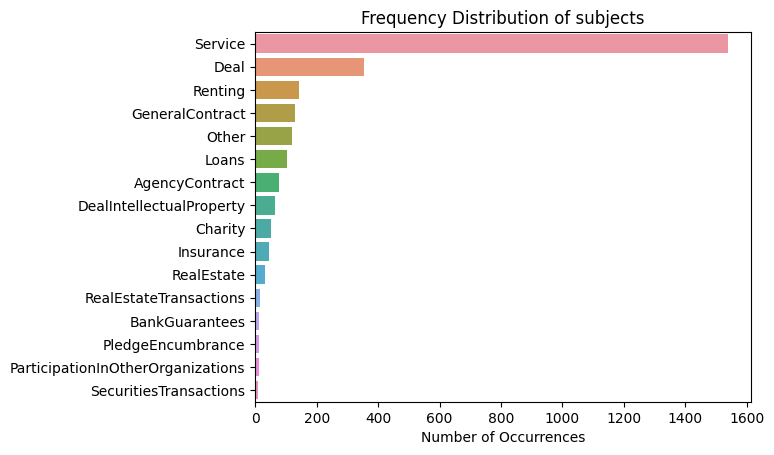


min 8
max 1538
total 2717


In [27]:
%matplotlib inline

subj_count = stats_valid['subject'].value_counts()

#plot distribution---------------------
sns.barplot(subj_count.values, subj_count.index)
plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


print ('\nmin', min (subj_count.values))
print ('max', max (subj_count.values))
print ('total', sum (subj_count.values))

In [28]:
from sklearn.utils import class_weight
from trainsets.trainset_tools import get_feature_log_weights

_classes = stats_valid['subject'].unique().tolist()

print(f'classes: {_classes}')

# class_weights = class_weight.compute_class_weight('balanced', _classes, umtm.stats['subject'])
# class_weights = dict(zip(_classes, class_weights))


class_weights = get_feature_log_weights(stats_valid, 'subject')
class_weights

classes: ['Loans', 'Service', 'AgencyContract', 'Charity', 'BankGuarantees', 'SecuritiesTransactions', 'Renting', 'PledgeEncumbrance', 'DealIntellectualProperty', 'Deal', 'GeneralContract', 'Insurance', 'ParticipationInOtherOrganizations', 'RealEstateTransactions', 'RealEstate', 'Other']


Service                              0.497240
Deal                                 0.621146
Renting                              0.736343
GeneralContract                      0.749700
Other                                0.760915
Loans                                0.784104
AgencyContract                       0.837603
DealIntellectualProperty             0.874186
Charity                              0.919124
Insurance                            0.953129
RealEstate                           1.043667
RealEstateTransactions               1.288004
BankGuarantees                       1.382763
PledgeEncumbrance                    1.422714
ParticipationInOtherOrganizations    1.468542
SecuritiesTransactions               1.660818
Name: subject, dtype: float64

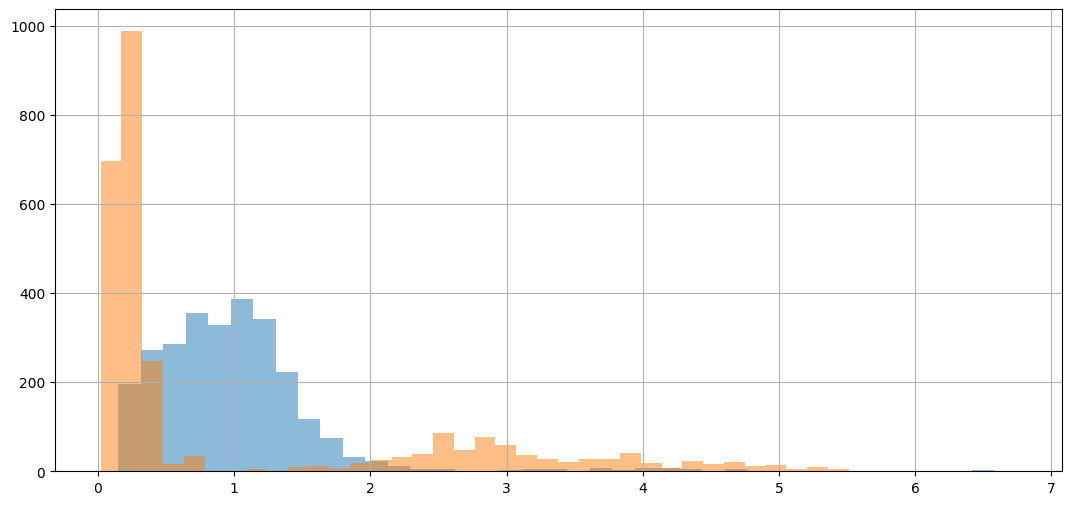

In [29]:
from trainsets.trainset_tools import get_feature_log_weights
 

plt.figure(figsize=(13, 6))

stats_valid['subject_weight'].hist(bins=40, alpha=0.5)
stats_valid['sample_weight'].hist(bins=40, alpha=0.5)

plt.xscale('linear') # log?
plt.show()

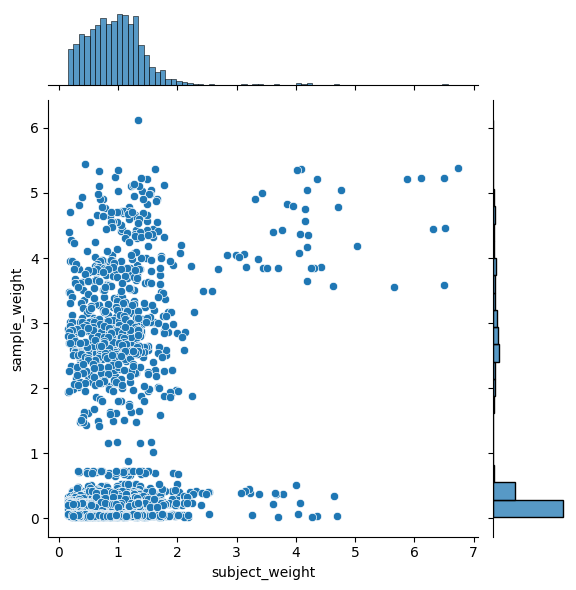

In [30]:
sns.jointplot(x="subject_weight", y="sample_weight", data=stats_valid)
plt.show()

# look into trainset (take a sample)

SAMPLE_DOC_ID 5fe34f62b770574a005553be
semantic map shape is: (759, 30)


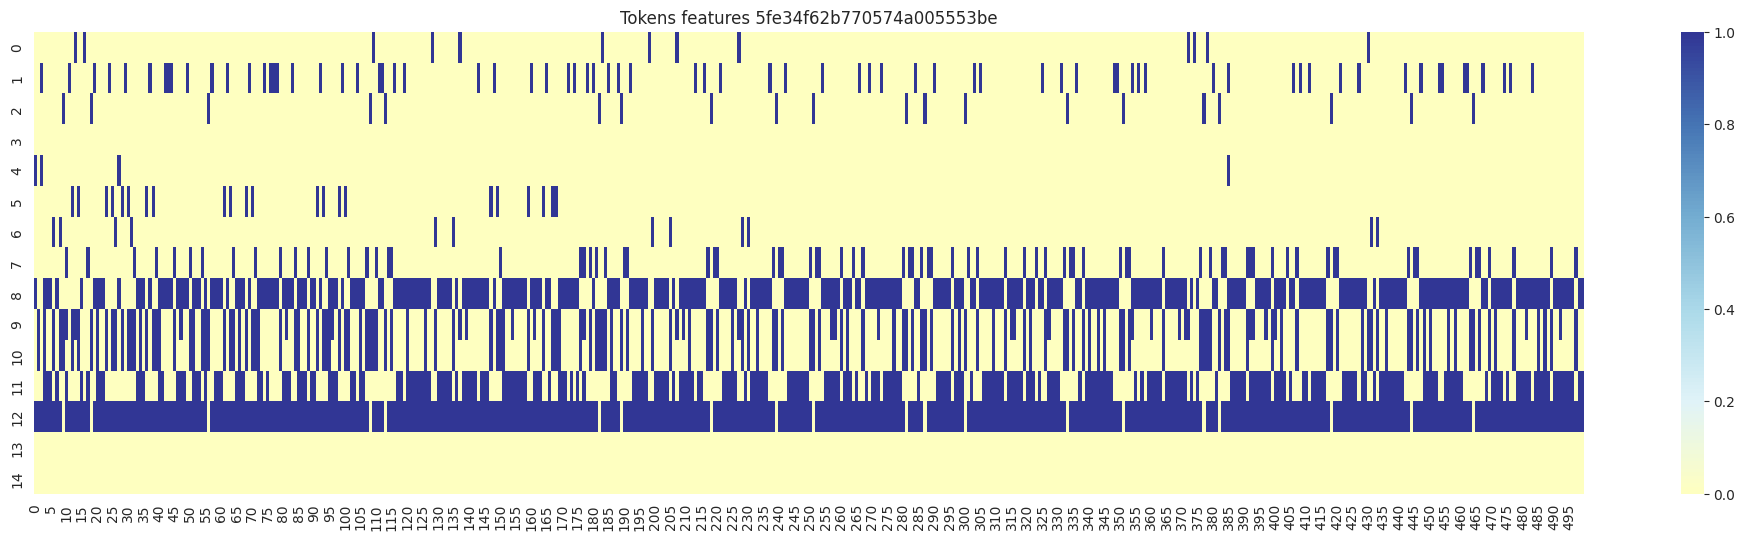

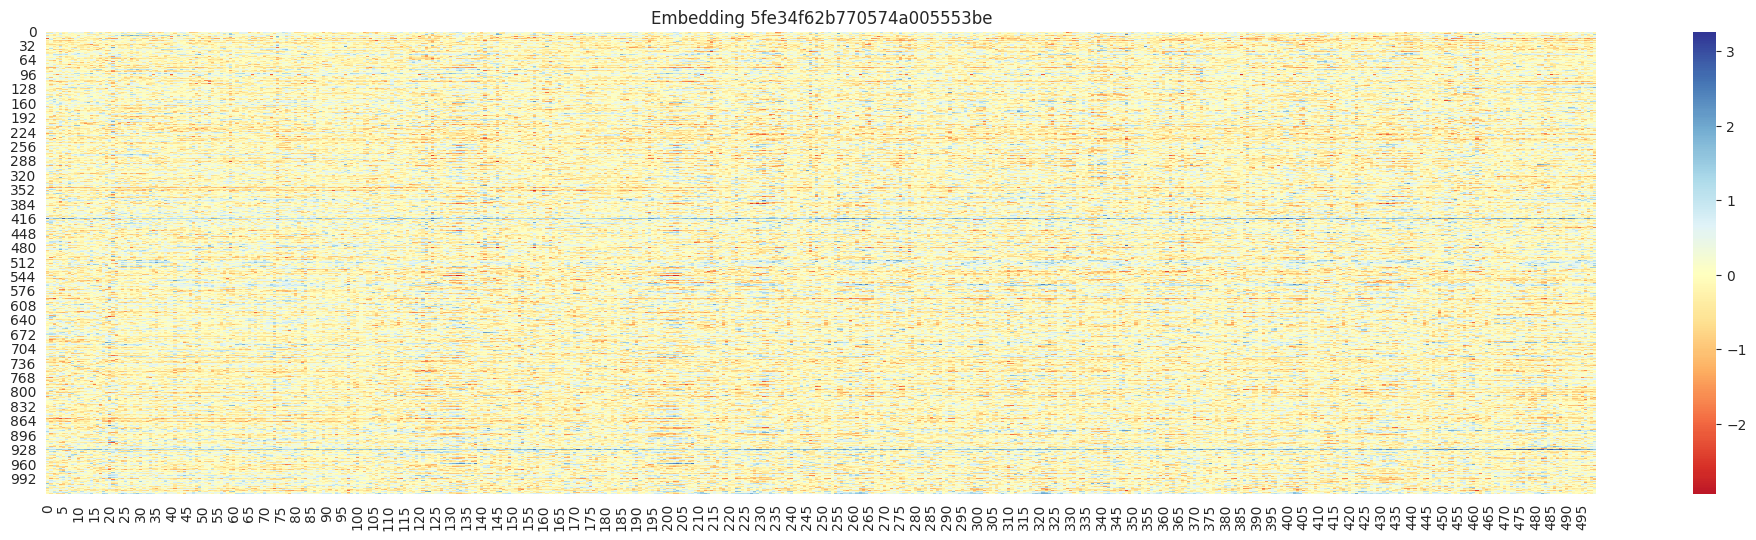

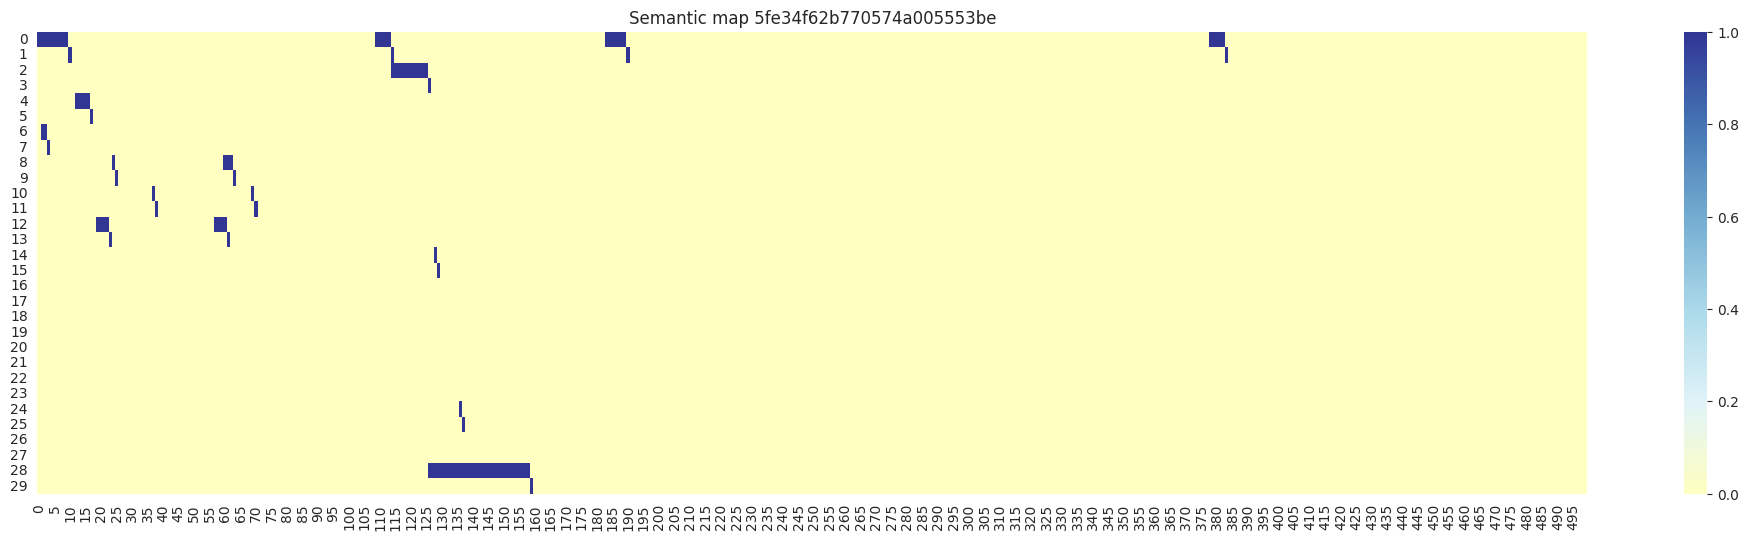

In [31]:
%matplotlib inline
# umtm.calculate_samples_weights()
SAMPLE_DOC_ID = '5fe34f62b770574a005553be' #stats_valid.index[1]

print('SAMPLE_DOC_ID', SAMPLE_DOC_ID)
(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = make_xyw(SAMPLE_DOC_ID, stats)
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
plot_embedding(tok_f[:_crop], title=f'Tokens features {SAMPLE_DOC_ID}') 
plot_embedding(emb[:_crop], title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[:_crop], title=f'Semantic map {SAMPLE_DOC_ID}')



# Batch generator & TODOs 🙏


- [X] TODO: add outliers to the trainset ?
- [ ] TODO: try sparse_categorical_entropy instead of one-hot encodings
- [ ] TODO: model 5.2, 5.1: bipolar concat layer is wrong because we concatenate thongs of different magnitudes. Add a Sigmoid activation layer
- [ ] TODO: chechk what is better: to pad with zeros or to pad with means
- [X] TODO: add weights to samples
- [ ] TODO: sum semantic map alongside vertical axis, and mutiply it (as a mask) by the subject detection seq
- [ ] TODO: introduce individual per tag threshosholds, also, the current 0.3 threshold is strange.

3
semantic map shape is: (14, 638, 30)


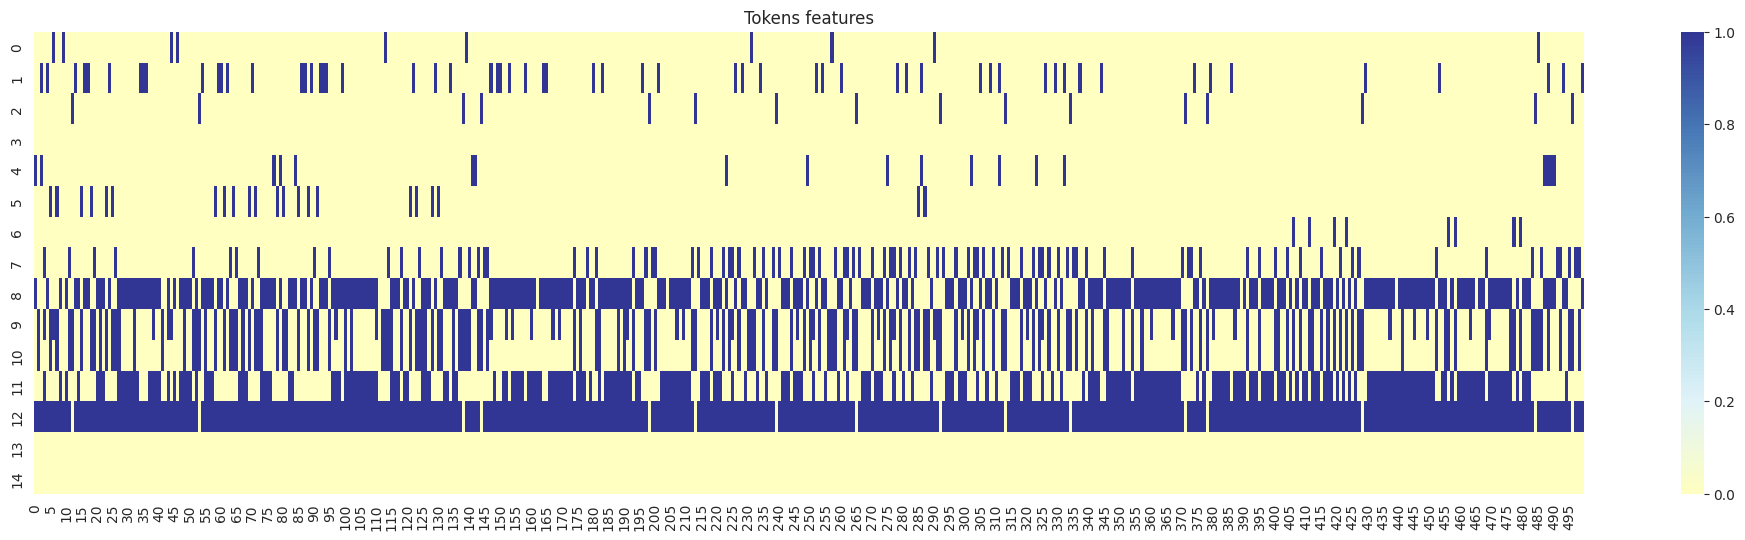

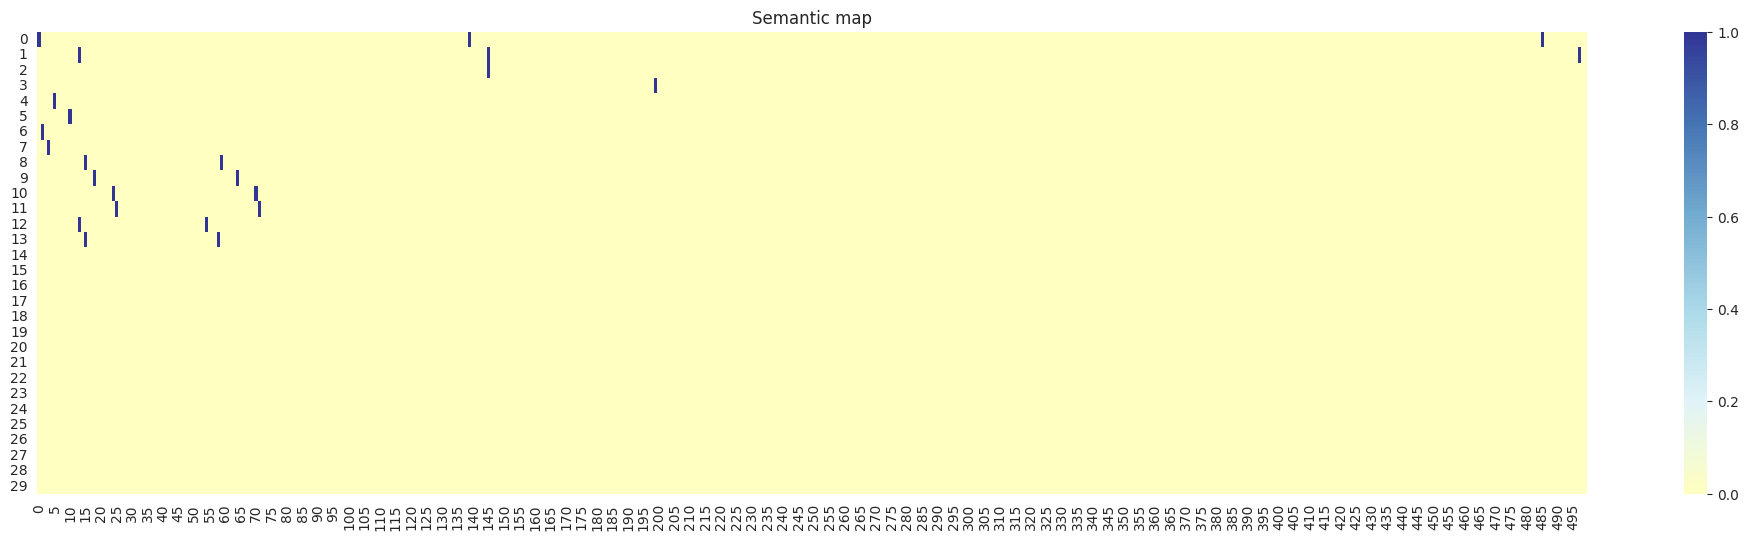

In [32]:
import numpy as np
import random
import pandas as pd

def make_generator(self, indices: [int], batch_size: int, augment_samples=False):
  np.random.seed(43)

  while True:
    # next batch
    batch_indices = np.random.choice(a=indices, size=batch_size)

    max_len = 128 * 12
    start_from = 0

    if augment_samples:
      max_len = random.randint(300, 1400)

    batch_input_emb = []
    batch_input_token_f = []
    batch_output_sm = []
    batch_output_subj = []

    weights = []
    weights_subj = []

    # Read in each input, perform preprocessing and get labels
    for doc_id in batch_indices:

      dp = make_xyw(doc_id, stats)
      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
        
#       print(dp)
    
      subject_weight_K = 1.0
      if augment_samples:
        start_from = 0

        row = stats_valid.loc[doc_id]
        if random.random() < 0.4:  # 40% of samples
          segment_center = random.randint(0, len(emb) - 1)  ##select random token as a center
          if not pd.isna(row['value_span']) and random.random() < 0.7:
            segment_center = int(row['value_span'])

          _off = random.randint(max_len // 4, max_len // 2)
          start_from = segment_center - _off
          if start_from < 0:
            start_from = 0
          subject_weight_K = 0.1  # lower subject weight because there mighе be no information about subject around doc. value
        
      dp = self.trim_maxlen(dp, start_from, max_len)
      
      # TODO: find samples maxlen

      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
#       print((sample_weight, subject_weight))
      subject_weight *= subject_weight_K

      batch_input_emb.append(emb)
      batch_input_token_f.append(tok_f)

      batch_output_sm.append(sm)
      batch_output_subj.append(subj)

      if np.isnan(sample_weight):
        raise ValueError()

      if np.isnan(subject_weight):
        raise ValueError()
      
      weights.append(sample_weight)
      weights_subj.append(subject_weight)
      # end if emb
    # end for loop

    # Returns a tuple of (input, output, weights) to feed the network
#     print('batch_output_subj', len(batch_output_subj))
#     print('batch_output_sm', len(batch_output_subj))

    yield ([np.array(batch_input_emb), np.array(batch_input_token_f)],
           [np.array(batch_output_sm), np.array(batch_output_subj)],
           [np.array(weights), np.array(weights_subj)])
    

    
_train, _test = train_test_split(stats_valid, test_size=0.10, stratify=stats_valid[['subject']])

train_indices = list(_train.index)
test_indices = list(_test.index)

    
####---test
_gen = make_generator(umtm, train_indices, 14, augment_samples=True)

sample = next(_gen)
print(len(sample))
del _gen
 


(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = sample
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
plot_embedding(tok_f[0][:_crop], title=f'Tokens features') 
# plot_embedding(emb[:_crop],   title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[0][:_crop],    title=f'Semantic map')

In [33]:
SAMPLE_DOC_ID

'5fe34f62b770574a005553be'

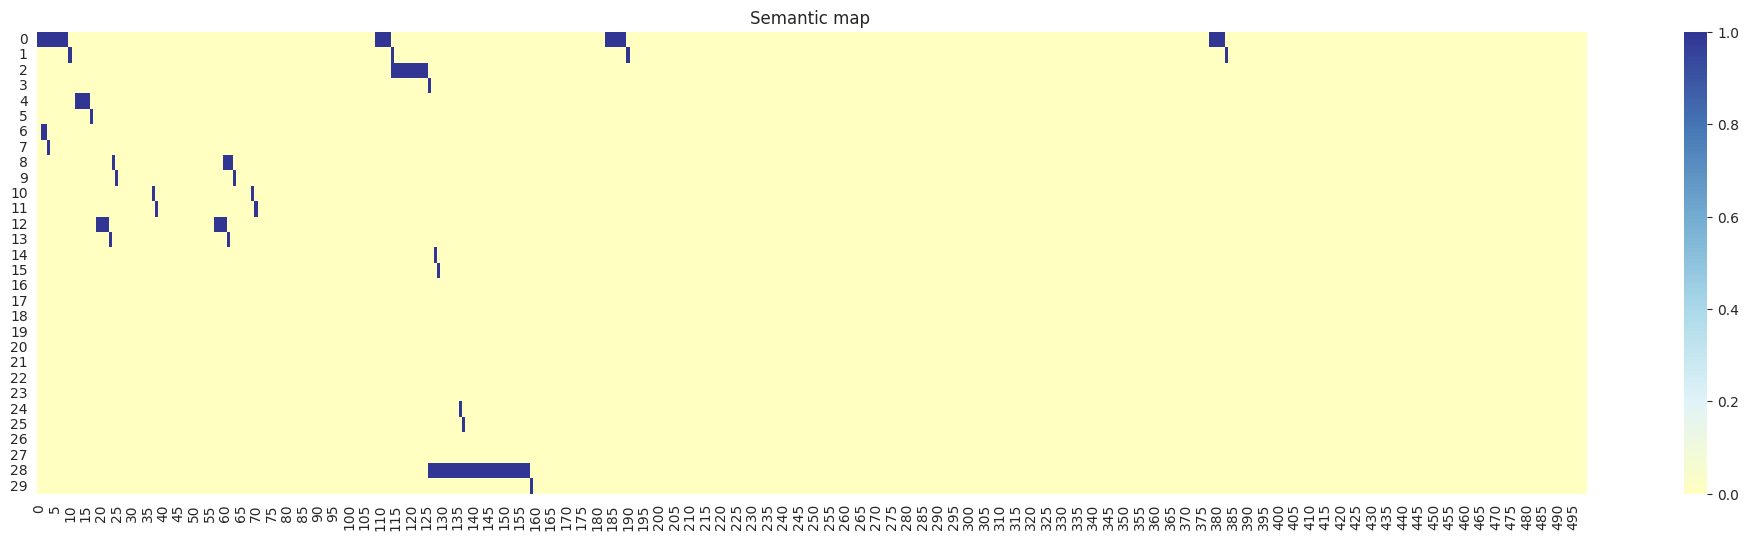

In [34]:
dp = make_xyw('5fe34f62b770574a005553be', stats_valid)

(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

plot_embedding(sm[:500],    title=f'Semantic map ')

train_indices[0]: 638085946a07f3e980b2c53b
test_indices[0]: 5edbadd3da3678279fbcaa99


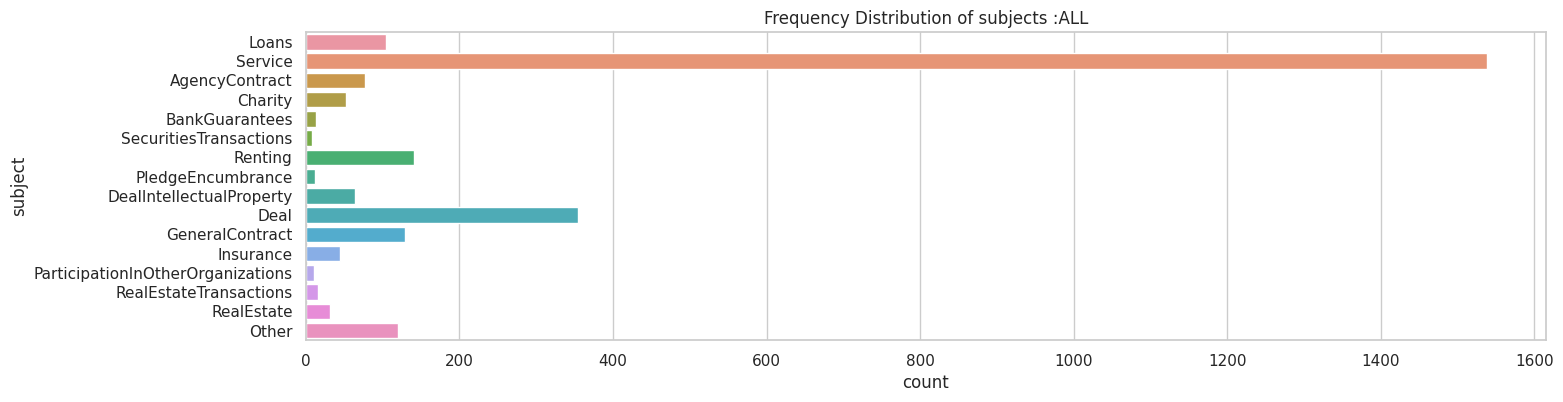

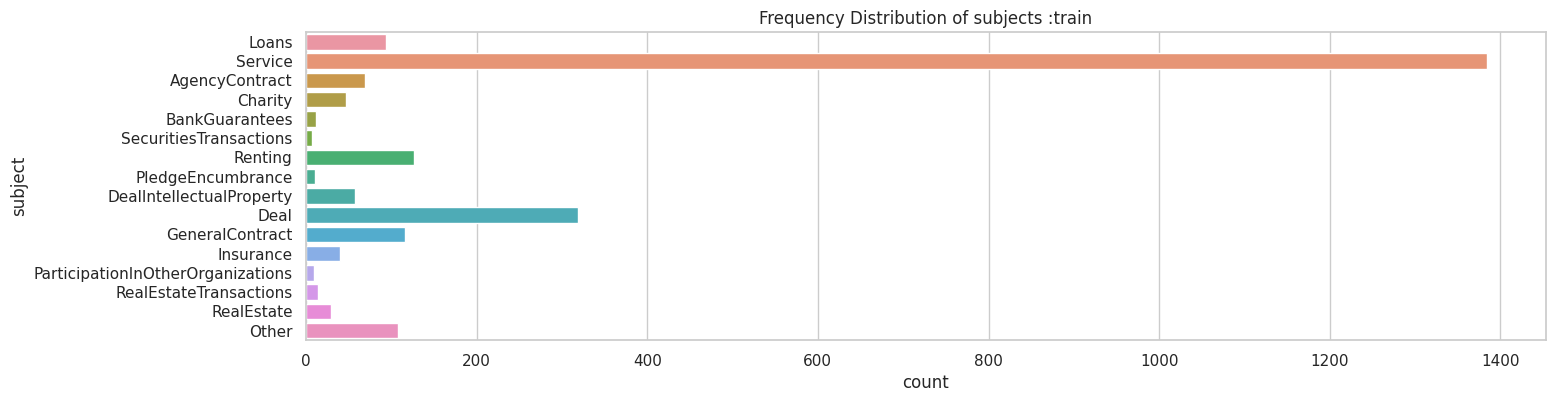

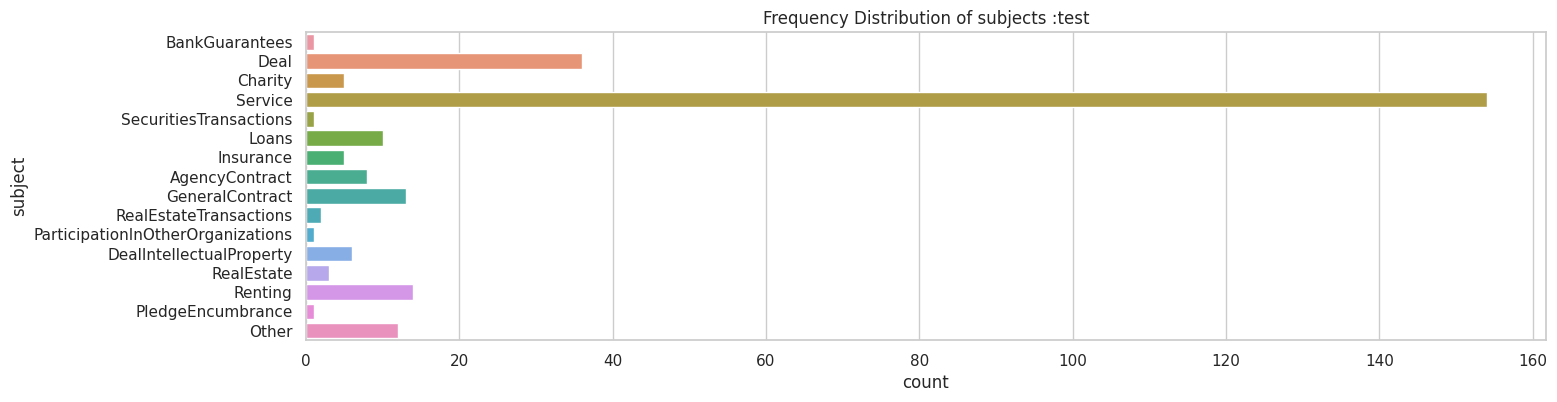

In [35]:
EPOCHS = 50
BATCH_SIZE = 96
EMB =  1024
 
_SELFTEST = True


print('train_indices[0]:', train_indices[0])
print('test_indices[0]:', test_indices[0])


def plot_subject_distr(df, title):  
  target='subject'
  plt.figure(figsize=(16,4))   
  sns.set(style="whitegrid")
  chart = sns.countplot(data=df, y=target)
  plt.title(f'Frequency Distribution of subjects :{title}')

 
plot_subject_distr(stats_valid, 'ALL')
plot_subject_distr(stats_valid[stats_valid.index.isin(train_indices)], 'train')
plot_subject_distr(stats_valid[stats_valid.index.isin(test_indices)], 'test')


if _SELFTEST:
  # test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True)
  
  x, y, w = next(train_gen)
  
#   print('X:', len(x), 'X[0]=', x[0].shape, 'X[1]=', x[1].shape)
#   print('Y:', len(y), 'Y[0]=', y[0].shape, 'Y[1]=', y[1].shape)
  

#   plot_embedding(x[0][0], 'X2: Token Embeddings')
#   plot_embedding(x[1][0], 'X1: Token Features')
#   plot_embedding(y[0][0], 'Y: Semantic Map')
  
#   print(y[0][1])

#   del x
#   del w
#   del y
#   del train_gen

In [36]:

ctx = KerasTrainingContext(checkpoints_path=umtm.reports_dir, session_index=1)

ctx.set_batch_size_and_trainset_size(BATCH_SIZE, 
                                     len(test_indices), 
                                     4 * len(train_indices))

DEFAULT_TRAIN_CTX = ctx
CLASSES = 43
FEATURES = 14

metrics = ['kullback_leibler_divergence', 'mse', 'binary_crossentropy']


def train(umodel):
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)

def overtrain(umodel):
  test_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE)
  train_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/training_reports


batch_size:	96
train_samples:	9780
test_samples:	272
steps_per_epoch:	101
validation_steps:	50


# Models 🦖

In [37]:
def get_weights_filename(model_factory_fn):
    weights = ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.h5'
    print(weights.is_file(), weights)
    if not weights.is_file():
        weights = Path(analyser.hyperparams.models_path) / f'{model_factory_fn.__name__}.h5'
        print(weights.is_file(), weights)
    
    return weights

# get_weights_filename(uber_detection_model_005_1_1)

## Train from 0 uber_detection_model_003

In [38]:
if TRAIN_MODEL_3:
    from tf_support.super_contract_model import uber_detection_model_003
    
    model_factory_fn = uber_detection_model_003
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

    umodel.summary()

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 10
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

## Continue training 003 from checkpoint

In [39]:
analyser.hyperparams.models_path

'/root/artem/analyser/analyser/vocab'

In [40]:
if TRAIN_MODEL_3:
    
    model_factory_fn = uber_detection_model_003

    weights = get_weights_filename(model_factory_fn)
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 25
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

## Overtrain 003

In [41]:
if TRAIN_MODEL_3:
    if TRAIN:
      ctx.unfreezeModel(umodel)
      umodel.compile(loss=super_contract_model.losses, optimizer='Adam', metrics=super_contract_model.metrics)
      print(super_contract_model.losses)
      umodel.summary()

      ctx.EPOCHS = 12
      ctx.EVALUATE_ONLY = False

      test_gen = make_generator(umtm, train_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 

      ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=False, lr=2e-5)

## 005 model
- 0.0233: last val subject loss
- 0.0016: last tagging loss
- 0.0248: last val loss


In [42]:
if TRAIN_MODEL_3:
    model_factory_fn = uber_detection_model_005_1_1
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

    umodel.summary()

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 20
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

### 5.1.1 💕💕 uber_detection_model_005_1_1

In [43]:
from tf_support.super_contract_model import FEATURES 
from analyser.headers_detector import TOKEN_FEATURES

from tf_support.super_contract_model import sigmoid_focal_crossentropy, losses

import numpy as np
from pandas import DataFrame 



model_factory_fn = uber_detection_model_005_1_1
weights = get_weights_filename(model_factory_fn)
umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)
# umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

True /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


2023-02-05 13:32:42.695707: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-05 13:32:43.229001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 13:32:43.229657: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-05 13:32:43.229676: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-05 13:32:43.229720: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-05 13:32:43.229739: I tensorflow/stream_executor/platform/defa

[tools.py:121 -           init_model() ] weights loaded: /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


In [44]:
######################
# Phase I retraining
# ❄️ frozen bottom layers
######################
if False:
    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 10
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

In [45]:
23

23

#### Phase II finetuning
all unfrozen, entire trainset, low LR
 

In [46]:
######################
## Phase II finetuning
#  all unfrozen, entire trainset, low LR
######################
if TRAIN and False:
  ctx.unfreezeModel(umodel)
  umodel.compile(loss=super_contract_model.losses, optimizer='Adam', metrics=super_contract_model.metrics)
  umodel.summary()
  
  ctx.EPOCHS = 30
  ctx.EVALUATE_ONLY = False
  ctx.EPOCHS *= 2

  test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
  
  ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=True, lr=1e-5)

## 🥰 Att model

In [47]:
from dataclasses import dataclass

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers

from analyser.headers_detector import TOKEN_FEATURES
from tf_support.super_contract_model import EMB, CLASSES, DEFAULT_TRAIN_CTX, FEATURES
from tf_support.tools import KerasTrainingContext


@dataclass
class Config:
  # MAX_LEN = 256
  # BATCH_SIZE = 32
  LR = 0.001

  EMBED_DIM = EMB
  NUM_HEAD = 4  # used in bert model
  FF_DIM = 128  # used in bert model
  NUM_LAYERS = 1


config = Config()


def bert_module(query, key, value, i, height):
  # Multi headed self-attention
  attention_output = layers.MultiHeadAttention(
    num_heads=config.NUM_HEAD,
    key_dim=config.EMBED_DIM // config.NUM_HEAD,
    name="encoder_{}/multiheadattention".format(i),
  )(query, key, value)
  attention_output = layers.Dropout(0.1, name="encoder_{}/att_dropout".format(i))(
    attention_output
  )
  attention_output = layers.LayerNormalization(
    epsilon=1e-6, name=f"encoder_{i}/att_layernormalization"
  )(query + attention_output)

  # Feed-forward layer
  ffn = keras.Sequential(
    [
      layers.Dense(config.FF_DIM, activation="relu"),
      layers.Dense(height),
    ],
    name=f"encoder_{i}/ffn",
  )
  ffn_output = ffn(attention_output)
  ffn_output = layers.Dropout(0.1, name=f"encoder_{i}/ffn_dropout")(
    ffn_output
  )
  sequence_output = layers.LayerNormalization(
    epsilon=1e-6, name=f"encoder_{i}/ffn_layernormalization"
  )(attention_output + ffn_output)
  return sequence_output


metrics = ['mse', 'binary_crossentropy']

losses = {
  "O1_tagging": "binary_crossentropy",
  "O2_subject": "binary_crossentropy",
}


def make_att_model(name='make_att_model', ctx: KerasTrainingContext = DEFAULT_TRAIN_CTX, trained=False):
  input_text_emb = layers.Input(shape=[None, config.EMBED_DIM], dtype='float32', name="input_text_emb")
  _out = layers.BatchNormalization(name="bn1")(input_text_emb)
  _out = layers.Dropout(0.2, name="drops")(_out)  # small_drops_of_poison

  token_features = layers.Input(shape=[None, TOKEN_FEATURES], dtype='float32', name="token_features")
  token_features_n = layers.BatchNormalization(name="bn2")(token_features)

  _out = layers.concatenate([input_text_emb, token_features_n], axis=-1)

  for i in range(config.NUM_LAYERS):
    _out = bert_module(_out, _out, _out, i, height=config.EMBED_DIM + TOKEN_FEATURES)

  _out = layers.BatchNormalization(name="bn1")(_out)
  _out = layers.LSTM(FEATURES, return_sequences=True, activation='tanh', name='O1_tagging_tanh')(_out)
  _out1 = layers.ReLU(name='O1_tagging')(_out)

  #   _out = Conv1D(filters=FEATURES * 4, kernel_size=(2), padding='same', activation='relu' , name='embedding_reduced')(_out)
  _out = layers.Bidirectional(layers.LSTM(16, return_sequences=False, name='narcissisism'), name='embedding_reduced')(
    _out)
  _out = layers.BatchNormalization(name="bn_bi_2")(_out)
  _out = layers.Dropout(0.1)(_out)

  _out2 = layers.Dense(CLASSES, activation='softmax', name='O2_subject')(_out)

  base_model_inputs = [input_text_emb, token_features]
  model = Model(inputs=base_model_inputs, outputs=[_out1, _out2], name=name)
  model.compile(loss=losses, optimizer='Adam', metrics=metrics)
  return model


 

    
weights = get_weights_filename(model_factory_fn)
# model_name = make_att_model.__name__
umodel = make_att_model()

# umodel.load_weights(weights, by_name=True, skip_mismatch=True)
# ctx.init_model(make_att_model, trained=True, trainable=True, weights=weights)



True /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


In [48]:

if TRAIN:
#   ctx.unfreezeModel(umodel)
  umodel.summary()
  
  ctx.EPOCHS = 50
  ctx.EVALUATE_ONLY = False
#   ctx.EPOCHS *= 2

  test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
  
  ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=True, lr=config.LR)

Model: "make_att_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
token_features (InputLayer)     [(None, None, 15)]   0                                            
__________________________________________________________________________________________________
input_text_emb (InputLayer)     [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
bn2 (BatchNormalization)        (None, None, 15)     60          token_features[0][0]             
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, 1039)   0           input_text_emb[0][0]             
                                                                 bn2[0][0]           

/root/artem/env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


2023-02-05 13:32:46.787808: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-05 13:32:46.805936: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz


Epoch 1/50


2023-02-05 13:32:49.527607: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


2023-02-05 13:32:50.625103: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-05 13:32:50.625139: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-05 13:32:50.656343: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8


2023-02-05 13:32:50.872383: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500


  1/101 [..............................] - ETA: 7:38 - loss: 0.5860 - O1_tagging_loss: 0.1795 - O2_subject_loss: 0.4065 - O1_tagging_mse: 0.0509 - O1_tagging_binary_crossentropy: 0.2170 - O2_subject_mse: 0.0233 - O2_subject_binary_crossentropy: 0.7896

  2/101 [..............................] - ETA: 27s - loss: 0.5999 - O1_tagging_loss: 0.1668 - O2_subject_loss: 0.4331 - O1_tagging_mse: 0.0451 - O1_tagging_binary_crossentropy: 0.1838 - O2_subject_mse: 0.0233 - O2_subject_binary_crossentropy: 0.7944 

  3/101 [..............................] - ETA: 54s - loss: 0.5807 - O1_tagging_loss: 0.1602 - O2_subject_loss: 0.4205 - O1_tagging_mse: 0.0426 - O1_tagging_binary_crossentropy: 0.1712 - O2_subject_mse: 0.0234 - O2_subject_binary_crossentropy: 0.7956

  4/101 [>.............................] - ETA: 1:05 - loss: 0.5782 - O1_tagging_loss: 0.1510 - O2_subject_loss: 0.4272 - O1_tagging_mse: 0.0394 - O1_tagging_binary_crossentropy: 0.1582 - O2_subject_mse: 0.0234 - O2_subject_binary_crossentropy: 0.7955

  5/101 [>.............................] - ETA: 1:11 - loss: 0.5586 - O1_tagging_loss: 0.1473 - O2_subject_loss: 0.4114 - O1_tagging_mse: 0.0375 - O1_tagging_binary_crossentropy: 0.1515 - O2_subject_mse: 0.0234 - O2_subject_binary_crossentropy: 0.7956

  6/101 [>.............................] - ETA: 1:19 - loss: 0.5496 - O1_tagging_loss: 0.1408 - O2_subject_loss: 0.4088 - O1_tagging_mse: 0.0357 - O1_tagging_binary_crossentropy: 0.1451 - O2_subject_mse: 0.0233 - O2_subject_binary_crossentropy: 0.7952

  7/101 [=>............................] - ETA: 1:22 - loss: 0.5434 - O1_tagging_loss: 0.1360 - O2_subject_loss: 0.4074 - O1_tagging_mse: 0.0348 - O1_tagging_binary_crossentropy: 0.1429 - O2_subject_mse: 0.0233 - O2_subject_binary_crossentropy: 0.7947

  8/101 [=>............................] - ETA: 1:22 - loss: 0.5252 - O1_tagging_loss: 0.1266 - O2_subject_loss: 0.3986 - O1_tagging_mse: 0.0335 - O1_tagging_binary_crossentropy: 0.1394 - O2_subject_mse: 0.0233 - O2_subject_binary_crossentropy: 0.7956

  9/101 [=>............................] - ETA: 1:26 - loss: 0.5135 - O1_tagging_loss: 0.1193 - O2_subject_loss: 0.3942 - O1_tagging_mse: 0.0316 - O1_tagging_binary_crossentropy: 0.1328 - O2_subject_mse: 0.0233 - O2_subject_binary_crossentropy: 0.7957

 10/101 [=>............................] - ETA: 1:31 - loss: 0.5043 - O1_tagging_loss: 0.1133 - O2_subject_loss: 0.3911 - O1_tagging_mse: 0.0298 - O1_tagging_binary_crossentropy: 0.1261 - O2_subject_mse: 0.0233 - O2_subject_binary_crossentropy: 0.7960

 11/101 [==>...........................] - ETA: 1:33 - loss: 0.4980 - O1_tagging_loss: 0.1085 - O2_subject_loss: 0.3895 - O1_tagging_mse: 0.0280 - O1_tagging_binary_crossentropy: 0.1191 - O2_subject_mse: 0.0233 - O2_subject_binary_crossentropy: 0.7956

 12/101 [==>...........................] - ETA: 1:32 - loss: 0.4946 - O1_tagging_loss: 0.1045 - O2_subject_loss: 0.3901 - O1_tagging_mse: 0.0268 - O1_tagging_binary_crossentropy: 0.1146 - O2_subject_mse: 0.0233 - O2_subject_binary_crossentropy: 0.7961

 13/101 [==>...........................] - ETA: 1:27 - loss: 0.4860 - O1_tagging_loss: 0.0996 - O2_subject_loss: 0.3864 - O1_tagging_mse: 0.0261 - O1_tagging_binary_crossentropy: 0.1122 - O2_subject_mse: 0.0233 - O2_subject_binary_crossentropy: 0.7970

 14/101 [===>..........................] - ETA: 1:26 - loss: 0.4805 - O1_tagging_loss: 0.0973 - O2_subject_loss: 0.3832 - O1_tagging_mse: 0.0257 - O1_tagging_binary_crossentropy: 0.1107 - O2_subject_mse: 0.0233 - O2_subject_binary_crossentropy: 0.7986

 15/101 [===>..........................] - ETA: 1:34 - loss: 0.4719 - O1_tagging_loss: 0.0930 - O2_subject_loss: 0.3789 - O1_tagging_mse: 0.0240 - O1_tagging_binary_crossentropy: 0.1044 - O2_subject_mse: 0.0233 - O2_subject_binary_crossentropy: 0.7986

 16/101 [===>..........................] - ETA: 1:30 - loss: 0.4670 - O1_tagging_loss: 0.0917 - O2_subject_loss: 0.3753 - O1_tagging_mse: 0.0236 - O1_tagging_binary_crossentropy: 0.1036 - O2_subject_mse: 0.0233 - O2_subject_binary_crossentropy: 0.8004

 17/101 [====>.........................] - ETA: 1:29 - loss: 0.4672 - O1_tagging_loss: 0.0891 - O2_subject_loss: 0.3781 - O1_tagging_mse: 0.0228 - O1_tagging_binary_crossentropy: 0.1004 - O2_subject_mse: 0.0233 - O2_subject_binary_crossentropy: 0.8017

 18/101 [====>.........................] - ETA: 1:29 - loss: 0.4618 - O1_tagging_loss: 0.0866 - O2_subject_loss: 0.3753 - O1_tagging_mse: 0.0220 - O1_tagging_binary_crossentropy: 0.0974 - O2_subject_mse: 0.0232 - O2_subject_binary_crossentropy: 0.8029

 19/101 [====>.........................] - ETA: 1:29 - loss: 0.4561 - O1_tagging_loss: 0.0839 - O2_subject_loss: 0.3722 - O1_tagging_mse: 0.0217 - O1_tagging_binary_crossentropy: 0.0961 - O2_subject_mse: 0.0232 - O2_subject_binary_crossentropy: 0.8050

 20/101 [====>.........................] - ETA: 1:31 - loss: 0.4530 - O1_tagging_loss: 0.0816 - O2_subject_loss: 0.3714 - O1_tagging_mse: 0.0207 - O1_tagging_binary_crossentropy: 0.0918 - O2_subject_mse: 0.0232 - O2_subject_binary_crossentropy: 0.8066

 21/101 [=====>........................] - ETA: 1:33 - loss: 0.4476 - O1_tagging_loss: 0.0795 - O2_subject_loss: 0.3681 - O1_tagging_mse: 0.0195 - O1_tagging_binary_crossentropy: 0.0873 - O2_subject_mse: 0.0232 - O2_subject_binary_crossentropy: 0.8083

 22/101 [=====>........................] - ETA: 1:35 - loss: 0.4478 - O1_tagging_loss: 0.0778 - O2_subject_loss: 0.3700 - O1_tagging_mse: 0.0186 - O1_tagging_binary_crossentropy: 0.0838 - O2_subject_mse: 0.0232 - O2_subject_binary_crossentropy: 0.8096

 23/101 [=====>........................] - ETA: 1:34 - loss: 0.4429 - O1_tagging_loss: 0.0754 - O2_subject_loss: 0.3675 - O1_tagging_mse: 0.0177 - O1_tagging_binary_crossentropy: 0.0803 - O2_subject_mse: 0.0232 - O2_subject_binary_crossentropy: 0.8108

 24/101 [======>.......................] - ETA: 1:31 - loss: 0.4361 - O1_tagging_loss: 0.0737 - O2_subject_loss: 0.3624 - O1_tagging_mse: 0.0174 - O1_tagging_binary_crossentropy: 0.0795 - O2_subject_mse: 0.0232 - O2_subject_binary_crossentropy: 0.8126

 25/101 [======>.......................] - ETA: 1:31 - loss: 0.4329 - O1_tagging_loss: 0.0718 - O2_subject_loss: 0.3611 - O1_tagging_mse: 0.0167 - O1_tagging_binary_crossentropy: 0.0767 - O2_subject_mse: 0.0232 - O2_subject_binary_crossentropy: 0.8143

 26/101 [======>.......................] - ETA: 1:29 - loss: 0.4306 - O1_tagging_loss: 0.0706 - O2_subject_loss: 0.3600 - O1_tagging_mse: 0.0163 - O1_tagging_binary_crossentropy: 0.0752 - O2_subject_mse: 0.0232 - O2_subject_binary_crossentropy: 0.8162

 27/101 [=======>......................] - ETA: 1:28 - loss: 0.4267 - O1_tagging_loss: 0.0689 - O2_subject_loss: 0.3579 - O1_tagging_mse: 0.0155 - O1_tagging_binary_crossentropy: 0.0724 - O2_subject_mse: 0.0232 - O2_subject_binary_crossentropy: 0.8181

 28/101 [=======>......................] - ETA: 1:25 - loss: 0.4243 - O1_tagging_loss: 0.0674 - O2_subject_loss: 0.3569 - O1_tagging_mse: 0.0154 - O1_tagging_binary_crossentropy: 0.0719 - O2_subject_mse: 0.0232 - O2_subject_binary_crossentropy: 0.8194

 29/101 [=======>......................] - ETA: 1:24 - loss: 0.4215 - O1_tagging_loss: 0.0659 - O2_subject_loss: 0.3556 - O1_tagging_mse: 0.0148 - O1_tagging_binary_crossentropy: 0.0697 - O2_subject_mse: 0.0232 - O2_subject_binary_crossentropy: 0.8207

 30/101 [=======>......................] - ETA: 1:22 - loss: 0.4177 - O1_tagging_loss: 0.0649 - O2_subject_loss: 0.3528 - O1_tagging_mse: 0.0145 - O1_tagging_binary_crossentropy: 0.0683 - O2_subject_mse: 0.0232 - O2_subject_binary_crossentropy: 0.8222

 31/101 [========>.....................] - ETA: 1:20 - loss: 0.4163 - O1_tagging_loss: 0.0640 - O2_subject_loss: 0.3523 - O1_tagging_mse: 0.0142 - O1_tagging_binary_crossentropy: 0.0672 - O2_subject_mse: 0.0232 - O2_subject_binary_crossentropy: 0.8235

 32/101 [========>.....................] - ETA: 1:21 - loss: 0.4140 - O1_tagging_loss: 0.0632 - O2_subject_loss: 0.3508 - O1_tagging_mse: 0.0137 - O1_tagging_binary_crossentropy: 0.0655 - O2_subject_mse: 0.0232 - O2_subject_binary_crossentropy: 0.8249

 33/101 [========>.....................] - ETA: 1:19 - loss: 0.4113 - O1_tagging_loss: 0.0624 - O2_subject_loss: 0.3489 - O1_tagging_mse: 0.0136 - O1_tagging_binary_crossentropy: 0.0649 - O2_subject_mse: 0.0231 - O2_subject_binary_crossentropy: 0.8267

 34/101 [=========>....................] - ETA: 1:17 - loss: 0.4096 - O1_tagging_loss: 0.0617 - O2_subject_loss: 0.3479 - O1_tagging_mse: 0.0135 - O1_tagging_binary_crossentropy: 0.0645 - O2_subject_mse: 0.0231 - O2_subject_binary_crossentropy: 0.8285

 35/101 [=========>....................] - ETA: 1:17 - loss: 0.4066 - O1_tagging_loss: 0.0606 - O2_subject_loss: 0.3461 - O1_tagging_mse: 0.0130 - O1_tagging_binary_crossentropy: 0.0626 - O2_subject_mse: 0.0231 - O2_subject_binary_crossentropy: 0.8300

 36/101 [=========>....................] - ETA: 1:16 - loss: 0.4052 - O1_tagging_loss: 0.0599 - O2_subject_loss: 0.3453 - O1_tagging_mse: 0.0127 - O1_tagging_binary_crossentropy: 0.0614 - O2_subject_mse: 0.0231 - O2_subject_binary_crossentropy: 0.8320

 37/101 [=========>....................] - ETA: 1:15 - loss: 0.4041 - O1_tagging_loss: 0.0601 - O2_subject_loss: 0.3439 - O1_tagging_mse: 0.0126 - O1_tagging_binary_crossentropy: 0.0612 - O2_subject_mse: 0.0231 - O2_subject_binary_crossentropy: 0.8345

 38/101 [==========>...................] - ETA: 1:13 - loss: 0.4015 - O1_tagging_loss: 0.0596 - O2_subject_loss: 0.3419 - O1_tagging_mse: 0.0125 - O1_tagging_binary_crossentropy: 0.0606 - O2_subject_mse: 0.0231 - O2_subject_binary_crossentropy: 0.8368

 39/101 [==========>...................] - ETA: 1:12 - loss: 0.3991 - O1_tagging_loss: 0.0586 - O2_subject_loss: 0.3405 - O1_tagging_mse: 0.0121 - O1_tagging_binary_crossentropy: 0.0591 - O2_subject_mse: 0.0231 - O2_subject_binary_crossentropy: 0.8385

 40/101 [==========>...................] - ETA: 1:11 - loss: 0.3967 - O1_tagging_loss: 0.0578 - O2_subject_loss: 0.3389 - O1_tagging_mse: 0.0118 - O1_tagging_binary_crossentropy: 0.0578 - O2_subject_mse: 0.0231 - O2_subject_binary_crossentropy: 0.8405

 41/101 [===========>..................] - ETA: 1:09 - loss: 0.3941 - O1_tagging_loss: 0.0572 - O2_subject_loss: 0.3368 - O1_tagging_mse: 0.0116 - O1_tagging_binary_crossentropy: 0.0571 - O2_subject_mse: 0.0231 - O2_subject_binary_crossentropy: 0.8429

 42/101 [===========>..................] - ETA: 1:08 - loss: 0.3926 - O1_tagging_loss: 0.0566 - O2_subject_loss: 0.3360 - O1_tagging_mse: 0.0114 - O1_tagging_binary_crossentropy: 0.0563 - O2_subject_mse: 0.0231 - O2_subject_binary_crossentropy: 0.8449

 43/101 [===========>..................] - ETA: 1:07 - loss: 0.3899 - O1_tagging_loss: 0.0560 - O2_subject_loss: 0.3338 - O1_tagging_mse: 0.0112 - O1_tagging_binary_crossentropy: 0.0554 - O2_subject_mse: 0.0231 - O2_subject_binary_crossentropy: 0.8473

 44/101 [============>.................] - ETA: 1:05 - loss: 0.3877 - O1_tagging_loss: 0.0558 - O2_subject_loss: 0.3319 - O1_tagging_mse: 0.0111 - O1_tagging_binary_crossentropy: 0.0552 - O2_subject_mse: 0.0231 - O2_subject_binary_crossentropy: 0.8499

 45/101 [============>.................] - ETA: 1:04 - loss: 0.3854 - O1_tagging_loss: 0.0553 - O2_subject_loss: 0.3301 - O1_tagging_mse: 0.0110 - O1_tagging_binary_crossentropy: 0.0549 - O2_subject_mse: 0.0230 - O2_subject_binary_crossentropy: 0.8522

 46/101 [============>.................] - ETA: 1:02 - loss: 0.3827 - O1_tagging_loss: 0.0550 - O2_subject_loss: 0.3277 - O1_tagging_mse: 0.0110 - O1_tagging_binary_crossentropy: 0.0548 - O2_subject_mse: 0.0230 - O2_subject_binary_crossentropy: 0.8546

 47/101 [============>.................] - ETA: 1:01 - loss: 0.3813 - O1_tagging_loss: 0.0547 - O2_subject_loss: 0.3266 - O1_tagging_mse: 0.0110 - O1_tagging_binary_crossentropy: 0.0546 - O2_subject_mse: 0.0230 - O2_subject_binary_crossentropy: 0.8568

 48/101 [=============>................] - ETA: 1:00 - loss: 0.3792 - O1_tagging_loss: 0.0543 - O2_subject_loss: 0.3248 - O1_tagging_mse: 0.0108 - O1_tagging_binary_crossentropy: 0.0540 - O2_subject_mse: 0.0230 - O2_subject_binary_crossentropy: 0.8591

 49/101 [=============>................] - ETA: 59s - loss: 0.3765 - O1_tagging_loss: 0.0539 - O2_subject_loss: 0.3226 - O1_tagging_mse: 0.0108 - O1_tagging_binary_crossentropy: 0.0536 - O2_subject_mse: 0.0230 - O2_subject_binary_crossentropy: 0.8617 

 50/101 [=============>................] - ETA: 58s - loss: 0.3748 - O1_tagging_loss: 0.0539 - O2_subject_loss: 0.3209 - O1_tagging_mse: 0.0107 - O1_tagging_binary_crossentropy: 0.0535 - O2_subject_mse: 0.0230 - O2_subject_binary_crossentropy: 0.8643

 51/101 [==============>...............] - ETA: 58s - loss: 0.3730 - O1_tagging_loss: 0.0534 - O2_subject_loss: 0.3196 - O1_tagging_mse: 0.0106 - O1_tagging_binary_crossentropy: 0.0528 - O2_subject_mse: 0.0230 - O2_subject_binary_crossentropy: 0.8663

 52/101 [==============>...............] - ETA: 57s - loss: 0.3708 - O1_tagging_loss: 0.0531 - O2_subject_loss: 0.3177 - O1_tagging_mse: 0.0104 - O1_tagging_binary_crossentropy: 0.0522 - O2_subject_mse: 0.0230 - O2_subject_binary_crossentropy: 0.8686

 53/101 [==============>...............] - ETA: 56s - loss: 0.3692 - O1_tagging_loss: 0.0526 - O2_subject_loss: 0.3166 - O1_tagging_mse: 0.0103 - O1_tagging_binary_crossentropy: 0.0519 - O2_subject_mse: 0.0230 - O2_subject_binary_crossentropy: 0.8710

 54/101 [===============>..............] - ETA: 55s - loss: 0.3674 - O1_tagging_loss: 0.0522 - O2_subject_loss: 0.3152 - O1_tagging_mse: 0.0101 - O1_tagging_binary_crossentropy: 0.0511 - O2_subject_mse: 0.0230 - O2_subject_binary_crossentropy: 0.8733

 55/101 [===============>..............] - ETA: 54s - loss: 0.3660 - O1_tagging_loss: 0.0517 - O2_subject_loss: 0.3143 - O1_tagging_mse: 0.0101 - O1_tagging_binary_crossentropy: 0.0508 - O2_subject_mse: 0.0230 - O2_subject_binary_crossentropy: 0.8757

 56/101 [===============>..............] - ETA: 53s - loss: 0.3644 - O1_tagging_loss: 0.0513 - O2_subject_loss: 0.3130 - O1_tagging_mse: 0.0099 - O1_tagging_binary_crossentropy: 0.0501 - O2_subject_mse: 0.0230 - O2_subject_binary_crossentropy: 0.8782

 57/101 [===============>..............] - ETA: 52s - loss: 0.3633 - O1_tagging_loss: 0.0511 - O2_subject_loss: 0.3122 - O1_tagging_mse: 0.0098 - O1_tagging_binary_crossentropy: 0.0498 - O2_subject_mse: 0.0229 - O2_subject_binary_crossentropy: 0.8810

 58/101 [================>.............] - ETA: 51s - loss: 0.3623 - O1_tagging_loss: 0.0507 - O2_subject_loss: 0.3115 - O1_tagging_mse: 0.0097 - O1_tagging_binary_crossentropy: 0.0494 - O2_subject_mse: 0.0229 - O2_subject_binary_crossentropy: 0.8833

 59/101 [================>.............] - ETA: 50s - loss: 0.3612 - O1_tagging_loss: 0.0504 - O2_subject_loss: 0.3108 - O1_tagging_mse: 0.0095 - O1_tagging_binary_crossentropy: 0.0487 - O2_subject_mse: 0.0229 - O2_subject_binary_crossentropy: 0.8852

 60/101 [================>.............] - ETA: 49s - loss: 0.3596 - O1_tagging_loss: 0.0501 - O2_subject_loss: 0.3094 - O1_tagging_mse: 0.0094 - O1_tagging_binary_crossentropy: 0.0485 - O2_subject_mse: 0.0229 - O2_subject_binary_crossentropy: 0.8877

 61/101 [=================>............] - ETA: 48s - loss: 0.3574 - O1_tagging_loss: 0.0497 - O2_subject_loss: 0.3077 - O1_tagging_mse: 0.0093 - O1_tagging_binary_crossentropy: 0.0481 - O2_subject_mse: 0.0229 - O2_subject_binary_crossentropy: 0.8899

 62/101 [=================>............] - ETA: 46s - loss: 0.3565 - O1_tagging_loss: 0.0495 - O2_subject_loss: 0.3070 - O1_tagging_mse: 0.0093 - O1_tagging_binary_crossentropy: 0.0479 - O2_subject_mse: 0.0229 - O2_subject_binary_crossentropy: 0.8920

 63/101 [=================>............] - ETA: 45s - loss: 0.3557 - O1_tagging_loss: 0.0492 - O2_subject_loss: 0.3065 - O1_tagging_mse: 0.0092 - O1_tagging_binary_crossentropy: 0.0477 - O2_subject_mse: 0.0229 - O2_subject_binary_crossentropy: 0.8934

 64/101 [==================>...........] - ETA: 44s - loss: 0.3536 - O1_tagging_loss: 0.0488 - O2_subject_loss: 0.3048 - O1_tagging_mse: 0.0092 - O1_tagging_binary_crossentropy: 0.0474 - O2_subject_mse: 0.0229 - O2_subject_binary_crossentropy: 0.8959

 65/101 [==================>...........] - ETA: 43s - loss: 0.3523 - O1_tagging_loss: 0.0486 - O2_subject_loss: 0.3036 - O1_tagging_mse: 0.0091 - O1_tagging_binary_crossentropy: 0.0473 - O2_subject_mse: 0.0229 - O2_subject_binary_crossentropy: 0.8979

 66/101 [==================>...........] - ETA: 42s - loss: 0.3510 - O1_tagging_loss: 0.0483 - O2_subject_loss: 0.3027 - O1_tagging_mse: 0.0090 - O1_tagging_binary_crossentropy: 0.0468 - O2_subject_mse: 0.0229 - O2_subject_binary_crossentropy: 0.9006

 67/101 [==================>...........] - ETA: 41s - loss: 0.3491 - O1_tagging_loss: 0.0479 - O2_subject_loss: 0.3012 - O1_tagging_mse: 0.0089 - O1_tagging_binary_crossentropy: 0.0463 - O2_subject_mse: 0.0229 - O2_subject_binary_crossentropy: 0.9028

 68/101 [===================>..........] - ETA: 40s - loss: 0.3472 - O1_tagging_loss: 0.0474 - O2_subject_loss: 0.2998 - O1_tagging_mse: 0.0088 - O1_tagging_binary_crossentropy: 0.0458 - O2_subject_mse: 0.0228 - O2_subject_binary_crossentropy: 0.9052

 69/101 [===================>..........] - ETA: 38s - loss: 0.3457 - O1_tagging_loss: 0.0470 - O2_subject_loss: 0.2986 - O1_tagging_mse: 0.0087 - O1_tagging_binary_crossentropy: 0.0452 - O2_subject_mse: 0.0228 - O2_subject_binary_crossentropy: 0.9073

 70/101 [===================>..........] - ETA: 37s - loss: 0.3442 - O1_tagging_loss: 0.0468 - O2_subject_loss: 0.2975 - O1_tagging_mse: 0.0086 - O1_tagging_binary_crossentropy: 0.0449 - O2_subject_mse: 0.0228 - O2_subject_binary_crossentropy: 0.9092

 71/101 [====================>.........] - ETA: 36s - loss: 0.3431 - O1_tagging_loss: 0.0464 - O2_subject_loss: 0.2966 - O1_tagging_mse: 0.0085 - O1_tagging_binary_crossentropy: 0.0445 - O2_subject_mse: 0.0228 - O2_subject_binary_crossentropy: 0.9106

 72/101 [====================>.........] - ETA: 35s - loss: 0.3422 - O1_tagging_loss: 0.0463 - O2_subject_loss: 0.2959 - O1_tagging_mse: 0.0085 - O1_tagging_binary_crossentropy: 0.0445 - O2_subject_mse: 0.0228 - O2_subject_binary_crossentropy: 0.9127

 73/101 [====================>.........] - ETA: 34s - loss: 0.3412 - O1_tagging_loss: 0.0459 - O2_subject_loss: 0.2953 - O1_tagging_mse: 0.0084 - O1_tagging_binary_crossentropy: 0.0441 - O2_subject_mse: 0.0228 - O2_subject_binary_crossentropy: 0.9150

 74/101 [====================>.........] - ETA: 32s - loss: 0.3403 - O1_tagging_loss: 0.0458 - O2_subject_loss: 0.2945 - O1_tagging_mse: 0.0084 - O1_tagging_binary_crossentropy: 0.0439 - O2_subject_mse: 0.0228 - O2_subject_binary_crossentropy: 0.9175

 75/101 [=====================>........] - ETA: 31s - loss: 0.3390 - O1_tagging_loss: 0.0455 - O2_subject_loss: 0.2935 - O1_tagging_mse: 0.0083 - O1_tagging_binary_crossentropy: 0.0435 - O2_subject_mse: 0.0228 - O2_subject_binary_crossentropy: 0.9196

 76/101 [=====================>........] - ETA: 30s - loss: 0.3373 - O1_tagging_loss: 0.0452 - O2_subject_loss: 0.2921 - O1_tagging_mse: 0.0082 - O1_tagging_binary_crossentropy: 0.0434 - O2_subject_mse: 0.0228 - O2_subject_binary_crossentropy: 0.9219

 77/101 [=====================>........] - ETA: 29s - loss: 0.3364 - O1_tagging_loss: 0.0449 - O2_subject_loss: 0.2915 - O1_tagging_mse: 0.0082 - O1_tagging_binary_crossentropy: 0.0432 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.9237

 78/101 [======================>.......] - ETA: 28s - loss: 0.3353 - O1_tagging_loss: 0.0448 - O2_subject_loss: 0.2906 - O1_tagging_mse: 0.0081 - O1_tagging_binary_crossentropy: 0.0429 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.9255

 79/101 [======================>.......] - ETA: 26s - loss: 0.3337 - O1_tagging_loss: 0.0446 - O2_subject_loss: 0.2892 - O1_tagging_mse: 0.0081 - O1_tagging_binary_crossentropy: 0.0427 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.9273

 80/101 [======================>.......] - ETA: 25s - loss: 0.3323 - O1_tagging_loss: 0.0444 - O2_subject_loss: 0.2879 - O1_tagging_mse: 0.0080 - O1_tagging_binary_crossentropy: 0.0426 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.9295

 81/101 [=======================>......] - ETA: 24s - loss: 0.3306 - O1_tagging_loss: 0.0441 - O2_subject_loss: 0.2865 - O1_tagging_mse: 0.0080 - O1_tagging_binary_crossentropy: 0.0423 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.9317

 82/101 [=======================>......] - ETA: 23s - loss: 0.3302 - O1_tagging_loss: 0.0439 - O2_subject_loss: 0.2863 - O1_tagging_mse: 0.0080 - O1_tagging_binary_crossentropy: 0.0421 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.9333

 83/101 [=======================>......] - ETA: 22s - loss: 0.3286 - O1_tagging_loss: 0.0436 - O2_subject_loss: 0.2850 - O1_tagging_mse: 0.0079 - O1_tagging_binary_crossentropy: 0.0417 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.9353

 84/101 [=======================>......] - ETA: 20s - loss: 0.3276 - O1_tagging_loss: 0.0435 - O2_subject_loss: 0.2840 - O1_tagging_mse: 0.0078 - O1_tagging_binary_crossentropy: 0.0416 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.9378

 85/101 [========================>.....] - ETA: 19s - loss: 0.3265 - O1_tagging_loss: 0.0433 - O2_subject_loss: 0.2832 - O1_tagging_mse: 0.0078 - O1_tagging_binary_crossentropy: 0.0413 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.9397

 86/101 [========================>.....] - ETA: 18s - loss: 0.3253 - O1_tagging_loss: 0.0430 - O2_subject_loss: 0.2823 - O1_tagging_mse: 0.0077 - O1_tagging_binary_crossentropy: 0.0409 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.9422

 87/101 [========================>.....] - ETA: 17s - loss: 0.3240 - O1_tagging_loss: 0.0428 - O2_subject_loss: 0.2813 - O1_tagging_mse: 0.0076 - O1_tagging_binary_crossentropy: 0.0407 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.9440

 88/101 [=========================>....] - ETA: 16s - loss: 0.3229 - O1_tagging_loss: 0.0426 - O2_subject_loss: 0.2803 - O1_tagging_mse: 0.0076 - O1_tagging_binary_crossentropy: 0.0404 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.9458

 89/101 [=========================>....] - ETA: 14s - loss: 0.3220 - O1_tagging_loss: 0.0426 - O2_subject_loss: 0.2794 - O1_tagging_mse: 0.0076 - O1_tagging_binary_crossentropy: 0.0404 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.9475

 90/101 [=========================>....] - ETA: 13s - loss: 0.3206 - O1_tagging_loss: 0.0424 - O2_subject_loss: 0.2782 - O1_tagging_mse: 0.0075 - O1_tagging_binary_crossentropy: 0.0402 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.9490

 91/101 [==========================>...] - ETA: 12s - loss: 0.3197 - O1_tagging_loss: 0.0422 - O2_subject_loss: 0.2775 - O1_tagging_mse: 0.0075 - O1_tagging_binary_crossentropy: 0.0399 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.9504

 92/101 [==========================>...] - ETA: 11s - loss: 0.3186 - O1_tagging_loss: 0.0419 - O2_subject_loss: 0.2767 - O1_tagging_mse: 0.0074 - O1_tagging_binary_crossentropy: 0.0395 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.9521

 93/101 [==========================>...] - ETA: 9s - loss: 0.3177 - O1_tagging_loss: 0.0418 - O2_subject_loss: 0.2758 - O1_tagging_mse: 0.0074 - O1_tagging_binary_crossentropy: 0.0394 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.9539 

 94/101 [==========================>...] - ETA: 8s - loss: 0.3166 - O1_tagging_loss: 0.0416 - O2_subject_loss: 0.2749 - O1_tagging_mse: 0.0073 - O1_tagging_binary_crossentropy: 0.0391 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.9557

 95/101 [===========================>..] - ETA: 7s - loss: 0.3155 - O1_tagging_loss: 0.0416 - O2_subject_loss: 0.2739 - O1_tagging_mse: 0.0073 - O1_tagging_binary_crossentropy: 0.0390 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.9573

 96/101 [===========================>..] - ETA: 6s - loss: 0.3146 - O1_tagging_loss: 0.0415 - O2_subject_loss: 0.2731 - O1_tagging_mse: 0.0073 - O1_tagging_binary_crossentropy: 0.0390 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.9587

 97/101 [===========================>..] - ETA: 5s - loss: 0.3139 - O1_tagging_loss: 0.0414 - O2_subject_loss: 0.2726 - O1_tagging_mse: 0.0072 - O1_tagging_binary_crossentropy: 0.0388 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.9598

 98/101 [============================>.] - ETA: 3s - loss: 0.3130 - O1_tagging_loss: 0.0412 - O2_subject_loss: 0.2719 - O1_tagging_mse: 0.0072 - O1_tagging_binary_crossentropy: 0.0385 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.9612

 99/101 [============================>.] - ETA: 2s - loss: 0.3124 - O1_tagging_loss: 0.0410 - O2_subject_loss: 0.2714 - O1_tagging_mse: 0.0071 - O1_tagging_binary_crossentropy: 0.0384 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.9624

100/101 [============================>.] - ETA: 1s - loss: 0.3115 - O1_tagging_loss: 0.0409 - O2_subject_loss: 0.2706 - O1_tagging_mse: 0.0071 - O1_tagging_binary_crossentropy: 0.0383 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.9639

101/101 [==============================] - ETA: 0s - loss: 0.3108 - O1_tagging_loss: 0.0409 - O2_subject_loss: 0.2699 - O1_tagging_mse: 0.0071 - O1_tagging_binary_crossentropy: 0.0383 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.9652

101/101 [==============================] - 224s 2s/step - loss: 0.3108 - O1_tagging_loss: 0.0409 - O2_subject_loss: 0.2699 - O1_tagging_mse: 0.0071 - O1_tagging_binary_crossentropy: 0.0383 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.9652 - val_loss: 0.3505 - val_O1_tagging_loss: 0.0321 - val_O2_subject_loss: 0.3184 - val_O1_tagging_mse: 0.0037 - val_O1_tagging_binary_crossentropy: 0.0311 - val_O2_subject_mse: 0.0219 - val_O2_subject_binary_crossentropy: 0.3221



Epoch 00001: val_loss improved from inf to 0.35046, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 2/50


  1/101 [..............................] - ETA: 31s - loss: 0.2109 - O1_tagging_loss: 0.0290 - O2_subject_loss: 0.1819 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0210 - O2_subject_binary_crossentropy: 1.1407

  2/101 [..............................] - ETA: 1:43 - loss: 0.2136 - O1_tagging_loss: 0.0429 - O2_subject_loss: 0.1708 - O1_tagging_mse: 0.0054 - O1_tagging_binary_crossentropy: 0.0302 - O2_subject_mse: 0.0209 - O2_subject_binary_crossentropy: 1.1323

  3/101 [..............................] - ETA: 2:20 - loss: 0.2223 - O1_tagging_loss: 0.0373 - O2_subject_loss: 0.1851 - O1_tagging_mse: 0.0058 - O1_tagging_binary_crossentropy: 0.0317 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.1272

  4/101 [>.............................] - ETA: 2:12 - loss: 0.2293 - O1_tagging_loss: 0.0360 - O2_subject_loss: 0.1933 - O1_tagging_mse: 0.0057 - O1_tagging_binary_crossentropy: 0.0310 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.1203

  5/101 [>.............................] - ETA: 2:05 - loss: 0.2292 - O1_tagging_loss: 0.0339 - O2_subject_loss: 0.1953 - O1_tagging_mse: 0.0057 - O1_tagging_binary_crossentropy: 0.0309 - O2_subject_mse: 0.0212 - O2_subject_binary_crossentropy: 1.1148

  6/101 [>.............................] - ETA: 2:13 - loss: 0.2317 - O1_tagging_loss: 0.0342 - O2_subject_loss: 0.1975 - O1_tagging_mse: 0.0054 - O1_tagging_binary_crossentropy: 0.0299 - O2_subject_mse: 0.0212 - O2_subject_binary_crossentropy: 1.1094

  7/101 [=>............................] - ETA: 2:06 - loss: 0.2411 - O1_tagging_loss: 0.0357 - O2_subject_loss: 0.2054 - O1_tagging_mse: 0.0055 - O1_tagging_binary_crossentropy: 0.0301 - O2_subject_mse: 0.0213 - O2_subject_binary_crossentropy: 1.0949

  8/101 [=>............................] - ETA: 2:01 - loss: 0.2439 - O1_tagging_loss: 0.0362 - O2_subject_loss: 0.2077 - O1_tagging_mse: 0.0056 - O1_tagging_binary_crossentropy: 0.0307 - O2_subject_mse: 0.0214 - O2_subject_binary_crossentropy: 1.0863

  9/101 [=>............................] - ETA: 1:58 - loss: 0.2441 - O1_tagging_loss: 0.0368 - O2_subject_loss: 0.2073 - O1_tagging_mse: 0.0057 - O1_tagging_binary_crossentropy: 0.0311 - O2_subject_mse: 0.0214 - O2_subject_binary_crossentropy: 1.0856

 10/101 [=>............................] - ETA: 1:54 - loss: 0.2426 - O1_tagging_loss: 0.0378 - O2_subject_loss: 0.2048 - O1_tagging_mse: 0.0058 - O1_tagging_binary_crossentropy: 0.0316 - O2_subject_mse: 0.0214 - O2_subject_binary_crossentropy: 1.0884

 11/101 [==>...........................] - ETA: 1:54 - loss: 0.2402 - O1_tagging_loss: 0.0367 - O2_subject_loss: 0.2034 - O1_tagging_mse: 0.0057 - O1_tagging_binary_crossentropy: 0.0313 - O2_subject_mse: 0.0214 - O2_subject_binary_crossentropy: 1.0858

 12/101 [==>...........................] - ETA: 1:58 - loss: 0.2396 - O1_tagging_loss: 0.0360 - O2_subject_loss: 0.2036 - O1_tagging_mse: 0.0056 - O1_tagging_binary_crossentropy: 0.0311 - O2_subject_mse: 0.0215 - O2_subject_binary_crossentropy: 1.0789

 13/101 [==>...........................] - ETA: 1:53 - loss: 0.2411 - O1_tagging_loss: 0.0362 - O2_subject_loss: 0.2050 - O1_tagging_mse: 0.0056 - O1_tagging_binary_crossentropy: 0.0310 - O2_subject_mse: 0.0215 - O2_subject_binary_crossentropy: 1.0826

 14/101 [===>..........................] - ETA: 1:53 - loss: 0.2407 - O1_tagging_loss: 0.0355 - O2_subject_loss: 0.2052 - O1_tagging_mse: 0.0056 - O1_tagging_binary_crossentropy: 0.0310 - O2_subject_mse: 0.0215 - O2_subject_binary_crossentropy: 1.0841

 15/101 [===>..........................] - ETA: 1:57 - loss: 0.2409 - O1_tagging_loss: 0.0351 - O2_subject_loss: 0.2058 - O1_tagging_mse: 0.0054 - O1_tagging_binary_crossentropy: 0.0303 - O2_subject_mse: 0.0215 - O2_subject_binary_crossentropy: 1.0842

 16/101 [===>..........................] - ETA: 1:57 - loss: 0.2398 - O1_tagging_loss: 0.0348 - O2_subject_loss: 0.2050 - O1_tagging_mse: 0.0053 - O1_tagging_binary_crossentropy: 0.0301 - O2_subject_mse: 0.0215 - O2_subject_binary_crossentropy: 1.0877

 17/101 [====>.........................] - ETA: 1:58 - loss: 0.2386 - O1_tagging_loss: 0.0340 - O2_subject_loss: 0.2047 - O1_tagging_mse: 0.0052 - O1_tagging_binary_crossentropy: 0.0295 - O2_subject_mse: 0.0215 - O2_subject_binary_crossentropy: 1.0837

 18/101 [====>.........................] - ETA: 1:53 - loss: 0.2381 - O1_tagging_loss: 0.0345 - O2_subject_loss: 0.2036 - O1_tagging_mse: 0.0053 - O1_tagging_binary_crossentropy: 0.0298 - O2_subject_mse: 0.0215 - O2_subject_binary_crossentropy: 1.0872

 19/101 [====>.........................] - ETA: 1:52 - loss: 0.2360 - O1_tagging_loss: 0.0341 - O2_subject_loss: 0.2019 - O1_tagging_mse: 0.0052 - O1_tagging_binary_crossentropy: 0.0296 - O2_subject_mse: 0.0215 - O2_subject_binary_crossentropy: 1.0914

 20/101 [====>.........................] - ETA: 1:50 - loss: 0.2351 - O1_tagging_loss: 0.0345 - O2_subject_loss: 0.2006 - O1_tagging_mse: 0.0052 - O1_tagging_binary_crossentropy: 0.0297 - O2_subject_mse: 0.0215 - O2_subject_binary_crossentropy: 1.0956

 21/101 [=====>........................] - ETA: 1:48 - loss: 0.2335 - O1_tagging_loss: 0.0343 - O2_subject_loss: 0.1992 - O1_tagging_mse: 0.0052 - O1_tagging_binary_crossentropy: 0.0296 - O2_subject_mse: 0.0215 - O2_subject_binary_crossentropy: 1.0957

 22/101 [=====>........................] - ETA: 1:48 - loss: 0.2316 - O1_tagging_loss: 0.0338 - O2_subject_loss: 0.1978 - O1_tagging_mse: 0.0052 - O1_tagging_binary_crossentropy: 0.0294 - O2_subject_mse: 0.0215 - O2_subject_binary_crossentropy: 1.0994

 23/101 [=====>........................] - ETA: 1:49 - loss: 0.2321 - O1_tagging_loss: 0.0339 - O2_subject_loss: 0.1982 - O1_tagging_mse: 0.0053 - O1_tagging_binary_crossentropy: 0.0297 - O2_subject_mse: 0.0215 - O2_subject_binary_crossentropy: 1.1017

 24/101 [======>.......................] - ETA: 1:49 - loss: 0.2327 - O1_tagging_loss: 0.0346 - O2_subject_loss: 0.1981 - O1_tagging_mse: 0.0056 - O1_tagging_binary_crossentropy: 0.0311 - O2_subject_mse: 0.0215 - O2_subject_binary_crossentropy: 1.1011

 25/101 [======>.......................] - ETA: 1:46 - loss: 0.2336 - O1_tagging_loss: 0.0356 - O2_subject_loss: 0.1980 - O1_tagging_mse: 0.0058 - O1_tagging_binary_crossentropy: 0.0318 - O2_subject_mse: 0.0215 - O2_subject_binary_crossentropy: 1.1006

 26/101 [======>.......................] - ETA: 1:44 - loss: 0.2340 - O1_tagging_loss: 0.0354 - O2_subject_loss: 0.1986 - O1_tagging_mse: 0.0059 - O1_tagging_binary_crossentropy: 0.0320 - O2_subject_mse: 0.0215 - O2_subject_binary_crossentropy: 1.0986

 27/101 [=======>......................] - ETA: 1:42 - loss: 0.2340 - O1_tagging_loss: 0.0358 - O2_subject_loss: 0.1982 - O1_tagging_mse: 0.0059 - O1_tagging_binary_crossentropy: 0.0322 - O2_subject_mse: 0.0214 - O2_subject_binary_crossentropy: 1.1005

 28/101 [=======>......................] - ETA: 1:41 - loss: 0.2339 - O1_tagging_loss: 0.0360 - O2_subject_loss: 0.1979 - O1_tagging_mse: 0.0059 - O1_tagging_binary_crossentropy: 0.0322 - O2_subject_mse: 0.0214 - O2_subject_binary_crossentropy: 1.1015

 29/101 [=======>......................] - ETA: 1:42 - loss: 0.2336 - O1_tagging_loss: 0.0359 - O2_subject_loss: 0.1977 - O1_tagging_mse: 0.0059 - O1_tagging_binary_crossentropy: 0.0321 - O2_subject_mse: 0.0214 - O2_subject_binary_crossentropy: 1.0996

 30/101 [=======>......................] - ETA: 1:41 - loss: 0.2331 - O1_tagging_loss: 0.0357 - O2_subject_loss: 0.1974 - O1_tagging_mse: 0.0058 - O1_tagging_binary_crossentropy: 0.0319 - O2_subject_mse: 0.0214 - O2_subject_binary_crossentropy: 1.1018

 31/101 [========>.....................] - ETA: 1:38 - loss: 0.2333 - O1_tagging_loss: 0.0363 - O2_subject_loss: 0.1970 - O1_tagging_mse: 0.0059 - O1_tagging_binary_crossentropy: 0.0321 - O2_subject_mse: 0.0214 - O2_subject_binary_crossentropy: 1.1039

 32/101 [========>.....................] - ETA: 1:37 - loss: 0.2323 - O1_tagging_loss: 0.0361 - O2_subject_loss: 0.1962 - O1_tagging_mse: 0.0058 - O1_tagging_binary_crossentropy: 0.0320 - O2_subject_mse: 0.0214 - O2_subject_binary_crossentropy: 1.1056

 33/101 [========>.....................] - ETA: 1:36 - loss: 0.2324 - O1_tagging_loss: 0.0356 - O2_subject_loss: 0.1968 - O1_tagging_mse: 0.0057 - O1_tagging_binary_crossentropy: 0.0317 - O2_subject_mse: 0.0214 - O2_subject_binary_crossentropy: 1.1044

 34/101 [=========>....................] - ETA: 1:33 - loss: 0.2328 - O1_tagging_loss: 0.0359 - O2_subject_loss: 0.1970 - O1_tagging_mse: 0.0057 - O1_tagging_binary_crossentropy: 0.0318 - O2_subject_mse: 0.0214 - O2_subject_binary_crossentropy: 1.1065

 35/101 [=========>....................] - ETA: 1:33 - loss: 0.2326 - O1_tagging_loss: 0.0356 - O2_subject_loss: 0.1969 - O1_tagging_mse: 0.0057 - O1_tagging_binary_crossentropy: 0.0316 - O2_subject_mse: 0.0213 - O2_subject_binary_crossentropy: 1.1085

 36/101 [=========>....................] - ETA: 1:32 - loss: 0.2321 - O1_tagging_loss: 0.0353 - O2_subject_loss: 0.1968 - O1_tagging_mse: 0.0056 - O1_tagging_binary_crossentropy: 0.0313 - O2_subject_mse: 0.0214 - O2_subject_binary_crossentropy: 1.1095

 37/101 [=========>....................] - ETA: 1:30 - loss: 0.2324 - O1_tagging_loss: 0.0357 - O2_subject_loss: 0.1967 - O1_tagging_mse: 0.0056 - O1_tagging_binary_crossentropy: 0.0314 - O2_subject_mse: 0.0213 - O2_subject_binary_crossentropy: 1.1109

 38/101 [==========>...................] - ETA: 1:30 - loss: 0.2342 - O1_tagging_loss: 0.0355 - O2_subject_loss: 0.1986 - O1_tagging_mse: 0.0056 - O1_tagging_binary_crossentropy: 0.0314 - O2_subject_mse: 0.0213 - O2_subject_binary_crossentropy: 1.1071

 39/101 [==========>...................] - ETA: 1:28 - loss: 0.2337 - O1_tagging_loss: 0.0357 - O2_subject_loss: 0.1979 - O1_tagging_mse: 0.0056 - O1_tagging_binary_crossentropy: 0.0314 - O2_subject_mse: 0.0213 - O2_subject_binary_crossentropy: 1.1083

 40/101 [==========>...................] - ETA: 1:26 - loss: 0.2328 - O1_tagging_loss: 0.0357 - O2_subject_loss: 0.1971 - O1_tagging_mse: 0.0056 - O1_tagging_binary_crossentropy: 0.0315 - O2_subject_mse: 0.0213 - O2_subject_binary_crossentropy: 1.1089

 41/101 [===========>..................] - ETA: 1:25 - loss: 0.2329 - O1_tagging_loss: 0.0359 - O2_subject_loss: 0.1969 - O1_tagging_mse: 0.0056 - O1_tagging_binary_crossentropy: 0.0316 - O2_subject_mse: 0.0213 - O2_subject_binary_crossentropy: 1.1080

 42/101 [===========>..................] - ETA: 1:25 - loss: 0.2323 - O1_tagging_loss: 0.0360 - O2_subject_loss: 0.1963 - O1_tagging_mse: 0.0056 - O1_tagging_binary_crossentropy: 0.0315 - O2_subject_mse: 0.0213 - O2_subject_binary_crossentropy: 1.1076

 43/101 [===========>..................] - ETA: 1:24 - loss: 0.2329 - O1_tagging_loss: 0.0361 - O2_subject_loss: 0.1969 - O1_tagging_mse: 0.0056 - O1_tagging_binary_crossentropy: 0.0315 - O2_subject_mse: 0.0213 - O2_subject_binary_crossentropy: 1.1060

 44/101 [============>.................] - ETA: 1:22 - loss: 0.2326 - O1_tagging_loss: 0.0360 - O2_subject_loss: 0.1966 - O1_tagging_mse: 0.0056 - O1_tagging_binary_crossentropy: 0.0315 - O2_subject_mse: 0.0213 - O2_subject_binary_crossentropy: 1.1059

 45/101 [============>.................] - ETA: 1:20 - loss: 0.2328 - O1_tagging_loss: 0.0363 - O2_subject_loss: 0.1965 - O1_tagging_mse: 0.0056 - O1_tagging_binary_crossentropy: 0.0316 - O2_subject_mse: 0.0213 - O2_subject_binary_crossentropy: 1.1056

 46/101 [============>.................] - ETA: 1:18 - loss: 0.2323 - O1_tagging_loss: 0.0365 - O2_subject_loss: 0.1958 - O1_tagging_mse: 0.0057 - O1_tagging_binary_crossentropy: 0.0317 - O2_subject_mse: 0.0213 - O2_subject_binary_crossentropy: 1.1055

 47/101 [============>.................] - ETA: 1:18 - loss: 0.2321 - O1_tagging_loss: 0.0364 - O2_subject_loss: 0.1957 - O1_tagging_mse: 0.0056 - O1_tagging_binary_crossentropy: 0.0315 - O2_subject_mse: 0.0213 - O2_subject_binary_crossentropy: 1.1049

 48/101 [=============>................] - ETA: 1:16 - loss: 0.2314 - O1_tagging_loss: 0.0363 - O2_subject_loss: 0.1951 - O1_tagging_mse: 0.0056 - O1_tagging_binary_crossentropy: 0.0315 - O2_subject_mse: 0.0213 - O2_subject_binary_crossentropy: 1.1055

 49/101 [=============>................] - ETA: 1:14 - loss: 0.2309 - O1_tagging_loss: 0.0363 - O2_subject_loss: 0.1946 - O1_tagging_mse: 0.0057 - O1_tagging_binary_crossentropy: 0.0316 - O2_subject_mse: 0.0213 - O2_subject_binary_crossentropy: 1.1060

 50/101 [=============>................] - ETA: 1:12 - loss: 0.2309 - O1_tagging_loss: 0.0367 - O2_subject_loss: 0.1942 - O1_tagging_mse: 0.0057 - O1_tagging_binary_crossentropy: 0.0316 - O2_subject_mse: 0.0213 - O2_subject_binary_crossentropy: 1.1053

 51/101 [==============>...............] - ETA: 1:11 - loss: 0.2307 - O1_tagging_loss: 0.0367 - O2_subject_loss: 0.1940 - O1_tagging_mse: 0.0057 - O1_tagging_binary_crossentropy: 0.0317 - O2_subject_mse: 0.0213 - O2_subject_binary_crossentropy: 1.1024

 52/101 [==============>...............] - ETA: 1:10 - loss: 0.2302 - O1_tagging_loss: 0.0367 - O2_subject_loss: 0.1936 - O1_tagging_mse: 0.0057 - O1_tagging_binary_crossentropy: 0.0316 - O2_subject_mse: 0.0213 - O2_subject_binary_crossentropy: 1.1003

 53/101 [==============>...............] - ETA: 1:08 - loss: 0.2305 - O1_tagging_loss: 0.0366 - O2_subject_loss: 0.1939 - O1_tagging_mse: 0.0057 - O1_tagging_binary_crossentropy: 0.0316 - O2_subject_mse: 0.0213 - O2_subject_binary_crossentropy: 1.0991

 54/101 [===============>..............] - ETA: 1:07 - loss: 0.2296 - O1_tagging_loss: 0.0363 - O2_subject_loss: 0.1933 - O1_tagging_mse: 0.0056 - O1_tagging_binary_crossentropy: 0.0314 - O2_subject_mse: 0.0212 - O2_subject_binary_crossentropy: 1.0992

 55/101 [===============>..............] - ETA: 1:05 - loss: 0.2289 - O1_tagging_loss: 0.0363 - O2_subject_loss: 0.1926 - O1_tagging_mse: 0.0056 - O1_tagging_binary_crossentropy: 0.0314 - O2_subject_mse: 0.0212 - O2_subject_binary_crossentropy: 1.0994

 56/101 [===============>..............] - ETA: 1:04 - loss: 0.2287 - O1_tagging_loss: 0.0361 - O2_subject_loss: 0.1926 - O1_tagging_mse: 0.0056 - O1_tagging_binary_crossentropy: 0.0313 - O2_subject_mse: 0.0212 - O2_subject_binary_crossentropy: 1.0987

 57/101 [===============>..............] - ETA: 1:03 - loss: 0.2281 - O1_tagging_loss: 0.0359 - O2_subject_loss: 0.1922 - O1_tagging_mse: 0.0055 - O1_tagging_binary_crossentropy: 0.0312 - O2_subject_mse: 0.0212 - O2_subject_binary_crossentropy: 1.0992

 58/101 [================>.............] - ETA: 1:01 - loss: 0.2279 - O1_tagging_loss: 0.0359 - O2_subject_loss: 0.1920 - O1_tagging_mse: 0.0056 - O1_tagging_binary_crossentropy: 0.0312 - O2_subject_mse: 0.0212 - O2_subject_binary_crossentropy: 1.0994

 59/101 [================>.............] - ETA: 59s - loss: 0.2283 - O1_tagging_loss: 0.0360 - O2_subject_loss: 0.1923 - O1_tagging_mse: 0.0056 - O1_tagging_binary_crossentropy: 0.0313 - O2_subject_mse: 0.0212 - O2_subject_binary_crossentropy: 1.0987 

 60/101 [================>.............] - ETA: 58s - loss: 0.2277 - O1_tagging_loss: 0.0359 - O2_subject_loss: 0.1918 - O1_tagging_mse: 0.0055 - O1_tagging_binary_crossentropy: 0.0311 - O2_subject_mse: 0.0212 - O2_subject_binary_crossentropy: 1.0983

 61/101 [=================>............] - ETA: 56s - loss: 0.2276 - O1_tagging_loss: 0.0358 - O2_subject_loss: 0.1917 - O1_tagging_mse: 0.0055 - O1_tagging_binary_crossentropy: 0.0311 - O2_subject_mse: 0.0212 - O2_subject_binary_crossentropy: 1.0984

 62/101 [=================>............] - ETA: 55s - loss: 0.2269 - O1_tagging_loss: 0.0357 - O2_subject_loss: 0.1911 - O1_tagging_mse: 0.0055 - O1_tagging_binary_crossentropy: 0.0311 - O2_subject_mse: 0.0212 - O2_subject_binary_crossentropy: 1.0978

 63/101 [=================>............] - ETA: 54s - loss: 0.2270 - O1_tagging_loss: 0.0359 - O2_subject_loss: 0.1911 - O1_tagging_mse: 0.0055 - O1_tagging_binary_crossentropy: 0.0311 - O2_subject_mse: 0.0212 - O2_subject_binary_crossentropy: 1.0975

 64/101 [==================>...........] - ETA: 52s - loss: 0.2265 - O1_tagging_loss: 0.0358 - O2_subject_loss: 0.1907 - O1_tagging_mse: 0.0055 - O1_tagging_binary_crossentropy: 0.0310 - O2_subject_mse: 0.0212 - O2_subject_binary_crossentropy: 1.0969

 65/101 [==================>...........] - ETA: 51s - loss: 0.2263 - O1_tagging_loss: 0.0359 - O2_subject_loss: 0.1904 - O1_tagging_mse: 0.0055 - O1_tagging_binary_crossentropy: 0.0310 - O2_subject_mse: 0.0212 - O2_subject_binary_crossentropy: 1.0963

 66/101 [==================>...........] - ETA: 49s - loss: 0.2254 - O1_tagging_loss: 0.0357 - O2_subject_loss: 0.1897 - O1_tagging_mse: 0.0055 - O1_tagging_binary_crossentropy: 0.0309 - O2_subject_mse: 0.0212 - O2_subject_binary_crossentropy: 1.0956

 67/101 [==================>...........] - ETA: 48s - loss: 0.2248 - O1_tagging_loss: 0.0356 - O2_subject_loss: 0.1893 - O1_tagging_mse: 0.0055 - O1_tagging_binary_crossentropy: 0.0309 - O2_subject_mse: 0.0212 - O2_subject_binary_crossentropy: 1.0944

 68/101 [===================>..........] - ETA: 47s - loss: 0.2250 - O1_tagging_loss: 0.0357 - O2_subject_loss: 0.1894 - O1_tagging_mse: 0.0055 - O1_tagging_binary_crossentropy: 0.0309 - O2_subject_mse: 0.0212 - O2_subject_binary_crossentropy: 1.0941

 69/101 [===================>..........] - ETA: 45s - loss: 0.2247 - O1_tagging_loss: 0.0356 - O2_subject_loss: 0.1891 - O1_tagging_mse: 0.0055 - O1_tagging_binary_crossentropy: 0.0308 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0938

 70/101 [===================>..........] - ETA: 44s - loss: 0.2241 - O1_tagging_loss: 0.0354 - O2_subject_loss: 0.1887 - O1_tagging_mse: 0.0055 - O1_tagging_binary_crossentropy: 0.0308 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0925

 71/101 [====================>.........] - ETA: 42s - loss: 0.2238 - O1_tagging_loss: 0.0354 - O2_subject_loss: 0.1884 - O1_tagging_mse: 0.0055 - O1_tagging_binary_crossentropy: 0.0308 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0916

 72/101 [====================>.........] - ETA: 40s - loss: 0.2234 - O1_tagging_loss: 0.0356 - O2_subject_loss: 0.1878 - O1_tagging_mse: 0.0055 - O1_tagging_binary_crossentropy: 0.0308 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0908

 73/101 [====================>.........] - ETA: 39s - loss: 0.2231 - O1_tagging_loss: 0.0356 - O2_subject_loss: 0.1875 - O1_tagging_mse: 0.0055 - O1_tagging_binary_crossentropy: 0.0308 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0897

 74/101 [====================>.........] - ETA: 38s - loss: 0.2228 - O1_tagging_loss: 0.0354 - O2_subject_loss: 0.1874 - O1_tagging_mse: 0.0054 - O1_tagging_binary_crossentropy: 0.0306 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0886

 75/101 [=====================>........] - ETA: 37s - loss: 0.2224 - O1_tagging_loss: 0.0352 - O2_subject_loss: 0.1871 - O1_tagging_mse: 0.0054 - O1_tagging_binary_crossentropy: 0.0304 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0873

 76/101 [=====================>........] - ETA: 35s - loss: 0.2225 - O1_tagging_loss: 0.0353 - O2_subject_loss: 0.1872 - O1_tagging_mse: 0.0054 - O1_tagging_binary_crossentropy: 0.0305 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0856

 77/101 [=====================>........] - ETA: 34s - loss: 0.2220 - O1_tagging_loss: 0.0352 - O2_subject_loss: 0.1868 - O1_tagging_mse: 0.0054 - O1_tagging_binary_crossentropy: 0.0304 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0839

 78/101 [======================>.......] - ETA: 32s - loss: 0.2216 - O1_tagging_loss: 0.0351 - O2_subject_loss: 0.1866 - O1_tagging_mse: 0.0054 - O1_tagging_binary_crossentropy: 0.0303 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0820

 79/101 [======================>.......] - ETA: 31s - loss: 0.2212 - O1_tagging_loss: 0.0350 - O2_subject_loss: 0.1862 - O1_tagging_mse: 0.0054 - O1_tagging_binary_crossentropy: 0.0303 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0802

 80/101 [======================>.......] - ETA: 30s - loss: 0.2208 - O1_tagging_loss: 0.0349 - O2_subject_loss: 0.1859 - O1_tagging_mse: 0.0054 - O1_tagging_binary_crossentropy: 0.0302 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0776

 81/101 [=======================>......] - ETA: 28s - loss: 0.2204 - O1_tagging_loss: 0.0348 - O2_subject_loss: 0.1855 - O1_tagging_mse: 0.0054 - O1_tagging_binary_crossentropy: 0.0301 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0757

 82/101 [=======================>......] - ETA: 27s - loss: 0.2203 - O1_tagging_loss: 0.0347 - O2_subject_loss: 0.1856 - O1_tagging_mse: 0.0053 - O1_tagging_binary_crossentropy: 0.0300 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0735

 83/101 [=======================>......] - ETA: 25s - loss: 0.2207 - O1_tagging_loss: 0.0348 - O2_subject_loss: 0.1859 - O1_tagging_mse: 0.0053 - O1_tagging_binary_crossentropy: 0.0300 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0721

 84/101 [=======================>......] - ETA: 24s - loss: 0.2202 - O1_tagging_loss: 0.0346 - O2_subject_loss: 0.1856 - O1_tagging_mse: 0.0053 - O1_tagging_binary_crossentropy: 0.0298 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0704

 85/101 [========================>.....] - ETA: 22s - loss: 0.2199 - O1_tagging_loss: 0.0346 - O2_subject_loss: 0.1853 - O1_tagging_mse: 0.0053 - O1_tagging_binary_crossentropy: 0.0298 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0690

 86/101 [========================>.....] - ETA: 21s - loss: 0.2196 - O1_tagging_loss: 0.0345 - O2_subject_loss: 0.1851 - O1_tagging_mse: 0.0053 - O1_tagging_binary_crossentropy: 0.0298 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0675

 87/101 [========================>.....] - ETA: 19s - loss: 0.2192 - O1_tagging_loss: 0.0345 - O2_subject_loss: 0.1848 - O1_tagging_mse: 0.0053 - O1_tagging_binary_crossentropy: 0.0298 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0658

 88/101 [=========================>....] - ETA: 18s - loss: 0.2191 - O1_tagging_loss: 0.0344 - O2_subject_loss: 0.1847 - O1_tagging_mse: 0.0053 - O1_tagging_binary_crossentropy: 0.0298 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0649

 89/101 [=========================>....] - ETA: 17s - loss: 0.2187 - O1_tagging_loss: 0.0343 - O2_subject_loss: 0.1844 - O1_tagging_mse: 0.0053 - O1_tagging_binary_crossentropy: 0.0297 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0628

 90/101 [=========================>....] - ETA: 15s - loss: 0.2188 - O1_tagging_loss: 0.0343 - O2_subject_loss: 0.1845 - O1_tagging_mse: 0.0053 - O1_tagging_binary_crossentropy: 0.0296 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0604

 91/101 [==========================>...] - ETA: 14s - loss: 0.2183 - O1_tagging_loss: 0.0341 - O2_subject_loss: 0.1842 - O1_tagging_mse: 0.0053 - O1_tagging_binary_crossentropy: 0.0296 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0581

 92/101 [==========================>...] - ETA: 12s - loss: 0.2179 - O1_tagging_loss: 0.0339 - O2_subject_loss: 0.1840 - O1_tagging_mse: 0.0052 - O1_tagging_binary_crossentropy: 0.0294 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0561

 93/101 [==========================>...] - ETA: 11s - loss: 0.2181 - O1_tagging_loss: 0.0339 - O2_subject_loss: 0.1842 - O1_tagging_mse: 0.0052 - O1_tagging_binary_crossentropy: 0.0293 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0536

 94/101 [==========================>...] - ETA: 9s - loss: 0.2175 - O1_tagging_loss: 0.0338 - O2_subject_loss: 0.1838 - O1_tagging_mse: 0.0052 - O1_tagging_binary_crossentropy: 0.0293 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0524 

 95/101 [===========================>..] - ETA: 8s - loss: 0.2172 - O1_tagging_loss: 0.0337 - O2_subject_loss: 0.1835 - O1_tagging_mse: 0.0052 - O1_tagging_binary_crossentropy: 0.0292 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0517

 96/101 [===========================>..] - ETA: 7s - loss: 0.2167 - O1_tagging_loss: 0.0335 - O2_subject_loss: 0.1832 - O1_tagging_mse: 0.0052 - O1_tagging_binary_crossentropy: 0.0291 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0505

 97/101 [===========================>..] - ETA: 5s - loss: 0.2162 - O1_tagging_loss: 0.0334 - O2_subject_loss: 0.1828 - O1_tagging_mse: 0.0052 - O1_tagging_binary_crossentropy: 0.0291 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0491

 98/101 [============================>.] - ETA: 4s - loss: 0.2163 - O1_tagging_loss: 0.0334 - O2_subject_loss: 0.1829 - O1_tagging_mse: 0.0052 - O1_tagging_binary_crossentropy: 0.0290 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0478

 99/101 [============================>.] - ETA: 2s - loss: 0.2160 - O1_tagging_loss: 0.0333 - O2_subject_loss: 0.1827 - O1_tagging_mse: 0.0051 - O1_tagging_binary_crossentropy: 0.0289 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0466

100/101 [============================>.] - ETA: 1s - loss: 0.2157 - O1_tagging_loss: 0.0334 - O2_subject_loss: 0.1824 - O1_tagging_mse: 0.0051 - O1_tagging_binary_crossentropy: 0.0289 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0454

101/101 [==============================] - ETA: 0s - loss: 0.2154 - O1_tagging_loss: 0.0333 - O2_subject_loss: 0.1821 - O1_tagging_mse: 0.0051 - O1_tagging_binary_crossentropy: 0.0289 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0441

101/101 [==============================] - 232s 2s/step - loss: 0.2154 - O1_tagging_loss: 0.0333 - O2_subject_loss: 0.1821 - O1_tagging_mse: 0.0051 - O1_tagging_binary_crossentropy: 0.0289 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0441 - val_loss: 0.1963 - val_O1_tagging_loss: 0.0287 - val_O2_subject_loss: 0.1676 - val_O1_tagging_mse: 0.0042 - val_O1_tagging_binary_crossentropy: 0.0280 - val_O2_subject_mse: 0.0187 - val_O2_subject_binary_crossentropy: 0.1614



Epoch 00002: val_loss improved from 0.35046 to 0.19631, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 3/50


  1/101 [..............................] - ETA: 38s - loss: 0.1606 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.1431 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0198 - O2_subject_binary_crossentropy: 0.8929

  2/101 [..............................] - ETA: 2:02 - loss: 0.1768 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.1550 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0198 - O2_subject_binary_crossentropy: 0.8944

  3/101 [..............................] - ETA: 1:59 - loss: 0.1778 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.1550 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0201 - O2_subject_binary_crossentropy: 0.8977

  4/101 [>.............................] - ETA: 1:52 - loss: 0.1822 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.1578 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0226 - O2_subject_mse: 0.0201 - O2_subject_binary_crossentropy: 0.9102

  5/101 [>.............................] - ETA: 1:52 - loss: 0.1848 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.1611 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0228 - O2_subject_mse: 0.0201 - O2_subject_binary_crossentropy: 0.9061

  6/101 [>.............................] - ETA: 1:57 - loss: 0.1813 - O1_tagging_loss: 0.0252 - O2_subject_loss: 0.1562 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0230 - O2_subject_mse: 0.0202 - O2_subject_binary_crossentropy: 0.8978

  7/101 [=>............................] - ETA: 2:01 - loss: 0.1803 - O1_tagging_loss: 0.0257 - O2_subject_loss: 0.1546 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0201 - O2_subject_binary_crossentropy: 0.8958

  8/101 [=>............................] - ETA: 2:01 - loss: 0.1843 - O1_tagging_loss: 0.0249 - O2_subject_loss: 0.1593 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0201 - O2_subject_binary_crossentropy: 0.8844

  9/101 [=>............................] - ETA: 1:57 - loss: 0.1861 - O1_tagging_loss: 0.0254 - O2_subject_loss: 0.1606 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0200 - O2_subject_binary_crossentropy: 0.8812

 10/101 [=>............................] - ETA: 2:01 - loss: 0.1879 - O1_tagging_loss: 0.0258 - O2_subject_loss: 0.1622 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0240 - O2_subject_mse: 0.0200 - O2_subject_binary_crossentropy: 0.8740

 11/101 [==>...........................] - ETA: 1:56 - loss: 0.1853 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.1586 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0243 - O2_subject_mse: 0.0200 - O2_subject_binary_crossentropy: 0.8697

 12/101 [==>...........................] - ETA: 1:57 - loss: 0.1849 - O1_tagging_loss: 0.0265 - O2_subject_loss: 0.1584 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0242 - O2_subject_mse: 0.0200 - O2_subject_binary_crossentropy: 0.8681

 13/101 [==>...........................] - ETA: 1:55 - loss: 0.1828 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.1567 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0239 - O2_subject_mse: 0.0200 - O2_subject_binary_crossentropy: 0.8652

 14/101 [===>..........................] - ETA: 1:52 - loss: 0.1790 - O1_tagging_loss: 0.0259 - O2_subject_loss: 0.1530 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0200 - O2_subject_binary_crossentropy: 0.8597

 15/101 [===>..........................] - ETA: 1:53 - loss: 0.1774 - O1_tagging_loss: 0.0257 - O2_subject_loss: 0.1517 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0199 - O2_subject_binary_crossentropy: 0.8574

 16/101 [===>..........................] - ETA: 1:50 - loss: 0.1776 - O1_tagging_loss: 0.0256 - O2_subject_loss: 0.1521 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0199 - O2_subject_binary_crossentropy: 0.8553

 17/101 [====>.........................] - ETA: 1:48 - loss: 0.1755 - O1_tagging_loss: 0.0251 - O2_subject_loss: 0.1504 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0199 - O2_subject_binary_crossentropy: 0.8518

 18/101 [====>.........................] - ETA: 1:46 - loss: 0.1754 - O1_tagging_loss: 0.0253 - O2_subject_loss: 0.1501 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0198 - O2_subject_binary_crossentropy: 0.8474

 19/101 [====>.........................] - ETA: 1:45 - loss: 0.1750 - O1_tagging_loss: 0.0251 - O2_subject_loss: 0.1500 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0198 - O2_subject_binary_crossentropy: 0.8434

 20/101 [====>.........................] - ETA: 1:43 - loss: 0.1741 - O1_tagging_loss: 0.0253 - O2_subject_loss: 0.1488 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0197 - O2_subject_binary_crossentropy: 0.8404

 21/101 [=====>........................] - ETA: 1:46 - loss: 0.1733 - O1_tagging_loss: 0.0248 - O2_subject_loss: 0.1485 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0197 - O2_subject_binary_crossentropy: 0.8373

 22/101 [=====>........................] - ETA: 1:44 - loss: 0.1731 - O1_tagging_loss: 0.0246 - O2_subject_loss: 0.1486 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0196 - O2_subject_binary_crossentropy: 0.8353

 23/101 [=====>........................] - ETA: 1:42 - loss: 0.1723 - O1_tagging_loss: 0.0248 - O2_subject_loss: 0.1474 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0196 - O2_subject_binary_crossentropy: 0.8346

 24/101 [======>.......................] - ETA: 1:41 - loss: 0.1720 - O1_tagging_loss: 0.0250 - O2_subject_loss: 0.1470 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0196 - O2_subject_binary_crossentropy: 0.8353

 25/101 [======>.......................] - ETA: 1:39 - loss: 0.1721 - O1_tagging_loss: 0.0251 - O2_subject_loss: 0.1470 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0196 - O2_subject_binary_crossentropy: 0.8345

 26/101 [======>.......................] - ETA: 1:37 - loss: 0.1727 - O1_tagging_loss: 0.0253 - O2_subject_loss: 0.1474 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0196 - O2_subject_binary_crossentropy: 0.8333

 27/101 [=======>......................] - ETA: 1:35 - loss: 0.1723 - O1_tagging_loss: 0.0253 - O2_subject_loss: 0.1470 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0195 - O2_subject_binary_crossentropy: 0.8311

 28/101 [=======>......................] - ETA: 1:33 - loss: 0.1716 - O1_tagging_loss: 0.0262 - O2_subject_loss: 0.1454 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0196 - O2_subject_binary_crossentropy: 0.8286

 29/101 [=======>......................] - ETA: 1:33 - loss: 0.1718 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.1456 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0196 - O2_subject_binary_crossentropy: 0.8245

 30/101 [=======>......................] - ETA: 1:32 - loss: 0.1712 - O1_tagging_loss: 0.0263 - O2_subject_loss: 0.1450 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0196 - O2_subject_binary_crossentropy: 0.8229

 31/101 [========>.....................] - ETA: 1:30 - loss: 0.1718 - O1_tagging_loss: 0.0266 - O2_subject_loss: 0.1452 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0196 - O2_subject_binary_crossentropy: 0.8224

 32/101 [========>.....................] - ETA: 1:28 - loss: 0.1724 - O1_tagging_loss: 0.0270 - O2_subject_loss: 0.1454 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0196 - O2_subject_binary_crossentropy: 0.8214

 33/101 [========>.....................] - ETA: 1:28 - loss: 0.1713 - O1_tagging_loss: 0.0266 - O2_subject_loss: 0.1446 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0195 - O2_subject_binary_crossentropy: 0.8188

 34/101 [=========>....................] - ETA: 1:26 - loss: 0.1715 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.1448 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0195 - O2_subject_binary_crossentropy: 0.8171

 35/101 [=========>....................] - ETA: 1:24 - loss: 0.1715 - O1_tagging_loss: 0.0265 - O2_subject_loss: 0.1450 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0195 - O2_subject_binary_crossentropy: 0.8150

 36/101 [=========>....................] - ETA: 1:24 - loss: 0.1721 - O1_tagging_loss: 0.0268 - O2_subject_loss: 0.1453 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0195 - O2_subject_binary_crossentropy: 0.8124

 37/101 [=========>....................] - ETA: 1:22 - loss: 0.1723 - O1_tagging_loss: 0.0271 - O2_subject_loss: 0.1452 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0195 - O2_subject_binary_crossentropy: 0.8112

 38/101 [==========>...................] - ETA: 1:21 - loss: 0.1721 - O1_tagging_loss: 0.0270 - O2_subject_loss: 0.1451 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0195 - O2_subject_binary_crossentropy: 0.8093

 39/101 [==========>...................] - ETA: 1:20 - loss: 0.1721 - O1_tagging_loss: 0.0270 - O2_subject_loss: 0.1451 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0195 - O2_subject_binary_crossentropy: 0.8068

 40/101 [==========>...................] - ETA: 1:20 - loss: 0.1720 - O1_tagging_loss: 0.0268 - O2_subject_loss: 0.1451 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0195 - O2_subject_binary_crossentropy: 0.8049

 41/101 [===========>..................] - ETA: 1:18 - loss: 0.1717 - O1_tagging_loss: 0.0269 - O2_subject_loss: 0.1448 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0194 - O2_subject_binary_crossentropy: 0.8029

 42/101 [===========>..................] - ETA: 1:17 - loss: 0.1708 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.1441 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0194 - O2_subject_binary_crossentropy: 0.8015

 43/101 [===========>..................] - ETA: 1:16 - loss: 0.1708 - O1_tagging_loss: 0.0266 - O2_subject_loss: 0.1442 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0194 - O2_subject_binary_crossentropy: 0.8003

 44/101 [============>.................] - ETA: 1:14 - loss: 0.1703 - O1_tagging_loss: 0.0269 - O2_subject_loss: 0.1434 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0194 - O2_subject_binary_crossentropy: 0.7984

 45/101 [============>.................] - ETA: 1:13 - loss: 0.1700 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.1433 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0194 - O2_subject_binary_crossentropy: 0.7963

 46/101 [============>.................] - ETA: 1:11 - loss: 0.1699 - O1_tagging_loss: 0.0268 - O2_subject_loss: 0.1431 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0193 - O2_subject_binary_crossentropy: 0.7944

 47/101 [============>.................] - ETA: 1:10 - loss: 0.1704 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.1438 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0193 - O2_subject_binary_crossentropy: 0.7918

 48/101 [=============>................] - ETA: 1:08 - loss: 0.1701 - O1_tagging_loss: 0.0269 - O2_subject_loss: 0.1433 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0193 - O2_subject_binary_crossentropy: 0.7904

 49/101 [=============>................] - ETA: 1:07 - loss: 0.1707 - O1_tagging_loss: 0.0270 - O2_subject_loss: 0.1437 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0193 - O2_subject_binary_crossentropy: 0.7885

 50/101 [=============>................] - ETA: 1:06 - loss: 0.1703 - O1_tagging_loss: 0.0268 - O2_subject_loss: 0.1436 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0193 - O2_subject_binary_crossentropy: 0.7868

 51/101 [==============>...............] - ETA: 1:05 - loss: 0.1698 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.1431 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0193 - O2_subject_binary_crossentropy: 0.7842

 52/101 [==============>...............] - ETA: 1:03 - loss: 0.1695 - O1_tagging_loss: 0.0268 - O2_subject_loss: 0.1428 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0193 - O2_subject_binary_crossentropy: 0.7823

 53/101 [==============>...............] - ETA: 1:02 - loss: 0.1696 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.1429 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0192 - O2_subject_binary_crossentropy: 0.7813

 54/101 [===============>..............] - ETA: 1:00 - loss: 0.1695 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.1428 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0192 - O2_subject_binary_crossentropy: 0.7795

 55/101 [===============>..............] - ETA: 59s - loss: 0.1692 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.1425 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0192 - O2_subject_binary_crossentropy: 0.7778 

 56/101 [===============>..............] - ETA: 57s - loss: 0.1688 - O1_tagging_loss: 0.0265 - O2_subject_loss: 0.1422 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0192 - O2_subject_binary_crossentropy: 0.7758

 57/101 [===============>..............] - ETA: 56s - loss: 0.1688 - O1_tagging_loss: 0.0266 - O2_subject_loss: 0.1422 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0192 - O2_subject_binary_crossentropy: 0.7751

 58/101 [================>.............] - ETA: 55s - loss: 0.1682 - O1_tagging_loss: 0.0263 - O2_subject_loss: 0.1419 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0192 - O2_subject_binary_crossentropy: 0.7730

 59/101 [================>.............] - ETA: 54s - loss: 0.1682 - O1_tagging_loss: 0.0263 - O2_subject_loss: 0.1418 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0192 - O2_subject_binary_crossentropy: 0.7710

 60/101 [================>.............] - ETA: 52s - loss: 0.1679 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.1412 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0192 - O2_subject_binary_crossentropy: 0.7694

 61/101 [=================>............] - ETA: 51s - loss: 0.1674 - O1_tagging_loss: 0.0268 - O2_subject_loss: 0.1406 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0192 - O2_subject_binary_crossentropy: 0.7673

 62/101 [=================>............] - ETA: 50s - loss: 0.1673 - O1_tagging_loss: 0.0268 - O2_subject_loss: 0.1406 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0191 - O2_subject_binary_crossentropy: 0.7660

 63/101 [=================>............] - ETA: 48s - loss: 0.1669 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.1402 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0191 - O2_subject_binary_crossentropy: 0.7647

 64/101 [==================>...........] - ETA: 47s - loss: 0.1669 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.1402 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0239 - O2_subject_mse: 0.0191 - O2_subject_binary_crossentropy: 0.7628

 65/101 [==================>...........] - ETA: 46s - loss: 0.1665 - O1_tagging_loss: 0.0268 - O2_subject_loss: 0.1397 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0191 - O2_subject_binary_crossentropy: 0.7612

 66/101 [==================>...........] - ETA: 44s - loss: 0.1665 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.1398 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0191 - O2_subject_binary_crossentropy: 0.7602

 67/101 [==================>...........] - ETA: 43s - loss: 0.1662 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.1395 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0191 - O2_subject_binary_crossentropy: 0.7578

 68/101 [===================>..........] - ETA: 42s - loss: 0.1657 - O1_tagging_loss: 0.0266 - O2_subject_loss: 0.1391 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0191 - O2_subject_binary_crossentropy: 0.7557

 69/101 [===================>..........] - ETA: 40s - loss: 0.1653 - O1_tagging_loss: 0.0266 - O2_subject_loss: 0.1387 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0190 - O2_subject_binary_crossentropy: 0.7531

 70/101 [===================>..........] - ETA: 39s - loss: 0.1647 - O1_tagging_loss: 0.0264 - O2_subject_loss: 0.1383 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0190 - O2_subject_binary_crossentropy: 0.7506

 71/101 [====================>.........] - ETA: 38s - loss: 0.1640 - O1_tagging_loss: 0.0263 - O2_subject_loss: 0.1377 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0190 - O2_subject_binary_crossentropy: 0.7484

 72/101 [====================>.........] - ETA: 37s - loss: 0.1637 - O1_tagging_loss: 0.0263 - O2_subject_loss: 0.1374 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0190 - O2_subject_binary_crossentropy: 0.7458

 73/101 [====================>.........] - ETA: 35s - loss: 0.1638 - O1_tagging_loss: 0.0264 - O2_subject_loss: 0.1374 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0190 - O2_subject_binary_crossentropy: 0.7433

 74/101 [====================>.........] - ETA: 34s - loss: 0.1636 - O1_tagging_loss: 0.0264 - O2_subject_loss: 0.1372 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0189 - O2_subject_binary_crossentropy: 0.7413

 75/101 [=====================>........] - ETA: 33s - loss: 0.1636 - O1_tagging_loss: 0.0264 - O2_subject_loss: 0.1372 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0189 - O2_subject_binary_crossentropy: 0.7396

 76/101 [=====================>........] - ETA: 32s - loss: 0.1633 - O1_tagging_loss: 0.0264 - O2_subject_loss: 0.1369 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0189 - O2_subject_binary_crossentropy: 0.7369

 77/101 [=====================>........] - ETA: 30s - loss: 0.1632 - O1_tagging_loss: 0.0264 - O2_subject_loss: 0.1367 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0189 - O2_subject_binary_crossentropy: 0.7343

 78/101 [======================>.......] - ETA: 29s - loss: 0.1631 - O1_tagging_loss: 0.0264 - O2_subject_loss: 0.1367 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0189 - O2_subject_binary_crossentropy: 0.7329

 79/101 [======================>.......] - ETA: 28s - loss: 0.1626 - O1_tagging_loss: 0.0263 - O2_subject_loss: 0.1363 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0189 - O2_subject_binary_crossentropy: 0.7304

 80/101 [======================>.......] - ETA: 26s - loss: 0.1621 - O1_tagging_loss: 0.0262 - O2_subject_loss: 0.1359 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0189 - O2_subject_binary_crossentropy: 0.7282

 81/101 [=======================>......] - ETA: 25s - loss: 0.1617 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.1355 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0188 - O2_subject_binary_crossentropy: 0.7260

 82/101 [=======================>......] - ETA: 24s - loss: 0.1612 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.1351 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0188 - O2_subject_binary_crossentropy: 0.7237

 83/101 [=======================>......] - ETA: 23s - loss: 0.1605 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.1345 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0188 - O2_subject_binary_crossentropy: 0.7210

 84/101 [=======================>......] - ETA: 21s - loss: 0.1602 - O1_tagging_loss: 0.0259 - O2_subject_loss: 0.1343 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0188 - O2_subject_binary_crossentropy: 0.7189

 85/101 [========================>.....] - ETA: 20s - loss: 0.1597 - O1_tagging_loss: 0.0258 - O2_subject_loss: 0.1339 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0188 - O2_subject_binary_crossentropy: 0.7165

 86/101 [========================>.....] - ETA: 19s - loss: 0.1595 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.1336 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0188 - O2_subject_binary_crossentropy: 0.7140

 87/101 [========================>.....] - ETA: 17s - loss: 0.1592 - O1_tagging_loss: 0.0259 - O2_subject_loss: 0.1333 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0187 - O2_subject_binary_crossentropy: 0.7110

 88/101 [=========================>....] - ETA: 16s - loss: 0.1592 - O1_tagging_loss: 0.0259 - O2_subject_loss: 0.1334 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0187 - O2_subject_binary_crossentropy: 0.7090

 89/101 [=========================>....] - ETA: 15s - loss: 0.1589 - O1_tagging_loss: 0.0258 - O2_subject_loss: 0.1330 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0187 - O2_subject_binary_crossentropy: 0.7066

 90/101 [=========================>....] - ETA: 13s - loss: 0.1588 - O1_tagging_loss: 0.0258 - O2_subject_loss: 0.1330 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0187 - O2_subject_binary_crossentropy: 0.7043

 91/101 [==========================>...] - ETA: 12s - loss: 0.1585 - O1_tagging_loss: 0.0259 - O2_subject_loss: 0.1326 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0187 - O2_subject_binary_crossentropy: 0.7019

 92/101 [==========================>...] - ETA: 11s - loss: 0.1581 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.1322 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0187 - O2_subject_binary_crossentropy: 0.6998

 93/101 [==========================>...] - ETA: 10s - loss: 0.1578 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.1318 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0187 - O2_subject_binary_crossentropy: 0.6978

 94/101 [==========================>...] - ETA: 8s - loss: 0.1576 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.1316 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0186 - O2_subject_binary_crossentropy: 0.6963 

 95/101 [===========================>..] - ETA: 7s - loss: 0.1573 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.1313 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0186 - O2_subject_binary_crossentropy: 0.6943

 96/101 [===========================>..] - ETA: 6s - loss: 0.1570 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.1310 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0186 - O2_subject_binary_crossentropy: 0.6920

 97/101 [===========================>..] - ETA: 5s - loss: 0.1567 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.1306 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0186 - O2_subject_binary_crossentropy: 0.6899

 98/101 [============================>.] - ETA: 3s - loss: 0.1566 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.1306 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0186 - O2_subject_binary_crossentropy: 0.6881

 99/101 [============================>.] - ETA: 2s - loss: 0.1562 - O1_tagging_loss: 0.0259 - O2_subject_loss: 0.1302 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0186 - O2_subject_binary_crossentropy: 0.6860

100/101 [============================>.] - ETA: 1s - loss: 0.1559 - O1_tagging_loss: 0.0259 - O2_subject_loss: 0.1300 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0185 - O2_subject_binary_crossentropy: 0.6837

101/101 [==============================] - ETA: 0s - loss: 0.1555 - O1_tagging_loss: 0.0259 - O2_subject_loss: 0.1296 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0185 - O2_subject_binary_crossentropy: 0.6812

101/101 [==============================] - 210s 2s/step - loss: 0.1555 - O1_tagging_loss: 0.0259 - O2_subject_loss: 0.1296 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0185 - O2_subject_binary_crossentropy: 0.6812 - val_loss: 0.1356 - val_O1_tagging_loss: 0.0220 - val_O2_subject_loss: 0.1136 - val_O1_tagging_mse: 0.0031 - val_O1_tagging_binary_crossentropy: 0.0209 - val_O2_subject_mse: 0.0149 - val_O2_subject_binary_crossentropy: 0.1041



Epoch 00003: val_loss improved from 0.19631 to 0.13561, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 4/50


  1/101 [..............................] - ETA: 35s - loss: 0.1343 - O1_tagging_loss: 0.0274 - O2_subject_loss: 0.1069 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0164 - O2_subject_binary_crossentropy: 0.4473

  2/101 [..............................] - ETA: 1:59 - loss: 0.1318 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.1088 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0222 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.4442

  3/101 [..............................] - ETA: 2:06 - loss: 0.1310 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.1096 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.4376

  4/101 [>.............................] - ETA: 1:58 - loss: 0.1292 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.1067 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0221 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.4334

  5/101 [>.............................] - ETA: 1:59 - loss: 0.1309 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.1101 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.4407

  6/101 [>.............................] - ETA: 1:54 - loss: 0.1305 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.1091 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.4389

  7/101 [=>............................] - ETA: 1:50 - loss: 0.1295 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.1087 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.4397

  8/101 [=>............................] - ETA: 1:45 - loss: 0.1266 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.1058 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0175 - O2_subject_binary_crossentropy: 0.4386

  9/101 [=>............................] - ETA: 1:51 - loss: 0.1246 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.1044 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0174 - O2_subject_binary_crossentropy: 0.4357

 10/101 [=>............................] - ETA: 1:47 - loss: 0.1242 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.1038 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0175 - O2_subject_binary_crossentropy: 0.4339

 11/101 [==>...........................] - ETA: 1:47 - loss: 0.1229 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.1025 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0174 - O2_subject_binary_crossentropy: 0.4340

 12/101 [==>...........................] - ETA: 1:46 - loss: 0.1229 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.1025 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.4320

 13/101 [==>...........................] - ETA: 1:48 - loss: 0.1236 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.1031 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.4312

 14/101 [===>..........................] - ETA: 1:45 - loss: 0.1235 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.1027 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.4290

 15/101 [===>..........................] - ETA: 1:44 - loss: 0.1230 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.1019 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.4246

 16/101 [===>..........................] - ETA: 1:46 - loss: 0.1218 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.1012 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.4238

 17/101 [====>.........................] - ETA: 1:42 - loss: 0.1224 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.1013 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.4244

 18/101 [====>.........................] - ETA: 1:41 - loss: 0.1226 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.1014 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.4247

 19/101 [====>.........................] - ETA: 1:39 - loss: 0.1221 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.1006 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.4228

 20/101 [====>.........................] - ETA: 1:39 - loss: 0.1227 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.1011 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.4216

 21/101 [=====>........................] - ETA: 1:37 - loss: 0.1211 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.1001 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.4188

 22/101 [=====>........................] - ETA: 1:37 - loss: 0.1201 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0992 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.4168

 23/101 [=====>........................] - ETA: 1:34 - loss: 0.1200 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0986 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.4137

 24/101 [======>.......................] - ETA: 1:34 - loss: 0.1196 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0984 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.4115

 25/101 [======>.......................] - ETA: 1:32 - loss: 0.1200 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0987 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.4093

 26/101 [======>.......................] - ETA: 1:31 - loss: 0.1194 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0982 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.4054

 27/101 [=======>......................] - ETA: 1:28 - loss: 0.1202 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0983 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.4039

 28/101 [=======>......................] - ETA: 1:26 - loss: 0.1196 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0975 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.4014

 29/101 [=======>......................] - ETA: 1:25 - loss: 0.1202 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0976 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.4000

 30/101 [=======>......................] - ETA: 1:23 - loss: 0.1202 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0972 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.3989

 31/101 [========>.....................] - ETA: 1:24 - loss: 0.1197 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0970 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.3969

 32/101 [========>.....................] - ETA: 1:23 - loss: 0.1190 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0964 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.3956

 33/101 [========>.....................] - ETA: 1:22 - loss: 0.1186 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0962 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.3947

 34/101 [=========>....................] - ETA: 1:21 - loss: 0.1190 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0964 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.3931

 35/101 [=========>....................] - ETA: 1:19 - loss: 0.1184 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0961 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.3921

 36/101 [=========>....................] - ETA: 1:17 - loss: 0.1180 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0957 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.3913

 37/101 [=========>....................] - ETA: 1:16 - loss: 0.1169 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0946 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0168 - O2_subject_binary_crossentropy: 0.3902

 38/101 [==========>...................] - ETA: 1:15 - loss: 0.1168 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0947 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0168 - O2_subject_binary_crossentropy: 0.3893

 39/101 [==========>...................] - ETA: 1:14 - loss: 0.1166 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0946 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0168 - O2_subject_binary_crossentropy: 0.3876

 40/101 [==========>...................] - ETA: 1:12 - loss: 0.1162 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0944 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0168 - O2_subject_binary_crossentropy: 0.3874

 41/101 [===========>..................] - ETA: 1:11 - loss: 0.1167 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0947 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0168 - O2_subject_binary_crossentropy: 0.3883

 42/101 [===========>..................] - ETA: 1:10 - loss: 0.1163 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0943 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0168 - O2_subject_binary_crossentropy: 0.3868

 43/101 [===========>..................] - ETA: 1:09 - loss: 0.1159 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0939 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.3853

 44/101 [============>.................] - ETA: 1:08 - loss: 0.1155 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0934 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.3833

 45/101 [============>.................] - ETA: 1:06 - loss: 0.1155 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0935 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.3817

 46/101 [============>.................] - ETA: 1:06 - loss: 0.1151 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0931 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.3797

 47/101 [============>.................] - ETA: 1:05 - loss: 0.1149 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0930 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.3778

 48/101 [=============>................] - ETA: 1:03 - loss: 0.1145 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0926 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.3758

 49/101 [=============>................] - ETA: 1:02 - loss: 0.1139 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0922 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.3735

 50/101 [=============>................] - ETA: 1:01 - loss: 0.1136 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0919 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.3716

 51/101 [==============>...............] - ETA: 1:00 - loss: 0.1130 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0914 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.3691

 52/101 [==============>...............] - ETA: 59s - loss: 0.1129 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0914 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0165 - O2_subject_binary_crossentropy: 0.3676 

 53/101 [==============>...............] - ETA: 58s - loss: 0.1126 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0912 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0165 - O2_subject_binary_crossentropy: 0.3660

 54/101 [===============>..............] - ETA: 57s - loss: 0.1124 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0910 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0165 - O2_subject_binary_crossentropy: 0.3642

 55/101 [===============>..............] - ETA: 56s - loss: 0.1120 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0907 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0165 - O2_subject_binary_crossentropy: 0.3624

 56/101 [===============>..............] - ETA: 54s - loss: 0.1119 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0906 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0165 - O2_subject_binary_crossentropy: 0.3605

 57/101 [===============>..............] - ETA: 53s - loss: 0.1119 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0905 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0165 - O2_subject_binary_crossentropy: 0.3591

 58/101 [================>.............] - ETA: 52s - loss: 0.1114 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0900 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0164 - O2_subject_binary_crossentropy: 0.3575

 59/101 [================>.............] - ETA: 51s - loss: 0.1112 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0899 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0164 - O2_subject_binary_crossentropy: 0.3562

 60/101 [================>.............] - ETA: 50s - loss: 0.1110 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0897 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0164 - O2_subject_binary_crossentropy: 0.3548

 61/101 [=================>............] - ETA: 49s - loss: 0.1110 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0896 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0164 - O2_subject_binary_crossentropy: 0.3535

 62/101 [=================>............] - ETA: 47s - loss: 0.1108 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0895 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0163 - O2_subject_binary_crossentropy: 0.3522

 63/101 [=================>............] - ETA: 46s - loss: 0.1102 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0889 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0163 - O2_subject_binary_crossentropy: 0.3506

 64/101 [==================>...........] - ETA: 45s - loss: 0.1097 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0885 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0163 - O2_subject_binary_crossentropy: 0.3490

 65/101 [==================>...........] - ETA: 44s - loss: 0.1094 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0882 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0163 - O2_subject_binary_crossentropy: 0.3476

 66/101 [==================>...........] - ETA: 42s - loss: 0.1091 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0879 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0163 - O2_subject_binary_crossentropy: 0.3461

 67/101 [==================>...........] - ETA: 41s - loss: 0.1089 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0877 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0163 - O2_subject_binary_crossentropy: 0.3442

 68/101 [===================>..........] - ETA: 40s - loss: 0.1086 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0874 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0163 - O2_subject_binary_crossentropy: 0.3425

 69/101 [===================>..........] - ETA: 38s - loss: 0.1082 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0870 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.3407

 70/101 [===================>..........] - ETA: 37s - loss: 0.1078 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0867 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.3389

 71/101 [====================>.........] - ETA: 36s - loss: 0.1075 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0864 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.3374

 72/101 [====================>.........] - ETA: 35s - loss: 0.1071 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0861 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.3356

 73/101 [====================>.........] - ETA: 33s - loss: 0.1068 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0857 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.3342

 74/101 [====================>.........] - ETA: 32s - loss: 0.1064 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0854 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.3329

 75/101 [=====================>........] - ETA: 31s - loss: 0.1061 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0852 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.3315

 76/101 [=====================>........] - ETA: 30s - loss: 0.1057 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0848 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.3303

 77/101 [=====================>........] - ETA: 29s - loss: 0.1054 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0846 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.3292

 78/101 [======================>.......] - ETA: 28s - loss: 0.1054 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0846 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.3285

 79/101 [======================>.......] - ETA: 26s - loss: 0.1051 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0842 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.3272

 80/101 [======================>.......] - ETA: 25s - loss: 0.1048 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0840 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.3260

 81/101 [=======================>......] - ETA: 24s - loss: 0.1047 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0838 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.3251

 82/101 [=======================>......] - ETA: 23s - loss: 0.1045 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0836 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.3240

 83/101 [=======================>......] - ETA: 22s - loss: 0.1045 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0836 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.3227

 84/101 [=======================>......] - ETA: 20s - loss: 0.1044 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0835 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.3214

 85/101 [========================>.....] - ETA: 19s - loss: 0.1041 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0832 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.3199

 86/101 [========================>.....] - ETA: 18s - loss: 0.1039 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0830 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.3184

 87/101 [========================>.....] - ETA: 17s - loss: 0.1037 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0827 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.3168

 88/101 [=========================>....] - ETA: 16s - loss: 0.1035 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0825 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.3154

 89/101 [=========================>....] - ETA: 14s - loss: 0.1033 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0823 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.3139

 90/101 [=========================>....] - ETA: 13s - loss: 0.1031 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0822 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.3126

 91/101 [==========================>...] - ETA: 12s - loss: 0.1029 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0820 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.3115

 92/101 [==========================>...] - ETA: 11s - loss: 0.1027 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0818 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.3104

 93/101 [==========================>...] - ETA: 9s - loss: 0.1024 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0816 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.3094 

 94/101 [==========================>...] - ETA: 8s - loss: 0.1021 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0813 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.3084

 95/101 [===========================>..] - ETA: 7s - loss: 0.1018 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0811 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.3074

 96/101 [===========================>..] - ETA: 6s - loss: 0.1015 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0808 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.3063

 97/101 [===========================>..] - ETA: 4s - loss: 0.1011 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0803 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.3052

 98/101 [============================>.] - ETA: 3s - loss: 0.1007 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0801 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.3044

 99/101 [============================>.] - ETA: 2s - loss: 0.1005 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0798 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.3033

100/101 [============================>.] - ETA: 1s - loss: 0.1003 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0796 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.3023

101/101 [==============================] - ETA: 0s - loss: 0.1002 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0794 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.3014

101/101 [==============================] - 197s 2s/step - loss: 0.1002 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0794 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.3014 - val_loss: 0.1060 - val_O1_tagging_loss: 0.0174 - val_O2_subject_loss: 0.0886 - val_O1_tagging_mse: 0.0028 - val_O1_tagging_binary_crossentropy: 0.0178 - val_O2_subject_mse: 0.0115 - val_O2_subject_binary_crossentropy: 0.0784



Epoch 00004: val_loss improved from 0.13561 to 0.10601, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 5/50
  1/101 [..............................] - ETA: 9s - loss: 0.0797 - O1_tagging_loss: 0.0318 - O2_subject_loss: 0.0479 - O1_tagging_mse: 0.0062 - O1_tagging_binary_crossentropy: 0.0295 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.1984

  2/101 [..............................] - ETA: 1:59 - loss: 0.0834 - O1_tagging_loss: 0.0286 - O2_subject_loss: 0.0548 - O1_tagging_mse: 0.0054 - O1_tagging_binary_crossentropy: 0.0252 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.1973

  3/101 [..............................] - ETA: 2:21 - loss: 0.0811 - O1_tagging_loss: 0.0253 - O2_subject_loss: 0.0558 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.1921

  4/101 [>.............................] - ETA: 2:13 - loss: 0.0798 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0570 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.1905

  5/101 [>.............................] - ETA: 2:03 - loss: 0.0824 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0594 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.1984

  6/101 [>.............................] - ETA: 1:55 - loss: 0.0819 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0592 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.1953

  7/101 [=>............................] - ETA: 2:10 - loss: 0.0814 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0600 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.1938

  8/101 [=>............................] - ETA: 2:11 - loss: 0.0809 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0605 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.1917

  9/101 [=>............................] - ETA: 2:07 - loss: 0.0792 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0592 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.1903

 10/101 [=>............................] - ETA: 2:01 - loss: 0.0789 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0593 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.1887

 11/101 [==>...........................] - ETA: 2:05 - loss: 0.0784 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0592 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.1867

 12/101 [==>...........................] - ETA: 2:07 - loss: 0.0784 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0596 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.1857

 13/101 [==>...........................] - ETA: 2:01 - loss: 0.0788 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0593 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.1843

 14/101 [===>..........................] - ETA: 2:00 - loss: 0.0783 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0582 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.1823

 15/101 [===>..........................] - ETA: 1:55 - loss: 0.0789 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0585 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.1815

 16/101 [===>..........................] - ETA: 1:52 - loss: 0.0790 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0580 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.1803

 17/101 [====>.........................] - ETA: 1:53 - loss: 0.0804 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0591 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.1795

 18/101 [====>.........................] - ETA: 1:48 - loss: 0.0805 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0585 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.1786

 19/101 [====>.........................] - ETA: 1:47 - loss: 0.0810 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0590 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.1789

 20/101 [====>.........................] - ETA: 1:44 - loss: 0.0805 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0585 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.1781

 21/101 [=====>........................] - ETA: 1:44 - loss: 0.0800 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0583 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.1765

 22/101 [=====>........................] - ETA: 1:41 - loss: 0.0805 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0587 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.1764

 23/101 [=====>........................] - ETA: 1:40 - loss: 0.0802 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0585 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.1765

 24/101 [======>.......................] - ETA: 1:40 - loss: 0.0797 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0581 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.1764

 25/101 [======>.......................] - ETA: 1:38 - loss: 0.0797 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0583 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.1761

 26/101 [======>.......................] - ETA: 1:37 - loss: 0.0790 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0578 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.1750

 27/101 [=======>......................] - ETA: 1:35 - loss: 0.0784 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0573 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.1745

 28/101 [=======>......................] - ETA: 1:33 - loss: 0.0780 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0568 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0140 - O2_subject_binary_crossentropy: 0.1741

 29/101 [=======>......................] - ETA: 1:32 - loss: 0.0781 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0569 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0140 - O2_subject_binary_crossentropy: 0.1734

 30/101 [=======>......................] - ETA: 1:30 - loss: 0.0776 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0564 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0140 - O2_subject_binary_crossentropy: 0.1723

 31/101 [========>.....................] - ETA: 1:28 - loss: 0.0772 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0560 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0139 - O2_subject_binary_crossentropy: 0.1712

 32/101 [========>.....................] - ETA: 1:27 - loss: 0.0768 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0557 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0139 - O2_subject_binary_crossentropy: 0.1708

 33/101 [========>.....................] - ETA: 1:26 - loss: 0.0765 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0555 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0139 - O2_subject_binary_crossentropy: 0.1698

 34/101 [=========>....................] - ETA: 1:25 - loss: 0.0764 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0556 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0139 - O2_subject_binary_crossentropy: 0.1700

 35/101 [=========>....................] - ETA: 1:23 - loss: 0.0761 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0554 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0139 - O2_subject_binary_crossentropy: 0.1691

 36/101 [=========>....................] - ETA: 1:21 - loss: 0.0765 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0554 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0138 - O2_subject_binary_crossentropy: 0.1687

 37/101 [=========>....................] - ETA: 1:19 - loss: 0.0767 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0554 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0138 - O2_subject_binary_crossentropy: 0.1683

 38/101 [==========>...................] - ETA: 1:17 - loss: 0.0777 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0557 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0138 - O2_subject_binary_crossentropy: 0.1686

 39/101 [==========>...................] - ETA: 1:17 - loss: 0.0772 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0554 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0138 - O2_subject_binary_crossentropy: 0.1678

 40/101 [==========>...................] - ETA: 1:15 - loss: 0.0771 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0552 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0138 - O2_subject_binary_crossentropy: 0.1673

 41/101 [===========>..................] - ETA: 1:14 - loss: 0.0773 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0552 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0138 - O2_subject_binary_crossentropy: 0.1671

 42/101 [===========>..................] - ETA: 1:13 - loss: 0.0774 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0553 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0138 - O2_subject_binary_crossentropy: 0.1666

 43/101 [===========>..................] - ETA: 1:12 - loss: 0.0773 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0553 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.1658

 44/101 [============>.................] - ETA: 1:10 - loss: 0.0773 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0554 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.1649

 45/101 [============>.................] - ETA: 1:10 - loss: 0.0773 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0554 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.1643

 46/101 [============>.................] - ETA: 1:08 - loss: 0.0771 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0552 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.1637

 47/101 [============>.................] - ETA: 1:07 - loss: 0.0767 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0549 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.1628

 48/101 [=============>................] - ETA: 1:05 - loss: 0.0764 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0546 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.1619

 49/101 [=============>................] - ETA: 1:04 - loss: 0.0763 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0546 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.1615

 50/101 [=============>................] - ETA: 1:03 - loss: 0.0760 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0543 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.1608

 51/101 [==============>...............] - ETA: 1:01 - loss: 0.0758 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0541 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.1600

 52/101 [==============>...............] - ETA: 1:00 - loss: 0.0754 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0539 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.1592

 53/101 [==============>...............] - ETA: 59s - loss: 0.0751 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0538 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.1585 

 54/101 [===============>..............] - ETA: 58s - loss: 0.0750 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0537 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0134 - O2_subject_binary_crossentropy: 0.1579

 55/101 [===============>..............] - ETA: 56s - loss: 0.0748 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0535 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0134 - O2_subject_binary_crossentropy: 0.1573

 56/101 [===============>..............] - ETA: 55s - loss: 0.0746 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0534 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0134 - O2_subject_binary_crossentropy: 0.1570

 57/101 [===============>..............] - ETA: 54s - loss: 0.0745 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0534 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0134 - O2_subject_binary_crossentropy: 0.1566

 58/101 [================>.............] - ETA: 53s - loss: 0.0744 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0533 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0134 - O2_subject_binary_crossentropy: 0.1564

 59/101 [================>.............] - ETA: 52s - loss: 0.0745 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0532 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0133 - O2_subject_binary_crossentropy: 0.1559

 60/101 [================>.............] - ETA: 51s - loss: 0.0748 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0534 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0133 - O2_subject_binary_crossentropy: 0.1555

 61/101 [=================>............] - ETA: 50s - loss: 0.0748 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0535 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0133 - O2_subject_binary_crossentropy: 0.1550

 62/101 [=================>............] - ETA: 49s - loss: 0.0749 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0536 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0133 - O2_subject_binary_crossentropy: 0.1546

 63/101 [=================>............] - ETA: 47s - loss: 0.0749 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0534 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0133 - O2_subject_binary_crossentropy: 0.1539

 64/101 [==================>...........] - ETA: 46s - loss: 0.0751 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0534 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0133 - O2_subject_binary_crossentropy: 0.1536

 65/101 [==================>...........] - ETA: 44s - loss: 0.0749 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0532 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0133 - O2_subject_binary_crossentropy: 0.1530

 66/101 [==================>...........] - ETA: 43s - loss: 0.0747 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0530 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0133 - O2_subject_binary_crossentropy: 0.1525

 67/101 [==================>...........] - ETA: 42s - loss: 0.0746 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0528 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0133 - O2_subject_binary_crossentropy: 0.1520

 68/101 [===================>..........] - ETA: 41s - loss: 0.0745 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0528 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0133 - O2_subject_binary_crossentropy: 0.1515

 69/101 [===================>..........] - ETA: 39s - loss: 0.0743 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0527 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0133 - O2_subject_binary_crossentropy: 0.1509

 70/101 [===================>..........] - ETA: 38s - loss: 0.0740 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0524 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0133 - O2_subject_binary_crossentropy: 0.1504

 71/101 [====================>.........] - ETA: 37s - loss: 0.0738 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0523 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0133 - O2_subject_binary_crossentropy: 0.1499

 72/101 [====================>.........] - ETA: 36s - loss: 0.0736 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0521 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0132 - O2_subject_binary_crossentropy: 0.1495

 73/101 [====================>.........] - ETA: 34s - loss: 0.0735 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0521 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0132 - O2_subject_binary_crossentropy: 0.1493

 74/101 [====================>.........] - ETA: 33s - loss: 0.0733 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0519 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0132 - O2_subject_binary_crossentropy: 0.1488

 75/101 [=====================>........] - ETA: 32s - loss: 0.0734 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0520 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0132 - O2_subject_binary_crossentropy: 0.1485

 76/101 [=====================>........] - ETA: 31s - loss: 0.0731 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0518 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0132 - O2_subject_binary_crossentropy: 0.1480

 77/101 [=====================>........] - ETA: 29s - loss: 0.0730 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0516 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0132 - O2_subject_binary_crossentropy: 0.1476

 78/101 [======================>.......] - ETA: 28s - loss: 0.0729 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0516 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0131 - O2_subject_binary_crossentropy: 0.1472

 79/101 [======================>.......] - ETA: 27s - loss: 0.0730 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0517 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0132 - O2_subject_binary_crossentropy: 0.1469

 80/101 [======================>.......] - ETA: 26s - loss: 0.0730 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0518 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0132 - O2_subject_binary_crossentropy: 0.1466

 81/101 [=======================>......] - ETA: 24s - loss: 0.0728 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0517 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0131 - O2_subject_binary_crossentropy: 0.1464

 82/101 [=======================>......] - ETA: 23s - loss: 0.0726 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0516 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0131 - O2_subject_binary_crossentropy: 0.1458

 83/101 [=======================>......] - ETA: 22s - loss: 0.0727 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0516 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0131 - O2_subject_binary_crossentropy: 0.1455

 84/101 [=======================>......] - ETA: 21s - loss: 0.0726 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0516 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0131 - O2_subject_binary_crossentropy: 0.1452

 85/101 [========================>.....] - ETA: 19s - loss: 0.0726 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0516 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0131 - O2_subject_binary_crossentropy: 0.1449

 86/101 [========================>.....] - ETA: 18s - loss: 0.0726 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0515 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0131 - O2_subject_binary_crossentropy: 0.1445

 87/101 [========================>.....] - ETA: 17s - loss: 0.0724 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0514 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.1440

 88/101 [=========================>....] - ETA: 15s - loss: 0.0723 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0513 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.1435

 89/101 [=========================>....] - ETA: 14s - loss: 0.0722 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0513 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.1431

 90/101 [=========================>....] - ETA: 13s - loss: 0.0720 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0512 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.1427

 91/101 [==========================>...] - ETA: 12s - loss: 0.0721 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0511 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.1423

 92/101 [==========================>...] - ETA: 11s - loss: 0.0719 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0510 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.1419

 93/101 [==========================>...] - ETA: 9s - loss: 0.0716 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0508 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.1413 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0713 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0506 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.1409

 95/101 [===========================>..] - ETA: 7s - loss: 0.0713 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0505 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.1404

 96/101 [===========================>..] - ETA: 6s - loss: 0.0711 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0503 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.1399

 97/101 [===========================>..] - ETA: 4s - loss: 0.0712 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0504 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.1397

 98/101 [============================>.] - ETA: 3s - loss: 0.0711 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0504 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.1392

 99/101 [============================>.] - ETA: 2s - loss: 0.0709 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0502 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.1388

100/101 [============================>.] - ETA: 1s - loss: 0.0707 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0500 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.1383

101/101 [==============================] - ETA: 0s - loss: 0.0706 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0499 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.1380

101/101 [==============================] - 196s 2s/step - loss: 0.0706 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0499 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.1380 - val_loss: 0.0830 - val_O1_tagging_loss: 0.0165 - val_O2_subject_loss: 0.0665 - val_O1_tagging_mse: 0.0026 - val_O1_tagging_binary_crossentropy: 0.0173 - val_O2_subject_mse: 0.0094 - val_O2_subject_binary_crossentropy: 0.0569



Epoch 00005: val_loss improved from 0.10601 to 0.08301, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 6/50


  1/101 [..............................] - ETA: 37s - loss: 0.0693 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0481 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.1084

  2/101 [..............................] - ETA: 1:54 - loss: 0.0608 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0418 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.1058

  3/101 [..............................] - ETA: 1:36 - loss: 0.0605 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0397 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.1037

  4/101 [>.............................] - ETA: 1:38 - loss: 0.0621 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.1037

  5/101 [>.............................] - ETA: 1:42 - loss: 0.0602 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0388 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.1017

  6/101 [>.............................] - ETA: 1:47 - loss: 0.0611 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0387 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.1004

  7/101 [=>............................] - ETA: 1:47 - loss: 0.0613 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0404 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0999

  8/101 [=>............................] - ETA: 1:44 - loss: 0.0604 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0397 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0991

  9/101 [=>............................] - ETA: 1:40 - loss: 0.0606 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0402 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0991

 10/101 [=>............................] - ETA: 1:41 - loss: 0.0601 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0398 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0987

 11/101 [==>...........................] - ETA: 1:41 - loss: 0.0614 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0413 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0997

 12/101 [==>...........................] - ETA: 1:37 - loss: 0.0615 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0408 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0988

 13/101 [==>...........................] - ETA: 1:41 - loss: 0.0613 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0994

 14/101 [===>..........................] - ETA: 1:38 - loss: 0.0604 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0404 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0989

 15/101 [===>..........................] - ETA: 1:35 - loss: 0.0604 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0400 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0988

 16/101 [===>..........................] - ETA: 1:34 - loss: 0.0601 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0400 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0985

 17/101 [====>.........................] - ETA: 1:34 - loss: 0.0599 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0397 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0986

 18/101 [====>.........................] - ETA: 1:34 - loss: 0.0599 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0397 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0988

 19/101 [====>.........................] - ETA: 1:33 - loss: 0.0593 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0393 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0983

 20/101 [====>.........................] - ETA: 1:30 - loss: 0.0599 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0398 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0980

 21/101 [=====>........................] - ETA: 1:29 - loss: 0.0598 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0393 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0972

 22/101 [=====>........................] - ETA: 1:28 - loss: 0.0599 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0394 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0968

 23/101 [=====>........................] - ETA: 1:27 - loss: 0.0594 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0393 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0964

 24/101 [======>.......................] - ETA: 1:26 - loss: 0.0591 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0392 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0957

 25/101 [======>.......................] - ETA: 1:26 - loss: 0.0590 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0392 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0955

 26/101 [======>.......................] - ETA: 1:26 - loss: 0.0589 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0392 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0955

 27/101 [=======>......................] - ETA: 1:25 - loss: 0.0586 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0389 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0954

 28/101 [=======>......................] - ETA: 1:27 - loss: 0.0583 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0387 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0955

 29/101 [=======>......................] - ETA: 1:26 - loss: 0.0583 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0389 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0954

 30/101 [=======>......................] - ETA: 1:24 - loss: 0.0582 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0388 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0952

 31/101 [========>.....................] - ETA: 1:22 - loss: 0.0585 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0391 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0951

 32/101 [========>.....................] - ETA: 1:21 - loss: 0.0587 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0390 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0949

 33/101 [========>.....................] - ETA: 1:20 - loss: 0.0587 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0390 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0947

 34/101 [=========>....................] - ETA: 1:18 - loss: 0.0586 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0388 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0948

 35/101 [=========>....................] - ETA: 1:18 - loss: 0.0583 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0385 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0946

 36/101 [=========>....................] - ETA: 1:16 - loss: 0.0583 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0384 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0942

 37/101 [=========>....................] - ETA: 1:16 - loss: 0.0582 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0384 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0939

 38/101 [==========>...................] - ETA: 1:15 - loss: 0.0580 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0383 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0939

 39/101 [==========>...................] - ETA: 1:14 - loss: 0.0583 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0385 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0940

 40/101 [==========>...................] - ETA: 1:13 - loss: 0.0580 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0383 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0938

 41/101 [===========>..................] - ETA: 1:11 - loss: 0.0580 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0383 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0937

 42/101 [===========>..................] - ETA: 1:11 - loss: 0.0581 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0385 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0937

 43/101 [===========>..................] - ETA: 1:10 - loss: 0.0583 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0387 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0936

 44/101 [============>.................] - ETA: 1:08 - loss: 0.0577 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0383 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0932

 45/101 [============>.................] - ETA: 1:07 - loss: 0.0573 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0381 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0930

 46/101 [============>.................] - ETA: 1:05 - loss: 0.0573 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0380 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0928

 47/101 [============>.................] - ETA: 1:04 - loss: 0.0572 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0378 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0925

 48/101 [=============>................] - ETA: 1:03 - loss: 0.0572 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0379 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0923

 49/101 [=============>................] - ETA: 1:02 - loss: 0.0571 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0379 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0920

 50/101 [=============>................] - ETA: 1:00 - loss: 0.0569 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0377 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0921

 51/101 [==============>...............] - ETA: 59s - loss: 0.0568 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0377 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0918 

 52/101 [==============>...............] - ETA: 58s - loss: 0.0567 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0375 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0916

 53/101 [==============>...............] - ETA: 57s - loss: 0.0564 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0373 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0913

 54/101 [===============>..............] - ETA: 55s - loss: 0.0564 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0373 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0911

 55/101 [===============>..............] - ETA: 54s - loss: 0.0565 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0373 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0909

 56/101 [===============>..............] - ETA: 53s - loss: 0.0563 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0372 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0906

 57/101 [===============>..............] - ETA: 51s - loss: 0.0564 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0371 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0906

 58/101 [================>.............] - ETA: 51s - loss: 0.0565 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0372 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0904

 59/101 [================>.............] - ETA: 49s - loss: 0.0566 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0374 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0903

 60/101 [================>.............] - ETA: 48s - loss: 0.0566 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0374 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0902

 61/101 [=================>............] - ETA: 47s - loss: 0.0566 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0374 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0901

 62/101 [=================>............] - ETA: 45s - loss: 0.0567 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0375 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0899

 63/101 [=================>............] - ETA: 44s - loss: 0.0565 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0375 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0898

 64/101 [==================>...........] - ETA: 43s - loss: 0.0566 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0375 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0896

 65/101 [==================>...........] - ETA: 42s - loss: 0.0566 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0375 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0894

 66/101 [==================>...........] - ETA: 40s - loss: 0.0564 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0374 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0892

 67/101 [==================>...........] - ETA: 39s - loss: 0.0562 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0373 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0890

 68/101 [===================>..........] - ETA: 38s - loss: 0.0561 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0371 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0888

 69/101 [===================>..........] - ETA: 37s - loss: 0.0559 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0371 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0888

 70/101 [===================>..........] - ETA: 36s - loss: 0.0558 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0371 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0886

 71/101 [====================>.........] - ETA: 35s - loss: 0.0557 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0369 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0884

 72/101 [====================>.........] - ETA: 34s - loss: 0.0556 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0368 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0882

 73/101 [====================>.........] - ETA: 32s - loss: 0.0555 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0368 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0880

 74/101 [====================>.........] - ETA: 31s - loss: 0.0556 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0368 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0879

 75/101 [=====================>........] - ETA: 30s - loss: 0.0554 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0367 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0877

 76/101 [=====================>........] - ETA: 29s - loss: 0.0552 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0366 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0875

 77/101 [=====================>........] - ETA: 28s - loss: 0.0552 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0366 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0873

 78/101 [======================>.......] - ETA: 26s - loss: 0.0551 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0365 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0872

 79/101 [======================>.......] - ETA: 25s - loss: 0.0550 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0365 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0870

 80/101 [======================>.......] - ETA: 24s - loss: 0.0549 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0365 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0869

 81/101 [=======================>......] - ETA: 23s - loss: 0.0550 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0365 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0868

 82/101 [=======================>......] - ETA: 22s - loss: 0.0549 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0365 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0866

 83/101 [=======================>......] - ETA: 20s - loss: 0.0549 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0364 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0865

 84/101 [=======================>......] - ETA: 19s - loss: 0.0549 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0364 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0864

 85/101 [========================>.....] - ETA: 18s - loss: 0.0550 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0364 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0863

 86/101 [========================>.....] - ETA: 17s - loss: 0.0548 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0363 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0861

 87/101 [========================>.....] - ETA: 16s - loss: 0.0548 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0362 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0859

 88/101 [=========================>....] - ETA: 15s - loss: 0.0546 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0362 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0858

 89/101 [=========================>....] - ETA: 13s - loss: 0.0547 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0362 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0857

 90/101 [=========================>....] - ETA: 12s - loss: 0.0548 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0363 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0856

 91/101 [==========================>...] - ETA: 11s - loss: 0.0548 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0362 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0854

 92/101 [==========================>...] - ETA: 10s - loss: 0.0547 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0362 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0853

 93/101 [==========================>...] - ETA: 9s - loss: 0.0546 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0361 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0850 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0545 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0360 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0848

 95/101 [===========================>..] - ETA: 6s - loss: 0.0544 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0359 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0847

 96/101 [===========================>..] - ETA: 5s - loss: 0.0542 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0358 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0845

 97/101 [===========================>..] - ETA: 4s - loss: 0.0542 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0358 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0844

 98/101 [============================>.] - ETA: 3s - loss: 0.0541 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0357 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0843

 99/101 [============================>.] - ETA: 2s - loss: 0.0541 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0357 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0841

100/101 [============================>.] - ETA: 1s - loss: 0.0541 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0356 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0838

101/101 [==============================] - ETA: 0s - loss: 0.0539 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0355 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0837

101/101 [==============================] - 193s 2s/step - loss: 0.0539 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0355 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0837 - val_loss: 0.0754 - val_O1_tagging_loss: 0.0173 - val_O2_subject_loss: 0.0581 - val_O1_tagging_mse: 0.0026 - val_O1_tagging_binary_crossentropy: 0.0169 - val_O2_subject_mse: 0.0083 - val_O2_subject_binary_crossentropy: 0.0473



Epoch 00006: val_loss improved from 0.08301 to 0.07535, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 7/50


  1/101 [..............................] - ETA: 32s - loss: 0.0442 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0295 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0742

  2/101 [..............................] - ETA: 1:29 - loss: 0.0521 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0339 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0707

  3/101 [..............................] - ETA: 2:00 - loss: 0.0505 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0692

  4/101 [>.............................] - ETA: 2:02 - loss: 0.0503 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0333 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0682

  5/101 [>.............................] - ETA: 1:44 - loss: 0.0555 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0342 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0676

  6/101 [>.............................] - ETA: 1:51 - loss: 0.0535 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0332 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0663

  7/101 [=>............................] - ETA: 1:43 - loss: 0.0539 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0653

  8/101 [=>............................] - ETA: 1:48 - loss: 0.0543 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0336 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0656

  9/101 [=>............................] - ETA: 1:46 - loss: 0.0528 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0650

 10/101 [=>............................] - ETA: 1:45 - loss: 0.0518 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0318 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0647

 11/101 [==>...........................] - ETA: 1:45 - loss: 0.0507 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0643

 12/101 [==>...........................] - ETA: 1:46 - loss: 0.0514 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0319 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0643

 13/101 [==>...........................] - ETA: 1:40 - loss: 0.0527 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0326 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0647

 14/101 [===>..........................] - ETA: 1:40 - loss: 0.0521 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0322 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0643

 15/101 [===>..........................] - ETA: 1:39 - loss: 0.0519 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0644

 16/101 [===>..........................] - ETA: 1:37 - loss: 0.0512 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0321 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0641

 17/101 [====>.........................] - ETA: 1:36 - loss: 0.0503 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0639

 18/101 [====>.........................] - ETA: 1:33 - loss: 0.0503 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0311 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0639

 19/101 [====>.........................] - ETA: 1:34 - loss: 0.0504 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0640

 20/101 [====>.........................] - ETA: 1:32 - loss: 0.0503 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0312 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0641

 21/101 [=====>........................] - ETA: 1:31 - loss: 0.0500 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0310 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0640

 22/101 [=====>........................] - ETA: 1:30 - loss: 0.0502 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0315 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0641

 23/101 [=====>........................] - ETA: 1:29 - loss: 0.0499 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0637

 24/101 [======>.......................] - ETA: 1:27 - loss: 0.0494 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0310 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0636

 25/101 [======>.......................] - ETA: 1:27 - loss: 0.0491 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0310 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0635

 26/101 [======>.......................] - ETA: 1:24 - loss: 0.0490 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0308 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0635

 27/101 [=======>......................] - ETA: 1:24 - loss: 0.0487 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0306 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0633

 28/101 [=======>......................] - ETA: 1:23 - loss: 0.0485 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0304 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0631

 29/101 [=======>......................] - ETA: 1:21 - loss: 0.0489 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0306 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0631

 30/101 [=======>......................] - ETA: 1:20 - loss: 0.0488 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0305 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0630

 31/101 [========>.....................] - ETA: 1:20 - loss: 0.0490 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0309 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0631

 32/101 [========>.....................] - ETA: 1:18 - loss: 0.0490 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0308 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0632

 33/101 [========>.....................] - ETA: 1:17 - loss: 0.0490 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0307 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0632

 34/101 [=========>....................] - ETA: 1:17 - loss: 0.0486 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0304 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0631

 35/101 [=========>....................] - ETA: 1:15 - loss: 0.0486 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0303 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0630

 36/101 [=========>....................] - ETA: 1:13 - loss: 0.0488 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0305 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0628

 37/101 [=========>....................] - ETA: 1:13 - loss: 0.0486 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0304 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0628

 38/101 [==========>...................] - ETA: 1:12 - loss: 0.0486 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0305 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0628

 39/101 [==========>...................] - ETA: 1:11 - loss: 0.0483 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0302 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0626

 40/101 [==========>...................] - ETA: 1:10 - loss: 0.0482 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0301 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0626

 41/101 [===========>..................] - ETA: 1:08 - loss: 0.0483 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0302 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0626

 42/101 [===========>..................] - ETA: 1:07 - loss: 0.0482 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0301 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0627

 43/101 [===========>..................] - ETA: 1:06 - loss: 0.0481 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0301 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0626

 44/101 [============>.................] - ETA: 1:04 - loss: 0.0484 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0301 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0626

 45/101 [============>.................] - ETA: 1:04 - loss: 0.0482 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0300 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0626

 46/101 [============>.................] - ETA: 1:02 - loss: 0.0481 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0299 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0623

 47/101 [============>.................] - ETA: 1:01 - loss: 0.0481 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0300 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0622

 48/101 [=============>................] - ETA: 1:00 - loss: 0.0478 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0297 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0620

 49/101 [=============>................] - ETA: 59s - loss: 0.0477 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0296 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0618 

 50/101 [=============>................] - ETA: 58s - loss: 0.0475 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0296 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0618

 51/101 [==============>...............] - ETA: 57s - loss: 0.0475 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0297 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0617

 52/101 [==============>...............] - ETA: 56s - loss: 0.0475 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0298 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0617

 53/101 [==============>...............] - ETA: 54s - loss: 0.0475 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0297 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0615

 54/101 [===============>..............] - ETA: 53s - loss: 0.0475 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0297 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0613

 55/101 [===============>..............] - ETA: 52s - loss: 0.0476 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0298 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0613

 56/101 [===============>..............] - ETA: 51s - loss: 0.0474 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0297 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0612

 57/101 [===============>..............] - ETA: 50s - loss: 0.0475 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0297 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0612

 58/101 [================>.............] - ETA: 49s - loss: 0.0475 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0298 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0611

 59/101 [================>.............] - ETA: 48s - loss: 0.0474 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0298 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0610

 60/101 [================>.............] - ETA: 46s - loss: 0.0473 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0296 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0609

 61/101 [=================>............] - ETA: 45s - loss: 0.0474 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0296 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0608

 62/101 [=================>............] - ETA: 44s - loss: 0.0473 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0295 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0607

 63/101 [=================>............] - ETA: 43s - loss: 0.0477 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0296 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0606

 64/101 [==================>...........] - ETA: 42s - loss: 0.0476 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0296 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0606

 65/101 [==================>...........] - ETA: 41s - loss: 0.0475 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0295 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0604

 66/101 [==================>...........] - ETA: 39s - loss: 0.0476 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0295 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0604

 67/101 [==================>...........] - ETA: 38s - loss: 0.0474 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0294 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0603

 68/101 [===================>..........] - ETA: 37s - loss: 0.0475 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0293 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0602

 69/101 [===================>..........] - ETA: 36s - loss: 0.0475 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0293 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0601

 70/101 [===================>..........] - ETA: 35s - loss: 0.0475 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0295 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0600

 71/101 [====================>.........] - ETA: 34s - loss: 0.0475 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0293 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0599

 72/101 [====================>.........] - ETA: 33s - loss: 0.0475 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0293 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0599

 73/101 [====================>.........] - ETA: 32s - loss: 0.0474 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0293 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0598

 74/101 [====================>.........] - ETA: 30s - loss: 0.0473 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0292 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0597

 75/101 [=====================>........] - ETA: 29s - loss: 0.0474 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0293 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0598

 76/101 [=====================>........] - ETA: 28s - loss: 0.0474 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0292 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0597

 77/101 [=====================>........] - ETA: 27s - loss: 0.0473 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0596

 78/101 [======================>.......] - ETA: 26s - loss: 0.0473 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0596

 79/101 [======================>.......] - ETA: 25s - loss: 0.0471 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0595

 80/101 [======================>.......] - ETA: 23s - loss: 0.0471 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0594

 81/101 [=======================>......] - ETA: 22s - loss: 0.0471 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0594

 82/101 [=======================>......] - ETA: 21s - loss: 0.0472 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0593

 83/101 [=======================>......] - ETA: 20s - loss: 0.0472 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0592

 84/101 [=======================>......] - ETA: 19s - loss: 0.0472 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0591

 85/101 [========================>.....] - ETA: 18s - loss: 0.0472 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0590

 86/101 [========================>.....] - ETA: 16s - loss: 0.0474 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0590

 87/101 [========================>.....] - ETA: 15s - loss: 0.0474 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0590

 88/101 [=========================>....] - ETA: 14s - loss: 0.0473 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0589

 89/101 [=========================>....] - ETA: 13s - loss: 0.0473 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0589

 90/101 [=========================>....] - ETA: 12s - loss: 0.0473 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0589

 91/101 [==========================>...] - ETA: 11s - loss: 0.0472 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0285 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0589

 92/101 [==========================>...] - ETA: 10s - loss: 0.0473 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0588

 93/101 [==========================>...] - ETA: 9s - loss: 0.0474 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0588 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0474 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0587

 95/101 [===========================>..] - ETA: 6s - loss: 0.0475 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0588

 96/101 [===========================>..] - ETA: 5s - loss: 0.0474 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0587

 97/101 [===========================>..] - ETA: 4s - loss: 0.0473 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0587

 98/101 [============================>.] - ETA: 3s - loss: 0.0472 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0587

 99/101 [============================>.] - ETA: 2s - loss: 0.0472 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0587

100/101 [============================>.] - ETA: 1s - loss: 0.0474 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0586

101/101 [==============================] - ETA: 0s - loss: 0.0474 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0588

101/101 [==============================] - 186s 2s/step - loss: 0.0474 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0588 - val_loss: 0.2933 - val_O1_tagging_loss: 0.1959 - val_O2_subject_loss: 0.0974 - val_O1_tagging_mse: 0.0388 - val_O1_tagging_binary_crossentropy: 0.2018 - val_O2_subject_mse: 0.0140 - val_O2_subject_binary_crossentropy: 0.0790



Epoch 00007: val_loss did not improve from 0.07535
Epoch 8/50


  1/101 [..............................] - ETA: 42s - loss: 0.0479 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0273 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0511

  2/101 [..............................] - ETA: 2:28 - loss: 0.0461 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0279 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0511

  3/101 [..............................] - ETA: 1:56 - loss: 0.0458 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0516

  4/101 [>.............................] - ETA: 1:54 - loss: 0.0494 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0272 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0504

  5/101 [>.............................] - ETA: 1:59 - loss: 0.0474 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0501

  6/101 [>.............................] - ETA: 2:00 - loss: 0.0451 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0244 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0498

  7/101 [=>............................] - ETA: 1:58 - loss: 0.0456 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0498

  8/101 [=>............................] - ETA: 1:51 - loss: 0.0461 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0505

  9/101 [=>............................] - ETA: 1:50 - loss: 0.0447 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0506

 10/101 [=>............................] - ETA: 1:46 - loss: 0.0457 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0252 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0503

 11/101 [==>...........................] - ETA: 1:44 - loss: 0.0458 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0497

 12/101 [==>...........................] - ETA: 1:42 - loss: 0.0453 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0497

 13/101 [==>...........................] - ETA: 1:45 - loss: 0.0456 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0498

 14/101 [===>..........................] - ETA: 1:42 - loss: 0.0459 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0501

 15/101 [===>..........................] - ETA: 1:43 - loss: 0.0465 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0266 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0499

 16/101 [===>..........................] - ETA: 1:42 - loss: 0.0459 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0494

 17/101 [====>.........................] - ETA: 1:40 - loss: 0.0456 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0494

 18/101 [====>.........................] - ETA: 1:42 - loss: 0.0460 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0262 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0492

 19/101 [====>.........................] - ETA: 1:41 - loss: 0.0459 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0262 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0493

 20/101 [====>.........................] - ETA: 1:38 - loss: 0.0458 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0496

 21/101 [=====>........................] - ETA: 1:35 - loss: 0.0465 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0266 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0499

 22/101 [=====>........................] - ETA: 1:33 - loss: 0.0465 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0267 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0499

 23/101 [=====>........................] - ETA: 1:33 - loss: 0.0463 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0265 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0497

 24/101 [======>.......................] - ETA: 1:32 - loss: 0.0461 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0497

 25/101 [======>.......................] - ETA: 1:30 - loss: 0.0460 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0262 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0497

 26/101 [======>.......................] - ETA: 1:28 - loss: 0.0465 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0267 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0495

 27/101 [=======>......................] - ETA: 1:27 - loss: 0.0468 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0496

 28/101 [=======>......................] - ETA: 1:25 - loss: 0.0467 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0270 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0496

 29/101 [=======>......................] - ETA: 1:23 - loss: 0.0468 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0269 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0495

 30/101 [=======>......................] - ETA: 1:22 - loss: 0.0468 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0268 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0495

 31/101 [========>.....................] - ETA: 1:22 - loss: 0.0462 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0263 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0493

 32/101 [========>.....................] - ETA: 1:20 - loss: 0.0463 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0263 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0492

 33/101 [========>.....................] - ETA: 1:19 - loss: 0.0460 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0489

 34/101 [=========>....................] - ETA: 1:18 - loss: 0.0460 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0262 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0488

 35/101 [=========>....................] - ETA: 1:17 - loss: 0.0457 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0486

 36/101 [=========>....................] - ETA: 1:16 - loss: 0.0459 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0262 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0486

 37/101 [=========>....................] - ETA: 1:14 - loss: 0.0463 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0266 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0487

 38/101 [==========>...................] - ETA: 1:12 - loss: 0.0462 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0265 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0486

 39/101 [==========>...................] - ETA: 1:11 - loss: 0.0464 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0264 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0486

 40/101 [==========>...................] - ETA: 1:09 - loss: 0.0465 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0263 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0486

 41/101 [===========>..................] - ETA: 1:08 - loss: 0.0466 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0263 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0487

 42/101 [===========>..................] - ETA: 1:07 - loss: 0.0465 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0489

 43/101 [===========>..................] - ETA: 1:06 - loss: 0.0463 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0488

 44/101 [============>.................] - ETA: 1:05 - loss: 0.0463 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0261 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0489

 45/101 [============>.................] - ETA: 1:04 - loss: 0.0462 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0262 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0488

 46/101 [============>.................] - ETA: 1:02 - loss: 0.0459 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0260 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0488

 47/101 [============>.................] - ETA: 1:01 - loss: 0.0457 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0259 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0487

 48/101 [=============>................] - ETA: 1:00 - loss: 0.0455 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0486

 49/101 [=============>................] - ETA: 58s - loss: 0.0454 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0486 

 50/101 [=============>................] - ETA: 57s - loss: 0.0455 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0486

 51/101 [==============>...............] - ETA: 56s - loss: 0.0454 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0485

 52/101 [==============>...............] - ETA: 55s - loss: 0.0454 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0487

 53/101 [==============>...............] - ETA: 53s - loss: 0.0454 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0486

 54/101 [===============>..............] - ETA: 52s - loss: 0.0453 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0485

 55/101 [===============>..............] - ETA: 51s - loss: 0.0453 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0485

 56/101 [===============>..............] - ETA: 50s - loss: 0.0453 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0485

 57/101 [===============>..............] - ETA: 49s - loss: 0.0451 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0484

 58/101 [================>.............] - ETA: 48s - loss: 0.0452 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0484

 59/101 [================>.............] - ETA: 47s - loss: 0.0450 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0483

 60/101 [================>.............] - ETA: 46s - loss: 0.0449 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0482

 61/101 [=================>............] - ETA: 45s - loss: 0.0448 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0482

 62/101 [=================>............] - ETA: 43s - loss: 0.0448 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0482

 63/101 [=================>............] - ETA: 42s - loss: 0.0449 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0481

 64/101 [==================>...........] - ETA: 41s - loss: 0.0447 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0481

 65/101 [==================>...........] - ETA: 40s - loss: 0.0449 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0481

 66/101 [==================>...........] - ETA: 39s - loss: 0.0448 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0480

 67/101 [==================>...........] - ETA: 37s - loss: 0.0448 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0480

 68/101 [===================>..........] - ETA: 36s - loss: 0.0447 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0252 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0478

 69/101 [===================>..........] - ETA: 35s - loss: 0.0448 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0478

 70/101 [===================>..........] - ETA: 34s - loss: 0.0447 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0478

 71/101 [====================>.........] - ETA: 33s - loss: 0.0446 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0477

 72/101 [====================>.........] - ETA: 32s - loss: 0.0445 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0477

 73/101 [====================>.........] - ETA: 31s - loss: 0.0444 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0476

 74/101 [====================>.........] - ETA: 30s - loss: 0.0443 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0476

 75/101 [=====================>........] - ETA: 29s - loss: 0.0442 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0475

 76/101 [=====================>........] - ETA: 27s - loss: 0.0441 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0248 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0474

 77/101 [=====================>........] - ETA: 26s - loss: 0.0442 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0248 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0474

 78/101 [======================>.......] - ETA: 25s - loss: 0.0442 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0248 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0474

 79/101 [======================>.......] - ETA: 24s - loss: 0.0442 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0248 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0474

 80/101 [======================>.......] - ETA: 23s - loss: 0.0442 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0475

 81/101 [=======================>......] - ETA: 22s - loss: 0.0442 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0474

 82/101 [=======================>......] - ETA: 21s - loss: 0.0442 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0474

 83/101 [=======================>......] - ETA: 20s - loss: 0.0442 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0474

 84/101 [=======================>......] - ETA: 18s - loss: 0.0442 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0473

 85/101 [========================>.....] - ETA: 17s - loss: 0.0441 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0473

 86/101 [========================>.....] - ETA: 16s - loss: 0.0440 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0473

 87/101 [========================>.....] - ETA: 15s - loss: 0.0440 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0473

 88/101 [=========================>....] - ETA: 14s - loss: 0.0439 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0473

 89/101 [=========================>....] - ETA: 13s - loss: 0.0439 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0472

 90/101 [=========================>....] - ETA: 12s - loss: 0.0440 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0472

 91/101 [==========================>...] - ETA: 11s - loss: 0.0440 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0471

 92/101 [==========================>...] - ETA: 10s - loss: 0.0440 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0471

 93/101 [==========================>...] - ETA: 8s - loss: 0.0439 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0246 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0471 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0438 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0246 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0471

 95/101 [===========================>..] - ETA: 6s - loss: 0.0438 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0246 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0471

 96/101 [===========================>..] - ETA: 5s - loss: 0.0437 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0245 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0471

 97/101 [===========================>..] - ETA: 4s - loss: 0.0437 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0245 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0470

 98/101 [============================>.] - ETA: 3s - loss: 0.0436 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0244 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0469

 99/101 [============================>.] - ETA: 2s - loss: 0.0436 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0243 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0469

100/101 [============================>.] - ETA: 1s - loss: 0.0435 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0243 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0468

101/101 [==============================] - ETA: 0s - loss: 0.0434 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0243 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0467

101/101 [==============================] - 187s 2s/step - loss: 0.0434 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0243 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0467 - val_loss: 0.0497 - val_O1_tagging_loss: 0.0176 - val_O2_subject_loss: 0.0321 - val_O1_tagging_mse: 0.0024 - val_O1_tagging_binary_crossentropy: 0.0193 - val_O2_subject_mse: 0.0051 - val_O2_subject_binary_crossentropy: 0.0265



Epoch 00008: val_loss improved from 0.07535 to 0.04973, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 9/50


  1/101 [..............................] - ETA: 23s - loss: 0.0403 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0197 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0366

  2/101 [..............................] - ETA: 2:14 - loss: 0.0423 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0233 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0410

  3/101 [..............................] - ETA: 2:06 - loss: 0.0391 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0205 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0404

  4/101 [>.............................] - ETA: 1:50 - loss: 0.0406 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0420

  5/101 [>.............................] - ETA: 1:53 - loss: 0.0389 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0204 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0418

  6/101 [>.............................] - ETA: 1:48 - loss: 0.0392 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0424

  7/101 [=>............................] - ETA: 1:42 - loss: 0.0411 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0221 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0422

  8/101 [=>............................] - ETA: 1:43 - loss: 0.0403 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0415

  9/101 [=>............................] - ETA: 1:48 - loss: 0.0395 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0210 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0416

 10/101 [=>............................] - ETA: 1:48 - loss: 0.0395 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0209 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0412

 11/101 [==>...........................] - ETA: 1:51 - loss: 0.0389 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0206 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0409

 12/101 [==>...........................] - ETA: 1:45 - loss: 0.0397 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0211 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0407

 13/101 [==>...........................] - ETA: 1:45 - loss: 0.0395 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0410

 14/101 [===>..........................] - ETA: 1:43 - loss: 0.0401 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0413

 15/101 [===>..........................] - ETA: 1:39 - loss: 0.0405 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0412

 16/101 [===>..........................] - ETA: 1:41 - loss: 0.0408 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0415

 17/101 [====>.........................] - ETA: 1:40 - loss: 0.0409 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0415

 18/101 [====>.........................] - ETA: 1:37 - loss: 0.0412 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0230 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0414

 19/101 [====>.........................] - ETA: 1:38 - loss: 0.0410 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0227 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0411

 20/101 [====>.........................] - ETA: 1:37 - loss: 0.0408 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0227 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0411

 21/101 [=====>........................] - ETA: 1:33 - loss: 0.0414 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0411

 22/101 [=====>........................] - ETA: 1:32 - loss: 0.0416 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0231 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0409

 23/101 [=====>........................] - ETA: 1:33 - loss: 0.0415 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0231 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0410

 24/101 [======>.......................] - ETA: 1:32 - loss: 0.0413 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0231 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0409

 25/101 [======>.......................] - ETA: 1:30 - loss: 0.0409 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0408

 26/101 [======>.......................] - ETA: 1:28 - loss: 0.0411 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0410

 27/101 [=======>......................] - ETA: 1:26 - loss: 0.0412 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0227 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0409

 28/101 [=======>......................] - ETA: 1:27 - loss: 0.0408 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0225 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0407

 29/101 [=======>......................] - ETA: 1:26 - loss: 0.0404 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0406

 30/101 [=======>......................] - ETA: 1:26 - loss: 0.0402 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0406

 31/101 [========>.....................] - ETA: 1:25 - loss: 0.0399 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0405

 32/101 [========>.....................] - ETA: 1:24 - loss: 0.0399 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0405

 33/101 [========>.....................] - ETA: 1:22 - loss: 0.0398 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0406

 34/101 [=========>....................] - ETA: 1:21 - loss: 0.0402 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0408

 35/101 [=========>....................] - ETA: 1:20 - loss: 0.0400 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0407

 36/101 [=========>....................] - ETA: 1:18 - loss: 0.0396 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0406

 37/101 [=========>....................] - ETA: 1:17 - loss: 0.0396 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0406

 38/101 [==========>...................] - ETA: 1:16 - loss: 0.0395 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0404

 39/101 [==========>...................] - ETA: 1:14 - loss: 0.0394 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0404

 40/101 [==========>...................] - ETA: 1:12 - loss: 0.0395 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0404

 41/101 [===========>..................] - ETA: 1:11 - loss: 0.0394 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0404

 42/101 [===========>..................] - ETA: 1:10 - loss: 0.0395 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0403

 43/101 [===========>..................] - ETA: 1:08 - loss: 0.0400 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0403

 44/101 [============>.................] - ETA: 1:07 - loss: 0.0403 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0403

 45/101 [============>.................] - ETA: 1:06 - loss: 0.0403 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0403

 46/101 [============>.................] - ETA: 1:04 - loss: 0.0406 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0405

 47/101 [============>.................] - ETA: 1:02 - loss: 0.0405 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0221 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0404

 48/101 [=============>................] - ETA: 1:02 - loss: 0.0404 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0221 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0404

 49/101 [=============>................] - ETA: 1:01 - loss: 0.0404 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0221 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0403

 50/101 [=============>................] - ETA: 59s - loss: 0.0405 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0404 

 51/101 [==============>...............] - ETA: 58s - loss: 0.0403 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0221 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0403

 52/101 [==============>...............] - ETA: 57s - loss: 0.0400 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0402

 53/101 [==============>...............] - ETA: 56s - loss: 0.0399 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0401

 54/101 [===============>..............] - ETA: 55s - loss: 0.0398 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0401

 55/101 [===============>..............] - ETA: 53s - loss: 0.0397 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0400

 56/101 [===============>..............] - ETA: 52s - loss: 0.0397 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0399

 57/101 [===============>..............] - ETA: 51s - loss: 0.0396 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0398

 58/101 [================>.............] - ETA: 50s - loss: 0.0393 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0399

 59/101 [================>.............] - ETA: 48s - loss: 0.0394 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0399

 60/101 [================>.............] - ETA: 47s - loss: 0.0394 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0399

 61/101 [=================>............] - ETA: 46s - loss: 0.0396 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0400

 62/101 [=================>............] - ETA: 45s - loss: 0.0396 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0400

 63/101 [=================>............] - ETA: 44s - loss: 0.0396 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0400

 64/101 [==================>...........] - ETA: 42s - loss: 0.0395 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0400

 65/101 [==================>...........] - ETA: 41s - loss: 0.0395 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0400

 66/101 [==================>...........] - ETA: 40s - loss: 0.0394 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0400

 67/101 [==================>...........] - ETA: 39s - loss: 0.0393 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0400

 68/101 [===================>..........] - ETA: 37s - loss: 0.0392 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0400

 69/101 [===================>..........] - ETA: 36s - loss: 0.0391 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0212 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0399

 70/101 [===================>..........] - ETA: 35s - loss: 0.0390 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0212 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0399

 71/101 [====================>.........] - ETA: 34s - loss: 0.0389 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0211 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0398

 72/101 [====================>.........] - ETA: 33s - loss: 0.0388 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0211 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0398

 73/101 [====================>.........] - ETA: 32s - loss: 0.0387 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0210 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0397

 74/101 [====================>.........] - ETA: 31s - loss: 0.0386 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0210 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0397

 75/101 [=====================>........] - ETA: 29s - loss: 0.0385 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0209 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0396

 76/101 [=====================>........] - ETA: 28s - loss: 0.0384 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0208 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0395

 77/101 [=====================>........] - ETA: 27s - loss: 0.0383 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0208 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0395

 78/101 [======================>.......] - ETA: 26s - loss: 0.0382 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0207 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0394

 79/101 [======================>.......] - ETA: 25s - loss: 0.0382 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0207 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0394

 80/101 [======================>.......] - ETA: 24s - loss: 0.0382 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0207 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0394

 81/101 [=======================>......] - ETA: 23s - loss: 0.0382 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0206 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0393

 82/101 [=======================>......] - ETA: 22s - loss: 0.0382 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0207 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0394

 83/101 [=======================>......] - ETA: 20s - loss: 0.0382 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0207 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0393

 84/101 [=======================>......] - ETA: 19s - loss: 0.0380 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0206 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0392

 85/101 [========================>.....] - ETA: 18s - loss: 0.0379 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0206 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0392

 86/101 [========================>.....] - ETA: 17s - loss: 0.0379 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0205 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0392

 87/101 [========================>.....] - ETA: 16s - loss: 0.0379 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0205 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0392

 88/101 [=========================>....] - ETA: 15s - loss: 0.0378 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0205 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0391

 89/101 [=========================>....] - ETA: 13s - loss: 0.0378 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0205 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0390

 90/101 [=========================>....] - ETA: 12s - loss: 0.0379 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0205 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0390

 91/101 [==========================>...] - ETA: 11s - loss: 0.0379 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0205 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0390

 92/101 [==========================>...] - ETA: 10s - loss: 0.0379 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0204 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0389

 93/101 [==========================>...] - ETA: 9s - loss: 0.0378 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0204 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0389 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0378 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0204 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0388

 95/101 [===========================>..] - ETA: 7s - loss: 0.0378 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0203 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0388

 96/101 [===========================>..] - ETA: 5s - loss: 0.0379 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0204 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0388

 97/101 [===========================>..] - ETA: 4s - loss: 0.0378 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0204 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0387

 98/101 [============================>.] - ETA: 3s - loss: 0.0380 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0204 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0388

 99/101 [============================>.] - ETA: 2s - loss: 0.0379 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0203 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0387

100/101 [============================>.] - ETA: 1s - loss: 0.0380 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0203 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0388

101/101 [==============================] - ETA: 0s - loss: 0.0381 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0203 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0387

101/101 [==============================] - 189s 2s/step - loss: 0.0381 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0203 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0387 - val_loss: 0.0627 - val_O1_tagging_loss: 0.0186 - val_O2_subject_loss: 0.0440 - val_O1_tagging_mse: 0.0028 - val_O1_tagging_binary_crossentropy: 0.0190 - val_O2_subject_mse: 0.0083 - val_O2_subject_binary_crossentropy: 0.0350



Epoch 00009: val_loss did not improve from 0.04973
Epoch 10/50


  1/101 [..............................] - ETA: 20s - loss: 0.0345 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0311

  2/101 [..............................] - ETA: 2:04 - loss: 0.0351 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0141 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0336

  3/101 [..............................] - ETA: 2:08 - loss: 0.0353 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0158 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0350

  4/101 [>.............................] - ETA: 2:04 - loss: 0.0338 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0147 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0345

  5/101 [>.............................] - ETA: 1:57 - loss: 0.0323 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0333

  6/101 [>.............................] - ETA: 1:49 - loss: 0.0322 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0334

  7/101 [=>............................] - ETA: 1:50 - loss: 0.0326 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0155 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0337

  8/101 [=>............................] - ETA: 1:49 - loss: 0.0329 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0162 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0340

  9/101 [=>............................] - ETA: 1:46 - loss: 0.0328 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0165 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0336

 10/101 [=>............................] - ETA: 1:45 - loss: 0.0323 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0165 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0342

 11/101 [==>...........................] - ETA: 1:40 - loss: 0.0334 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0171 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0345

 12/101 [==>...........................] - ETA: 1:45 - loss: 0.0332 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0171 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0346

 13/101 [==>...........................] - ETA: 1:44 - loss: 0.0335 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0348

 14/101 [===>..........................] - ETA: 1:40 - loss: 0.0343 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0173 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0349

 15/101 [===>..........................] - ETA: 1:37 - loss: 0.0347 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0354

 16/101 [===>..........................] - ETA: 1:39 - loss: 0.0344 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0174 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0357

 17/101 [====>.........................] - ETA: 1:37 - loss: 0.0348 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0361

 18/101 [====>.........................] - ETA: 1:34 - loss: 0.0349 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0179 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0360

 19/101 [====>.........................] - ETA: 1:33 - loss: 0.0349 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0359

 20/101 [====>.........................] - ETA: 1:30 - loss: 0.0350 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0362

 21/101 [=====>........................] - ETA: 1:29 - loss: 0.0351 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0179 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0364

 22/101 [=====>........................] - ETA: 1:30 - loss: 0.0352 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0365

 23/101 [=====>........................] - ETA: 1:29 - loss: 0.0356 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0182 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0364

 24/101 [======>.......................] - ETA: 1:29 - loss: 0.0358 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0186 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0366

 25/101 [======>.......................] - ETA: 1:26 - loss: 0.0357 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0185 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0366

 26/101 [======>.......................] - ETA: 1:25 - loss: 0.0359 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0184 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0367

 27/101 [=======>......................] - ETA: 1:24 - loss: 0.0357 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0183 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0365

 28/101 [=======>......................] - ETA: 1:22 - loss: 0.0359 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0185 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0364

 29/101 [=======>......................] - ETA: 1:21 - loss: 0.0358 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0184 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0363

 30/101 [=======>......................] - ETA: 1:20 - loss: 0.0358 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0185 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0361

 31/101 [========>.....................] - ETA: 1:18 - loss: 0.0355 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0183 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0361

 32/101 [========>.....................] - ETA: 1:17 - loss: 0.0356 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0183 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0359

 33/101 [========>.....................] - ETA: 1:16 - loss: 0.0359 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0185 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0359

 34/101 [=========>....................] - ETA: 1:15 - loss: 0.0360 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0185 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0359

 35/101 [=========>....................] - ETA: 1:14 - loss: 0.0361 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0186 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0359

 36/101 [=========>....................] - ETA: 1:13 - loss: 0.0360 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0185 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0358

 37/101 [=========>....................] - ETA: 1:11 - loss: 0.0361 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0185 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0357

 38/101 [==========>...................] - ETA: 1:11 - loss: 0.0360 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0185 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0357

 39/101 [==========>...................] - ETA: 1:09 - loss: 0.0362 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0185 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0355

 40/101 [==========>...................] - ETA: 1:08 - loss: 0.0360 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0184 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0354

 41/101 [===========>..................] - ETA: 1:07 - loss: 0.0357 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0183 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0353

 42/101 [===========>..................] - ETA: 1:06 - loss: 0.0356 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0182 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0352

 43/101 [===========>..................] - ETA: 1:04 - loss: 0.0356 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0182 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0352

 44/101 [============>.................] - ETA: 1:04 - loss: 0.0355 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0181 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0351

 45/101 [============>.................] - ETA: 1:03 - loss: 0.0354 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0180 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0350

 46/101 [============>.................] - ETA: 1:02 - loss: 0.0353 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0179 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0349

 47/101 [============>.................] - ETA: 1:01 - loss: 0.0351 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0349

 48/101 [=============>................] - ETA: 1:00 - loss: 0.0352 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0179 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0348

 49/101 [=============>................] - ETA: 59s - loss: 0.0353 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0179 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0349 

 50/101 [=============>................] - ETA: 57s - loss: 0.0355 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0179 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0350

 51/101 [==============>...............] - ETA: 56s - loss: 0.0353 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0179 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0348

 52/101 [==============>...............] - ETA: 55s - loss: 0.0352 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0347

 53/101 [==============>...............] - ETA: 54s - loss: 0.0350 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0347

 54/101 [===============>..............] - ETA: 53s - loss: 0.0350 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0347

 55/101 [===============>..............] - ETA: 51s - loss: 0.0349 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0347

 56/101 [===============>..............] - ETA: 50s - loss: 0.0350 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0346

 57/101 [===============>..............] - ETA: 49s - loss: 0.0352 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0347

 58/101 [================>.............] - ETA: 48s - loss: 0.0352 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0346

 59/101 [================>.............] - ETA: 47s - loss: 0.0352 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0345

 60/101 [================>.............] - ETA: 46s - loss: 0.0352 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0344

 61/101 [=================>............] - ETA: 45s - loss: 0.0351 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0344

 62/101 [=================>............] - ETA: 44s - loss: 0.0352 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0343

 63/101 [=================>............] - ETA: 42s - loss: 0.0350 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0342

 64/101 [==================>...........] - ETA: 42s - loss: 0.0350 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0341

 65/101 [==================>...........] - ETA: 40s - loss: 0.0350 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0174 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0341

 66/101 [==================>...........] - ETA: 40s - loss: 0.0351 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0341

 67/101 [==================>...........] - ETA: 38s - loss: 0.0349 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0340

 68/101 [===================>..........] - ETA: 37s - loss: 0.0350 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0340

 69/101 [===================>..........] - ETA: 36s - loss: 0.0350 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0339

 70/101 [===================>..........] - ETA: 35s - loss: 0.0352 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0339

 71/101 [====================>.........] - ETA: 34s - loss: 0.0352 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0338

 72/101 [====================>.........] - ETA: 32s - loss: 0.0351 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0339

 73/101 [====================>.........] - ETA: 31s - loss: 0.0350 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0339

 74/101 [====================>.........] - ETA: 30s - loss: 0.0351 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0339

 75/101 [=====================>........] - ETA: 29s - loss: 0.0352 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0340

 76/101 [=====================>........] - ETA: 28s - loss: 0.0352 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0340

 77/101 [=====================>........] - ETA: 27s - loss: 0.0352 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0340

 78/101 [======================>.......] - ETA: 25s - loss: 0.0351 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0339

 79/101 [======================>.......] - ETA: 24s - loss: 0.0350 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0338

 80/101 [======================>.......] - ETA: 23s - loss: 0.0349 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0338

 81/101 [=======================>......] - ETA: 22s - loss: 0.0349 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0338

 82/101 [=======================>......] - ETA: 21s - loss: 0.0348 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0338

 83/101 [=======================>......] - ETA: 20s - loss: 0.0347 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0338

 84/101 [=======================>......] - ETA: 19s - loss: 0.0347 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0338

 85/101 [========================>.....] - ETA: 18s - loss: 0.0346 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0337

 86/101 [========================>.....] - ETA: 16s - loss: 0.0346 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0337

 87/101 [========================>.....] - ETA: 15s - loss: 0.0346 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0337

 88/101 [=========================>....] - ETA: 14s - loss: 0.0346 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0337

 89/101 [=========================>....] - ETA: 13s - loss: 0.0346 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0337

 90/101 [=========================>....] - ETA: 12s - loss: 0.0345 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0174 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0336

 91/101 [==========================>...] - ETA: 11s - loss: 0.0345 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0174 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0336

 92/101 [==========================>...] - ETA: 10s - loss: 0.0346 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0174 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0335

 93/101 [==========================>...] - ETA: 9s - loss: 0.0346 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0174 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0335 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0346 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0174 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0334

 95/101 [===========================>..] - ETA: 6s - loss: 0.0347 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0174 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0334

 96/101 [===========================>..] - ETA: 5s - loss: 0.0347 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0174 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0334

 97/101 [===========================>..] - ETA: 4s - loss: 0.0347 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0174 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0334

 98/101 [============================>.] - ETA: 3s - loss: 0.0346 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0174 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0333

 99/101 [============================>.] - ETA: 2s - loss: 0.0346 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0174 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0333

100/101 [============================>.] - ETA: 1s - loss: 0.0346 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0333

101/101 [==============================] - ETA: 0s - loss: 0.0346 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0333

101/101 [==============================] - 186s 2s/step - loss: 0.0346 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0333 - val_loss: 0.0474 - val_O1_tagging_loss: 0.0150 - val_O2_subject_loss: 0.0324 - val_O1_tagging_mse: 0.0022 - val_O1_tagging_binary_crossentropy: 0.0154 - val_O2_subject_mse: 0.0053 - val_O2_subject_binary_crossentropy: 0.0264



Epoch 00010: val_loss improved from 0.04973 to 0.04744, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 11/50


  1/101 [..............................] - ETA: 24s - loss: 0.0276 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0331

  2/101 [..............................] - ETA: 2:20 - loss: 0.0334 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0193 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0352

  3/101 [..............................] - ETA: 1:44 - loss: 0.0327 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0193 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0343

  4/101 [>.............................] - ETA: 1:47 - loss: 0.0327 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0194 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0326

  5/101 [>.............................] - ETA: 2:08 - loss: 0.0324 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0192 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0318

  6/101 [>.............................] - ETA: 1:58 - loss: 0.0321 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0188 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0313

  7/101 [=>............................] - ETA: 1:54 - loss: 0.0325 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0185 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0308

  8/101 [=>............................] - ETA: 1:54 - loss: 0.0321 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0180 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0309

  9/101 [=>............................] - ETA: 1:48 - loss: 0.0324 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0307

 10/101 [=>............................] - ETA: 1:46 - loss: 0.0329 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0314

 11/101 [==>...........................] - ETA: 1:47 - loss: 0.0330 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0180 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0313

 12/101 [==>...........................] - ETA: 1:43 - loss: 0.0326 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0313

 13/101 [==>...........................] - ETA: 1:40 - loss: 0.0328 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0314

 14/101 [===>..........................] - ETA: 1:38 - loss: 0.0339 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0316

 15/101 [===>..........................] - ETA: 1:36 - loss: 0.0343 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0182 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0323

 16/101 [===>..........................] - ETA: 1:37 - loss: 0.0341 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0181 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0325

 17/101 [====>.........................] - ETA: 1:33 - loss: 0.0341 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0182 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0329

 18/101 [====>.........................] - ETA: 1:30 - loss: 0.0355 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0191 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0333

 19/101 [====>.........................] - ETA: 1:31 - loss: 0.0353 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0188 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0330

 20/101 [====>.........................] - ETA: 1:31 - loss: 0.0352 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0187 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0328

 21/101 [=====>........................] - ETA: 1:28 - loss: 0.0352 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0185 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0327

 22/101 [=====>........................] - ETA: 1:27 - loss: 0.0349 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0183 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0325

 23/101 [=====>........................] - ETA: 1:24 - loss: 0.0350 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0184 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0324

 24/101 [======>.......................] - ETA: 1:26 - loss: 0.0350 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0183 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0324

 25/101 [======>.......................] - ETA: 1:24 - loss: 0.0348 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0181 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0321

 26/101 [======>.......................] - ETA: 1:22 - loss: 0.0348 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0180 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0321

 27/101 [=======>......................] - ETA: 1:21 - loss: 0.0346 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0320

 28/101 [=======>......................] - ETA: 1:21 - loss: 0.0343 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0319

 29/101 [=======>......................] - ETA: 1:20 - loss: 0.0342 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0320

 30/101 [=======>......................] - ETA: 1:17 - loss: 0.0342 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0319

 31/101 [========>.....................] - ETA: 1:18 - loss: 0.0343 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0320

 32/101 [========>.....................] - ETA: 1:16 - loss: 0.0342 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0322

 33/101 [========>.....................] - ETA: 1:15 - loss: 0.0340 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0323

 34/101 [=========>....................] - ETA: 1:15 - loss: 0.0342 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0322

 35/101 [=========>....................] - ETA: 1:13 - loss: 0.0342 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0323

 36/101 [=========>....................] - ETA: 1:13 - loss: 0.0341 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0323

 37/101 [=========>....................] - ETA: 1:11 - loss: 0.0340 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0323

 38/101 [==========>...................] - ETA: 1:11 - loss: 0.0337 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0174 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0323

 39/101 [==========>...................] - ETA: 1:10 - loss: 0.0338 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0174 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0323

 40/101 [==========>...................] - ETA: 1:09 - loss: 0.0336 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0174 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0322

 41/101 [===========>..................] - ETA: 1:08 - loss: 0.0334 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0174 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0322

 42/101 [===========>..................] - ETA: 1:08 - loss: 0.0333 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0173 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0322

 43/101 [===========>..................] - ETA: 1:06 - loss: 0.0332 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0173 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0322

 44/101 [============>.................] - ETA: 1:05 - loss: 0.0328 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0171 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0321

 45/101 [============>.................] - ETA: 1:05 - loss: 0.0328 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0170 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0321

 46/101 [============>.................] - ETA: 1:04 - loss: 0.0327 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0169 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0321

 47/101 [============>.................] - ETA: 1:03 - loss: 0.0326 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0168 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0321

 48/101 [=============>................] - ETA: 1:02 - loss: 0.0324 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0167 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0321

 49/101 [=============>................] - ETA: 1:00 - loss: 0.0324 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0167 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0323

 50/101 [=============>................] - ETA: 59s - loss: 0.0325 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0168 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0324 

 51/101 [==============>...............] - ETA: 58s - loss: 0.0325 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0169 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0323

 52/101 [==============>...............] - ETA: 57s - loss: 0.0324 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0168 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0323

 53/101 [==============>...............] - ETA: 56s - loss: 0.0323 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0167 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0322

 54/101 [===============>..............] - ETA: 55s - loss: 0.0324 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0168 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0322

 55/101 [===============>..............] - ETA: 53s - loss: 0.0324 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0168 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0322

 56/101 [===============>..............] - ETA: 52s - loss: 0.0323 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0167 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0321

 57/101 [===============>..............] - ETA: 51s - loss: 0.0322 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0166 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0320

 58/101 [================>.............] - ETA: 50s - loss: 0.0320 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0166 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0320

 59/101 [================>.............] - ETA: 49s - loss: 0.0321 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0166 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0319

 60/101 [================>.............] - ETA: 47s - loss: 0.0320 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0166 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0318

 61/101 [=================>............] - ETA: 46s - loss: 0.0320 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0166 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0318

 62/101 [=================>............] - ETA: 45s - loss: 0.0321 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0167 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0318

 63/101 [=================>............] - ETA: 44s - loss: 0.0320 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0167 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0318

 64/101 [==================>...........] - ETA: 43s - loss: 0.0321 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0167 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0316

 65/101 [==================>...........] - ETA: 42s - loss: 0.0319 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0166 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0316

 66/101 [==================>...........] - ETA: 40s - loss: 0.0321 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0166 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0316

 67/101 [==================>...........] - ETA: 39s - loss: 0.0319 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0166 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0317

 68/101 [===================>..........] - ETA: 38s - loss: 0.0320 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0166 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0317

 69/101 [===================>..........] - ETA: 37s - loss: 0.0321 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0166 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0317

 70/101 [===================>..........] - ETA: 36s - loss: 0.0320 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0165 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0316

 71/101 [====================>.........] - ETA: 34s - loss: 0.0319 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0165 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0316

 72/101 [====================>.........] - ETA: 33s - loss: 0.0320 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0166 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0315

 73/101 [====================>.........] - ETA: 32s - loss: 0.0320 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0165 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0315

 74/101 [====================>.........] - ETA: 31s - loss: 0.0320 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0165 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0315

 75/101 [=====================>........] - ETA: 29s - loss: 0.0320 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0164 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0315

 76/101 [=====================>........] - ETA: 28s - loss: 0.0319 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0164 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0314

 77/101 [=====================>........] - ETA: 27s - loss: 0.0320 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0164 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0314

 78/101 [======================>.......] - ETA: 26s - loss: 0.0319 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0164 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0313

 79/101 [======================>.......] - ETA: 25s - loss: 0.0318 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0163 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0312

 80/101 [======================>.......] - ETA: 24s - loss: 0.0318 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0163 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0312

 81/101 [=======================>......] - ETA: 22s - loss: 0.0319 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0163 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0312

 82/101 [=======================>......] - ETA: 21s - loss: 0.0320 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0163 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0312

 83/101 [=======================>......] - ETA: 20s - loss: 0.0320 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0163 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0312

 84/101 [=======================>......] - ETA: 19s - loss: 0.0319 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0163 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0312

 85/101 [========================>.....] - ETA: 18s - loss: 0.0320 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0162 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0312

 86/101 [========================>.....] - ETA: 17s - loss: 0.0319 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0162 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0311

 87/101 [========================>.....] - ETA: 16s - loss: 0.0320 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0163 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0311

 88/101 [=========================>....] - ETA: 15s - loss: 0.0319 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0162 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0310

 89/101 [=========================>....] - ETA: 13s - loss: 0.0320 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0162 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0310

 90/101 [=========================>....] - ETA: 12s - loss: 0.0319 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0162 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0310

 91/101 [==========================>...] - ETA: 11s - loss: 0.0320 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0162 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0309

 92/101 [==========================>...] - ETA: 10s - loss: 0.0319 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0162 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0308

 93/101 [==========================>...] - ETA: 9s - loss: 0.0319 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0162 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0308 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0318 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0162 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0307

 95/101 [===========================>..] - ETA: 6s - loss: 0.0318 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0162 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0307

 96/101 [===========================>..] - ETA: 5s - loss: 0.0318 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0162 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0307

 97/101 [===========================>..] - ETA: 4s - loss: 0.0318 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0162 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0306

 98/101 [============================>.] - ETA: 3s - loss: 0.0319 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0162 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0306

 99/101 [============================>.] - ETA: 2s - loss: 0.0319 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0163 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0306

100/101 [============================>.] - ETA: 1s - loss: 0.0320 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0163 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0306

101/101 [==============================] - ETA: 0s - loss: 0.0319 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0163 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0306

101/101 [==============================] - 189s 2s/step - loss: 0.0319 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0163 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0306 - val_loss: 0.0338 - val_O1_tagging_loss: 0.0138 - val_O2_subject_loss: 0.0200 - val_O1_tagging_mse: 0.0020 - val_O1_tagging_binary_crossentropy: 0.0146 - val_O2_subject_mse: 0.0036 - val_O2_subject_binary_crossentropy: 0.0183



Epoch 00011: val_loss improved from 0.04744 to 0.03382, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 12/50


  1/101 [..............................] - ETA: 39s - loss: 0.0261 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0157 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0239

  2/101 [..............................] - ETA: 1:27 - loss: 0.0263 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0270

  3/101 [..............................] - ETA: 1:25 - loss: 0.0272 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0269

  4/101 [>.............................] - ETA: 1:26 - loss: 0.0299 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0278

  5/101 [>.............................] - ETA: 1:33 - loss: 0.0302 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0277

  6/101 [>.............................] - ETA: 1:27 - loss: 0.0326 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0157 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0289

  7/101 [=>............................] - ETA: 1:30 - loss: 0.0342 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0168 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0291

  8/101 [=>............................] - ETA: 1:28 - loss: 0.0340 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0163 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0293

  9/101 [=>............................] - ETA: 1:33 - loss: 0.0334 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0160 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0288

 10/101 [=>............................] - ETA: 1:37 - loss: 0.0327 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0158 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0285

 11/101 [==>...........................] - ETA: 1:30 - loss: 0.0324 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0155 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0287

 12/101 [==>...........................] - ETA: 1:31 - loss: 0.0323 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0159 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0291

 13/101 [==>...........................] - ETA: 1:31 - loss: 0.0318 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0158 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0293

 14/101 [===>..........................] - ETA: 1:32 - loss: 0.0310 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0153 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0290

 15/101 [===>..........................] - ETA: 1:33 - loss: 0.0315 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0157 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0290

 16/101 [===>..........................] - ETA: 1:30 - loss: 0.0314 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0154 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0289

 17/101 [====>.........................] - ETA: 1:30 - loss: 0.0311 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0152 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0286

 18/101 [====>.........................] - ETA: 1:45 - loss: 0.0308 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0153 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0288

 19/101 [====>.........................] - ETA: 1:45 - loss: 0.0305 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0151 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0288

 20/101 [====>.........................] - ETA: 1:41 - loss: 0.0305 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0151 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0286

 21/101 [=====>........................] - ETA: 1:40 - loss: 0.0305 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0151 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0285

 22/101 [=====>........................] - ETA: 1:41 - loss: 0.0308 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0153 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0287

 23/101 [=====>........................] - ETA: 1:38 - loss: 0.0311 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0153 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0287

 24/101 [======>.......................] - ETA: 1:37 - loss: 0.0308 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0151 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0286

 25/101 [======>.......................] - ETA: 1:34 - loss: 0.0308 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0150 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0286

 26/101 [======>.......................] - ETA: 1:34 - loss: 0.0307 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0150 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0287

 27/101 [=======>......................] - ETA: 1:31 - loss: 0.0307 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0150 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0288

 28/101 [=======>......................] - ETA: 1:31 - loss: 0.0303 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0286

 29/101 [=======>......................] - ETA: 1:30 - loss: 0.0304 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0286

 30/101 [=======>......................] - ETA: 1:28 - loss: 0.0304 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0151 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0287

 31/101 [========>.....................] - ETA: 1:27 - loss: 0.0304 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0153 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0288

 32/101 [========>.....................] - ETA: 1:24 - loss: 0.0304 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0151 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0287

 33/101 [========>.....................] - ETA: 1:22 - loss: 0.0308 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0151 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0288

 34/101 [=========>....................] - ETA: 1:20 - loss: 0.0306 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0150 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0286

 35/101 [=========>....................] - ETA: 1:18 - loss: 0.0309 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0152 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0287

 36/101 [=========>....................] - ETA: 1:16 - loss: 0.0310 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0151 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0288

 37/101 [=========>....................] - ETA: 1:15 - loss: 0.0310 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0150 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0289

 38/101 [==========>...................] - ETA: 1:14 - loss: 0.0307 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0288

 39/101 [==========>...................] - ETA: 1:13 - loss: 0.0306 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0147 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0286

 40/101 [==========>...................] - ETA: 1:11 - loss: 0.0308 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0147 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0287

 41/101 [===========>..................] - ETA: 1:10 - loss: 0.0306 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0286

 42/101 [===========>..................] - ETA: 1:09 - loss: 0.0304 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0145 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0287

 43/101 [===========>..................] - ETA: 1:07 - loss: 0.0304 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0145 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0285

 44/101 [============>.................] - ETA: 1:06 - loss: 0.0305 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0147 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0286

 45/101 [============>.................] - ETA: 1:05 - loss: 0.0306 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0288

 46/101 [============>.................] - ETA: 1:04 - loss: 0.0305 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0289

 47/101 [============>.................] - ETA: 1:02 - loss: 0.0304 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0147 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0289

 48/101 [=============>................] - ETA: 1:01 - loss: 0.0304 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0147 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0289

 49/101 [=============>................] - ETA: 1:00 - loss: 0.0302 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0147 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0289

 50/101 [=============>................] - ETA: 58s - loss: 0.0304 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0289 

 51/101 [==============>...............] - ETA: 57s - loss: 0.0303 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0288

 52/101 [==============>...............] - ETA: 56s - loss: 0.0305 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0289

 53/101 [==============>...............] - ETA: 55s - loss: 0.0303 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0289

 54/101 [===============>..............] - ETA: 54s - loss: 0.0301 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0147 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0288

 55/101 [===============>..............] - ETA: 53s - loss: 0.0301 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0147 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0289

 56/101 [===============>..............] - ETA: 51s - loss: 0.0301 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0147 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0289

 57/101 [===============>..............] - ETA: 50s - loss: 0.0301 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0289

 58/101 [================>.............] - ETA: 49s - loss: 0.0300 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0290

 59/101 [================>.............] - ETA: 48s - loss: 0.0299 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0290

 60/101 [================>.............] - ETA: 47s - loss: 0.0301 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0147 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0290

 61/101 [=================>............] - ETA: 46s - loss: 0.0301 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0147 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0290

 62/101 [=================>............] - ETA: 45s - loss: 0.0302 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0147 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0290

 63/101 [=================>............] - ETA: 44s - loss: 0.0302 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0289

 64/101 [==================>...........] - ETA: 43s - loss: 0.0301 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0147 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0289

 65/101 [==================>...........] - ETA: 42s - loss: 0.0302 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0147 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0289

 66/101 [==================>...........] - ETA: 41s - loss: 0.0301 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0290

 67/101 [==================>...........] - ETA: 39s - loss: 0.0302 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0290

 68/101 [===================>..........] - ETA: 38s - loss: 0.0304 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0290

 69/101 [===================>..........] - ETA: 37s - loss: 0.0305 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0290

 70/101 [===================>..........] - ETA: 36s - loss: 0.0306 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0290

 71/101 [====================>.........] - ETA: 35s - loss: 0.0306 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0290

 72/101 [====================>.........] - ETA: 34s - loss: 0.0305 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0290

 73/101 [====================>.........] - ETA: 32s - loss: 0.0304 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0290

 74/101 [====================>.........] - ETA: 31s - loss: 0.0304 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0290

 75/101 [=====================>........] - ETA: 30s - loss: 0.0304 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0290

 76/101 [=====================>........] - ETA: 29s - loss: 0.0304 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0290

 77/101 [=====================>........] - ETA: 28s - loss: 0.0303 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0290

 78/101 [======================>.......] - ETA: 27s - loss: 0.0304 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0290

 79/101 [======================>.......] - ETA: 25s - loss: 0.0305 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0290

 80/101 [======================>.......] - ETA: 24s - loss: 0.0306 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0150 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0290

 81/101 [=======================>......] - ETA: 23s - loss: 0.0305 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0290

 82/101 [=======================>......] - ETA: 22s - loss: 0.0305 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0289

 83/101 [=======================>......] - ETA: 21s - loss: 0.0305 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0289

 84/101 [=======================>......] - ETA: 20s - loss: 0.0304 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0289

 85/101 [========================>.....] - ETA: 18s - loss: 0.0304 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0288

 86/101 [========================>.....] - ETA: 17s - loss: 0.0304 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0288

 87/101 [========================>.....] - ETA: 16s - loss: 0.0303 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0288

 88/101 [=========================>....] - ETA: 15s - loss: 0.0303 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0288

 89/101 [=========================>....] - ETA: 14s - loss: 0.0303 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0288

 90/101 [=========================>....] - ETA: 12s - loss: 0.0303 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0288

 91/101 [==========================>...] - ETA: 11s - loss: 0.0302 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0288

 92/101 [==========================>...] - ETA: 10s - loss: 0.0302 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0288

 93/101 [==========================>...] - ETA: 9s - loss: 0.0302 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0288 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0301 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0288

 95/101 [===========================>..] - ETA: 7s - loss: 0.0301 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0287

 96/101 [===========================>..] - ETA: 5s - loss: 0.0302 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0288

 97/101 [===========================>..] - ETA: 4s - loss: 0.0302 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0287

 98/101 [============================>.] - ETA: 3s - loss: 0.0301 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0287

 99/101 [============================>.] - ETA: 2s - loss: 0.0301 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0287

100/101 [============================>.] - ETA: 1s - loss: 0.0300 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0286

101/101 [==============================] - ETA: 0s - loss: 0.0300 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0287

101/101 [==============================] - 195s 2s/step - loss: 0.0300 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0287 - val_loss: 0.0481 - val_O1_tagging_loss: 0.0175 - val_O2_subject_loss: 0.0306 - val_O1_tagging_mse: 0.0031 - val_O1_tagging_binary_crossentropy: 0.0174 - val_O2_subject_mse: 0.0050 - val_O2_subject_binary_crossentropy: 0.0281



Epoch 00012: val_loss did not improve from 0.03382
Epoch 13/50


  1/101 [..............................] - ETA: 47s - loss: 0.0269 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0147 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0266

  2/101 [..............................] - ETA: 1:42 - loss: 0.0242 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0258

  3/101 [..............................] - ETA: 1:28 - loss: 0.0256 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0271

  4/101 [>.............................] - ETA: 1:26 - loss: 0.0286 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0139 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0281

  5/101 [>.............................] - ETA: 1:37 - loss: 0.0263 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0271

  6/101 [>.............................] - ETA: 1:33 - loss: 0.0271 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0273

  7/101 [=>............................] - ETA: 1:30 - loss: 0.0279 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0278

  8/101 [=>............................] - ETA: 1:31 - loss: 0.0278 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0280

  9/101 [=>............................] - ETA: 1:31 - loss: 0.0279 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0277

 10/101 [=>............................] - ETA: 1:29 - loss: 0.0276 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0274

 11/101 [==>...........................] - ETA: 1:31 - loss: 0.0277 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0270

 12/101 [==>...........................] - ETA: 1:35 - loss: 0.0273 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0270

 13/101 [==>...........................] - ETA: 1:32 - loss: 0.0271 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0265

 14/101 [===>..........................] - ETA: 1:31 - loss: 0.0271 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0265

 15/101 [===>..........................] - ETA: 1:33 - loss: 0.0269 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0262

 16/101 [===>..........................] - ETA: 1:32 - loss: 0.0271 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0262

 17/101 [====>.........................] - ETA: 1:31 - loss: 0.0272 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0262

 18/101 [====>.........................] - ETA: 1:28 - loss: 0.0277 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0259

 19/101 [====>.........................] - ETA: 1:29 - loss: 0.0276 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0260

 20/101 [====>.........................] - ETA: 1:29 - loss: 0.0278 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0257

 21/101 [=====>........................] - ETA: 1:30 - loss: 0.0279 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0256

 22/101 [=====>........................] - ETA: 1:29 - loss: 0.0281 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0255

 23/101 [=====>........................] - ETA: 1:27 - loss: 0.0281 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0254

 24/101 [======>.......................] - ETA: 1:25 - loss: 0.0276 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0252

 25/101 [======>.......................] - ETA: 1:25 - loss: 0.0276 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0253

 26/101 [======>.......................] - ETA: 1:24 - loss: 0.0274 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0252

 27/101 [=======>......................] - ETA: 1:22 - loss: 0.0272 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0251

 28/101 [=======>......................] - ETA: 1:21 - loss: 0.0271 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0252

 29/101 [=======>......................] - ETA: 1:20 - loss: 0.0275 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0253

 30/101 [=======>......................] - ETA: 1:19 - loss: 0.0276 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0252

 31/101 [========>.....................] - ETA: 1:18 - loss: 0.0277 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0254

 32/101 [========>.....................] - ETA: 1:17 - loss: 0.0277 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0253

 33/101 [========>.....................] - ETA: 1:16 - loss: 0.0277 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0255

 34/101 [=========>....................] - ETA: 1:14 - loss: 0.0277 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0254

 35/101 [=========>....................] - ETA: 1:12 - loss: 0.0280 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0255

 36/101 [=========>....................] - ETA: 1:11 - loss: 0.0280 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0256

 37/101 [=========>....................] - ETA: 1:10 - loss: 0.0282 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0259

 38/101 [==========>...................] - ETA: 1:09 - loss: 0.0284 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0138 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0260

 39/101 [==========>...................] - ETA: 1:08 - loss: 0.0281 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0258

 40/101 [==========>...................] - ETA: 1:07 - loss: 0.0281 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0259

 41/101 [===========>..................] - ETA: 1:06 - loss: 0.0282 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0260

 42/101 [===========>..................] - ETA: 1:05 - loss: 0.0282 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0261

 43/101 [===========>..................] - ETA: 1:05 - loss: 0.0280 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0261

 44/101 [============>.................] - ETA: 1:03 - loss: 0.0282 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0261

 45/101 [============>.................] - ETA: 1:02 - loss: 0.0281 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0261

 46/101 [============>.................] - ETA: 1:01 - loss: 0.0281 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0263

 47/101 [============>.................] - ETA: 1:00 - loss: 0.0282 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0262

 48/101 [=============>................] - ETA: 59s - loss: 0.0281 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0262 

 49/101 [=============>................] - ETA: 58s - loss: 0.0280 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0261

 50/101 [=============>................] - ETA: 57s - loss: 0.0281 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0262

 51/101 [==============>...............] - ETA: 55s - loss: 0.0282 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0261

 52/101 [==============>...............] - ETA: 54s - loss: 0.0283 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0261

 53/101 [==============>...............] - ETA: 53s - loss: 0.0284 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0262

 54/101 [===============>..............] - ETA: 52s - loss: 0.0283 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0261

 55/101 [===============>..............] - ETA: 51s - loss: 0.0282 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0260

 56/101 [===============>..............] - ETA: 50s - loss: 0.0285 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0262

 57/101 [===============>..............] - ETA: 49s - loss: 0.0283 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0262

 58/101 [================>.............] - ETA: 47s - loss: 0.0285 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0261

 59/101 [================>.............] - ETA: 47s - loss: 0.0284 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0262

 60/101 [================>.............] - ETA: 46s - loss: 0.0283 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0261

 61/101 [=================>............] - ETA: 45s - loss: 0.0282 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0261

 62/101 [=================>............] - ETA: 44s - loss: 0.0282 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0262

 63/101 [=================>............] - ETA: 43s - loss: 0.0282 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0262

 64/101 [==================>...........] - ETA: 43s - loss: 0.0281 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0262

 65/101 [==================>...........] - ETA: 41s - loss: 0.0281 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0262

 66/101 [==================>...........] - ETA: 40s - loss: 0.0282 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0262

 67/101 [==================>...........] - ETA: 39s - loss: 0.0281 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0262

 68/101 [===================>..........] - ETA: 38s - loss: 0.0283 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0261

 69/101 [===================>..........] - ETA: 37s - loss: 0.0282 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0261

 70/101 [===================>..........] - ETA: 35s - loss: 0.0283 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0261

 71/101 [====================>.........] - ETA: 34s - loss: 0.0283 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0261

 72/101 [====================>.........] - ETA: 33s - loss: 0.0282 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0261

 73/101 [====================>.........] - ETA: 32s - loss: 0.0281 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0261

 74/101 [====================>.........] - ETA: 31s - loss: 0.0281 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0261

 75/101 [=====================>........] - ETA: 30s - loss: 0.0281 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0261

 76/101 [=====================>........] - ETA: 29s - loss: 0.0280 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0260

 77/101 [=====================>........] - ETA: 28s - loss: 0.0280 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0260

 78/101 [======================>.......] - ETA: 27s - loss: 0.0282 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0260

 79/101 [======================>.......] - ETA: 26s - loss: 0.0282 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0260

 80/101 [======================>.......] - ETA: 24s - loss: 0.0281 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0260

 81/101 [=======================>......] - ETA: 23s - loss: 0.0282 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0260

 82/101 [=======================>......] - ETA: 22s - loss: 0.0281 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0260

 83/101 [=======================>......] - ETA: 21s - loss: 0.0282 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0260

 84/101 [=======================>......] - ETA: 20s - loss: 0.0282 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0259

 85/101 [========================>.....] - ETA: 19s - loss: 0.0281 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0259

 86/101 [========================>.....] - ETA: 17s - loss: 0.0281 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0259

 87/101 [========================>.....] - ETA: 16s - loss: 0.0281 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0259

 88/101 [=========================>....] - ETA: 15s - loss: 0.0281 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0259

 89/101 [=========================>....] - ETA: 14s - loss: 0.0280 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0259

 90/101 [=========================>....] - ETA: 13s - loss: 0.0280 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0259

 91/101 [==========================>...] - ETA: 11s - loss: 0.0280 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0259

 92/101 [==========================>...] - ETA: 10s - loss: 0.0279 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0258

 93/101 [==========================>...] - ETA: 9s - loss: 0.0279 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0259 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0280 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0259

 95/101 [===========================>..] - ETA: 7s - loss: 0.0280 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0259

 96/101 [===========================>..] - ETA: 5s - loss: 0.0281 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0259

 97/101 [===========================>..] - ETA: 4s - loss: 0.0280 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0259

 98/101 [============================>.] - ETA: 3s - loss: 0.0281 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0259

 99/101 [============================>.] - ETA: 2s - loss: 0.0281 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0259

100/101 [============================>.] - ETA: 1s - loss: 0.0280 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0258

101/101 [==============================] - ETA: 0s - loss: 0.0280 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0258

101/101 [==============================] - 193s 2s/step - loss: 0.0280 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0258 - val_loss: 0.0384 - val_O1_tagging_loss: 0.0139 - val_O2_subject_loss: 0.0245 - val_O1_tagging_mse: 0.0019 - val_O1_tagging_binary_crossentropy: 0.0139 - val_O2_subject_mse: 0.0047 - val_O2_subject_binary_crossentropy: 0.0253



Epoch 00013: val_loss did not improve from 0.03382
Epoch 14/50


  1/101 [..............................] - ETA: 31s - loss: 0.0207 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0235

  2/101 [..............................] - ETA: 2:10 - loss: 0.0206 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0226

  3/101 [..............................] - ETA: 2:09 - loss: 0.0202 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0222

  4/101 [>.............................] - ETA: 2:05 - loss: 0.0218 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0230

  5/101 [>.............................] - ETA: 1:53 - loss: 0.0225 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0228

  6/101 [>.............................] - ETA: 1:49 - loss: 0.0229 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0226

  7/101 [=>............................] - ETA: 1:41 - loss: 0.0239 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0241

  8/101 [=>............................] - ETA: 1:42 - loss: 0.0263 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0257

  9/101 [=>............................] - ETA: 1:42 - loss: 0.0256 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0129 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0253

 10/101 [=>............................] - ETA: 1:43 - loss: 0.0254 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0252

 11/101 [==>...........................] - ETA: 1:40 - loss: 0.0252 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0250

 12/101 [==>...........................] - ETA: 1:38 - loss: 0.0252 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0129 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0251

 13/101 [==>...........................] - ETA: 1:38 - loss: 0.0258 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0254

 14/101 [===>..........................] - ETA: 1:35 - loss: 0.0273 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0257

 15/101 [===>..........................] - ETA: 1:40 - loss: 0.0275 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0258

 16/101 [===>..........................] - ETA: 1:38 - loss: 0.0280 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0256

 17/101 [====>.........................] - ETA: 1:42 - loss: 0.0277 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0255

 18/101 [====>.........................] - ETA: 1:39 - loss: 0.0280 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0258

 19/101 [====>.........................] - ETA: 1:38 - loss: 0.0280 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0138 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0260

 20/101 [====>.........................] - ETA: 1:36 - loss: 0.0277 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0259

 21/101 [=====>........................] - ETA: 1:34 - loss: 0.0274 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0258

 22/101 [=====>........................] - ETA: 1:36 - loss: 0.0271 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0255

 23/101 [=====>........................] - ETA: 1:33 - loss: 0.0272 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0256

 24/101 [======>.......................] - ETA: 1:31 - loss: 0.0273 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0255

 25/101 [======>.......................] - ETA: 1:30 - loss: 0.0276 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0254

 26/101 [======>.......................] - ETA: 1:29 - loss: 0.0279 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0138 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0254

 27/101 [=======>......................] - ETA: 1:28 - loss: 0.0277 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0138 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0253

 28/101 [=======>......................] - ETA: 1:27 - loss: 0.0275 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0251

 29/101 [=======>......................] - ETA: 1:25 - loss: 0.0274 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0250

 30/101 [=======>......................] - ETA: 1:25 - loss: 0.0275 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0250

 31/101 [========>.....................] - ETA: 1:23 - loss: 0.0276 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0251

 32/101 [========>.....................] - ETA: 1:22 - loss: 0.0276 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0250

 33/101 [========>.....................] - ETA: 1:19 - loss: 0.0278 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0251

 34/101 [=========>....................] - ETA: 1:18 - loss: 0.0278 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0249

 35/101 [=========>....................] - ETA: 1:16 - loss: 0.0277 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0249

 36/101 [=========>....................] - ETA: 1:15 - loss: 0.0277 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0249

 37/101 [=========>....................] - ETA: 1:15 - loss: 0.0277 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0248

 38/101 [==========>...................] - ETA: 1:14 - loss: 0.0276 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0129 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0248

 39/101 [==========>...................] - ETA: 1:12 - loss: 0.0275 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0248

 40/101 [==========>...................] - ETA: 1:10 - loss: 0.0275 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0248

 41/101 [===========>..................] - ETA: 1:09 - loss: 0.0273 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0248

 42/101 [===========>..................] - ETA: 1:08 - loss: 0.0273 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0249

 43/101 [===========>..................] - ETA: 1:07 - loss: 0.0271 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0249

 44/101 [============>.................] - ETA: 1:06 - loss: 0.0270 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0248

 45/101 [============>.................] - ETA: 1:04 - loss: 0.0271 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0249

 46/101 [============>.................] - ETA: 1:03 - loss: 0.0271 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0250

 47/101 [============>.................] - ETA: 1:02 - loss: 0.0271 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0250

 48/101 [=============>................] - ETA: 1:01 - loss: 0.0269 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0248

 49/101 [=============>................] - ETA: 59s - loss: 0.0270 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0249 

 50/101 [=============>................] - ETA: 58s - loss: 0.0270 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0248

 51/101 [==============>...............] - ETA: 57s - loss: 0.0270 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0249

 52/101 [==============>...............] - ETA: 56s - loss: 0.0269 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0249

 53/101 [==============>...............] - ETA: 54s - loss: 0.0272 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0249

 54/101 [===============>..............] - ETA: 53s - loss: 0.0275 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0129 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0251

 55/101 [===============>..............] - ETA: 52s - loss: 0.0274 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0251

 56/101 [===============>..............] - ETA: 51s - loss: 0.0272 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0250

 57/101 [===============>..............] - ETA: 50s - loss: 0.0274 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0129 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0252

 58/101 [================>.............] - ETA: 49s - loss: 0.0274 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0129 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0252

 59/101 [================>.............] - ETA: 47s - loss: 0.0274 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0252

 60/101 [================>.............] - ETA: 46s - loss: 0.0276 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0253

 61/101 [=================>............] - ETA: 45s - loss: 0.0276 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0254

 62/101 [=================>............] - ETA: 44s - loss: 0.0274 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0253

 63/101 [=================>............] - ETA: 43s - loss: 0.0275 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0253

 64/101 [==================>...........] - ETA: 42s - loss: 0.0274 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0252

 65/101 [==================>...........] - ETA: 40s - loss: 0.0276 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0253

 66/101 [==================>...........] - ETA: 39s - loss: 0.0275 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0252

 67/101 [==================>...........] - ETA: 38s - loss: 0.0274 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0252

 68/101 [===================>..........] - ETA: 38s - loss: 0.0274 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0252

 69/101 [===================>..........] - ETA: 36s - loss: 0.0274 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0252

 70/101 [===================>..........] - ETA: 35s - loss: 0.0275 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0251

 71/101 [====================>.........] - ETA: 34s - loss: 0.0275 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0251

 72/101 [====================>.........] - ETA: 33s - loss: 0.0274 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0251

 73/101 [====================>.........] - ETA: 32s - loss: 0.0273 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0251

 74/101 [====================>.........] - ETA: 31s - loss: 0.0274 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0251

 75/101 [=====================>........] - ETA: 29s - loss: 0.0273 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0250

 76/101 [=====================>........] - ETA: 29s - loss: 0.0273 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0249

 77/101 [=====================>........] - ETA: 27s - loss: 0.0274 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0250

 78/101 [======================>.......] - ETA: 26s - loss: 0.0274 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0250

 79/101 [======================>.......] - ETA: 25s - loss: 0.0273 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0250

 80/101 [======================>.......] - ETA: 24s - loss: 0.0272 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0250

 81/101 [=======================>......] - ETA: 23s - loss: 0.0272 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0250

 82/101 [=======================>......] - ETA: 21s - loss: 0.0272 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0250

 83/101 [=======================>......] - ETA: 20s - loss: 0.0271 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0250

 84/101 [=======================>......] - ETA: 19s - loss: 0.0270 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0250

 85/101 [========================>.....] - ETA: 18s - loss: 0.0270 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0250

 86/101 [========================>.....] - ETA: 17s - loss: 0.0270 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0250

 87/101 [========================>.....] - ETA: 16s - loss: 0.0271 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0250

 88/101 [=========================>....] - ETA: 14s - loss: 0.0272 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0250

 89/101 [=========================>....] - ETA: 13s - loss: 0.0271 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0250

 90/101 [=========================>....] - ETA: 12s - loss: 0.0271 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0250

 91/101 [==========================>...] - ETA: 11s - loss: 0.0270 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0250

 92/101 [==========================>...] - ETA: 10s - loss: 0.0269 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0250

 93/101 [==========================>...] - ETA: 9s - loss: 0.0269 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0250 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0271 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0250

 95/101 [===========================>..] - ETA: 6s - loss: 0.0271 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0250

 96/101 [===========================>..] - ETA: 5s - loss: 0.0272 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0250

 97/101 [===========================>..] - ETA: 4s - loss: 0.0272 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0250

 98/101 [============================>.] - ETA: 3s - loss: 0.0272 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0250

 99/101 [============================>.] - ETA: 2s - loss: 0.0272 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0129 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0250

100/101 [============================>.] - ETA: 1s - loss: 0.0271 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0250

101/101 [==============================] - ETA: 0s - loss: 0.0270 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0250

101/101 [==============================] - 185s 2s/step - loss: 0.0270 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0250 - val_loss: 0.0298 - val_O1_tagging_loss: 0.0115 - val_O2_subject_loss: 0.0183 - val_O1_tagging_mse: 0.0017 - val_O1_tagging_binary_crossentropy: 0.0125 - val_O2_subject_mse: 0.0032 - val_O2_subject_binary_crossentropy: 0.0138



Epoch 00014: val_loss improved from 0.03382 to 0.02976, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 15/50


  1/101 [..............................] - ETA: 15s - loss: 0.0195 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0217

  2/101 [..............................] - ETA: 2:38 - loss: 0.0187 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0222

  3/101 [..............................] - ETA: 2:36 - loss: 0.0224 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0241

  4/101 [>.............................] - ETA: 2:24 - loss: 0.0227 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0237

  5/101 [>.............................] - ETA: 2:11 - loss: 0.0223 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0234

  6/101 [>.............................] - ETA: 2:04 - loss: 0.0213 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0232

  7/101 [=>............................] - ETA: 1:59 - loss: 0.0216 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0231

  8/101 [=>............................] - ETA: 1:59 - loss: 0.0215 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0231

  9/101 [=>............................] - ETA: 1:51 - loss: 0.0241 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0238

 10/101 [=>............................] - ETA: 1:52 - loss: 0.0239 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0240

 11/101 [==>...........................] - ETA: 1:51 - loss: 0.0237 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0237

 12/101 [==>...........................] - ETA: 1:48 - loss: 0.0238 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0237

 13/101 [==>...........................] - ETA: 1:52 - loss: 0.0233 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0234

 14/101 [===>..........................] - ETA: 1:46 - loss: 0.0235 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0232

 15/101 [===>..........................] - ETA: 1:46 - loss: 0.0236 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0237

 16/101 [===>..........................] - ETA: 1:43 - loss: 0.0235 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0233

 17/101 [====>.........................] - ETA: 1:42 - loss: 0.0234 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0231

 18/101 [====>.........................] - ETA: 1:43 - loss: 0.0230 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0230

 19/101 [====>.........................] - ETA: 1:44 - loss: 0.0229 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0228

 20/101 [====>.........................] - ETA: 1:42 - loss: 0.0228 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0229

 21/101 [=====>........................] - ETA: 1:42 - loss: 0.0228 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0226

 22/101 [=====>........................] - ETA: 1:41 - loss: 0.0227 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0225

 23/101 [=====>........................] - ETA: 1:39 - loss: 0.0227 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0225

 24/101 [======>.......................] - ETA: 1:36 - loss: 0.0232 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0228

 25/101 [======>.......................] - ETA: 1:37 - loss: 0.0230 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0227

 26/101 [======>.......................] - ETA: 1:35 - loss: 0.0232 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0227

 27/101 [=======>......................] - ETA: 1:32 - loss: 0.0232 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0228

 28/101 [=======>......................] - ETA: 1:32 - loss: 0.0230 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0228

 29/101 [=======>......................] - ETA: 1:29 - loss: 0.0230 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0227

 30/101 [=======>......................] - ETA: 1:29 - loss: 0.0231 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0226

 31/101 [========>.....................] - ETA: 1:27 - loss: 0.0232 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0226

 32/101 [========>.....................] - ETA: 1:25 - loss: 0.0232 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0226

 33/101 [========>.....................] - ETA: 1:23 - loss: 0.0233 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0226

 34/101 [=========>....................] - ETA: 1:23 - loss: 0.0232 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0225

 35/101 [=========>....................] - ETA: 1:20 - loss: 0.0234 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0226

 36/101 [=========>....................] - ETA: 1:19 - loss: 0.0234 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0225

 37/101 [=========>....................] - ETA: 1:17 - loss: 0.0235 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0224

 38/101 [==========>...................] - ETA: 1:16 - loss: 0.0236 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0226

 39/101 [==========>...................] - ETA: 1:15 - loss: 0.0238 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0228

 40/101 [==========>...................] - ETA: 1:13 - loss: 0.0239 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0229

 41/101 [===========>..................] - ETA: 1:12 - loss: 0.0238 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0228

 42/101 [===========>..................] - ETA: 1:11 - loss: 0.0238 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0228

 43/101 [===========>..................] - ETA: 1:10 - loss: 0.0237 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0227

 44/101 [============>.................] - ETA: 1:08 - loss: 0.0237 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0227

 45/101 [============>.................] - ETA: 1:08 - loss: 0.0237 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0226

 46/101 [============>.................] - ETA: 1:06 - loss: 0.0236 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0225

 47/101 [============>.................] - ETA: 1:05 - loss: 0.0237 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0226

 48/101 [=============>................] - ETA: 1:03 - loss: 0.0237 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0225

 49/101 [=============>................] - ETA: 1:02 - loss: 0.0238 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0225

 50/101 [=============>................] - ETA: 1:01 - loss: 0.0238 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0226

 51/101 [==============>...............] - ETA: 1:00 - loss: 0.0238 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0226

 52/101 [==============>...............] - ETA: 59s - loss: 0.0238 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0226 

 53/101 [==============>...............] - ETA: 58s - loss: 0.0237 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0227

 54/101 [===============>..............] - ETA: 56s - loss: 0.0238 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0227

 55/101 [===============>..............] - ETA: 55s - loss: 0.0239 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0229

 56/101 [===============>..............] - ETA: 54s - loss: 0.0239 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0229

 57/101 [===============>..............] - ETA: 52s - loss: 0.0237 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0228

 58/101 [================>.............] - ETA: 51s - loss: 0.0238 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0227

 59/101 [================>.............] - ETA: 50s - loss: 0.0237 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0227

 60/101 [================>.............] - ETA: 49s - loss: 0.0237 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0227

 61/101 [=================>............] - ETA: 47s - loss: 0.0237 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0227

 62/101 [=================>............] - ETA: 46s - loss: 0.0237 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0228

 63/101 [=================>............] - ETA: 45s - loss: 0.0237 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0228

 64/101 [==================>...........] - ETA: 43s - loss: 0.0237 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0229

 65/101 [==================>...........] - ETA: 42s - loss: 0.0237 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0229

 66/101 [==================>...........] - ETA: 41s - loss: 0.0237 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0229

 67/101 [==================>...........] - ETA: 40s - loss: 0.0237 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0230

 68/101 [===================>..........] - ETA: 38s - loss: 0.0236 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0230

 69/101 [===================>..........] - ETA: 37s - loss: 0.0236 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0230

 70/101 [===================>..........] - ETA: 36s - loss: 0.0237 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0231

 71/101 [====================>.........] - ETA: 35s - loss: 0.0237 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0230

 72/101 [====================>.........] - ETA: 34s - loss: 0.0238 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0231

 73/101 [====================>.........] - ETA: 32s - loss: 0.0239 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0232

 74/101 [====================>.........] - ETA: 31s - loss: 0.0238 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0231

 75/101 [=====================>........] - ETA: 30s - loss: 0.0238 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0231

 76/101 [=====================>........] - ETA: 29s - loss: 0.0239 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0232

 77/101 [=====================>........] - ETA: 28s - loss: 0.0238 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0232

 78/101 [======================>.......] - ETA: 27s - loss: 0.0238 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0232

 79/101 [======================>.......] - ETA: 26s - loss: 0.0238 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0231

 80/101 [======================>.......] - ETA: 24s - loss: 0.0238 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0231

 81/101 [=======================>......] - ETA: 23s - loss: 0.0237 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0230

 82/101 [=======================>......] - ETA: 22s - loss: 0.0237 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0230

 83/101 [=======================>......] - ETA: 21s - loss: 0.0237 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0231

 84/101 [=======================>......] - ETA: 20s - loss: 0.0239 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0230

 85/101 [========================>.....] - ETA: 18s - loss: 0.0239 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0230

 86/101 [========================>.....] - ETA: 17s - loss: 0.0239 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0230

 87/101 [========================>.....] - ETA: 16s - loss: 0.0240 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0230

 88/101 [=========================>....] - ETA: 15s - loss: 0.0240 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0230

 89/101 [=========================>....] - ETA: 14s - loss: 0.0241 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0230

 90/101 [=========================>....] - ETA: 12s - loss: 0.0240 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0230

 91/101 [==========================>...] - ETA: 11s - loss: 0.0240 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0230

 92/101 [==========================>...] - ETA: 10s - loss: 0.0240 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0230

 93/101 [==========================>...] - ETA: 9s - loss: 0.0240 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0230 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0239 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0230

 95/101 [===========================>..] - ETA: 7s - loss: 0.0239 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0230

 96/101 [===========================>..] - ETA: 5s - loss: 0.0239 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0230

 97/101 [===========================>..] - ETA: 4s - loss: 0.0239 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0230

 98/101 [============================>.] - ETA: 3s - loss: 0.0239 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0230

 99/101 [============================>.] - ETA: 2s - loss: 0.0238 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0230

100/101 [============================>.] - ETA: 1s - loss: 0.0240 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0230

101/101 [==============================] - ETA: 0s - loss: 0.0240 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0230

101/101 [==============================] - 190s 2s/step - loss: 0.0240 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0230 - val_loss: 0.0275 - val_O1_tagging_loss: 0.0117 - val_O2_subject_loss: 0.0158 - val_O1_tagging_mse: 0.0016 - val_O1_tagging_binary_crossentropy: 0.0121 - val_O2_subject_mse: 0.0034 - val_O2_subject_binary_crossentropy: 0.0152



Epoch 00015: val_loss improved from 0.02976 to 0.02753, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 16/50


  1/101 [..............................] - ETA: 43s - loss: 0.0185 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0242

  2/101 [..............................] - ETA: 1:06 - loss: 0.0251 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0141 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0239

  3/101 [..............................] - ETA: 1:22 - loss: 0.0261 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0152 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0258

  4/101 [>.............................] - ETA: 1:27 - loss: 0.0255 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0140 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0256

  5/101 [>.............................] - ETA: 1:41 - loss: 0.0248 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0248

  6/101 [>.............................] - ETA: 1:28 - loss: 0.0250 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0250

  7/101 [=>............................] - ETA: 1:31 - loss: 0.0261 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0256

  8/101 [=>............................] - ETA: 1:35 - loss: 0.0253 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0249

  9/101 [=>............................] - ETA: 1:34 - loss: 0.0247 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0245

 10/101 [=>............................] - ETA: 1:32 - loss: 0.0247 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0244

 11/101 [==>...........................] - ETA: 1:33 - loss: 0.0247 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0245

 12/101 [==>...........................] - ETA: 1:34 - loss: 0.0250 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0248

 13/101 [==>...........................] - ETA: 1:33 - loss: 0.0245 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0250

 14/101 [===>..........................] - ETA: 1:31 - loss: 0.0242 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0246

 15/101 [===>..........................] - ETA: 1:30 - loss: 0.0237 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0244

 16/101 [===>..........................] - ETA: 1:29 - loss: 0.0233 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0241

 17/101 [====>.........................] - ETA: 1:31 - loss: 0.0235 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0243

 18/101 [====>.........................] - ETA: 1:33 - loss: 0.0234 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0242

 19/101 [====>.........................] - ETA: 1:31 - loss: 0.0232 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0238

 20/101 [====>.........................] - ETA: 1:31 - loss: 0.0233 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0238

 21/101 [=====>........................] - ETA: 1:28 - loss: 0.0234 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0237

 22/101 [=====>........................] - ETA: 1:26 - loss: 0.0234 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0236

 23/101 [=====>........................] - ETA: 1:29 - loss: 0.0236 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0236

 24/101 [======>.......................] - ETA: 1:26 - loss: 0.0235 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0235

 25/101 [======>.......................] - ETA: 1:24 - loss: 0.0234 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0232

 26/101 [======>.......................] - ETA: 1:24 - loss: 0.0234 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0230

 27/101 [=======>......................] - ETA: 1:22 - loss: 0.0237 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0233

 28/101 [=======>......................] - ETA: 1:22 - loss: 0.0238 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0233

 29/101 [=======>......................] - ETA: 1:21 - loss: 0.0237 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0231

 30/101 [=======>......................] - ETA: 1:19 - loss: 0.0235 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0231

 31/101 [========>.....................] - ETA: 1:18 - loss: 0.0236 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0229

 32/101 [========>.....................] - ETA: 1:18 - loss: 0.0236 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0229

 33/101 [========>.....................] - ETA: 1:16 - loss: 0.0236 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0228

 34/101 [=========>....................] - ETA: 1:15 - loss: 0.0234 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0227

 35/101 [=========>....................] - ETA: 1:14 - loss: 0.0234 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0226

 36/101 [=========>....................] - ETA: 1:12 - loss: 0.0239 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0229

 37/101 [=========>....................] - ETA: 1:11 - loss: 0.0238 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0227

 38/101 [==========>...................] - ETA: 1:09 - loss: 0.0238 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0227

 39/101 [==========>...................] - ETA: 1:08 - loss: 0.0237 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0227

 40/101 [==========>...................] - ETA: 1:07 - loss: 0.0238 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0228

 41/101 [===========>..................] - ETA: 1:06 - loss: 0.0239 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0227

 42/101 [===========>..................] - ETA: 1:04 - loss: 0.0238 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0227

 43/101 [===========>..................] - ETA: 1:04 - loss: 0.0238 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0226

 44/101 [============>.................] - ETA: 1:02 - loss: 0.0236 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0225

 45/101 [============>.................] - ETA: 1:01 - loss: 0.0235 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0226

 46/101 [============>.................] - ETA: 1:00 - loss: 0.0235 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0225

 47/101 [============>.................] - ETA: 59s - loss: 0.0236 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0227 

 48/101 [=============>................] - ETA: 59s - loss: 0.0233 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0225

 49/101 [=============>................] - ETA: 58s - loss: 0.0232 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0226

 50/101 [=============>................] - ETA: 57s - loss: 0.0233 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0226

 51/101 [==============>...............] - ETA: 56s - loss: 0.0233 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0227

 52/101 [==============>...............] - ETA: 54s - loss: 0.0233 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0226

 53/101 [==============>...............] - ETA: 53s - loss: 0.0235 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0227

 54/101 [===============>..............] - ETA: 52s - loss: 0.0236 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0226

 55/101 [===============>..............] - ETA: 51s - loss: 0.0236 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0226

 56/101 [===============>..............] - ETA: 50s - loss: 0.0235 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0225

 57/101 [===============>..............] - ETA: 49s - loss: 0.0235 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0225

 58/101 [================>.............] - ETA: 48s - loss: 0.0236 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0225

 59/101 [================>.............] - ETA: 47s - loss: 0.0237 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0225

 60/101 [================>.............] - ETA: 46s - loss: 0.0236 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0224

 61/101 [=================>............] - ETA: 44s - loss: 0.0238 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0224

 62/101 [=================>............] - ETA: 43s - loss: 0.0237 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0223

 63/101 [=================>............] - ETA: 42s - loss: 0.0236 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0223

 64/101 [==================>...........] - ETA: 41s - loss: 0.0235 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0223

 65/101 [==================>...........] - ETA: 40s - loss: 0.0235 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0222

 66/101 [==================>...........] - ETA: 39s - loss: 0.0235 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0222

 67/101 [==================>...........] - ETA: 38s - loss: 0.0235 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0221

 68/101 [===================>..........] - ETA: 37s - loss: 0.0235 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0221

 69/101 [===================>..........] - ETA: 36s - loss: 0.0234 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0221

 70/101 [===================>..........] - ETA: 35s - loss: 0.0233 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0221

 71/101 [====================>.........] - ETA: 34s - loss: 0.0233 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0220

 72/101 [====================>.........] - ETA: 33s - loss: 0.0232 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0220

 73/101 [====================>.........] - ETA: 31s - loss: 0.0233 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0221

 74/101 [====================>.........] - ETA: 30s - loss: 0.0234 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0222

 75/101 [=====================>........] - ETA: 29s - loss: 0.0235 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0223

 76/101 [=====================>........] - ETA: 28s - loss: 0.0237 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0224

 77/101 [=====================>........] - ETA: 27s - loss: 0.0239 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0224

 78/101 [======================>.......] - ETA: 26s - loss: 0.0239 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0225

 79/101 [======================>.......] - ETA: 25s - loss: 0.0240 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0226

 80/101 [======================>.......] - ETA: 24s - loss: 0.0242 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0226

 81/101 [=======================>......] - ETA: 22s - loss: 0.0242 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0227

 82/101 [=======================>......] - ETA: 21s - loss: 0.0244 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0228

 83/101 [=======================>......] - ETA: 20s - loss: 0.0244 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0227

 84/101 [=======================>......] - ETA: 19s - loss: 0.0246 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0228

 85/101 [========================>.....] - ETA: 18s - loss: 0.0245 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0228

 86/101 [========================>.....] - ETA: 17s - loss: 0.0246 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0228

 87/101 [========================>.....] - ETA: 15s - loss: 0.0248 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0229

 88/101 [=========================>....] - ETA: 14s - loss: 0.0249 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0229

 89/101 [=========================>....] - ETA: 13s - loss: 0.0248 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0230

 90/101 [=========================>....] - ETA: 12s - loss: 0.0248 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0229

 91/101 [==========================>...] - ETA: 11s - loss: 0.0248 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0229

 92/101 [==========================>...] - ETA: 10s - loss: 0.0249 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0230

 93/101 [==========================>...] - ETA: 9s - loss: 0.0250 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0230 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0250 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0231

 95/101 [===========================>..] - ETA: 6s - loss: 0.0252 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0232

 96/101 [===========================>..] - ETA: 5s - loss: 0.0252 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0232

 97/101 [===========================>..] - ETA: 4s - loss: 0.0253 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0233

 98/101 [============================>.] - ETA: 3s - loss: 0.0252 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0232

 99/101 [============================>.] - ETA: 2s - loss: 0.0252 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0232

100/101 [============================>.] - ETA: 1s - loss: 0.0253 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0234

101/101 [==============================] - ETA: 0s - loss: 0.0253 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0234

101/101 [==============================] - 188s 2s/step - loss: 0.0253 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0234 - val_loss: 0.0784 - val_O1_tagging_loss: 0.0190 - val_O2_subject_loss: 0.0594 - val_O1_tagging_mse: 0.0032 - val_O1_tagging_binary_crossentropy: 0.0200 - val_O2_subject_mse: 0.0159 - val_O2_subject_binary_crossentropy: 0.0614



Epoch 00016: val_loss did not improve from 0.02753
Epoch 17/50


  1/101 [..............................] - ETA: 40s - loss: 0.0210 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0248

  2/101 [..............................] - ETA: 1:04 - loss: 0.0286 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0268

  3/101 [..............................] - ETA: 1:28 - loss: 0.0311 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0152 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0273

  4/101 [>.............................] - ETA: 1:38 - loss: 0.0302 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0268

  5/101 [>.............................] - ETA: 1:38 - loss: 0.0302 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0147 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0256

  6/101 [>.............................] - ETA: 1:33 - loss: 0.0311 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0254

  7/101 [=>............................] - ETA: 1:41 - loss: 0.0307 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0153 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0253

  8/101 [=>............................] - ETA: 1:42 - loss: 0.0304 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0247

  9/101 [=>............................] - ETA: 1:43 - loss: 0.0295 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0142 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0239

 10/101 [=>............................] - ETA: 1:36 - loss: 0.0292 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0140 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0243

 11/101 [==>...........................] - ETA: 1:33 - loss: 0.0295 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0138 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0240

 12/101 [==>...........................] - ETA: 1:31 - loss: 0.0300 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0242

 13/101 [==>...........................] - ETA: 1:29 - loss: 0.0295 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0240

 14/101 [===>..........................] - ETA: 1:33 - loss: 0.0305 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0139 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0240

 15/101 [===>..........................] - ETA: 1:31 - loss: 0.0307 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0142 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0243

 16/101 [===>..........................] - ETA: 1:32 - loss: 0.0306 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0142 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0243

 17/101 [====>.........................] - ETA: 1:29 - loss: 0.0313 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0147 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0242

 18/101 [====>.........................] - ETA: 1:29 - loss: 0.0314 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0147 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0242

 19/101 [====>.........................] - ETA: 1:28 - loss: 0.0312 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0243

 20/101 [====>.........................] - ETA: 1:29 - loss: 0.0307 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0144 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0242

 21/101 [=====>........................] - ETA: 1:26 - loss: 0.0306 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0143 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0241

 22/101 [=====>........................] - ETA: 1:27 - loss: 0.0303 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0143 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0241

 23/101 [=====>........................] - ETA: 1:26 - loss: 0.0298 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0141 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0240

 24/101 [======>.......................] - ETA: 1:25 - loss: 0.0296 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0139 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0239

 25/101 [======>.......................] - ETA: 1:22 - loss: 0.0297 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0139 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0237

 26/101 [======>.......................] - ETA: 1:20 - loss: 0.0298 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0138 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0238

 27/101 [=======>......................] - ETA: 1:18 - loss: 0.0302 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0139 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0237

 28/101 [=======>......................] - ETA: 1:20 - loss: 0.0300 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0139 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0239

 29/101 [=======>......................] - ETA: 1:19 - loss: 0.0301 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0141 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0240

 30/101 [=======>......................] - ETA: 1:17 - loss: 0.0303 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0142 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0240

 31/101 [========>.....................] - ETA: 1:18 - loss: 0.0306 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0243

 32/101 [========>.....................] - ETA: 1:16 - loss: 0.0304 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0144 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0243

 33/101 [========>.....................] - ETA: 1:15 - loss: 0.0303 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0144 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0244

 34/101 [=========>....................] - ETA: 1:14 - loss: 0.0301 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0143 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0245

 35/101 [=========>....................] - ETA: 1:13 - loss: 0.0299 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0143 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0246

 36/101 [=========>....................] - ETA: 1:11 - loss: 0.0301 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0143 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0246

 37/101 [=========>....................] - ETA: 1:11 - loss: 0.0299 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0143 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0247

 38/101 [==========>...................] - ETA: 1:09 - loss: 0.0299 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0142 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0247

 39/101 [==========>...................] - ETA: 1:09 - loss: 0.0299 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0142 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0248

 40/101 [==========>...................] - ETA: 1:07 - loss: 0.0298 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0142 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0249

 41/101 [===========>..................] - ETA: 1:07 - loss: 0.0298 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0142 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0249

 42/101 [===========>..................] - ETA: 1:06 - loss: 0.0295 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0140 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0248

 43/101 [===========>..................] - ETA: 1:04 - loss: 0.0298 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0141 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0249

 44/101 [============>.................] - ETA: 1:03 - loss: 0.0299 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0143 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0249

 45/101 [============>.................] - ETA: 1:01 - loss: 0.0299 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0142 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0250

 46/101 [============>.................] - ETA: 1:01 - loss: 0.0298 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0142 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0249

 47/101 [============>.................] - ETA: 59s - loss: 0.0298 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0142 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0250 

 48/101 [=============>................] - ETA: 58s - loss: 0.0298 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0142 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0250

 49/101 [=============>................] - ETA: 57s - loss: 0.0297 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0142 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0248

 50/101 [=============>................] - ETA: 56s - loss: 0.0298 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0141 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0248

 51/101 [==============>...............] - ETA: 54s - loss: 0.0299 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0142 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0248

 52/101 [==============>...............] - ETA: 54s - loss: 0.0299 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0143 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0248

 53/101 [==============>...............] - ETA: 53s - loss: 0.0297 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0142 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0248

 54/101 [===============>..............] - ETA: 52s - loss: 0.0296 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0142 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0248

 55/101 [===============>..............] - ETA: 51s - loss: 0.0295 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0141 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0247

 56/101 [===============>..............] - ETA: 50s - loss: 0.0294 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0141 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0247

 57/101 [===============>..............] - ETA: 49s - loss: 0.0293 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0140 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0246

 58/101 [================>.............] - ETA: 47s - loss: 0.0294 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0141 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0247

 59/101 [================>.............] - ETA: 46s - loss: 0.0294 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0141 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0246

 60/101 [================>.............] - ETA: 45s - loss: 0.0293 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0141 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0246

 61/101 [=================>............] - ETA: 44s - loss: 0.0293 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0141 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0246

 62/101 [=================>............] - ETA: 43s - loss: 0.0292 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0140 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0246

 63/101 [=================>............] - ETA: 42s - loss: 0.0292 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0140 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0245

 64/101 [==================>...........] - ETA: 41s - loss: 0.0291 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0139 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0245

 65/101 [==================>...........] - ETA: 40s - loss: 0.0289 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0138 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0244

 66/101 [==================>...........] - ETA: 39s - loss: 0.0290 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0139 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0245

 67/101 [==================>...........] - ETA: 38s - loss: 0.0289 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0138 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0245

 68/101 [===================>..........] - ETA: 36s - loss: 0.0288 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0138 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0245

 69/101 [===================>..........] - ETA: 35s - loss: 0.0289 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0138 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0246

 70/101 [===================>..........] - ETA: 34s - loss: 0.0288 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0246

 71/101 [====================>.........] - ETA: 33s - loss: 0.0288 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0246

 72/101 [====================>.........] - ETA: 32s - loss: 0.0287 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0245

 73/101 [====================>.........] - ETA: 31s - loss: 0.0287 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0245

 74/101 [====================>.........] - ETA: 30s - loss: 0.0286 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0244

 75/101 [=====================>........] - ETA: 29s - loss: 0.0286 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0244

 76/101 [=====================>........] - ETA: 28s - loss: 0.0286 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0244

 77/101 [=====================>........] - ETA: 27s - loss: 0.0284 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0243

 78/101 [======================>.......] - ETA: 25s - loss: 0.0284 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0243

 79/101 [======================>.......] - ETA: 24s - loss: 0.0282 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0243

 80/101 [======================>.......] - ETA: 23s - loss: 0.0281 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0242

 81/101 [=======================>......] - ETA: 22s - loss: 0.0280 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0242

 82/101 [=======================>......] - ETA: 21s - loss: 0.0279 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0242

 83/101 [=======================>......] - ETA: 20s - loss: 0.0279 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0242

 84/101 [=======================>......] - ETA: 19s - loss: 0.0280 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0242

 85/101 [========================>.....] - ETA: 17s - loss: 0.0279 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0242

 86/101 [========================>.....] - ETA: 16s - loss: 0.0279 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0242

 87/101 [========================>.....] - ETA: 15s - loss: 0.0278 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0242

 88/101 [=========================>....] - ETA: 14s - loss: 0.0277 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0242

 89/101 [=========================>....] - ETA: 13s - loss: 0.0278 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0242

 90/101 [=========================>....] - ETA: 12s - loss: 0.0278 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0243

 91/101 [==========================>...] - ETA: 11s - loss: 0.0277 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0242

 92/101 [==========================>...] - ETA: 10s - loss: 0.0277 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0241

 93/101 [==========================>...] - ETA: 9s - loss: 0.0277 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0242 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0276 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0242

 95/101 [===========================>..] - ETA: 6s - loss: 0.0277 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0241

 96/101 [===========================>..] - ETA: 5s - loss: 0.0276 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0242

 97/101 [===========================>..] - ETA: 4s - loss: 0.0277 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0242

 98/101 [============================>.] - ETA: 3s - loss: 0.0277 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0242

 99/101 [============================>.] - ETA: 2s - loss: 0.0276 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0241

100/101 [============================>.] - ETA: 1s - loss: 0.0277 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0242

101/101 [==============================] - ETA: 0s - loss: 0.0277 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0242

101/101 [==============================] - 186s 2s/step - loss: 0.0277 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0242 - val_loss: 0.0308 - val_O1_tagging_loss: 0.0132 - val_O2_subject_loss: 0.0176 - val_O1_tagging_mse: 0.0019 - val_O1_tagging_binary_crossentropy: 0.0136 - val_O2_subject_mse: 0.0043 - val_O2_subject_binary_crossentropy: 0.0177



Epoch 00017: val_loss did not improve from 0.02753
Epoch 18/50


  1/101 [..............................] - ETA: 40s - loss: 0.0160 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0190

  2/101 [..............................] - ETA: 1:51 - loss: 0.0224 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0197

  3/101 [..............................] - ETA: 1:49 - loss: 0.0203 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0187

  4/101 [>.............................] - ETA: 1:50 - loss: 0.0226 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0182

  5/101 [>.............................] - ETA: 1:43 - loss: 0.0218 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0202

  6/101 [>.............................] - ETA: 1:46 - loss: 0.0226 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0203

  7/101 [=>............................] - ETA: 1:46 - loss: 0.0227 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0205

  8/101 [=>............................] - ETA: 1:47 - loss: 0.0228 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0208

  9/101 [=>............................] - ETA: 1:43 - loss: 0.0230 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0204

 10/101 [=>............................] - ETA: 1:36 - loss: 0.0245 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0213

 11/101 [==>...........................] - ETA: 1:38 - loss: 0.0246 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0214

 12/101 [==>...........................] - ETA: 1:37 - loss: 0.0240 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0209

 13/101 [==>...........................] - ETA: 1:36 - loss: 0.0238 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0209

 14/101 [===>..........................] - ETA: 1:34 - loss: 0.0237 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0204

 15/101 [===>..........................] - ETA: 1:32 - loss: 0.0249 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0206

 16/101 [===>..........................] - ETA: 1:35 - loss: 0.0244 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0205

 17/101 [====>.........................] - ETA: 1:37 - loss: 0.0240 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0207

 18/101 [====>.........................] - ETA: 1:33 - loss: 0.0239 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0211

 19/101 [====>.........................] - ETA: 1:32 - loss: 0.0239 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0213

 20/101 [====>.........................] - ETA: 1:34 - loss: 0.0237 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0214

 21/101 [=====>........................] - ETA: 1:33 - loss: 0.0236 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0214

 22/101 [=====>........................] - ETA: 1:31 - loss: 0.0239 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0214

 23/101 [=====>........................] - ETA: 1:29 - loss: 0.0244 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0219

 24/101 [======>.......................] - ETA: 1:29 - loss: 0.0242 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0219

 25/101 [======>.......................] - ETA: 1:27 - loss: 0.0242 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0220

 26/101 [======>.......................] - ETA: 1:30 - loss: 0.0245 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0220

 27/101 [=======>......................] - ETA: 1:27 - loss: 0.0245 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0221

 28/101 [=======>......................] - ETA: 1:25 - loss: 0.0245 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0221

 29/101 [=======>......................] - ETA: 1:24 - loss: 0.0245 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0221

 30/101 [=======>......................] - ETA: 1:23 - loss: 0.0247 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0222

 31/101 [========>.....................] - ETA: 1:21 - loss: 0.0246 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0221

 32/101 [========>.....................] - ETA: 1:21 - loss: 0.0244 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0221

 33/101 [========>.....................] - ETA: 1:19 - loss: 0.0244 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0220

 34/101 [=========>....................] - ETA: 1:17 - loss: 0.0241 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0219

 35/101 [=========>....................] - ETA: 1:16 - loss: 0.0240 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0219

 36/101 [=========>....................] - ETA: 1:15 - loss: 0.0239 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0219

 37/101 [=========>....................] - ETA: 1:15 - loss: 0.0241 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0219

 38/101 [==========>...................] - ETA: 1:13 - loss: 0.0241 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0218

 39/101 [==========>...................] - ETA: 1:12 - loss: 0.0241 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0218

 40/101 [==========>...................] - ETA: 1:11 - loss: 0.0241 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0216

 41/101 [===========>..................] - ETA: 1:10 - loss: 0.0240 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0216

 42/101 [===========>..................] - ETA: 1:09 - loss: 0.0239 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0215

 43/101 [===========>..................] - ETA: 1:07 - loss: 0.0239 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0215

 44/101 [============>.................] - ETA: 1:06 - loss: 0.0239 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0214

 45/101 [============>.................] - ETA: 1:05 - loss: 0.0241 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0215

 46/101 [============>.................] - ETA: 1:04 - loss: 0.0241 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0215

 47/101 [============>.................] - ETA: 1:03 - loss: 0.0241 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0214

 48/101 [=============>................] - ETA: 1:02 - loss: 0.0241 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0214

 49/101 [=============>................] - ETA: 1:01 - loss: 0.0241 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0214

 50/101 [=============>................] - ETA: 59s - loss: 0.0241 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0214 

 51/101 [==============>...............] - ETA: 58s - loss: 0.0240 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0214

 52/101 [==============>...............] - ETA: 57s - loss: 0.0239 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0215

 53/101 [==============>...............] - ETA: 56s - loss: 0.0239 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0216

 54/101 [===============>..............] - ETA: 55s - loss: 0.0239 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0216

 55/101 [===============>..............] - ETA: 54s - loss: 0.0239 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0215

 56/101 [===============>..............] - ETA: 53s - loss: 0.0238 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0214

 57/101 [===============>..............] - ETA: 51s - loss: 0.0238 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0216

 58/101 [================>.............] - ETA: 50s - loss: 0.0238 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0215

 59/101 [================>.............] - ETA: 49s - loss: 0.0237 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0215

 60/101 [================>.............] - ETA: 48s - loss: 0.0236 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0216

 61/101 [=================>............] - ETA: 47s - loss: 0.0236 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0215

 62/101 [=================>............] - ETA: 46s - loss: 0.0236 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0215

 63/101 [=================>............] - ETA: 44s - loss: 0.0235 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0215

 64/101 [==================>...........] - ETA: 43s - loss: 0.0236 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0215

 65/101 [==================>...........] - ETA: 42s - loss: 0.0237 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0214

 66/101 [==================>...........] - ETA: 41s - loss: 0.0236 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0214

 67/101 [==================>...........] - ETA: 40s - loss: 0.0236 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0213

 68/101 [===================>..........] - ETA: 38s - loss: 0.0236 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0214

 69/101 [===================>..........] - ETA: 37s - loss: 0.0237 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0215

 70/101 [===================>..........] - ETA: 36s - loss: 0.0238 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0214

 71/101 [====================>.........] - ETA: 35s - loss: 0.0236 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0214

 72/101 [====================>.........] - ETA: 33s - loss: 0.0237 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0213

 73/101 [====================>.........] - ETA: 32s - loss: 0.0237 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0213

 74/101 [====================>.........] - ETA: 31s - loss: 0.0237 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0214

 75/101 [=====================>........] - ETA: 30s - loss: 0.0237 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0214

 76/101 [=====================>........] - ETA: 29s - loss: 0.0237 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0215

 77/101 [=====================>........] - ETA: 27s - loss: 0.0236 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0214

 78/101 [======================>.......] - ETA: 26s - loss: 0.0235 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0214

 79/101 [======================>.......] - ETA: 25s - loss: 0.0236 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0215

 80/101 [======================>.......] - ETA: 24s - loss: 0.0236 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0215

 81/101 [=======================>......] - ETA: 23s - loss: 0.0237 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0215

 82/101 [=======================>......] - ETA: 21s - loss: 0.0237 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0215

 83/101 [=======================>......] - ETA: 20s - loss: 0.0236 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0214

 84/101 [=======================>......] - ETA: 19s - loss: 0.0235 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0215

 85/101 [========================>.....] - ETA: 18s - loss: 0.0236 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0214

 86/101 [========================>.....] - ETA: 17s - loss: 0.0236 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0214

 87/101 [========================>.....] - ETA: 16s - loss: 0.0237 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0214

 88/101 [=========================>....] - ETA: 14s - loss: 0.0238 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0215

 89/101 [=========================>....] - ETA: 13s - loss: 0.0239 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0216

 90/101 [=========================>....] - ETA: 12s - loss: 0.0239 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0215

 91/101 [==========================>...] - ETA: 11s - loss: 0.0238 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0215

 92/101 [==========================>...] - ETA: 10s - loss: 0.0239 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0215

 93/101 [==========================>...] - ETA: 9s - loss: 0.0238 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0215 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0238 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0215

 95/101 [===========================>..] - ETA: 6s - loss: 0.0238 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0214

 96/101 [===========================>..] - ETA: 5s - loss: 0.0237 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0214

 97/101 [===========================>..] - ETA: 4s - loss: 0.0238 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0214

 98/101 [============================>.] - ETA: 3s - loss: 0.0237 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0214

 99/101 [============================>.] - ETA: 2s - loss: 0.0237 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0213

100/101 [============================>.] - ETA: 1s - loss: 0.0238 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0214

101/101 [==============================] - ETA: 0s - loss: 0.0237 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0214

101/101 [==============================] - 189s 2s/step - loss: 0.0237 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0214 - val_loss: 0.0262 - val_O1_tagging_loss: 0.0117 - val_O2_subject_loss: 0.0144 - val_O1_tagging_mse: 0.0015 - val_O1_tagging_binary_crossentropy: 0.0118 - val_O2_subject_mse: 0.0030 - val_O2_subject_binary_crossentropy: 0.0126



Epoch 00018: val_loss improved from 0.02753 to 0.02616, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 19/50


  1/101 [..............................] - ETA: 10s - loss: 0.0298 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0220

  2/101 [..............................] - ETA: 2:14 - loss: 0.0257 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0198

  3/101 [..............................] - ETA: 1:53 - loss: 0.0253 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0199

  4/101 [>.............................] - ETA: 2:05 - loss: 0.0249 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0216

  5/101 [>.............................] - ETA: 1:54 - loss: 0.0239 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0217

  6/101 [>.............................] - ETA: 1:50 - loss: 0.0221 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0215

  7/101 [=>............................] - ETA: 1:43 - loss: 0.0218 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0215

  8/101 [=>............................] - ETA: 1:38 - loss: 0.0219 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0213

  9/101 [=>............................] - ETA: 1:43 - loss: 0.0220 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0207

 10/101 [=>............................] - ETA: 1:39 - loss: 0.0220 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0209

 11/101 [==>...........................] - ETA: 1:37 - loss: 0.0225 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0208

 12/101 [==>...........................] - ETA: 1:40 - loss: 0.0226 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0207

 13/101 [==>...........................] - ETA: 1:38 - loss: 0.0226 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0209

 14/101 [===>..........................] - ETA: 1:35 - loss: 0.0225 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0208

 15/101 [===>..........................] - ETA: 1:36 - loss: 0.0221 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0207

 16/101 [===>..........................] - ETA: 1:35 - loss: 0.0223 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0208

 17/101 [====>.........................] - ETA: 1:35 - loss: 0.0228 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0207

 18/101 [====>.........................] - ETA: 1:40 - loss: 0.0228 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0204

 19/101 [====>.........................] - ETA: 1:39 - loss: 0.0225 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0203

 20/101 [====>.........................] - ETA: 1:41 - loss: 0.0221 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0206

 21/101 [=====>........................] - ETA: 1:40 - loss: 0.0219 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0204

 22/101 [=====>........................] - ETA: 1:39 - loss: 0.0219 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0205

 23/101 [=====>........................] - ETA: 1:38 - loss: 0.0221 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0205

 24/101 [======>.......................] - ETA: 1:36 - loss: 0.0222 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0209

 25/101 [======>.......................] - ETA: 1:36 - loss: 0.0219 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0209

 26/101 [======>.......................] - ETA: 1:36 - loss: 0.0218 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0209

 27/101 [=======>......................] - ETA: 1:35 - loss: 0.0219 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0207

 28/101 [=======>......................] - ETA: 1:38 - loss: 0.0218 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0205

 29/101 [=======>......................] - ETA: 1:35 - loss: 0.0215 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0203

 30/101 [=======>......................] - ETA: 1:33 - loss: 0.0216 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0204

 31/101 [========>.....................] - ETA: 1:34 - loss: 0.0216 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0204

 32/101 [========>.....................] - ETA: 1:32 - loss: 0.0218 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0204

 33/101 [========>.....................] - ETA: 1:31 - loss: 0.0220 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0204

 34/101 [=========>....................] - ETA: 1:30 - loss: 0.0219 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0204

 35/101 [=========>....................] - ETA: 1:30 - loss: 0.0218 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0204

 36/101 [=========>....................] - ETA: 1:28 - loss: 0.0217 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0204

 37/101 [=========>....................] - ETA: 1:27 - loss: 0.0219 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0206

 38/101 [==========>...................] - ETA: 1:26 - loss: 0.0216 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0205

 39/101 [==========>...................] - ETA: 1:24 - loss: 0.0219 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0206

 40/101 [==========>...................] - ETA: 1:22 - loss: 0.0219 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0205

 41/101 [===========>..................] - ETA: 1:22 - loss: 0.0219 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0205

 42/101 [===========>..................] - ETA: 1:21 - loss: 0.0218 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0207

 43/101 [===========>..................] - ETA: 1:19 - loss: 0.0218 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0206

 44/101 [============>.................] - ETA: 1:18 - loss: 0.0218 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0205

 45/101 [============>.................] - ETA: 1:17 - loss: 0.0218 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0206

 46/101 [============>.................] - ETA: 1:15 - loss: 0.0218 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0206

 47/101 [============>.................] - ETA: 1:14 - loss: 0.0219 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0206

 48/101 [=============>................] - ETA: 1:13 - loss: 0.0218 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0205

 49/101 [=============>................] - ETA: 1:12 - loss: 0.0218 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0205

 50/101 [=============>................] - ETA: 1:11 - loss: 0.0217 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0204

 51/101 [==============>...............] - ETA: 1:10 - loss: 0.0216 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0204

 52/101 [==============>...............] - ETA: 1:09 - loss: 0.0216 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0205

 53/101 [==============>...............] - ETA: 1:07 - loss: 0.0216 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0205

 54/101 [===============>..............] - ETA: 1:06 - loss: 0.0216 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0205

 55/101 [===============>..............] - ETA: 1:04 - loss: 0.0216 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0205

 56/101 [===============>..............] - ETA: 1:03 - loss: 0.0216 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0205

 57/101 [===============>..............] - ETA: 1:02 - loss: 0.0216 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0205

 58/101 [================>.............] - ETA: 1:00 - loss: 0.0216 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0204

 59/101 [================>.............] - ETA: 59s - loss: 0.0216 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0204 

 60/101 [================>.............] - ETA: 58s - loss: 0.0216 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0203

 61/101 [=================>............] - ETA: 57s - loss: 0.0215 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0203

 62/101 [=================>............] - ETA: 55s - loss: 0.0215 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0203

 63/101 [=================>............] - ETA: 54s - loss: 0.0215 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0203

 64/101 [==================>...........] - ETA: 53s - loss: 0.0214 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0203

 65/101 [==================>...........] - ETA: 52s - loss: 0.0214 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0203

 66/101 [==================>...........] - ETA: 51s - loss: 0.0214 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0204

 67/101 [==================>...........] - ETA: 49s - loss: 0.0213 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0203

 68/101 [===================>..........] - ETA: 48s - loss: 0.0213 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0204

 69/101 [===================>..........] - ETA: 46s - loss: 0.0213 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0203

 70/101 [===================>..........] - ETA: 45s - loss: 0.0212 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0203

 71/101 [====================>.........] - ETA: 44s - loss: 0.0213 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0202

 72/101 [====================>.........] - ETA: 43s - loss: 0.0212 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0201

 73/101 [====================>.........] - ETA: 41s - loss: 0.0212 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0201

 74/101 [====================>.........] - ETA: 40s - loss: 0.0213 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0200

 75/101 [=====================>........] - ETA: 38s - loss: 0.0213 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0200

 76/101 [=====================>........] - ETA: 37s - loss: 0.0213 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0200

 77/101 [=====================>........] - ETA: 35s - loss: 0.0214 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0200

 78/101 [======================>.......] - ETA: 34s - loss: 0.0214 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0200

 79/101 [======================>.......] - ETA: 32s - loss: 0.0214 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0200

 80/101 [======================>.......] - ETA: 31s - loss: 0.0213 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0199

 81/101 [=======================>......] - ETA: 29s - loss: 0.0214 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0199

 82/101 [=======================>......] - ETA: 28s - loss: 0.0214 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0199

 83/101 [=======================>......] - ETA: 26s - loss: 0.0215 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0199

 84/101 [=======================>......] - ETA: 25s - loss: 0.0215 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0198

 85/101 [========================>.....] - ETA: 23s - loss: 0.0215 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0198

 86/101 [========================>.....] - ETA: 22s - loss: 0.0215 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0198

 87/101 [========================>.....] - ETA: 21s - loss: 0.0214 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0197

 88/101 [=========================>....] - ETA: 19s - loss: 0.0214 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0197

 89/101 [=========================>....] - ETA: 18s - loss: 0.0215 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0198

 90/101 [=========================>....] - ETA: 16s - loss: 0.0215 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0198

 91/101 [==========================>...] - ETA: 15s - loss: 0.0215 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0199

 92/101 [==========================>...] - ETA: 13s - loss: 0.0216 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0199

 93/101 [==========================>...] - ETA: 12s - loss: 0.0215 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0198

 94/101 [==========================>...] - ETA: 10s - loss: 0.0216 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0199

 95/101 [===========================>..] - ETA: 9s - loss: 0.0215 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0199 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0214 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0198

 97/101 [===========================>..] - ETA: 6s - loss: 0.0215 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0198

 98/101 [============================>.] - ETA: 4s - loss: 0.0216 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0199

 99/101 [============================>.] - ETA: 3s - loss: 0.0216 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0199

100/101 [============================>.] - ETA: 1s - loss: 0.0215 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0199

101/101 [==============================] - ETA: 0s - loss: 0.0216 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0199

101/101 [==============================] - 243s 2s/step - loss: 0.0216 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0199 - val_loss: 0.0257 - val_O1_tagging_loss: 0.0116 - val_O2_subject_loss: 0.0142 - val_O1_tagging_mse: 0.0016 - val_O1_tagging_binary_crossentropy: 0.0122 - val_O2_subject_mse: 0.0030 - val_O2_subject_binary_crossentropy: 0.0117



Epoch 00019: val_loss improved from 0.02616 to 0.02574, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 20/50


  1/101 [..............................] - ETA: 43s - loss: 0.0239 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0131

  2/101 [..............................] - ETA: 2:23 - loss: 0.0219 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0143

  3/101 [..............................] - ETA: 2:19 - loss: 0.0211 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0154

  4/101 [>.............................] - ETA: 2:32 - loss: 0.0205 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0171

  5/101 [>.............................] - ETA: 2:25 - loss: 0.0200 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0172

  6/101 [>.............................] - ETA: 2:14 - loss: 0.0205 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0176

  7/101 [=>............................] - ETA: 2:10 - loss: 0.0206 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0184

  8/101 [=>............................] - ETA: 2:13 - loss: 0.0205 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0186

  9/101 [=>............................] - ETA: 2:12 - loss: 0.0205 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0185

 10/101 [=>............................] - ETA: 2:14 - loss: 0.0204 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0186

 11/101 [==>...........................] - ETA: 2:10 - loss: 0.0209 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0187

 12/101 [==>...........................] - ETA: 2:10 - loss: 0.0205 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0185

 13/101 [==>...........................] - ETA: 2:07 - loss: 0.0206 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0187

 14/101 [===>..........................] - ETA: 2:11 - loss: 0.0204 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0188

 15/101 [===>..........................] - ETA: 2:06 - loss: 0.0204 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0189

 16/101 [===>..........................] - ETA: 2:04 - loss: 0.0206 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0188

 17/101 [====>.........................] - ETA: 2:01 - loss: 0.0204 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0188

 18/101 [====>.........................] - ETA: 1:59 - loss: 0.0214 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0185

 19/101 [====>.........................] - ETA: 1:58 - loss: 0.0214 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0185

 20/101 [====>.........................] - ETA: 1:58 - loss: 0.0215 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0186

 21/101 [=====>........................] - ETA: 1:59 - loss: 0.0216 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0187

 22/101 [=====>........................] - ETA: 2:00 - loss: 0.0212 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0185

 23/101 [=====>........................] - ETA: 2:00 - loss: 0.0212 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0185

 24/101 [======>.......................] - ETA: 1:59 - loss: 0.0211 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0184

 25/101 [======>.......................] - ETA: 2:00 - loss: 0.0209 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0183

 26/101 [======>.......................] - ETA: 1:58 - loss: 0.0209 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0182

 27/101 [=======>......................] - ETA: 1:55 - loss: 0.0209 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0182

 28/101 [=======>......................] - ETA: 1:54 - loss: 0.0207 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0182

 29/101 [=======>......................] - ETA: 1:51 - loss: 0.0210 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0184

 30/101 [=======>......................] - ETA: 1:48 - loss: 0.0214 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0184

 31/101 [========>.....................] - ETA: 1:49 - loss: 0.0212 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0183

 32/101 [========>.....................] - ETA: 1:49 - loss: 0.0211 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0184

 33/101 [========>.....................] - ETA: 1:47 - loss: 0.0210 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0183

 34/101 [=========>....................] - ETA: 1:46 - loss: 0.0210 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0183

 35/101 [=========>....................] - ETA: 1:45 - loss: 0.0211 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0182

 36/101 [=========>....................] - ETA: 1:43 - loss: 0.0212 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0182

 37/101 [=========>....................] - ETA: 1:41 - loss: 0.0214 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0183

 38/101 [==========>...................] - ETA: 1:40 - loss: 0.0213 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0184

 39/101 [==========>...................] - ETA: 1:37 - loss: 0.0212 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0184

 40/101 [==========>...................] - ETA: 1:35 - loss: 0.0214 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0184

 41/101 [===========>..................] - ETA: 1:33 - loss: 0.0214 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0185

 42/101 [===========>..................] - ETA: 1:31 - loss: 0.0214 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0186

 43/101 [===========>..................] - ETA: 1:29 - loss: 0.0214 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0185

 44/101 [============>.................] - ETA: 1:27 - loss: 0.0215 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0186

 45/101 [============>.................] - ETA: 1:26 - loss: 0.0213 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0186

 46/101 [============>.................] - ETA: 1:25 - loss: 0.0214 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0186

 47/101 [============>.................] - ETA: 1:23 - loss: 0.0214 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0185

 48/101 [=============>................] - ETA: 1:21 - loss: 0.0215 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0186

 49/101 [=============>................] - ETA: 1:20 - loss: 0.0213 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0185

 50/101 [=============>................] - ETA: 1:19 - loss: 0.0212 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0185

 51/101 [==============>...............] - ETA: 1:17 - loss: 0.0212 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0184

 52/101 [==============>...............] - ETA: 1:16 - loss: 0.0212 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0185

 53/101 [==============>...............] - ETA: 1:14 - loss: 0.0212 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0185

 54/101 [===============>..............] - ETA: 1:13 - loss: 0.0211 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0184

 55/101 [===============>..............] - ETA: 1:11 - loss: 0.0211 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0185

 56/101 [===============>..............] - ETA: 1:09 - loss: 0.0211 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0185

 57/101 [===============>..............] - ETA: 1:08 - loss: 0.0209 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0184

 58/101 [================>.............] - ETA: 1:06 - loss: 0.0209 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0184

 59/101 [================>.............] - ETA: 1:05 - loss: 0.0209 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0184

 60/101 [================>.............] - ETA: 1:03 - loss: 0.0210 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0184

 61/101 [=================>............] - ETA: 1:01 - loss: 0.0210 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0183

 62/101 [=================>............] - ETA: 1:00 - loss: 0.0210 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0184

 63/101 [=================>............] - ETA: 58s - loss: 0.0211 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0184 

 64/101 [==================>...........] - ETA: 57s - loss: 0.0210 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0183

 65/101 [==================>...........] - ETA: 55s - loss: 0.0212 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0183

 66/101 [==================>...........] - ETA: 54s - loss: 0.0212 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0183

 67/101 [==================>...........] - ETA: 52s - loss: 0.0213 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0184

 68/101 [===================>..........] - ETA: 51s - loss: 0.0213 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0184

 69/101 [===================>..........] - ETA: 49s - loss: 0.0213 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0184

 70/101 [===================>..........] - ETA: 48s - loss: 0.0213 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0183

 71/101 [====================>.........] - ETA: 46s - loss: 0.0212 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0183

 72/101 [====================>.........] - ETA: 44s - loss: 0.0212 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0182

 73/101 [====================>.........] - ETA: 43s - loss: 0.0212 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0182

 74/101 [====================>.........] - ETA: 41s - loss: 0.0212 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0182

 75/101 [=====================>........] - ETA: 40s - loss: 0.0213 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0182

 76/101 [=====================>........] - ETA: 38s - loss: 0.0214 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0183

 77/101 [=====================>........] - ETA: 36s - loss: 0.0214 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0183

 78/101 [======================>.......] - ETA: 35s - loss: 0.0215 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0183

 79/101 [======================>.......] - ETA: 33s - loss: 0.0214 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0183

 80/101 [======================>.......] - ETA: 32s - loss: 0.0214 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0183

 81/101 [=======================>......] - ETA: 30s - loss: 0.0214 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0183

 82/101 [=======================>......] - ETA: 29s - loss: 0.0214 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0182

 83/101 [=======================>......] - ETA: 27s - loss: 0.0213 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0182

 84/101 [=======================>......] - ETA: 26s - loss: 0.0214 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0183

 85/101 [========================>.....] - ETA: 24s - loss: 0.0214 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0183

 86/101 [========================>.....] - ETA: 23s - loss: 0.0213 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0183

 87/101 [========================>.....] - ETA: 21s - loss: 0.0214 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0183

 88/101 [=========================>....] - ETA: 20s - loss: 0.0214 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0183

 89/101 [=========================>....] - ETA: 18s - loss: 0.0215 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0183

 90/101 [=========================>....] - ETA: 17s - loss: 0.0215 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0184

 91/101 [==========================>...] - ETA: 15s - loss: 0.0215 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0184

 92/101 [==========================>...] - ETA: 13s - loss: 0.0216 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0185

 93/101 [==========================>...] - ETA: 12s - loss: 0.0217 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0185

 94/101 [==========================>...] - ETA: 10s - loss: 0.0217 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0185

 95/101 [===========================>..] - ETA: 9s - loss: 0.0218 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0186 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0218 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0186

 97/101 [===========================>..] - ETA: 6s - loss: 0.0218 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0186

 98/101 [============================>.] - ETA: 4s - loss: 0.0217 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0186

 99/101 [============================>.] - ETA: 3s - loss: 0.0217 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0187

100/101 [============================>.] - ETA: 1s - loss: 0.0217 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0187

101/101 [==============================] - ETA: 0s - loss: 0.0217 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0187

101/101 [==============================] - 241s 2s/step - loss: 0.0217 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0187 - val_loss: 0.0415 - val_O1_tagging_loss: 0.0155 - val_O2_subject_loss: 0.0260 - val_O1_tagging_mse: 0.0021 - val_O1_tagging_binary_crossentropy: 0.0160 - val_O2_subject_mse: 0.0053 - val_O2_subject_binary_crossentropy: 0.0223



Epoch 00020: val_loss did not improve from 0.02574
Epoch 21/50
  1/101 [..............................] - ETA: 13s - loss: 0.0280 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0147 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

  2/101 [..............................] - ETA: 3:02 - loss: 0.0278 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

  3/101 [..............................] - ETA: 2:44 - loss: 0.0302 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0154 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0228

  4/101 [>.............................] - ETA: 2:37 - loss: 0.0283 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0144 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0219

  5/101 [>.............................] - ETA: 2:30 - loss: 0.0271 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0140 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0214

  6/101 [>.............................] - ETA: 2:27 - loss: 0.0271 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0140 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0210

  7/101 [=>............................] - ETA: 2:31 - loss: 0.0269 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0138 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0214

  8/101 [=>............................] - ETA: 2:26 - loss: 0.0269 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0211

  9/101 [=>............................] - ETA: 2:18 - loss: 0.0264 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0215

 10/101 [=>............................] - ETA: 2:14 - loss: 0.0280 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0217

 11/101 [==>...........................] - ETA: 2:10 - loss: 0.0279 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0215

 12/101 [==>...........................] - ETA: 2:08 - loss: 0.0272 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0210

 13/101 [==>...........................] - ETA: 2:09 - loss: 0.0267 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0209

 14/101 [===>..........................] - ETA: 2:07 - loss: 0.0267 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0206

 15/101 [===>..........................] - ETA: 2:06 - loss: 0.0266 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0206

 16/101 [===>..........................] - ETA: 2:01 - loss: 0.0274 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0206

 17/101 [====>.........................] - ETA: 2:01 - loss: 0.0273 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0204

 18/101 [====>.........................] - ETA: 2:00 - loss: 0.0271 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0205

 19/101 [====>.........................] - ETA: 1:57 - loss: 0.0273 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0205

 20/101 [====>.........................] - ETA: 1:59 - loss: 0.0270 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0208

 21/101 [=====>........................] - ETA: 1:58 - loss: 0.0265 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0205

 22/101 [=====>........................] - ETA: 1:55 - loss: 0.0264 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0205

 23/101 [=====>........................] - ETA: 1:56 - loss: 0.0263 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0204

 24/101 [======>.......................] - ETA: 1:52 - loss: 0.0265 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0204

 25/101 [======>.......................] - ETA: 1:52 - loss: 0.0263 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0204

 26/101 [======>.......................] - ETA: 1:51 - loss: 0.0266 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0205

 27/101 [=======>......................] - ETA: 1:49 - loss: 0.0269 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0205

 28/101 [=======>......................] - ETA: 1:47 - loss: 0.0267 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0204

 29/101 [=======>......................] - ETA: 1:47 - loss: 0.0268 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0204

 30/101 [=======>......................] - ETA: 1:44 - loss: 0.0266 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0203

 31/101 [========>.....................] - ETA: 1:43 - loss: 0.0266 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0204

 32/101 [========>.....................] - ETA: 1:41 - loss: 0.0267 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0204

 33/101 [========>.....................] - ETA: 1:40 - loss: 0.0266 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0203

 34/101 [=========>....................] - ETA: 1:38 - loss: 0.0265 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0202

 35/101 [=========>....................] - ETA: 1:36 - loss: 0.0263 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0204

 36/101 [=========>....................] - ETA: 1:36 - loss: 0.0261 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0204

 37/101 [=========>....................] - ETA: 1:34 - loss: 0.0259 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0205

 38/101 [==========>...................] - ETA: 1:33 - loss: 0.0258 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0204

 39/101 [==========>...................] - ETA: 1:31 - loss: 0.0258 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0203

 40/101 [==========>...................] - ETA: 1:30 - loss: 0.0256 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0201

 41/101 [===========>..................] - ETA: 1:28 - loss: 0.0255 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0200

 42/101 [===========>..................] - ETA: 1:27 - loss: 0.0253 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0200

 43/101 [===========>..................] - ETA: 1:26 - loss: 0.0252 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0200

 44/101 [============>.................] - ETA: 1:24 - loss: 0.0250 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0201

 45/101 [============>.................] - ETA: 1:22 - loss: 0.0250 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0201

 46/101 [============>.................] - ETA: 1:21 - loss: 0.0249 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0200

 47/101 [============>.................] - ETA: 1:19 - loss: 0.0250 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0200

 48/101 [=============>................] - ETA: 1:17 - loss: 0.0251 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0201

 49/101 [=============>................] - ETA: 1:16 - loss: 0.0250 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0201

 50/101 [=============>................] - ETA: 1:15 - loss: 0.0248 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0201

 51/101 [==============>...............] - ETA: 1:13 - loss: 0.0249 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0201

 52/101 [==============>...............] - ETA: 1:11 - loss: 0.0249 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0200

 53/101 [==============>...............] - ETA: 1:10 - loss: 0.0248 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0200

 54/101 [===============>..............] - ETA: 1:09 - loss: 0.0247 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0199

 55/101 [===============>..............] - ETA: 1:07 - loss: 0.0248 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0199

 56/101 [===============>..............] - ETA: 1:05 - loss: 0.0250 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0200

 57/101 [===============>..............] - ETA: 1:04 - loss: 0.0250 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0200

 58/101 [================>.............] - ETA: 1:03 - loss: 0.0248 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0201

 59/101 [================>.............] - ETA: 1:01 - loss: 0.0248 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0201

 60/101 [================>.............] - ETA: 1:00 - loss: 0.0249 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0200

 61/101 [=================>............] - ETA: 58s - loss: 0.0249 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0201 

 62/101 [=================>............] - ETA: 57s - loss: 0.0251 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0201

 63/101 [=================>............] - ETA: 56s - loss: 0.0251 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0201

 64/101 [==================>...........] - ETA: 54s - loss: 0.0253 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0202

 65/101 [==================>...........] - ETA: 53s - loss: 0.0252 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0201

 66/101 [==================>...........] - ETA: 52s - loss: 0.0252 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0202

 67/101 [==================>...........] - ETA: 50s - loss: 0.0251 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0202

 68/101 [===================>..........] - ETA: 48s - loss: 0.0250 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0202

 69/101 [===================>..........] - ETA: 47s - loss: 0.0250 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0202

 70/101 [===================>..........] - ETA: 46s - loss: 0.0249 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0202

 71/101 [====================>.........] - ETA: 44s - loss: 0.0248 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0201

 72/101 [====================>.........] - ETA: 43s - loss: 0.0247 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0201

 73/101 [====================>.........] - ETA: 41s - loss: 0.0246 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0201

 74/101 [====================>.........] - ETA: 40s - loss: 0.0245 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0201

 75/101 [=====================>........] - ETA: 38s - loss: 0.0247 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0201

 76/101 [=====================>........] - ETA: 37s - loss: 0.0248 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0201

 77/101 [=====================>........] - ETA: 35s - loss: 0.0248 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0201

 78/101 [======================>.......] - ETA: 34s - loss: 0.0247 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0200

 79/101 [======================>.......] - ETA: 32s - loss: 0.0246 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0200

 80/101 [======================>.......] - ETA: 31s - loss: 0.0245 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0200

 81/101 [=======================>......] - ETA: 29s - loss: 0.0244 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0201

 82/101 [=======================>......] - ETA: 28s - loss: 0.0244 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0201

 83/101 [=======================>......] - ETA: 26s - loss: 0.0244 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0202

 84/101 [=======================>......] - ETA: 25s - loss: 0.0243 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0201

 85/101 [========================>.....] - ETA: 23s - loss: 0.0243 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0202

 86/101 [========================>.....] - ETA: 22s - loss: 0.0242 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0202

 87/101 [========================>.....] - ETA: 20s - loss: 0.0243 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0203

 88/101 [=========================>....] - ETA: 19s - loss: 0.0243 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0203

 89/101 [=========================>....] - ETA: 17s - loss: 0.0243 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0202

 90/101 [=========================>....] - ETA: 16s - loss: 0.0242 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0202

 91/101 [==========================>...] - ETA: 14s - loss: 0.0242 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0202

 92/101 [==========================>...] - ETA: 13s - loss: 0.0242 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0202

 93/101 [==========================>...] - ETA: 11s - loss: 0.0243 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0202

 94/101 [==========================>...] - ETA: 10s - loss: 0.0242 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0201

 95/101 [===========================>..] - ETA: 8s - loss: 0.0242 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0201 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0241 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0200

 97/101 [===========================>..] - ETA: 5s - loss: 0.0241 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0200

 98/101 [============================>.] - ETA: 4s - loss: 0.0240 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0200

 99/101 [============================>.] - ETA: 2s - loss: 0.0239 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0200

100/101 [============================>.] - ETA: 1s - loss: 0.0239 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0200

101/101 [==============================] - ETA: 0s - loss: 0.0239 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0200

101/101 [==============================] - 237s 2s/step - loss: 0.0239 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0200 - val_loss: 0.0284 - val_O1_tagging_loss: 0.0123 - val_O2_subject_loss: 0.0161 - val_O1_tagging_mse: 0.0016 - val_O1_tagging_binary_crossentropy: 0.0128 - val_O2_subject_mse: 0.0035 - val_O2_subject_binary_crossentropy: 0.0144



Epoch 00021: val_loss did not improve from 0.02574
Epoch 22/50


  1/101 [..............................] - ETA: 26s - loss: 0.0222 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0198

  2/101 [..............................] - ETA: 2:04 - loss: 0.0218 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0232

  3/101 [..............................] - ETA: 2:20 - loss: 0.0212 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0213

  4/101 [>.............................] - ETA: 2:21 - loss: 0.0197 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

  5/101 [>.............................] - ETA: 2:26 - loss: 0.0217 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

  6/101 [>.............................] - ETA: 2:14 - loss: 0.0236 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0214

  7/101 [=>............................] - ETA: 2:13 - loss: 0.0233 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0213

  8/101 [=>............................] - ETA: 2:09 - loss: 0.0233 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0212

  9/101 [=>............................] - ETA: 2:17 - loss: 0.0231 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0207

 10/101 [=>............................] - ETA: 2:11 - loss: 0.0230 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0213

 11/101 [==>...........................] - ETA: 2:11 - loss: 0.0231 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0209

 12/101 [==>...........................] - ETA: 2:08 - loss: 0.0226 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

 13/101 [==>...........................] - ETA: 2:06 - loss: 0.0222 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0206

 14/101 [===>..........................] - ETA: 2:02 - loss: 0.0218 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0204

 15/101 [===>..........................] - ETA: 2:00 - loss: 0.0220 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0207

 16/101 [===>..........................] - ETA: 2:00 - loss: 0.0218 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0205

 17/101 [====>.........................] - ETA: 1:57 - loss: 0.0222 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0204

 18/101 [====>.........................] - ETA: 1:55 - loss: 0.0226 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0203

 19/101 [====>.........................] - ETA: 1:57 - loss: 0.0226 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0204

 20/101 [====>.........................] - ETA: 1:59 - loss: 0.0224 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0200

 21/101 [=====>........................] - ETA: 1:58 - loss: 0.0221 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0198

 22/101 [=====>........................] - ETA: 1:56 - loss: 0.0219 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0194

 23/101 [=====>........................] - ETA: 1:56 - loss: 0.0219 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0196

 24/101 [======>.......................] - ETA: 1:53 - loss: 0.0219 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0195

 25/101 [======>.......................] - ETA: 1:51 - loss: 0.0216 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0193

 26/101 [======>.......................] - ETA: 1:51 - loss: 0.0215 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0192

 27/101 [=======>......................] - ETA: 1:50 - loss: 0.0214 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0192

 28/101 [=======>......................] - ETA: 1:51 - loss: 0.0213 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0191

 29/101 [=======>......................] - ETA: 1:48 - loss: 0.0214 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0191

 30/101 [=======>......................] - ETA: 1:46 - loss: 0.0216 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0193

 31/101 [========>.....................] - ETA: 1:46 - loss: 0.0217 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0193

 32/101 [========>.....................] - ETA: 1:45 - loss: 0.0218 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0192

 33/101 [========>.....................] - ETA: 1:44 - loss: 0.0216 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0190

 34/101 [=========>....................] - ETA: 1:43 - loss: 0.0215 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0191

 35/101 [=========>....................] - ETA: 1:41 - loss: 0.0214 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0190

 36/101 [=========>....................] - ETA: 1:40 - loss: 0.0215 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0193

 37/101 [=========>....................] - ETA: 1:38 - loss: 0.0214 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0192

 38/101 [==========>...................] - ETA: 1:36 - loss: 0.0215 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0194

 39/101 [==========>...................] - ETA: 1:34 - loss: 0.0214 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0194

 40/101 [==========>...................] - ETA: 1:33 - loss: 0.0213 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0193

 41/101 [===========>..................] - ETA: 1:32 - loss: 0.0212 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0193

 42/101 [===========>..................] - ETA: 1:30 - loss: 0.0212 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0193

 43/101 [===========>..................] - ETA: 1:28 - loss: 0.0213 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0193

 44/101 [============>.................] - ETA: 1:26 - loss: 0.0213 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0193

 45/101 [============>.................] - ETA: 1:25 - loss: 0.0214 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0194

 46/101 [============>.................] - ETA: 1:23 - loss: 0.0213 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0194

 47/101 [============>.................] - ETA: 1:21 - loss: 0.0214 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0192

 48/101 [=============>................] - ETA: 1:20 - loss: 0.0213 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0193

 49/101 [=============>................] - ETA: 1:19 - loss: 0.0213 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0192

 50/101 [=============>................] - ETA: 1:17 - loss: 0.0215 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0194

 51/101 [==============>...............] - ETA: 1:15 - loss: 0.0214 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0193

 52/101 [==============>...............] - ETA: 1:14 - loss: 0.0214 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0194

 53/101 [==============>...............] - ETA: 1:13 - loss: 0.0216 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0194

 54/101 [===============>..............] - ETA: 1:11 - loss: 0.0216 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0194

 55/101 [===============>..............] - ETA: 1:10 - loss: 0.0215 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0193

 56/101 [===============>..............] - ETA: 1:08 - loss: 0.0214 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0193

 57/101 [===============>..............] - ETA: 1:07 - loss: 0.0213 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0192

 58/101 [================>.............] - ETA: 1:05 - loss: 0.0213 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0191

 59/101 [================>.............] - ETA: 1:04 - loss: 0.0213 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0191

 60/101 [================>.............] - ETA: 1:02 - loss: 0.0213 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0192

 61/101 [=================>............] - ETA: 1:00 - loss: 0.0214 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0193

 62/101 [=================>............] - ETA: 59s - loss: 0.0214 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0193 

 63/101 [=================>............] - ETA: 57s - loss: 0.0214 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0192

 64/101 [==================>...........] - ETA: 56s - loss: 0.0215 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0192

 65/101 [==================>...........] - ETA: 54s - loss: 0.0214 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0192

 66/101 [==================>...........] - ETA: 53s - loss: 0.0214 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0193

 67/101 [==================>...........] - ETA: 51s - loss: 0.0215 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0194

 68/101 [===================>..........] - ETA: 50s - loss: 0.0215 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0194

 69/101 [===================>..........] - ETA: 48s - loss: 0.0214 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0194

 70/101 [===================>..........] - ETA: 46s - loss: 0.0215 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0194

 71/101 [====================>.........] - ETA: 45s - loss: 0.0214 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0194

 72/101 [====================>.........] - ETA: 44s - loss: 0.0213 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0193

 73/101 [====================>.........] - ETA: 42s - loss: 0.0214 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0194

 74/101 [====================>.........] - ETA: 41s - loss: 0.0214 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0194

 75/101 [=====================>........] - ETA: 39s - loss: 0.0214 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0193

 76/101 [=====================>........] - ETA: 38s - loss: 0.0214 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0193

 77/101 [=====================>........] - ETA: 36s - loss: 0.0216 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0193

 78/101 [======================>.......] - ETA: 34s - loss: 0.0216 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0193

 79/101 [======================>.......] - ETA: 33s - loss: 0.0216 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0193

 80/101 [======================>.......] - ETA: 31s - loss: 0.0216 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0193

 81/101 [=======================>......] - ETA: 30s - loss: 0.0216 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0193

 82/101 [=======================>......] - ETA: 28s - loss: 0.0216 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0192

 83/101 [=======================>......] - ETA: 27s - loss: 0.0217 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0192

 84/101 [=======================>......] - ETA: 25s - loss: 0.0216 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0192

 85/101 [========================>.....] - ETA: 24s - loss: 0.0217 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0192

 86/101 [========================>.....] - ETA: 22s - loss: 0.0218 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0192

 87/101 [========================>.....] - ETA: 21s - loss: 0.0217 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0191

 88/101 [=========================>....] - ETA: 19s - loss: 0.0216 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0191

 89/101 [=========================>....] - ETA: 18s - loss: 0.0215 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0191

 90/101 [=========================>....] - ETA: 16s - loss: 0.0215 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0190

 91/101 [==========================>...] - ETA: 15s - loss: 0.0218 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0191

 92/101 [==========================>...] - ETA: 13s - loss: 0.0218 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0191

 93/101 [==========================>...] - ETA: 12s - loss: 0.0218 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0191

 94/101 [==========================>...] - ETA: 10s - loss: 0.0218 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0191

 95/101 [===========================>..] - ETA: 9s - loss: 0.0218 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0191 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0218 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0190

 97/101 [===========================>..] - ETA: 6s - loss: 0.0218 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0190

 98/101 [============================>.] - ETA: 4s - loss: 0.0218 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0190

 99/101 [============================>.] - ETA: 3s - loss: 0.0218 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0190

100/101 [============================>.] - ETA: 1s - loss: 0.0218 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0190

101/101 [==============================] - ETA: 0s - loss: 0.0219 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0190

101/101 [==============================] - 237s 2s/step - loss: 0.0219 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0190 - val_loss: 0.0239 - val_O1_tagging_loss: 0.0115 - val_O2_subject_loss: 0.0124 - val_O1_tagging_mse: 0.0017 - val_O1_tagging_binary_crossentropy: 0.0125 - val_O2_subject_mse: 0.0026 - val_O2_subject_binary_crossentropy: 0.0109



Epoch 00022: val_loss improved from 0.02574 to 0.02391, saving model to /root/artem/analyser/training_reports/make_att_model.h5


Epoch 23/50


  1/101 [..............................] - ETA: 40s - loss: 0.0137 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0216

  2/101 [..............................] - ETA: 2:19 - loss: 0.0159 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

  3/101 [..............................] - ETA: 2:22 - loss: 0.0166 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0183

  4/101 [>.............................] - ETA: 2:36 - loss: 0.0164 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0169

  5/101 [>.............................] - ETA: 2:21 - loss: 0.0167 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0179

  6/101 [>.............................] - ETA: 2:15 - loss: 0.0167 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0178

  7/101 [=>............................] - ETA: 2:25 - loss: 0.0164 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0187

  8/101 [=>............................] - ETA: 2:16 - loss: 0.0171 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0182

  9/101 [=>............................] - ETA: 2:17 - loss: 0.0174 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0179

 10/101 [=>............................] - ETA: 2:16 - loss: 0.0180 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0178

 11/101 [==>...........................] - ETA: 2:12 - loss: 0.0181 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0172

 12/101 [==>...........................] - ETA: 2:10 - loss: 0.0181 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0170

 13/101 [==>...........................] - ETA: 2:03 - loss: 0.0184 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0169

 14/101 [===>..........................] - ETA: 2:02 - loss: 0.0184 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0170

 15/101 [===>..........................] - ETA: 2:00 - loss: 0.0187 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0172

 16/101 [===>..........................] - ETA: 1:58 - loss: 0.0195 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0171

 17/101 [====>.........................] - ETA: 1:54 - loss: 0.0201 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0177

 18/101 [====>.........................] - ETA: 1:55 - loss: 0.0203 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0178

 19/101 [====>.........................] - ETA: 1:52 - loss: 0.0209 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0182

 20/101 [====>.........................] - ETA: 1:51 - loss: 0.0208 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0185

 21/101 [=====>........................] - ETA: 1:50 - loss: 0.0208 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0187

 22/101 [=====>........................] - ETA: 1:50 - loss: 0.0213 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0187

 23/101 [=====>........................] - ETA: 1:47 - loss: 0.0212 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0187

 24/101 [======>.......................] - ETA: 1:46 - loss: 0.0213 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0185

 25/101 [======>.......................] - ETA: 1:45 - loss: 0.0211 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0186

 26/101 [======>.......................] - ETA: 1:44 - loss: 0.0210 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0185

 27/101 [=======>......................] - ETA: 1:44 - loss: 0.0210 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0184

 28/101 [=======>......................] - ETA: 1:43 - loss: 0.0210 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0184

 29/101 [=======>......................] - ETA: 1:43 - loss: 0.0208 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0181

 30/101 [=======>......................] - ETA: 1:41 - loss: 0.0209 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0181

 31/101 [========>.....................] - ETA: 1:39 - loss: 0.0209 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0181

 32/101 [========>.....................] - ETA: 1:38 - loss: 0.0208 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0182

 33/101 [========>.....................] - ETA: 1:37 - loss: 0.0207 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0181

 34/101 [=========>....................] - ETA: 1:36 - loss: 0.0205 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0182

 35/101 [=========>....................] - ETA: 1:34 - loss: 0.0205 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0182

 36/101 [=========>....................] - ETA: 1:34 - loss: 0.0205 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0181

 37/101 [=========>....................] - ETA: 1:32 - loss: 0.0205 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0182

 38/101 [==========>...................] - ETA: 1:31 - loss: 0.0204 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0181

 39/101 [==========>...................] - ETA: 1:29 - loss: 0.0203 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0181

 40/101 [==========>...................] - ETA: 1:28 - loss: 0.0203 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0180

 41/101 [===========>..................] - ETA: 1:27 - loss: 0.0201 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0179

 42/101 [===========>..................] - ETA: 1:24 - loss: 0.0201 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0178

 43/101 [===========>..................] - ETA: 1:23 - loss: 0.0201 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0178

 44/101 [============>.................] - ETA: 1:22 - loss: 0.0201 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0179

 45/101 [============>.................] - ETA: 1:21 - loss: 0.0201 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0179

 46/101 [============>.................] - ETA: 1:19 - loss: 0.0201 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0178

 47/101 [============>.................] - ETA: 1:18 - loss: 0.0199 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0178

 48/101 [=============>................] - ETA: 1:17 - loss: 0.0199 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0178

 49/101 [=============>................] - ETA: 1:15 - loss: 0.0200 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0178

 50/101 [=============>................] - ETA: 1:14 - loss: 0.0200 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0178

 51/101 [==============>...............] - ETA: 1:12 - loss: 0.0200 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0178

 52/101 [==============>...............] - ETA: 1:11 - loss: 0.0200 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0178

 53/101 [==============>...............] - ETA: 1:09 - loss: 0.0199 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0178

 54/101 [===============>..............] - ETA: 1:08 - loss: 0.0199 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0177

 55/101 [===============>..............] - ETA: 1:07 - loss: 0.0199 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0177

 56/101 [===============>..............] - ETA: 1:05 - loss: 0.0200 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0176

 57/101 [===============>..............] - ETA: 1:03 - loss: 0.0200 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0176

 58/101 [================>.............] - ETA: 1:02 - loss: 0.0200 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0175

 59/101 [================>.............] - ETA: 1:01 - loss: 0.0199 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0175

 60/101 [================>.............] - ETA: 59s - loss: 0.0200 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0174 

 61/101 [=================>............] - ETA: 57s - loss: 0.0200 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0175

 62/101 [=================>............] - ETA: 56s - loss: 0.0199 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0175

 63/101 [=================>............] - ETA: 54s - loss: 0.0200 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0175

 64/101 [==================>...........] - ETA: 53s - loss: 0.0200 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0175

 65/101 [==================>...........] - ETA: 52s - loss: 0.0201 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0175

 66/101 [==================>...........] - ETA: 50s - loss: 0.0201 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0175

 67/101 [==================>...........] - ETA: 49s - loss: 0.0202 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0175

 68/101 [===================>..........] - ETA: 47s - loss: 0.0202 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0175

 69/101 [===================>..........] - ETA: 46s - loss: 0.0202 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0174

 70/101 [===================>..........] - ETA: 45s - loss: 0.0201 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0174

 71/101 [====================>.........] - ETA: 43s - loss: 0.0202 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0176

 72/101 [====================>.........] - ETA: 42s - loss: 0.0202 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0176

 73/101 [====================>.........] - ETA: 40s - loss: 0.0202 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0176

 74/101 [====================>.........] - ETA: 39s - loss: 0.0202 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0175

 75/101 [=====================>........] - ETA: 37s - loss: 0.0203 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0176

 76/101 [=====================>........] - ETA: 36s - loss: 0.0203 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0175

 77/101 [=====================>........] - ETA: 34s - loss: 0.0203 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0176

 78/101 [======================>.......] - ETA: 33s - loss: 0.0203 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0176

 79/101 [======================>.......] - ETA: 32s - loss: 0.0203 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0177

 80/101 [======================>.......] - ETA: 30s - loss: 0.0202 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0177

 81/101 [=======================>......] - ETA: 29s - loss: 0.0202 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0176

 82/101 [=======================>......] - ETA: 27s - loss: 0.0202 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0177

 83/101 [=======================>......] - ETA: 26s - loss: 0.0202 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0177

 84/101 [=======================>......] - ETA: 24s - loss: 0.0203 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0179

 85/101 [========================>.....] - ETA: 23s - loss: 0.0204 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0179

 86/101 [========================>.....] - ETA: 21s - loss: 0.0204 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0178

 87/101 [========================>.....] - ETA: 20s - loss: 0.0204 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0179

 88/101 [=========================>....] - ETA: 19s - loss: 0.0204 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0178

 89/101 [=========================>....] - ETA: 17s - loss: 0.0205 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0179

 90/101 [=========================>....] - ETA: 16s - loss: 0.0205 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0178

 91/101 [==========================>...] - ETA: 14s - loss: 0.0206 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0179

 92/101 [==========================>...] - ETA: 13s - loss: 0.0205 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0179

 93/101 [==========================>...] - ETA: 11s - loss: 0.0206 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0178

 94/101 [==========================>...] - ETA: 10s - loss: 0.0206 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0179

 95/101 [===========================>..] - ETA: 8s - loss: 0.0205 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0178 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0205 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0179

 97/101 [===========================>..] - ETA: 5s - loss: 0.0205 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0179

 98/101 [============================>.] - ETA: 4s - loss: 0.0205 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0179

 99/101 [============================>.] - ETA: 2s - loss: 0.0204 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0179

100/101 [============================>.] - ETA: 1s - loss: 0.0205 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0178

101/101 [==============================] - ETA: 0s - loss: 0.0206 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0178

101/101 [==============================] - 235s 2s/step - loss: 0.0206 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0178 - val_loss: 0.0227 - val_O1_tagging_loss: 0.0107 - val_O2_subject_loss: 0.0120 - val_O1_tagging_mse: 0.0014 - val_O1_tagging_binary_crossentropy: 0.0115 - val_O2_subject_mse: 0.0026 - val_O2_subject_binary_crossentropy: 0.0101



Epoch 00023: val_loss improved from 0.02391 to 0.02271, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 24/50


  1/101 [..............................] - ETA: 44s - loss: 0.0163 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0180

  2/101 [..............................] - ETA: 1:59 - loss: 0.0184 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0195

  3/101 [..............................] - ETA: 2:30 - loss: 0.0169 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0085 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0179

  4/101 [>.............................] - ETA: 2:13 - loss: 0.0182 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0168

  5/101 [>.............................] - ETA: 2:19 - loss: 0.0179 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0169

  6/101 [>.............................] - ETA: 2:24 - loss: 0.0174 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0172

  7/101 [=>............................] - ETA: 2:20 - loss: 0.0170 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0164

  8/101 [=>............................] - ETA: 2:26 - loss: 0.0170 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0161

  9/101 [=>............................] - ETA: 2:19 - loss: 0.0176 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0159

 10/101 [=>............................] - ETA: 2:17 - loss: 0.0180 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0160

 11/101 [==>...........................] - ETA: 2:13 - loss: 0.0178 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0160

 12/101 [==>...........................] - ETA: 2:09 - loss: 0.0183 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0165

 13/101 [==>...........................] - ETA: 2:09 - loss: 0.0184 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0160

 14/101 [===>..........................] - ETA: 2:09 - loss: 0.0184 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0162

 15/101 [===>..........................] - ETA: 2:09 - loss: 0.0188 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0085 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0168

 16/101 [===>..........................] - ETA: 2:06 - loss: 0.0189 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0085 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0167

 17/101 [====>.........................] - ETA: 2:08 - loss: 0.0191 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0165

 18/101 [====>.........................] - ETA: 2:09 - loss: 0.0188 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0163

 19/101 [====>.........................] - ETA: 2:05 - loss: 0.0191 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0169

 20/101 [====>.........................] - ETA: 2:02 - loss: 0.0195 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0171

 21/101 [=====>........................] - ETA: 2:02 - loss: 0.0193 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0171

 22/101 [=====>........................] - ETA: 2:00 - loss: 0.0196 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0172

 23/101 [=====>........................] - ETA: 1:57 - loss: 0.0199 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0173

 24/101 [======>.......................] - ETA: 1:55 - loss: 0.0198 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0172

 25/101 [======>.......................] - ETA: 1:54 - loss: 0.0198 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0170

 26/101 [======>.......................] - ETA: 1:54 - loss: 0.0196 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0171

 27/101 [=======>......................] - ETA: 1:52 - loss: 0.0197 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0173

 28/101 [=======>......................] - ETA: 1:51 - loss: 0.0197 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0171

 29/101 [=======>......................] - ETA: 1:48 - loss: 0.0198 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0172

 30/101 [=======>......................] - ETA: 1:46 - loss: 0.0200 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0173

 31/101 [========>.....................] - ETA: 1:44 - loss: 0.0200 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0173

 32/101 [========>.....................] - ETA: 1:42 - loss: 0.0203 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0175

 33/101 [========>.....................] - ETA: 1:42 - loss: 0.0203 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0175

 34/101 [=========>....................] - ETA: 1:39 - loss: 0.0208 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0176

 35/101 [=========>....................] - ETA: 1:38 - loss: 0.0207 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0175

 36/101 [=========>....................] - ETA: 1:37 - loss: 0.0208 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0174

 37/101 [=========>....................] - ETA: 1:35 - loss: 0.0206 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0174

 38/101 [==========>...................] - ETA: 1:33 - loss: 0.0205 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0176

 39/101 [==========>...................] - ETA: 1:32 - loss: 0.0204 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0175

 40/101 [==========>...................] - ETA: 1:30 - loss: 0.0205 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0175

 41/101 [===========>..................] - ETA: 1:29 - loss: 0.0203 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0174

 42/101 [===========>..................] - ETA: 1:27 - loss: 0.0202 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0173

 43/101 [===========>..................] - ETA: 1:26 - loss: 0.0204 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0174

 44/101 [============>.................] - ETA: 1:25 - loss: 0.0204 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0174

 45/101 [============>.................] - ETA: 1:23 - loss: 0.0206 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0173

 46/101 [============>.................] - ETA: 1:22 - loss: 0.0204 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0173

 47/101 [============>.................] - ETA: 1:20 - loss: 0.0205 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0173

 48/101 [=============>................] - ETA: 1:19 - loss: 0.0205 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0175

 49/101 [=============>................] - ETA: 1:17 - loss: 0.0204 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0174

 50/101 [=============>................] - ETA: 1:16 - loss: 0.0204 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0174

 51/101 [==============>...............] - ETA: 1:15 - loss: 0.0204 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0173

 52/101 [==============>...............] - ETA: 1:13 - loss: 0.0203 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0172

 53/101 [==============>...............] - ETA: 1:12 - loss: 0.0202 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0172

 54/101 [===============>..............] - ETA: 1:11 - loss: 0.0201 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0172

 55/101 [===============>..............] - ETA: 1:09 - loss: 0.0202 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0172

 56/101 [===============>..............] - ETA: 1:08 - loss: 0.0201 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0171

 57/101 [===============>..............] - ETA: 1:06 - loss: 0.0199 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0170

 58/101 [================>.............] - ETA: 1:04 - loss: 0.0200 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0170

 59/101 [================>.............] - ETA: 1:03 - loss: 0.0199 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0170

 60/101 [================>.............] - ETA: 1:01 - loss: 0.0200 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0170

 61/101 [=================>............] - ETA: 1:00 - loss: 0.0200 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0169

 62/101 [=================>............] - ETA: 58s - loss: 0.0201 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0169 

 63/101 [=================>............] - ETA: 57s - loss: 0.0201 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0169

 64/101 [==================>...........] - ETA: 55s - loss: 0.0202 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0169

 65/101 [==================>...........] - ETA: 53s - loss: 0.0201 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0168

 66/101 [==================>...........] - ETA: 52s - loss: 0.0200 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0168

 67/101 [==================>...........] - ETA: 50s - loss: 0.0200 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0168

 68/101 [===================>..........] - ETA: 49s - loss: 0.0201 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0168

 69/101 [===================>..........] - ETA: 47s - loss: 0.0201 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0168

 70/101 [===================>..........] - ETA: 45s - loss: 0.0201 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0168

 71/101 [====================>.........] - ETA: 44s - loss: 0.0202 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0168

 72/101 [====================>.........] - ETA: 42s - loss: 0.0202 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0168

 73/101 [====================>.........] - ETA: 41s - loss: 0.0202 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0168

 74/101 [====================>.........] - ETA: 39s - loss: 0.0202 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0168

 75/101 [=====================>........] - ETA: 38s - loss: 0.0201 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0168

 76/101 [=====================>........] - ETA: 37s - loss: 0.0201 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0167

 77/101 [=====================>........] - ETA: 35s - loss: 0.0200 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0166

 78/101 [======================>.......] - ETA: 34s - loss: 0.0201 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0166

 79/101 [======================>.......] - ETA: 32s - loss: 0.0201 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0167

 80/101 [======================>.......] - ETA: 31s - loss: 0.0201 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0167

 81/101 [=======================>......] - ETA: 29s - loss: 0.0200 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0166

 82/101 [=======================>......] - ETA: 28s - loss: 0.0200 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0166

 83/101 [=======================>......] - ETA: 26s - loss: 0.0199 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0166

 84/101 [=======================>......] - ETA: 25s - loss: 0.0198 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0165

 85/101 [========================>.....] - ETA: 23s - loss: 0.0198 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0165

 86/101 [========================>.....] - ETA: 22s - loss: 0.0199 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0166

 87/101 [========================>.....] - ETA: 20s - loss: 0.0198 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0166

 88/101 [=========================>....] - ETA: 19s - loss: 0.0198 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0166

 89/101 [=========================>....] - ETA: 17s - loss: 0.0198 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0166

 90/101 [=========================>....] - ETA: 16s - loss: 0.0198 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0167

 91/101 [==========================>...] - ETA: 14s - loss: 0.0199 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0166

 92/101 [==========================>...] - ETA: 13s - loss: 0.0198 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0166

 93/101 [==========================>...] - ETA: 11s - loss: 0.0197 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0166

 94/101 [==========================>...] - ETA: 10s - loss: 0.0198 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0166

 95/101 [===========================>..] - ETA: 8s - loss: 0.0198 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0167 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0197 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0166

 97/101 [===========================>..] - ETA: 5s - loss: 0.0197 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0166

 98/101 [============================>.] - ETA: 4s - loss: 0.0197 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0167

 99/101 [============================>.] - ETA: 2s - loss: 0.0196 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0167

100/101 [============================>.] - ETA: 1s - loss: 0.0196 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0167

101/101 [==============================] - ETA: 0s - loss: 0.0196 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0085 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0167

101/101 [==============================] - 236s 2s/step - loss: 0.0196 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0085 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0167 - val_loss: 0.0207 - val_O1_tagging_loss: 0.0106 - val_O2_subject_loss: 0.0101 - val_O1_tagging_mse: 0.0014 - val_O1_tagging_binary_crossentropy: 0.0115 - val_O2_subject_mse: 0.0024 - val_O2_subject_binary_crossentropy: 0.0093



Epoch 00024: val_loss improved from 0.02271 to 0.02068, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 25/50


  1/101 [..............................] - ETA: 17s - loss: 0.0332 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0141 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0214

  2/101 [..............................] - ETA: 2:19 - loss: 0.0262 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0209

  3/101 [..............................] - ETA: 2:08 - loss: 0.0248 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0189

  4/101 [>.............................] - ETA: 2:24 - loss: 0.0216 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0179

  5/101 [>.............................] - ETA: 2:11 - loss: 0.0217 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0170

  6/101 [>.............................] - ETA: 2:06 - loss: 0.0202 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0164

  7/101 [=>............................] - ETA: 1:59 - loss: 0.0210 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0165

  8/101 [=>............................] - ETA: 2:03 - loss: 0.0208 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0164

  9/101 [=>............................] - ETA: 2:03 - loss: 0.0204 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0161

 10/101 [=>............................] - ETA: 2:04 - loss: 0.0197 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0155

 11/101 [==>...........................] - ETA: 2:00 - loss: 0.0194 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0164

 12/101 [==>...........................] - ETA: 2:08 - loss: 0.0189 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0159

 13/101 [==>...........................] - ETA: 2:02 - loss: 0.0191 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0161

 14/101 [===>..........................] - ETA: 2:04 - loss: 0.0195 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0160

 15/101 [===>..........................] - ETA: 2:03 - loss: 0.0192 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0162

 16/101 [===>..........................] - ETA: 2:01 - loss: 0.0198 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0164

 17/101 [====>.........................] - ETA: 1:57 - loss: 0.0198 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0162

 18/101 [====>.........................] - ETA: 2:00 - loss: 0.0196 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0164

 19/101 [====>.........................] - ETA: 1:58 - loss: 0.0196 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0162

 20/101 [====>.........................] - ETA: 1:55 - loss: 0.0197 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0163

 21/101 [=====>........................] - ETA: 1:54 - loss: 0.0195 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0163

 22/101 [=====>........................] - ETA: 1:55 - loss: 0.0194 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0165

 23/101 [=====>........................] - ETA: 1:53 - loss: 0.0193 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0166

 24/101 [======>.......................] - ETA: 1:52 - loss: 0.0192 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0166

 25/101 [======>.......................] - ETA: 1:50 - loss: 0.0190 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0166

 26/101 [======>.......................] - ETA: 1:48 - loss: 0.0191 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0167

 27/101 [=======>......................] - ETA: 1:45 - loss: 0.0191 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0166

 28/101 [=======>......................] - ETA: 1:44 - loss: 0.0192 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0166

 29/101 [=======>......................] - ETA: 1:42 - loss: 0.0191 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0165

 30/101 [=======>......................] - ETA: 1:42 - loss: 0.0191 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0164

 31/101 [========>.....................] - ETA: 1:40 - loss: 0.0191 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0166

 32/101 [========>.....................] - ETA: 1:39 - loss: 0.0192 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0167

 33/101 [========>.....................] - ETA: 1:37 - loss: 0.0190 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0166

 34/101 [=========>....................] - ETA: 1:36 - loss: 0.0189 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0166

 35/101 [=========>....................] - ETA: 1:34 - loss: 0.0188 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0167

 36/101 [=========>....................] - ETA: 1:33 - loss: 0.0186 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0167

 37/101 [=========>....................] - ETA: 1:30 - loss: 0.0187 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0168

 38/101 [==========>...................] - ETA: 1:29 - loss: 0.0188 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0168

 39/101 [==========>...................] - ETA: 1:29 - loss: 0.0186 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0166

 40/101 [==========>...................] - ETA: 1:27 - loss: 0.0186 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0165

 41/101 [===========>..................] - ETA: 1:26 - loss: 0.0185 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0164

 42/101 [===========>..................] - ETA: 1:24 - loss: 0.0184 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0166

 43/101 [===========>..................] - ETA: 1:23 - loss: 0.0183 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0165

 44/101 [============>.................] - ETA: 1:22 - loss: 0.0182 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0164

 45/101 [============>.................] - ETA: 1:20 - loss: 0.0183 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0164

 46/101 [============>.................] - ETA: 1:19 - loss: 0.0183 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0165

 47/101 [============>.................] - ETA: 1:17 - loss: 0.0183 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0165

 48/101 [=============>................] - ETA: 1:16 - loss: 0.0185 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0165

 49/101 [=============>................] - ETA: 1:14 - loss: 0.0186 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0164

 50/101 [=============>................] - ETA: 1:13 - loss: 0.0185 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0164

 51/101 [==============>...............] - ETA: 1:12 - loss: 0.0184 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0164

 52/101 [==============>...............] - ETA: 1:10 - loss: 0.0184 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0165

 53/101 [==============>...............] - ETA: 1:09 - loss: 0.0184 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0164

 54/101 [===============>..............] - ETA: 1:08 - loss: 0.0185 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0165

 55/101 [===============>..............] - ETA: 1:07 - loss: 0.0185 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0163

 56/101 [===============>..............] - ETA: 1:05 - loss: 0.0185 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0163

 57/101 [===============>..............] - ETA: 1:04 - loss: 0.0185 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0163

 58/101 [================>.............] - ETA: 1:02 - loss: 0.0186 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0163

 59/101 [================>.............] - ETA: 1:01 - loss: 0.0187 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0164

 60/101 [================>.............] - ETA: 59s - loss: 0.0188 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0164 

 61/101 [=================>............] - ETA: 58s - loss: 0.0188 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0163

 62/101 [=================>............] - ETA: 56s - loss: 0.0188 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0163

 63/101 [=================>............] - ETA: 54s - loss: 0.0188 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0163

 64/101 [==================>...........] - ETA: 53s - loss: 0.0189 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0163

 65/101 [==================>...........] - ETA: 51s - loss: 0.0189 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0163

 66/101 [==================>...........] - ETA: 50s - loss: 0.0188 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0163

 67/101 [==================>...........] - ETA: 49s - loss: 0.0188 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0162

 68/101 [===================>..........] - ETA: 47s - loss: 0.0188 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0162

 69/101 [===================>..........] - ETA: 46s - loss: 0.0188 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0162

 70/101 [===================>..........] - ETA: 44s - loss: 0.0188 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0163

 71/101 [====================>.........] - ETA: 43s - loss: 0.0189 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0164

 72/101 [====================>.........] - ETA: 41s - loss: 0.0189 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0164

 73/101 [====================>.........] - ETA: 40s - loss: 0.0189 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0163

 74/101 [====================>.........] - ETA: 38s - loss: 0.0190 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0163

 75/101 [=====================>........] - ETA: 37s - loss: 0.0189 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0164

 76/101 [=====================>........] - ETA: 36s - loss: 0.0189 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0164

 77/101 [=====================>........] - ETA: 34s - loss: 0.0189 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0164

 78/101 [======================>.......] - ETA: 33s - loss: 0.0189 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0164

 79/101 [======================>.......] - ETA: 31s - loss: 0.0189 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0164

 80/101 [======================>.......] - ETA: 30s - loss: 0.0188 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0164

 81/101 [=======================>......] - ETA: 29s - loss: 0.0188 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0164

 82/101 [=======================>......] - ETA: 27s - loss: 0.0188 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0164

 83/101 [=======================>......] - ETA: 26s - loss: 0.0188 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0164

 84/101 [=======================>......] - ETA: 24s - loss: 0.0188 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0163

 85/101 [========================>.....] - ETA: 23s - loss: 0.0189 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0163

 86/101 [========================>.....] - ETA: 21s - loss: 0.0189 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0164

 87/101 [========================>.....] - ETA: 20s - loss: 0.0189 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0164

 88/101 [=========================>....] - ETA: 18s - loss: 0.0189 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0163

 89/101 [=========================>....] - ETA: 17s - loss: 0.0189 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0163

 90/101 [=========================>....] - ETA: 15s - loss: 0.0189 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0165

 91/101 [==========================>...] - ETA: 14s - loss: 0.0189 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0165

 92/101 [==========================>...] - ETA: 13s - loss: 0.0189 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0164

 93/101 [==========================>...] - ETA: 11s - loss: 0.0188 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0164

 94/101 [==========================>...] - ETA: 10s - loss: 0.0188 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0164

 95/101 [===========================>..] - ETA: 8s - loss: 0.0187 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0164 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0187 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0163

 97/101 [===========================>..] - ETA: 5s - loss: 0.0187 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0163

 98/101 [============================>.] - ETA: 4s - loss: 0.0188 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0164

 99/101 [============================>.] - ETA: 2s - loss: 0.0188 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0164

100/101 [============================>.] - ETA: 1s - loss: 0.0187 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0164

101/101 [==============================] - ETA: 0s - loss: 0.0188 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0165

101/101 [==============================] - 232s 2s/step - loss: 0.0188 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0165 - val_loss: 0.0231 - val_O1_tagging_loss: 0.0106 - val_O2_subject_loss: 0.0125 - val_O1_tagging_mse: 0.0015 - val_O1_tagging_binary_crossentropy: 0.0118 - val_O2_subject_mse: 0.0030 - val_O2_subject_binary_crossentropy: 0.0111



Epoch 00025: val_loss did not improve from 0.02068
Epoch 26/50


  1/101 [..............................] - ETA: 31s - loss: 0.0255 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0193

  2/101 [..............................] - ETA: 2:10 - loss: 0.0234 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0182

  3/101 [..............................] - ETA: 2:05 - loss: 0.0229 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0207

  4/101 [>.............................] - ETA: 2:10 - loss: 0.0212 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0179

  5/101 [>.............................] - ETA: 2:02 - loss: 0.0209 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0165

  6/101 [>.............................] - ETA: 2:03 - loss: 0.0216 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0155

  7/101 [=>............................] - ETA: 2:18 - loss: 0.0208 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0153

  8/101 [=>............................] - ETA: 2:23 - loss: 0.0201 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0150

  9/101 [=>............................] - ETA: 2:15 - loss: 0.0198 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0149

 10/101 [=>............................] - ETA: 2:25 - loss: 0.0194 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0147

 11/101 [==>...........................] - ETA: 2:22 - loss: 0.0189 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0147

 12/101 [==>...........................] - ETA: 2:20 - loss: 0.0187 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0147

 13/101 [==>...........................] - ETA: 2:16 - loss: 0.0186 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0145

 14/101 [===>..........................] - ETA: 2:11 - loss: 0.0188 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0146

 15/101 [===>..........................] - ETA: 2:11 - loss: 0.0184 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0147

 16/101 [===>..........................] - ETA: 2:13 - loss: 0.0184 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0154

 17/101 [====>.........................] - ETA: 2:09 - loss: 0.0186 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0157

 18/101 [====>.........................] - ETA: 2:09 - loss: 0.0183 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0155

 19/101 [====>.........................] - ETA: 2:06 - loss: 0.0185 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0156

 20/101 [====>.........................] - ETA: 2:07 - loss: 0.0182 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0152

 21/101 [=====>........................] - ETA: 2:06 - loss: 0.0181 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0151

 22/101 [=====>........................] - ETA: 2:04 - loss: 0.0179 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0149

 23/101 [=====>........................] - ETA: 2:01 - loss: 0.0179 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0149

 24/101 [======>.......................] - ETA: 1:59 - loss: 0.0179 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0149

 25/101 [======>.......................] - ETA: 1:57 - loss: 0.0179 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0148

 26/101 [======>.......................] - ETA: 1:54 - loss: 0.0180 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0151

 27/101 [=======>......................] - ETA: 1:52 - loss: 0.0182 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0151

 28/101 [=======>......................] - ETA: 1:53 - loss: 0.0184 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0152

 29/101 [=======>......................] - ETA: 1:51 - loss: 0.0183 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0152

 30/101 [=======>......................] - ETA: 1:48 - loss: 0.0186 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0155

 31/101 [========>.....................] - ETA: 1:46 - loss: 0.0184 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0154

 32/101 [========>.....................] - ETA: 1:45 - loss: 0.0183 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0153

 33/101 [========>.....................] - ETA: 1:44 - loss: 0.0182 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0153

 34/101 [=========>....................] - ETA: 1:42 - loss: 0.0184 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0153

 35/101 [=========>....................] - ETA: 1:39 - loss: 0.0185 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0152

 36/101 [=========>....................] - ETA: 1:37 - loss: 0.0187 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0152

 37/101 [=========>....................] - ETA: 1:36 - loss: 0.0186 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0152

 38/101 [==========>...................] - ETA: 1:35 - loss: 0.0187 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0151

 39/101 [==========>...................] - ETA: 1:34 - loss: 0.0186 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0150

 40/101 [==========>...................] - ETA: 1:34 - loss: 0.0186 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0150

 41/101 [===========>..................] - ETA: 1:32 - loss: 0.0186 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0152

 42/101 [===========>..................] - ETA: 1:30 - loss: 0.0186 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0151

 43/101 [===========>..................] - ETA: 1:29 - loss: 0.0186 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0150

 44/101 [============>.................] - ETA: 1:26 - loss: 0.0186 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0150

 45/101 [============>.................] - ETA: 1:25 - loss: 0.0186 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0150

 46/101 [============>.................] - ETA: 1:23 - loss: 0.0187 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0149

 47/101 [============>.................] - ETA: 1:21 - loss: 0.0188 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0150

 48/101 [=============>................] - ETA: 1:19 - loss: 0.0189 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0150

 49/101 [=============>................] - ETA: 1:18 - loss: 0.0188 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0150

 50/101 [=============>................] - ETA: 1:17 - loss: 0.0189 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0150

 51/101 [==============>...............] - ETA: 1:16 - loss: 0.0188 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0151

 52/101 [==============>...............] - ETA: 1:14 - loss: 0.0188 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0151

 53/101 [==============>...............] - ETA: 1:13 - loss: 0.0188 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0149

 54/101 [===============>..............] - ETA: 1:11 - loss: 0.0189 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0150

 55/101 [===============>..............] - ETA: 1:10 - loss: 0.0189 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0151

 56/101 [===============>..............] - ETA: 1:08 - loss: 0.0190 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0151

 57/101 [===============>..............] - ETA: 1:06 - loss: 0.0190 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0151

 58/101 [================>.............] - ETA: 1:05 - loss: 0.0190 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0151

 59/101 [================>.............] - ETA: 1:03 - loss: 0.0190 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0151

 60/101 [================>.............] - ETA: 1:02 - loss: 0.0191 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0152

 61/101 [=================>............] - ETA: 1:00 - loss: 0.0191 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0152

 62/101 [=================>............] - ETA: 59s - loss: 0.0191 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0153 

 63/101 [=================>............] - ETA: 58s - loss: 0.0192 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0153

 64/101 [==================>...........] - ETA: 56s - loss: 0.0194 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0155

 65/101 [==================>...........] - ETA: 54s - loss: 0.0195 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0155

 66/101 [==================>...........] - ETA: 52s - loss: 0.0197 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0155

 67/101 [==================>...........] - ETA: 50s - loss: 0.0197 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0156

 68/101 [===================>..........] - ETA: 49s - loss: 0.0197 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0155

 69/101 [===================>..........] - ETA: 47s - loss: 0.0196 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0155

 70/101 [===================>..........] - ETA: 46s - loss: 0.0196 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0156

 71/101 [====================>.........] - ETA: 44s - loss: 0.0195 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0156

 72/101 [====================>.........] - ETA: 42s - loss: 0.0195 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0155

 73/101 [====================>.........] - ETA: 41s - loss: 0.0195 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0155

 74/101 [====================>.........] - ETA: 40s - loss: 0.0195 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0156

 75/101 [=====================>........] - ETA: 38s - loss: 0.0195 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0156

 76/101 [=====================>........] - ETA: 37s - loss: 0.0194 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0155

 77/101 [=====================>........] - ETA: 35s - loss: 0.0194 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0155

 78/101 [======================>.......] - ETA: 34s - loss: 0.0194 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0155

 79/101 [======================>.......] - ETA: 32s - loss: 0.0193 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0155

 80/101 [======================>.......] - ETA: 31s - loss: 0.0194 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0154

 81/101 [=======================>......] - ETA: 29s - loss: 0.0194 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0155

 82/101 [=======================>......] - ETA: 28s - loss: 0.0194 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0155

 83/101 [=======================>......] - ETA: 26s - loss: 0.0194 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0155

 84/101 [=======================>......] - ETA: 25s - loss: 0.0195 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0155

 85/101 [========================>.....] - ETA: 23s - loss: 0.0195 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0155

 86/101 [========================>.....] - ETA: 22s - loss: 0.0195 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0156

 87/101 [========================>.....] - ETA: 20s - loss: 0.0195 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0156

 88/101 [=========================>....] - ETA: 19s - loss: 0.0196 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0155

 89/101 [=========================>....] - ETA: 17s - loss: 0.0197 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0157

 90/101 [=========================>....] - ETA: 16s - loss: 0.0197 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0157

 91/101 [==========================>...] - ETA: 14s - loss: 0.0197 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0157

 92/101 [==========================>...] - ETA: 13s - loss: 0.0197 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0157

 93/101 [==========================>...] - ETA: 11s - loss: 0.0197 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0157

 94/101 [==========================>...] - ETA: 10s - loss: 0.0197 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0157

 95/101 [===========================>..] - ETA: 8s - loss: 0.0197 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0157 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0197 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0157

 97/101 [===========================>..] - ETA: 5s - loss: 0.0197 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0157

 98/101 [============================>.] - ETA: 4s - loss: 0.0197 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0157

 99/101 [============================>.] - ETA: 2s - loss: 0.0197 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0157

100/101 [============================>.] - ETA: 1s - loss: 0.0196 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0157

101/101 [==============================] - ETA: 0s - loss: 0.0196 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0158

101/101 [==============================] - 237s 2s/step - loss: 0.0196 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0158 - val_loss: 0.0301 - val_O1_tagging_loss: 0.0110 - val_O2_subject_loss: 0.0192 - val_O1_tagging_mse: 0.0015 - val_O1_tagging_binary_crossentropy: 0.0117 - val_O2_subject_mse: 0.0041 - val_O2_subject_binary_crossentropy: 0.0176



Epoch 00026: val_loss did not improve from 0.02068
Epoch 27/50


  1/101 [..............................] - ETA: 56s - loss: 0.0181 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0161

  2/101 [..............................] - ETA: 2:03 - loss: 0.0192 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0165

  3/101 [..............................] - ETA: 1:54 - loss: 0.0204 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0163

  4/101 [>.............................] - ETA: 1:53 - loss: 0.0214 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0170

  5/101 [>.............................] - ETA: 1:58 - loss: 0.0206 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

  6/101 [>.............................] - ETA: 1:58 - loss: 0.0217 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0174

  7/101 [=>............................] - ETA: 1:59 - loss: 0.0210 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

  8/101 [=>............................] - ETA: 1:58 - loss: 0.0203 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

  9/101 [=>............................] - ETA: 1:57 - loss: 0.0199 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0167

 10/101 [=>............................] - ETA: 1:53 - loss: 0.0208 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0164

 11/101 [==>...........................] - ETA: 1:56 - loss: 0.0204 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0162

 12/101 [==>...........................] - ETA: 1:53 - loss: 0.0202 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0159

 13/101 [==>...........................] - ETA: 2:00 - loss: 0.0197 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0157

 14/101 [===>..........................] - ETA: 2:00 - loss: 0.0198 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0158

 15/101 [===>..........................] - ETA: 1:56 - loss: 0.0201 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 16/101 [===>..........................] - ETA: 1:54 - loss: 0.0199 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0160

 17/101 [====>.........................] - ETA: 1:54 - loss: 0.0203 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0162

 18/101 [====>.........................] - ETA: 1:55 - loss: 0.0201 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0162

 19/101 [====>.........................] - ETA: 1:52 - loss: 0.0202 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0160

 20/101 [====>.........................] - ETA: 1:50 - loss: 0.0204 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0158

 21/101 [=====>........................] - ETA: 1:54 - loss: 0.0203 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0158

 22/101 [=====>........................] - ETA: 1:53 - loss: 0.0202 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0156

 23/101 [=====>........................] - ETA: 1:53 - loss: 0.0201 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0158

 24/101 [======>.......................] - ETA: 1:50 - loss: 0.0201 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0157

 25/101 [======>.......................] - ETA: 1:48 - loss: 0.0201 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0157

 26/101 [======>.......................] - ETA: 1:47 - loss: 0.0198 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0156

 27/101 [=======>......................] - ETA: 1:46 - loss: 0.0199 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0157

 28/101 [=======>......................] - ETA: 1:43 - loss: 0.0202 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0158

 29/101 [=======>......................] - ETA: 1:40 - loss: 0.0202 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0157

 30/101 [=======>......................] - ETA: 1:40 - loss: 0.0204 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0157

 31/101 [========>.....................] - ETA: 1:38 - loss: 0.0205 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0157

 32/101 [========>.....................] - ETA: 1:38 - loss: 0.0209 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0160

 33/101 [========>.....................] - ETA: 1:36 - loss: 0.0214 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0163

 34/101 [=========>....................] - ETA: 1:37 - loss: 0.0222 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0165

 35/101 [=========>....................] - ETA: 1:36 - loss: 0.0227 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0170

 36/101 [=========>....................] - ETA: 1:34 - loss: 0.0232 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0172

 37/101 [=========>....................] - ETA: 1:32 - loss: 0.0239 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

 38/101 [==========>...................] - ETA: 1:31 - loss: 0.0243 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 39/101 [==========>...................] - ETA: 1:31 - loss: 0.0248 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

 40/101 [==========>...................] - ETA: 1:29 - loss: 0.0251 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

 41/101 [===========>..................] - ETA: 1:28 - loss: 0.0254 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

 42/101 [===========>..................] - ETA: 1:26 - loss: 0.0257 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

 43/101 [===========>..................] - ETA: 1:25 - loss: 0.0259 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

 44/101 [============>.................] - ETA: 1:22 - loss: 0.0266 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

 45/101 [============>.................] - ETA: 1:22 - loss: 0.0269 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

 46/101 [============>.................] - ETA: 1:20 - loss: 0.0272 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

 47/101 [============>.................] - ETA: 1:20 - loss: 0.0273 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

 48/101 [=============>................] - ETA: 1:18 - loss: 0.0275 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

 49/101 [=============>................] - ETA: 1:16 - loss: 0.0280 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

 50/101 [=============>................] - ETA: 1:14 - loss: 0.0288 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

 51/101 [==============>...............] - ETA: 1:13 - loss: 0.0292 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

 52/101 [==============>...............] - ETA: 1:12 - loss: 0.0291 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0203

 53/101 [==============>...............] - ETA: 1:10 - loss: 0.0297 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0206

 54/101 [===============>..............] - ETA: 1:08 - loss: 0.0303 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0207

 55/101 [===============>..............] - ETA: 1:07 - loss: 0.0304 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

 56/101 [===============>..............] - ETA: 1:06 - loss: 0.0305 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0210

 57/101 [===============>..............] - ETA: 1:05 - loss: 0.0304 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0210

 58/101 [================>.............] - ETA: 1:03 - loss: 0.0305 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0211

 59/101 [================>.............] - ETA: 1:01 - loss: 0.0307 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0212

 60/101 [================>.............] - ETA: 1:00 - loss: 0.0307 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

 61/101 [=================>............] - ETA: 58s - loss: 0.0310 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0214 

 62/101 [=================>............] - ETA: 57s - loss: 0.0310 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0215

 63/101 [=================>............] - ETA: 55s - loss: 0.0311 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0215

 64/101 [==================>...........] - ETA: 54s - loss: 0.0313 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0215

 65/101 [==================>...........] - ETA: 52s - loss: 0.0315 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0218

 66/101 [==================>...........] - ETA: 51s - loss: 0.0316 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0218

 67/101 [==================>...........] - ETA: 49s - loss: 0.0318 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0218

 68/101 [===================>..........] - ETA: 48s - loss: 0.0318 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0217

 69/101 [===================>..........] - ETA: 47s - loss: 0.0317 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0218

 70/101 [===================>..........] - ETA: 45s - loss: 0.0319 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0218

 71/101 [====================>.........] - ETA: 44s - loss: 0.0319 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0218

 72/101 [====================>.........] - ETA: 42s - loss: 0.0319 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0218

 73/101 [====================>.........] - ETA: 41s - loss: 0.0318 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0218

 74/101 [====================>.........] - ETA: 39s - loss: 0.0318 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0218

 75/101 [=====================>........] - ETA: 38s - loss: 0.0319 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0219

 76/101 [=====================>........] - ETA: 36s - loss: 0.0319 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0220

 77/101 [=====================>........] - ETA: 35s - loss: 0.0320 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0221

 78/101 [======================>.......] - ETA: 34s - loss: 0.0320 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0221

 79/101 [======================>.......] - ETA: 32s - loss: 0.0320 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0223

 80/101 [======================>.......] - ETA: 31s - loss: 0.0321 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0223

 81/101 [=======================>......] - ETA: 29s - loss: 0.0324 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0224

 82/101 [=======================>......] - ETA: 28s - loss: 0.0323 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0224

 83/101 [=======================>......] - ETA: 26s - loss: 0.0323 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0225

 84/101 [=======================>......] - ETA: 25s - loss: 0.0323 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0225

 85/101 [========================>.....] - ETA: 23s - loss: 0.0323 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

 86/101 [========================>.....] - ETA: 22s - loss: 0.0323 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0225

 87/101 [========================>.....] - ETA: 20s - loss: 0.0323 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0225

 88/101 [=========================>....] - ETA: 19s - loss: 0.0322 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0225

 89/101 [=========================>....] - ETA: 17s - loss: 0.0322 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0225

 90/101 [=========================>....] - ETA: 16s - loss: 0.0322 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0225

 91/101 [==========================>...] - ETA: 14s - loss: 0.0322 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0225

 92/101 [==========================>...] - ETA: 13s - loss: 0.0322 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

 93/101 [==========================>...] - ETA: 11s - loss: 0.0323 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0225

 94/101 [==========================>...] - ETA: 10s - loss: 0.0321 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

 95/101 [===========================>..] - ETA: 9s - loss: 0.0322 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0322 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

 97/101 [===========================>..] - ETA: 5s - loss: 0.0322 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

 98/101 [============================>.] - ETA: 4s - loss: 0.0321 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0225

 99/101 [============================>.] - ETA: 2s - loss: 0.0320 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0225

100/101 [============================>.] - ETA: 1s - loss: 0.0321 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0225

101/101 [==============================] - ETA: 0s - loss: 0.0320 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0225

101/101 [==============================] - 238s 2s/step - loss: 0.0320 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0225 - val_loss: 0.0932 - val_O1_tagging_loss: 0.0246 - val_O2_subject_loss: 0.0686 - val_O1_tagging_mse: 0.0040 - val_O1_tagging_binary_crossentropy: 0.0274 - val_O2_subject_mse: 0.0196 - val_O2_subject_binary_crossentropy: 0.0643



Epoch 00027: val_loss did not improve from 0.02068
Epoch 28/50
  1/101 [..............................] - ETA: 17s - loss: 0.0277 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

  2/101 [..............................] - ETA: 2:04 - loss: 0.0279 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0216

  3/101 [..............................] - ETA: 2:19 - loss: 0.0272 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

  4/101 [>.............................] - ETA: 2:07 - loss: 0.0318 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

  5/101 [>.............................] - ETA: 2:04 - loss: 0.0305 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0231

  6/101 [>.............................] - ETA: 2:06 - loss: 0.0325 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0245

  7/101 [=>............................] - ETA: 2:15 - loss: 0.0336 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0157 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0252

  8/101 [=>............................] - ETA: 2:08 - loss: 0.0326 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0154 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0251

  9/101 [=>............................] - ETA: 2:03 - loss: 0.0323 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0241

 10/101 [=>............................] - ETA: 2:02 - loss: 0.0322 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0245

 11/101 [==>...........................] - ETA: 2:08 - loss: 0.0320 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0151 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0241

 12/101 [==>...........................] - ETA: 2:11 - loss: 0.0313 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0239

 13/101 [==>...........................] - ETA: 2:11 - loss: 0.0310 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0235

 14/101 [===>..........................] - ETA: 2:06 - loss: 0.0306 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0145 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0234

 15/101 [===>..........................] - ETA: 2:02 - loss: 0.0308 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0142 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0234

 16/101 [===>..........................] - ETA: 2:00 - loss: 0.0305 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0231

 17/101 [====>.........................] - ETA: 2:04 - loss: 0.0304 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0138 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0231

 18/101 [====>.........................] - ETA: 2:02 - loss: 0.0306 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0139 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0228

 19/101 [====>.........................] - ETA: 2:00 - loss: 0.0313 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0140 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0229

 20/101 [====>.........................] - ETA: 1:59 - loss: 0.0308 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0138 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0227

 21/101 [=====>........................] - ETA: 1:59 - loss: 0.0308 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0140 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0227

 22/101 [=====>........................] - ETA: 1:55 - loss: 0.0309 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0139 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0225

 23/101 [=====>........................] - ETA: 1:58 - loss: 0.0307 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0224

 24/101 [======>.......................] - ETA: 1:54 - loss: 0.0308 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0139 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0225

 25/101 [======>.......................] - ETA: 1:51 - loss: 0.0308 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0139 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

 26/101 [======>.......................] - ETA: 1:50 - loss: 0.0309 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0141 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0227

 27/101 [=======>......................] - ETA: 1:48 - loss: 0.0309 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0140 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

 28/101 [=======>......................] - ETA: 1:47 - loss: 0.0307 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0140 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0229

 29/101 [=======>......................] - ETA: 1:45 - loss: 0.0304 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0227

 30/101 [=======>......................] - ETA: 1:44 - loss: 0.0302 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

 31/101 [========>.....................] - ETA: 1:43 - loss: 0.0299 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0224

 32/101 [========>.....................] - ETA: 1:41 - loss: 0.0299 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0223

 33/101 [========>.....................] - ETA: 1:39 - loss: 0.0297 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0224

 34/101 [=========>....................] - ETA: 1:37 - loss: 0.0298 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0225

 35/101 [=========>....................] - ETA: 1:35 - loss: 0.0298 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

 36/101 [=========>....................] - ETA: 1:32 - loss: 0.0297 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0224

 37/101 [=========>....................] - ETA: 1:31 - loss: 0.0301 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0224

 38/101 [==========>...................] - ETA: 1:31 - loss: 0.0300 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0224

 39/101 [==========>...................] - ETA: 1:29 - loss: 0.0300 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0223

 40/101 [==========>...................] - ETA: 1:29 - loss: 0.0298 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0221

 41/101 [===========>..................] - ETA: 1:29 - loss: 0.0299 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0222

 42/101 [===========>..................] - ETA: 1:27 - loss: 0.0299 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0221

 43/101 [===========>..................] - ETA: 1:25 - loss: 0.0298 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0221

 44/101 [============>.................] - ETA: 1:24 - loss: 0.0299 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0221

 45/101 [============>.................] - ETA: 1:22 - loss: 0.0303 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0223

 46/101 [============>.................] - ETA: 1:21 - loss: 0.0300 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0222

 47/101 [============>.................] - ETA: 1:20 - loss: 0.0300 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0223

 48/101 [=============>................] - ETA: 1:19 - loss: 0.0299 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0223

 49/101 [=============>................] - ETA: 1:17 - loss: 0.0298 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0222

 50/101 [=============>................] - ETA: 1:15 - loss: 0.0298 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0222

 51/101 [==============>...............] - ETA: 1:14 - loss: 0.0298 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0220

 52/101 [==============>...............] - ETA: 1:12 - loss: 0.0300 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0221

 53/101 [==============>...............] - ETA: 1:11 - loss: 0.0300 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0221

 54/101 [===============>..............] - ETA: 1:08 - loss: 0.0302 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0221

 55/101 [===============>..............] - ETA: 1:07 - loss: 0.0301 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0221

 56/101 [===============>..............] - ETA: 1:06 - loss: 0.0304 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0138 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0223

 57/101 [===============>..............] - ETA: 1:04 - loss: 0.0305 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0138 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0224

 58/101 [================>.............] - ETA: 1:03 - loss: 0.0304 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0224

 59/101 [================>.............] - ETA: 1:01 - loss: 0.0305 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0223

 60/101 [================>.............] - ETA: 59s - loss: 0.0305 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0223 

 61/101 [=================>............] - ETA: 58s - loss: 0.0305 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0222

 62/101 [=================>............] - ETA: 57s - loss: 0.0303 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0221

 63/101 [=================>............] - ETA: 55s - loss: 0.0303 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0221

 64/101 [==================>...........] - ETA: 54s - loss: 0.0301 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0220

 65/101 [==================>...........] - ETA: 52s - loss: 0.0301 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0220

 66/101 [==================>...........] - ETA: 50s - loss: 0.0303 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0220

 67/101 [==================>...........] - ETA: 49s - loss: 0.0303 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0221

 68/101 [===================>..........] - ETA: 47s - loss: 0.0303 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0220

 69/101 [===================>..........] - ETA: 46s - loss: 0.0302 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0220

 70/101 [===================>..........] - ETA: 44s - loss: 0.0301 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0218

 71/101 [====================>.........] - ETA: 43s - loss: 0.0300 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0218

 72/101 [====================>.........] - ETA: 42s - loss: 0.0300 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0218

 73/101 [====================>.........] - ETA: 40s - loss: 0.0300 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0217

 74/101 [====================>.........] - ETA: 38s - loss: 0.0300 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0217

 75/101 [=====================>........] - ETA: 37s - loss: 0.0299 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0217

 76/101 [=====================>........] - ETA: 35s - loss: 0.0299 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0217

 77/101 [=====================>........] - ETA: 34s - loss: 0.0299 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0164 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0216

 78/101 [======================>.......] - ETA: 33s - loss: 0.0298 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0216

 79/101 [======================>.......] - ETA: 31s - loss: 0.0297 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0129 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0214

 80/101 [======================>.......] - ETA: 30s - loss: 0.0296 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0129 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0214

 81/101 [=======================>......] - ETA: 28s - loss: 0.0294 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0213

 82/101 [=======================>......] - ETA: 27s - loss: 0.0293 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0212

 83/101 [=======================>......] - ETA: 25s - loss: 0.0293 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0212

 84/101 [=======================>......] - ETA: 24s - loss: 0.0295 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0212

 85/101 [========================>.....] - ETA: 22s - loss: 0.0295 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0213

 86/101 [========================>.....] - ETA: 21s - loss: 0.0295 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0213

 87/101 [========================>.....] - ETA: 20s - loss: 0.0294 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0213

 88/101 [=========================>....] - ETA: 18s - loss: 0.0294 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0213

 89/101 [=========================>....] - ETA: 17s - loss: 0.0293 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0212

 90/101 [=========================>....] - ETA: 15s - loss: 0.0292 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0212

 91/101 [==========================>...] - ETA: 14s - loss: 0.0291 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0212

 92/101 [==========================>...] - ETA: 12s - loss: 0.0291 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0211

 93/101 [==========================>...] - ETA: 11s - loss: 0.0291 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0211

 94/101 [==========================>...] - ETA: 10s - loss: 0.0290 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0210

 95/101 [===========================>..] - ETA: 8s - loss: 0.0290 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0211 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0290 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0210

 97/101 [===========================>..] - ETA: 5s - loss: 0.0289 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0210

 98/101 [============================>.] - ETA: 4s - loss: 0.0290 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0211

 99/101 [============================>.] - ETA: 2s - loss: 0.0290 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0211

100/101 [============================>.] - ETA: 1s - loss: 0.0291 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0211

101/101 [==============================] - ETA: 0s - loss: 0.0291 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0210

101/101 [==============================] - 231s 2s/step - loss: 0.0291 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0210 - val_loss: 0.1421 - val_O1_tagging_loss: 0.0499 - val_O2_subject_loss: 0.0922 - val_O1_tagging_mse: 0.0126 - val_O1_tagging_binary_crossentropy: 0.0545 - val_O2_subject_mse: 0.0172 - val_O2_subject_binary_crossentropy: 0.0821



Epoch 00028: val_loss did not improve from 0.02068
Epoch 29/50


  1/101 [..............................] - ETA: 46s - loss: 0.0240 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0140

  2/101 [..............................] - ETA: 1:57 - loss: 0.0219 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0169

  3/101 [..............................] - ETA: 1:46 - loss: 0.0238 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0181

  4/101 [>.............................] - ETA: 1:50 - loss: 0.0246 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0196

  5/101 [>.............................] - ETA: 1:49 - loss: 0.0255 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

  6/101 [>.............................] - ETA: 1:52 - loss: 0.0251 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0199

  7/101 [=>............................] - ETA: 1:46 - loss: 0.0250 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

  8/101 [=>............................] - ETA: 2:01 - loss: 0.0248 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

  9/101 [=>............................] - ETA: 1:53 - loss: 0.0261 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0213

 10/101 [=>............................] - ETA: 1:54 - loss: 0.0259 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 11/101 [==>...........................] - ETA: 2:02 - loss: 0.0258 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0215

 12/101 [==>...........................] - ETA: 2:02 - loss: 0.0253 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0210

 13/101 [==>...........................] - ETA: 1:59 - loss: 0.0250 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0215

 14/101 [===>..........................] - ETA: 2:00 - loss: 0.0244 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0215

 15/101 [===>..........................] - ETA: 1:57 - loss: 0.0249 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

 16/101 [===>..........................] - ETA: 1:56 - loss: 0.0250 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

 17/101 [====>.........................] - ETA: 1:52 - loss: 0.0253 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0211

 18/101 [====>.........................] - ETA: 1:53 - loss: 0.0250 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0210

 19/101 [====>.........................] - ETA: 1:54 - loss: 0.0248 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

 20/101 [====>.........................] - ETA: 1:55 - loss: 0.0249 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0207

 21/101 [=====>........................] - ETA: 1:54 - loss: 0.0248 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0206

 22/101 [=====>........................] - ETA: 1:54 - loss: 0.0250 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

 23/101 [=====>........................] - ETA: 1:51 - loss: 0.0251 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0210

 24/101 [======>.......................] - ETA: 1:53 - loss: 0.0250 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0207

 25/101 [======>.......................] - ETA: 1:53 - loss: 0.0248 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0206

 26/101 [======>.......................] - ETA: 1:52 - loss: 0.0244 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

 27/101 [=======>......................] - ETA: 1:49 - loss: 0.0246 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

 28/101 [=======>......................] - ETA: 1:49 - loss: 0.0246 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

 29/101 [=======>......................] - ETA: 1:47 - loss: 0.0250 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

 30/101 [=======>......................] - ETA: 1:47 - loss: 0.0250 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0205

 31/101 [========>.....................] - ETA: 1:44 - loss: 0.0249 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

 32/101 [========>.....................] - ETA: 1:43 - loss: 0.0249 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 33/101 [========>.....................] - ETA: 1:43 - loss: 0.0247 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

 34/101 [=========>....................] - ETA: 1:41 - loss: 0.0246 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

 35/101 [=========>....................] - ETA: 1:38 - loss: 0.0249 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

 36/101 [=========>....................] - ETA: 1:38 - loss: 0.0247 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

 37/101 [=========>....................] - ETA: 1:36 - loss: 0.0247 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

 38/101 [==========>...................] - ETA: 1:35 - loss: 0.0248 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

 39/101 [==========>...................] - ETA: 1:33 - loss: 0.0247 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

 40/101 [==========>...................] - ETA: 1:32 - loss: 0.0246 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

 41/101 [===========>..................] - ETA: 1:30 - loss: 0.0245 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

 42/101 [===========>..................] - ETA: 1:28 - loss: 0.0246 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

 43/101 [===========>..................] - ETA: 1:26 - loss: 0.0247 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

 44/101 [============>.................] - ETA: 1:25 - loss: 0.0246 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

 45/101 [============>.................] - ETA: 1:23 - loss: 0.0247 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

 46/101 [============>.................] - ETA: 1:22 - loss: 0.0244 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

 47/101 [============>.................] - ETA: 1:21 - loss: 0.0245 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

 48/101 [=============>................] - ETA: 1:19 - loss: 0.0245 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

 49/101 [=============>................] - ETA: 1:18 - loss: 0.0244 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

 50/101 [=============>................] - ETA: 1:16 - loss: 0.0245 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

 51/101 [==============>...............] - ETA: 1:15 - loss: 0.0244 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

 52/101 [==============>...............] - ETA: 1:13 - loss: 0.0243 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

 53/101 [==============>...............] - ETA: 1:11 - loss: 0.0243 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0192

 54/101 [===============>..............] - ETA: 1:10 - loss: 0.0244 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

 55/101 [===============>..............] - ETA: 1:08 - loss: 0.0244 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

 56/101 [===============>..............] - ETA: 1:07 - loss: 0.0244 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0190

 57/101 [===============>..............] - ETA: 1:06 - loss: 0.0243 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

 58/101 [================>.............] - ETA: 1:04 - loss: 0.0242 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

 59/101 [================>.............] - ETA: 1:02 - loss: 0.0243 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0191

 60/101 [================>.............] - ETA: 1:01 - loss: 0.0243 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0191

 61/101 [=================>............] - ETA: 59s - loss: 0.0242 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191 

 62/101 [=================>............] - ETA: 58s - loss: 0.0242 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

 63/101 [=================>............] - ETA: 56s - loss: 0.0241 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0190

 64/101 [==================>...........] - ETA: 55s - loss: 0.0241 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

 65/101 [==================>...........] - ETA: 54s - loss: 0.0240 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

 66/101 [==================>...........] - ETA: 52s - loss: 0.0240 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

 67/101 [==================>...........] - ETA: 50s - loss: 0.0240 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

 68/101 [===================>..........] - ETA: 49s - loss: 0.0239 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

 69/101 [===================>..........] - ETA: 47s - loss: 0.0239 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

 70/101 [===================>..........] - ETA: 46s - loss: 0.0239 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

 71/101 [====================>.........] - ETA: 44s - loss: 0.0238 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

 72/101 [====================>.........] - ETA: 43s - loss: 0.0237 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

 73/101 [====================>.........] - ETA: 41s - loss: 0.0237 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

 74/101 [====================>.........] - ETA: 40s - loss: 0.0237 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

 75/101 [=====================>........] - ETA: 38s - loss: 0.0236 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

 76/101 [=====================>........] - ETA: 36s - loss: 0.0235 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0186

 77/101 [=====================>........] - ETA: 35s - loss: 0.0235 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0186

 78/101 [======================>.......] - ETA: 34s - loss: 0.0235 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

 79/101 [======================>.......] - ETA: 32s - loss: 0.0234 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0186

 80/101 [======================>.......] - ETA: 31s - loss: 0.0234 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0185

 81/101 [=======================>......] - ETA: 29s - loss: 0.0234 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0185

 82/101 [=======================>......] - ETA: 28s - loss: 0.0235 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0185

 83/101 [=======================>......] - ETA: 26s - loss: 0.0235 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

 84/101 [=======================>......] - ETA: 25s - loss: 0.0236 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

 85/101 [========================>.....] - ETA: 23s - loss: 0.0236 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

 86/101 [========================>.....] - ETA: 22s - loss: 0.0236 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

 87/101 [========================>.....] - ETA: 21s - loss: 0.0236 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

 88/101 [=========================>....] - ETA: 19s - loss: 0.0235 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

 89/101 [=========================>....] - ETA: 17s - loss: 0.0235 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

 90/101 [=========================>....] - ETA: 16s - loss: 0.0235 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

 91/101 [==========================>...] - ETA: 14s - loss: 0.0235 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

 92/101 [==========================>...] - ETA: 13s - loss: 0.0234 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0183

 93/101 [==========================>...] - ETA: 11s - loss: 0.0235 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

 94/101 [==========================>...] - ETA: 10s - loss: 0.0234 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0183

 95/101 [===========================>..] - ETA: 8s - loss: 0.0235 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0236 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

 97/101 [===========================>..] - ETA: 6s - loss: 0.0235 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

 98/101 [============================>.] - ETA: 4s - loss: 0.0235 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

 99/101 [============================>.] - ETA: 2s - loss: 0.0234 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

100/101 [============================>.] - ETA: 1s - loss: 0.0234 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

101/101 [==============================] - ETA: 0s - loss: 0.0234 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

101/101 [==============================] - 233s 2s/step - loss: 0.0234 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183 - val_loss: 0.0289 - val_O1_tagging_loss: 0.0120 - val_O2_subject_loss: 0.0168 - val_O1_tagging_mse: 0.0018 - val_O1_tagging_binary_crossentropy: 0.0130 - val_O2_subject_mse: 0.0038 - val_O2_subject_binary_crossentropy: 0.0157



Epoch 00029: val_loss did not improve from 0.02068
Epoch 30/50


  1/101 [..............................] - ETA: 24s - loss: 0.0287 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0207

  2/101 [..............................] - ETA: 3:05 - loss: 0.0231 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

  3/101 [..............................] - ETA: 2:23 - loss: 0.0223 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0174

  4/101 [>.............................] - ETA: 2:12 - loss: 0.0236 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0169

  5/101 [>.............................] - ETA: 2:21 - loss: 0.0242 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0167

  6/101 [>.............................] - ETA: 2:32 - loss: 0.0234 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0166

  7/101 [=>............................] - ETA: 2:41 - loss: 0.0230 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0173

  8/101 [=>............................] - ETA: 2:32 - loss: 0.0222 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0175

  9/101 [=>............................] - ETA: 2:25 - loss: 0.0219 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0176

 10/101 [=>............................] - ETA: 2:22 - loss: 0.0221 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0179

 11/101 [==>...........................] - ETA: 2:17 - loss: 0.0226 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0179

 12/101 [==>...........................] - ETA: 2:14 - loss: 0.0226 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0176

 13/101 [==>...........................] - ETA: 2:12 - loss: 0.0233 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0174

 14/101 [===>..........................] - ETA: 2:10 - loss: 0.0234 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0179

 15/101 [===>..........................] - ETA: 2:15 - loss: 0.0233 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0178

 16/101 [===>..........................] - ETA: 2:17 - loss: 0.0228 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0174

 17/101 [====>.........................] - ETA: 2:12 - loss: 0.0226 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0173

 18/101 [====>.........................] - ETA: 2:09 - loss: 0.0228 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0179

 19/101 [====>.........................] - ETA: 2:10 - loss: 0.0226 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0178

 20/101 [====>.........................] - ETA: 2:05 - loss: 0.0228 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0180

 21/101 [=====>........................] - ETA: 2:08 - loss: 0.0227 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0178

 22/101 [=====>........................] - ETA: 2:05 - loss: 0.0228 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0183

 23/101 [=====>........................] - ETA: 2:04 - loss: 0.0226 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0180

 24/101 [======>.......................] - ETA: 2:04 - loss: 0.0226 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0179

 25/101 [======>.......................] - ETA: 2:02 - loss: 0.0226 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0177

 26/101 [======>.......................] - ETA: 1:59 - loss: 0.0225 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0176

 27/101 [=======>......................] - ETA: 1:56 - loss: 0.0228 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0176

 28/101 [=======>......................] - ETA: 1:56 - loss: 0.0226 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0180

 29/101 [=======>......................] - ETA: 1:53 - loss: 0.0224 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0179

 30/101 [=======>......................] - ETA: 1:51 - loss: 0.0223 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0178

 31/101 [========>.....................] - ETA: 1:50 - loss: 0.0223 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0179

 32/101 [========>.....................] - ETA: 1:48 - loss: 0.0223 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

 33/101 [========>.....................] - ETA: 1:46 - loss: 0.0221 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0180

 34/101 [=========>....................] - ETA: 1:44 - loss: 0.0221 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0179

 35/101 [=========>....................] - ETA: 1:42 - loss: 0.0223 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0180

 36/101 [=========>....................] - ETA: 1:41 - loss: 0.0223 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0179

 37/101 [=========>....................] - ETA: 1:38 - loss: 0.0223 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0177

 38/101 [==========>...................] - ETA: 1:37 - loss: 0.0223 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0177

 39/101 [==========>...................] - ETA: 1:35 - loss: 0.0221 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0178

 40/101 [==========>...................] - ETA: 1:33 - loss: 0.0220 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

 41/101 [===========>..................] - ETA: 1:32 - loss: 0.0219 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0178

 42/101 [===========>..................] - ETA: 1:29 - loss: 0.0219 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0177

 43/101 [===========>..................] - ETA: 1:28 - loss: 0.0218 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0177

 44/101 [============>.................] - ETA: 1:26 - loss: 0.0218 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0177

 45/101 [============>.................] - ETA: 1:24 - loss: 0.0217 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0177

 46/101 [============>.................] - ETA: 1:22 - loss: 0.0216 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0177

 47/101 [============>.................] - ETA: 1:21 - loss: 0.0219 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0177

 48/101 [=============>................] - ETA: 1:20 - loss: 0.0218 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0177

 49/101 [=============>................] - ETA: 1:18 - loss: 0.0218 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0177

 50/101 [=============>................] - ETA: 1:17 - loss: 0.0218 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0176

 51/101 [==============>...............] - ETA: 1:15 - loss: 0.0217 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

 52/101 [==============>...............] - ETA: 1:13 - loss: 0.0218 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

 53/101 [==============>...............] - ETA: 1:12 - loss: 0.0218 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

 54/101 [===============>..............] - ETA: 1:10 - loss: 0.0216 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0174

 55/101 [===============>..............] - ETA: 1:09 - loss: 0.0218 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

 56/101 [===============>..............] - ETA: 1:07 - loss: 0.0217 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

 57/101 [===============>..............] - ETA: 1:06 - loss: 0.0219 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0176

 58/101 [================>.............] - ETA: 1:04 - loss: 0.0220 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0176

 59/101 [================>.............] - ETA: 1:02 - loss: 0.0219 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0176

 60/101 [================>.............] - ETA: 1:00 - loss: 0.0219 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

 61/101 [=================>............] - ETA: 59s - loss: 0.0219 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0176 

 62/101 [=================>............] - ETA: 57s - loss: 0.0219 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0176

 63/101 [=================>............] - ETA: 56s - loss: 0.0220 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0176

 64/101 [==================>...........] - ETA: 54s - loss: 0.0220 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0176

 65/101 [==================>...........] - ETA: 53s - loss: 0.0219 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0176

 66/101 [==================>...........] - ETA: 51s - loss: 0.0219 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0176

 67/101 [==================>...........] - ETA: 50s - loss: 0.0220 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0176

 68/101 [===================>..........] - ETA: 48s - loss: 0.0219 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

 69/101 [===================>..........] - ETA: 47s - loss: 0.0219 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

 70/101 [===================>..........] - ETA: 46s - loss: 0.0218 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0174

 71/101 [====================>.........] - ETA: 44s - loss: 0.0218 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

 72/101 [====================>.........] - ETA: 43s - loss: 0.0217 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0174

 73/101 [====================>.........] - ETA: 41s - loss: 0.0216 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0174

 74/101 [====================>.........] - ETA: 40s - loss: 0.0216 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0174

 75/101 [=====================>........] - ETA: 38s - loss: 0.0217 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0174

 76/101 [=====================>........] - ETA: 37s - loss: 0.0217 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0174

 77/101 [=====================>........] - ETA: 35s - loss: 0.0218 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0174

 78/101 [======================>.......] - ETA: 34s - loss: 0.0218 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0173

 79/101 [======================>.......] - ETA: 32s - loss: 0.0219 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0174

 80/101 [======================>.......] - ETA: 31s - loss: 0.0219 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0174

 81/101 [=======================>......] - ETA: 29s - loss: 0.0219 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0174

 82/101 [=======================>......] - ETA: 28s - loss: 0.0219 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0174

 83/101 [=======================>......] - ETA: 26s - loss: 0.0218 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0174

 84/101 [=======================>......] - ETA: 25s - loss: 0.0219 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0173

 85/101 [========================>.....] - ETA: 23s - loss: 0.0219 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0173

 86/101 [========================>.....] - ETA: 22s - loss: 0.0219 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0174

 87/101 [========================>.....] - ETA: 20s - loss: 0.0218 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0173

 88/101 [=========================>....] - ETA: 19s - loss: 0.0217 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0173

 89/101 [=========================>....] - ETA: 17s - loss: 0.0217 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0174

 90/101 [=========================>....] - ETA: 16s - loss: 0.0216 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0173

 91/101 [==========================>...] - ETA: 14s - loss: 0.0215 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0173

 92/101 [==========================>...] - ETA: 13s - loss: 0.0215 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0173

 93/101 [==========================>...] - ETA: 11s - loss: 0.0214 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0173

 94/101 [==========================>...] - ETA: 10s - loss: 0.0214 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0173

 95/101 [===========================>..] - ETA: 8s - loss: 0.0214 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0173 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0214 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0173

 97/101 [===========================>..] - ETA: 5s - loss: 0.0214 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0173

 98/101 [============================>.] - ETA: 4s - loss: 0.0213 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0172

 99/101 [============================>.] - ETA: 2s - loss: 0.0214 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0172

100/101 [============================>.] - ETA: 1s - loss: 0.0215 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0173

101/101 [==============================] - ETA: 0s - loss: 0.0214 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0173

101/101 [==============================] - 235s 2s/step - loss: 0.0214 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0173 - val_loss: 0.0251 - val_O1_tagging_loss: 0.0108 - val_O2_subject_loss: 0.0143 - val_O1_tagging_mse: 0.0015 - val_O1_tagging_binary_crossentropy: 0.0119 - val_O2_subject_mse: 0.0030 - val_O2_subject_binary_crossentropy: 0.0128



Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00030: val_loss did not improve from 0.02068
Epoch 31/50
  1/101 [..............................] - ETA: 14s - loss: 0.0218 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0185

  2/101 [..............................] - ETA: 3:03 - loss: 0.0216 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0169

  3/101 [..............................] - ETA: 2:32 - loss: 0.0219 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0161

  4/101 [>.............................] - ETA: 2:14 - loss: 0.0209 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0160

  5/101 [>.............................] - ETA: 2:21 - loss: 0.0198 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154

  6/101 [>.............................] - ETA: 2:26 - loss: 0.0193 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0160

  7/101 [=>............................] - ETA: 2:27 - loss: 0.0188 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0156

  8/101 [=>............................] - ETA: 2:35 - loss: 0.0183 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

  9/101 [=>............................] - ETA: 2:30 - loss: 0.0176 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

 10/101 [=>............................] - ETA: 2:23 - loss: 0.0180 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0155

 11/101 [==>...........................] - ETA: 2:21 - loss: 0.0187 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154

 12/101 [==>...........................] - ETA: 2:19 - loss: 0.0184 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0153

 13/101 [==>...........................] - ETA: 2:14 - loss: 0.0187 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0151

 14/101 [===>..........................] - ETA: 2:14 - loss: 0.0190 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154

 15/101 [===>..........................] - ETA: 2:13 - loss: 0.0187 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0154

 16/101 [===>..........................] - ETA: 2:13 - loss: 0.0187 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0153

 17/101 [====>.........................] - ETA: 2:11 - loss: 0.0190 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0151

 18/101 [====>.........................] - ETA: 2:08 - loss: 0.0187 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0151

 19/101 [====>.........................] - ETA: 2:05 - loss: 0.0186 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0151

 20/101 [====>.........................] - ETA: 2:06 - loss: 0.0185 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0153

 21/101 [=====>........................] - ETA: 2:06 - loss: 0.0188 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0153

 22/101 [=====>........................] - ETA: 2:06 - loss: 0.0186 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0153

 23/101 [=====>........................] - ETA: 2:04 - loss: 0.0187 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0153

 24/101 [======>.......................] - ETA: 2:00 - loss: 0.0190 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0153

 25/101 [======>.......................] - ETA: 1:56 - loss: 0.0192 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0155

 26/101 [======>.......................] - ETA: 1:55 - loss: 0.0193 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0155

 27/101 [=======>......................] - ETA: 1:53 - loss: 0.0194 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154

 28/101 [=======>......................] - ETA: 1:52 - loss: 0.0192 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154

 29/101 [=======>......................] - ETA: 1:51 - loss: 0.0194 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0156

 30/101 [=======>......................] - ETA: 1:50 - loss: 0.0193 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154

 31/101 [========>.....................] - ETA: 1:49 - loss: 0.0192 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0155

 32/101 [========>.....................] - ETA: 1:47 - loss: 0.0191 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0156

 33/101 [========>.....................] - ETA: 1:44 - loss: 0.0192 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0158

 34/101 [=========>....................] - ETA: 1:44 - loss: 0.0192 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0158

 35/101 [=========>....................] - ETA: 1:41 - loss: 0.0192 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0160

 36/101 [=========>....................] - ETA: 1:40 - loss: 0.0192 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0159

 37/101 [=========>....................] - ETA: 1:37 - loss: 0.0194 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0160

 38/101 [==========>...................] - ETA: 1:37 - loss: 0.0193 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0159

 39/101 [==========>...................] - ETA: 1:35 - loss: 0.0190 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 40/101 [==========>...................] - ETA: 1:33 - loss: 0.0190 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0158

 41/101 [===========>..................] - ETA: 1:31 - loss: 0.0189 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0157

 42/101 [===========>..................] - ETA: 1:29 - loss: 0.0190 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0157

 43/101 [===========>..................] - ETA: 1:29 - loss: 0.0192 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 44/101 [============>.................] - ETA: 1:26 - loss: 0.0193 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0161

 45/101 [============>.................] - ETA: 1:25 - loss: 0.0192 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0160

 46/101 [============>.................] - ETA: 1:24 - loss: 0.0191 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0160

 47/101 [============>.................] - ETA: 1:22 - loss: 0.0191 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0160

 48/101 [=============>................] - ETA: 1:21 - loss: 0.0192 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 49/101 [=============>................] - ETA: 1:19 - loss: 0.0191 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 50/101 [=============>................] - ETA: 1:17 - loss: 0.0192 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0160

 51/101 [==============>...............] - ETA: 1:16 - loss: 0.0191 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 52/101 [==============>...............] - ETA: 1:15 - loss: 0.0191 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0160

 53/101 [==============>...............] - ETA: 1:13 - loss: 0.0192 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0161

 54/101 [===============>..............] - ETA: 1:12 - loss: 0.0193 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0161

 55/101 [===============>..............] - ETA: 1:11 - loss: 0.0194 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0161

 56/101 [===============>..............] - ETA: 1:08 - loss: 0.0194 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0161

 57/101 [===============>..............] - ETA: 1:07 - loss: 0.0193 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0161

 58/101 [================>.............] - ETA: 1:06 - loss: 0.0193 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0161

 59/101 [================>.............] - ETA: 1:04 - loss: 0.0193 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0161

 60/101 [================>.............] - ETA: 1:03 - loss: 0.0194 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0160

 61/101 [=================>............] - ETA: 1:02 - loss: 0.0195 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0161

 62/101 [=================>............] - ETA: 1:00 - loss: 0.0194 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0160

 63/101 [=================>............] - ETA: 59s - loss: 0.0193 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0160 

 64/101 [==================>...........] - ETA: 57s - loss: 0.0193 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 65/101 [==================>...........] - ETA: 55s - loss: 0.0192 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 66/101 [==================>...........] - ETA: 53s - loss: 0.0192 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 67/101 [==================>...........] - ETA: 52s - loss: 0.0192 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 68/101 [===================>..........] - ETA: 50s - loss: 0.0192 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0160

 69/101 [===================>..........] - ETA: 49s - loss: 0.0193 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0160

 70/101 [===================>..........] - ETA: 47s - loss: 0.0194 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0160

 71/101 [====================>.........] - ETA: 45s - loss: 0.0194 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0161

 72/101 [====================>.........] - ETA: 44s - loss: 0.0193 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0160

 73/101 [====================>.........] - ETA: 42s - loss: 0.0194 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0160

 74/101 [====================>.........] - ETA: 41s - loss: 0.0194 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 75/101 [=====================>........] - ETA: 39s - loss: 0.0193 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 76/101 [=====================>........] - ETA: 38s - loss: 0.0192 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0158

 77/101 [=====================>........] - ETA: 36s - loss: 0.0191 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0158

 78/101 [======================>.......] - ETA: 35s - loss: 0.0192 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 79/101 [======================>.......] - ETA: 33s - loss: 0.0191 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0158

 80/101 [======================>.......] - ETA: 31s - loss: 0.0192 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 81/101 [=======================>......] - ETA: 30s - loss: 0.0192 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 82/101 [=======================>......] - ETA: 28s - loss: 0.0192 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 83/101 [=======================>......] - ETA: 27s - loss: 0.0192 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 84/101 [=======================>......] - ETA: 25s - loss: 0.0192 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 85/101 [========================>.....] - ETA: 24s - loss: 0.0192 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0158

 86/101 [========================>.....] - ETA: 22s - loss: 0.0192 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0158

 87/101 [========================>.....] - ETA: 21s - loss: 0.0193 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0158

 88/101 [=========================>....] - ETA: 19s - loss: 0.0194 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 89/101 [=========================>....] - ETA: 18s - loss: 0.0194 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0158

 90/101 [=========================>....] - ETA: 16s - loss: 0.0194 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0158

 91/101 [==========================>...] - ETA: 15s - loss: 0.0193 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 92/101 [==========================>...] - ETA: 13s - loss: 0.0193 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0158

 93/101 [==========================>...] - ETA: 12s - loss: 0.0192 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0158

 94/101 [==========================>...] - ETA: 10s - loss: 0.0192 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0158

 95/101 [===========================>..] - ETA: 9s - loss: 0.0192 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0158 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0191 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 97/101 [===========================>..] - ETA: 6s - loss: 0.0191 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 98/101 [============================>.] - ETA: 4s - loss: 0.0192 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 99/101 [============================>.] - ETA: 3s - loss: 0.0192 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

100/101 [============================>.] - ETA: 1s - loss: 0.0192 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

101/101 [==============================] - ETA: 0s - loss: 0.0192 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0160

101/101 [==============================] - 237s 2s/step - loss: 0.0192 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0160 - val_loss: 0.0208 - val_O1_tagging_loss: 0.0111 - val_O2_subject_loss: 0.0096 - val_O1_tagging_mse: 0.0014 - val_O1_tagging_binary_crossentropy: 0.0117 - val_O2_subject_mse: 0.0022 - val_O2_subject_binary_crossentropy: 0.0083



Epoch 00031: val_loss did not improve from 0.02068
Epoch 32/50
  1/101 [..............................] - ETA: 11s - loss: 0.0322 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0236

  2/101 [..............................] - ETA: 2:37 - loss: 0.0255 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0211

  3/101 [..............................] - ETA: 2:07 - loss: 0.0262 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0245

  4/101 [>.............................] - ETA: 2:07 - loss: 0.0276 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0233

  5/101 [>.............................] - ETA: 2:16 - loss: 0.0261 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0221

  6/101 [>.............................] - ETA: 2:16 - loss: 0.0255 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0218

  7/101 [=>............................] - ETA: 2:12 - loss: 0.0249 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0214

  8/101 [=>............................] - ETA: 2:13 - loss: 0.0246 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0215

  9/101 [=>............................] - ETA: 2:17 - loss: 0.0240 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0210

 10/101 [=>............................] - ETA: 2:20 - loss: 0.0235 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0204

 11/101 [==>...........................] - ETA: 2:20 - loss: 0.0227 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

 12/101 [==>...........................] - ETA: 2:14 - loss: 0.0223 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

 13/101 [==>...........................] - ETA: 2:10 - loss: 0.0222 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0196

 14/101 [===>..........................] - ETA: 2:07 - loss: 0.0217 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

 15/101 [===>..........................] - ETA: 2:06 - loss: 0.0216 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

 16/101 [===>..........................] - ETA: 2:06 - loss: 0.0213 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

 17/101 [====>.........................] - ETA: 2:02 - loss: 0.0211 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

 18/101 [====>.........................] - ETA: 2:03 - loss: 0.0208 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

 19/101 [====>.........................] - ETA: 2:03 - loss: 0.0206 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0176

 20/101 [====>.........................] - ETA: 2:00 - loss: 0.0202 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0085 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0171

 21/101 [=====>........................] - ETA: 1:57 - loss: 0.0203 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0085 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0173

 22/101 [=====>........................] - ETA: 1:56 - loss: 0.0206 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0171

 23/101 [=====>........................] - ETA: 1:55 - loss: 0.0203 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0169

 24/101 [======>.......................] - ETA: 1:55 - loss: 0.0201 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0168

 25/101 [======>.......................] - ETA: 1:54 - loss: 0.0199 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168

 26/101 [======>.......................] - ETA: 1:51 - loss: 0.0198 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168

 27/101 [=======>......................] - ETA: 1:49 - loss: 0.0197 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0166

 28/101 [=======>......................] - ETA: 1:50 - loss: 0.0198 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0165

 29/101 [=======>......................] - ETA: 1:48 - loss: 0.0199 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0164

 30/101 [=======>......................] - ETA: 1:48 - loss: 0.0199 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0164

 31/101 [========>.....................] - ETA: 1:47 - loss: 0.0198 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0163

 32/101 [========>.....................] - ETA: 1:44 - loss: 0.0197 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0162

 33/101 [========>.....................] - ETA: 1:42 - loss: 0.0198 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0163

 34/101 [=========>....................] - ETA: 1:41 - loss: 0.0198 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0164

 35/101 [=========>....................] - ETA: 1:40 - loss: 0.0197 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0164

 36/101 [=========>....................] - ETA: 1:38 - loss: 0.0196 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0163

 37/101 [=========>....................] - ETA: 1:37 - loss: 0.0195 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0163

 38/101 [==========>...................] - ETA: 1:36 - loss: 0.0195 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0163

 39/101 [==========>...................] - ETA: 1:33 - loss: 0.0196 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0165

 40/101 [==========>...................] - ETA: 1:33 - loss: 0.0196 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0166

 41/101 [===========>..................] - ETA: 1:31 - loss: 0.0195 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0165

 42/101 [===========>..................] - ETA: 1:29 - loss: 0.0196 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0165

 43/101 [===========>..................] - ETA: 1:27 - loss: 0.0196 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0166

 44/101 [============>.................] - ETA: 1:26 - loss: 0.0195 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0165

 45/101 [============>.................] - ETA: 1:25 - loss: 0.0194 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0164

 46/101 [============>.................] - ETA: 1:22 - loss: 0.0193 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0164

 47/101 [============>.................] - ETA: 1:21 - loss: 0.0193 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0164

 48/101 [=============>................] - ETA: 1:19 - loss: 0.0194 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0163

 49/101 [=============>................] - ETA: 1:17 - loss: 0.0197 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0164

 50/101 [=============>................] - ETA: 1:15 - loss: 0.0197 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0164

 51/101 [==============>...............] - ETA: 1:14 - loss: 0.0197 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0163

 52/101 [==============>...............] - ETA: 1:13 - loss: 0.0196 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0162

 53/101 [==============>...............] - ETA: 1:11 - loss: 0.0195 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0162

 54/101 [===============>..............] - ETA: 1:10 - loss: 0.0195 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0162

 55/101 [===============>..............] - ETA: 1:08 - loss: 0.0196 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0163

 56/101 [===============>..............] - ETA: 1:07 - loss: 0.0195 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0163

 57/101 [===============>..............] - ETA: 1:06 - loss: 0.0193 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0162

 58/101 [================>.............] - ETA: 1:04 - loss: 0.0194 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0163

 59/101 [================>.............] - ETA: 1:02 - loss: 0.0193 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0162

 60/101 [================>.............] - ETA: 1:00 - loss: 0.0193 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0162

 61/101 [=================>............] - ETA: 59s - loss: 0.0192 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0162 

 62/101 [=================>............] - ETA: 58s - loss: 0.0191 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0161

 63/101 [=================>............] - ETA: 56s - loss: 0.0191 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0160

 64/101 [==================>...........] - ETA: 55s - loss: 0.0191 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0160

 65/101 [==================>...........] - ETA: 53s - loss: 0.0191 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0160

 66/101 [==================>...........] - ETA: 52s - loss: 0.0190 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0160

 67/101 [==================>...........] - ETA: 50s - loss: 0.0190 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 68/101 [===================>..........] - ETA: 49s - loss: 0.0190 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 69/101 [===================>..........] - ETA: 48s - loss: 0.0189 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0158

 70/101 [===================>..........] - ETA: 46s - loss: 0.0190 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 71/101 [====================>.........] - ETA: 44s - loss: 0.0190 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 72/101 [====================>.........] - ETA: 43s - loss: 0.0190 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

 73/101 [====================>.........] - ETA: 41s - loss: 0.0189 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0158

 74/101 [====================>.........] - ETA: 40s - loss: 0.0189 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0158

 75/101 [=====================>........] - ETA: 38s - loss: 0.0188 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0158

 76/101 [=====================>........] - ETA: 37s - loss: 0.0188 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0158

 77/101 [=====================>........] - ETA: 35s - loss: 0.0187 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0157

 78/101 [======================>.......] - ETA: 34s - loss: 0.0186 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0157

 79/101 [======================>.......] - ETA: 32s - loss: 0.0186 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0156

 80/101 [======================>.......] - ETA: 31s - loss: 0.0186 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0156

 81/101 [=======================>......] - ETA: 29s - loss: 0.0186 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0156

 82/101 [=======================>......] - ETA: 28s - loss: 0.0186 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0156

 83/101 [=======================>......] - ETA: 26s - loss: 0.0186 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0157

 84/101 [=======================>......] - ETA: 25s - loss: 0.0186 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0157

 85/101 [========================>.....] - ETA: 23s - loss: 0.0186 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0157

 86/101 [========================>.....] - ETA: 22s - loss: 0.0188 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0157

 87/101 [========================>.....] - ETA: 20s - loss: 0.0187 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0157

 88/101 [=========================>....] - ETA: 19s - loss: 0.0187 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0158

 89/101 [=========================>....] - ETA: 17s - loss: 0.0188 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0158

 90/101 [=========================>....] - ETA: 16s - loss: 0.0187 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0157

 91/101 [==========================>...] - ETA: 14s - loss: 0.0187 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0157

 92/101 [==========================>...] - ETA: 13s - loss: 0.0186 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0157

 93/101 [==========================>...] - ETA: 11s - loss: 0.0187 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0157

 94/101 [==========================>...] - ETA: 10s - loss: 0.0186 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0156

 95/101 [===========================>..] - ETA: 8s - loss: 0.0186 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0156 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0186 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0156

 97/101 [===========================>..] - ETA: 5s - loss: 0.0185 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0156

 98/101 [============================>.] - ETA: 4s - loss: 0.0185 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0156

 99/101 [============================>.] - ETA: 2s - loss: 0.0185 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0156

100/101 [============================>.] - ETA: 1s - loss: 0.0185 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0156

101/101 [==============================] - ETA: 0s - loss: 0.0185 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0156

101/101 [==============================] - 233s 2s/step - loss: 0.0185 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0156 - val_loss: 0.0199 - val_O1_tagging_loss: 0.0108 - val_O2_subject_loss: 0.0090 - val_O1_tagging_mse: 0.0014 - val_O1_tagging_binary_crossentropy: 0.0119 - val_O2_subject_mse: 0.0021 - val_O2_subject_binary_crossentropy: 0.0082



Epoch 00032: val_loss improved from 0.02068 to 0.01986, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 33/50


  1/101 [..............................] - ETA: 45s - loss: 0.0154 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0130

  2/101 [..............................] - ETA: 2:40 - loss: 0.0152 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0120

  3/101 [..............................] - ETA: 2:39 - loss: 0.0149 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0121

  4/101 [>.............................] - ETA: 2:40 - loss: 0.0141 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0111

  5/101 [>.............................] - ETA: 2:26 - loss: 0.0145 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0113

  6/101 [>.............................] - ETA: 2:16 - loss: 0.0156 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0119

  7/101 [=>............................] - ETA: 2:25 - loss: 0.0152 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0113

  8/101 [=>............................] - ETA: 2:16 - loss: 0.0154 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0116

  9/101 [=>............................] - ETA: 2:16 - loss: 0.0155 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0118

 10/101 [=>............................] - ETA: 2:10 - loss: 0.0165 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0121

 11/101 [==>...........................] - ETA: 2:09 - loss: 0.0164 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0119

 12/101 [==>...........................] - ETA: 2:05 - loss: 0.0164 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0123

 13/101 [==>...........................] - ETA: 2:08 - loss: 0.0167 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0125

 14/101 [===>..........................] - ETA: 2:06 - loss: 0.0173 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0131

 15/101 [===>..........................] - ETA: 2:05 - loss: 0.0170 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 16/101 [===>..........................] - ETA: 2:02 - loss: 0.0176 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0136

 17/101 [====>.........................] - ETA: 2:01 - loss: 0.0176 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 18/101 [====>.........................] - ETA: 2:03 - loss: 0.0174 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0138

 19/101 [====>.........................] - ETA: 2:00 - loss: 0.0176 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0141

 20/101 [====>.........................] - ETA: 2:01 - loss: 0.0172 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0140

 21/101 [=====>........................] - ETA: 1:59 - loss: 0.0171 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0140

 22/101 [=====>........................] - ETA: 1:56 - loss: 0.0170 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0142

 23/101 [=====>........................] - ETA: 1:52 - loss: 0.0175 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0148

 24/101 [======>.......................] - ETA: 1:53 - loss: 0.0174 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0148

 25/101 [======>.......................] - ETA: 1:52 - loss: 0.0173 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0150

 26/101 [======>.......................] - ETA: 1:50 - loss: 0.0173 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0149

 27/101 [=======>......................] - ETA: 1:47 - loss: 0.0175 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0149

 28/101 [=======>......................] - ETA: 1:46 - loss: 0.0175 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0149

 29/101 [=======>......................] - ETA: 1:44 - loss: 0.0176 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0151

 30/101 [=======>......................] - ETA: 1:44 - loss: 0.0175 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0150

 31/101 [========>.....................] - ETA: 1:43 - loss: 0.0175 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0147

 32/101 [========>.....................] - ETA: 1:42 - loss: 0.0176 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0150

 33/101 [========>.....................] - ETA: 1:40 - loss: 0.0176 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0150

 34/101 [=========>....................] - ETA: 1:39 - loss: 0.0175 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0151

 35/101 [=========>....................] - ETA: 1:37 - loss: 0.0174 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0150

 36/101 [=========>....................] - ETA: 1:35 - loss: 0.0175 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0150

 37/101 [=========>....................] - ETA: 1:33 - loss: 0.0177 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0151

 38/101 [==========>...................] - ETA: 1:31 - loss: 0.0177 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

 39/101 [==========>...................] - ETA: 1:30 - loss: 0.0176 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

 40/101 [==========>...................] - ETA: 1:29 - loss: 0.0176 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0151

 41/101 [===========>..................] - ETA: 1:27 - loss: 0.0176 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

 42/101 [===========>..................] - ETA: 1:26 - loss: 0.0176 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0150

 43/101 [===========>..................] - ETA: 1:24 - loss: 0.0180 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0150

 44/101 [============>.................] - ETA: 1:22 - loss: 0.0179 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0151

 45/101 [============>.................] - ETA: 1:20 - loss: 0.0180 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0153

 46/101 [============>.................] - ETA: 1:18 - loss: 0.0182 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0153

 47/101 [============>.................] - ETA: 1:16 - loss: 0.0182 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0153

 48/101 [=============>................] - ETA: 1:16 - loss: 0.0181 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

 49/101 [=============>................] - ETA: 1:14 - loss: 0.0182 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0153

 50/101 [=============>................] - ETA: 1:14 - loss: 0.0182 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

 51/101 [==============>...............] - ETA: 1:12 - loss: 0.0181 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

 52/101 [==============>...............] - ETA: 1:11 - loss: 0.0180 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0151

 53/101 [==============>...............] - ETA: 1:09 - loss: 0.0181 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

 54/101 [===============>..............] - ETA: 1:08 - loss: 0.0182 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0151

 55/101 [===============>..............] - ETA: 1:06 - loss: 0.0182 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0150

 56/101 [===============>..............] - ETA: 1:05 - loss: 0.0183 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0151

 57/101 [===============>..............] - ETA: 1:03 - loss: 0.0185 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

 58/101 [================>.............] - ETA: 1:02 - loss: 0.0184 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

 59/101 [================>.............] - ETA: 1:00 - loss: 0.0184 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

 60/101 [================>.............] - ETA: 1:00 - loss: 0.0184 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

 61/101 [=================>............] - ETA: 58s - loss: 0.0183 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0151 

 62/101 [=================>............] - ETA: 56s - loss: 0.0184 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

 63/101 [=================>............] - ETA: 55s - loss: 0.0185 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

 64/101 [==================>...........] - ETA: 53s - loss: 0.0185 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

 65/101 [==================>...........] - ETA: 52s - loss: 0.0185 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

 66/101 [==================>...........] - ETA: 50s - loss: 0.0185 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

 67/101 [==================>...........] - ETA: 49s - loss: 0.0187 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0153

 68/101 [===================>..........] - ETA: 48s - loss: 0.0186 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0153

 69/101 [===================>..........] - ETA: 47s - loss: 0.0185 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

 70/101 [===================>..........] - ETA: 45s - loss: 0.0185 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

 71/101 [====================>.........] - ETA: 43s - loss: 0.0185 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

 72/101 [====================>.........] - ETA: 42s - loss: 0.0185 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

 73/101 [====================>.........] - ETA: 40s - loss: 0.0184 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

 74/101 [====================>.........] - ETA: 39s - loss: 0.0184 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

 75/101 [=====================>........] - ETA: 37s - loss: 0.0185 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

 76/101 [=====================>........] - ETA: 36s - loss: 0.0184 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0153

 77/101 [=====================>........] - ETA: 34s - loss: 0.0185 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0153

 78/101 [======================>.......] - ETA: 33s - loss: 0.0185 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0153

 79/101 [======================>.......] - ETA: 32s - loss: 0.0185 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0153

 80/101 [======================>.......] - ETA: 30s - loss: 0.0185 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

 81/101 [=======================>......] - ETA: 29s - loss: 0.0185 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

 82/101 [=======================>......] - ETA: 27s - loss: 0.0185 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0153

 83/101 [=======================>......] - ETA: 26s - loss: 0.0185 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0153

 84/101 [=======================>......] - ETA: 24s - loss: 0.0184 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0153

 85/101 [========================>.....] - ETA: 23s - loss: 0.0184 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0153

 86/101 [========================>.....] - ETA: 21s - loss: 0.0184 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0153

 87/101 [========================>.....] - ETA: 20s - loss: 0.0184 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0153

 88/101 [=========================>....] - ETA: 18s - loss: 0.0184 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154

 89/101 [=========================>....] - ETA: 17s - loss: 0.0183 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154

 90/101 [=========================>....] - ETA: 15s - loss: 0.0183 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154

 91/101 [==========================>...] - ETA: 14s - loss: 0.0183 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154

 92/101 [==========================>...] - ETA: 13s - loss: 0.0183 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154

 93/101 [==========================>...] - ETA: 11s - loss: 0.0183 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154

 94/101 [==========================>...] - ETA: 10s - loss: 0.0182 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154

 95/101 [===========================>..] - ETA: 8s - loss: 0.0183 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0182 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154

 97/101 [===========================>..] - ETA: 5s - loss: 0.0182 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154

 98/101 [============================>.] - ETA: 4s - loss: 0.0182 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0155

 99/101 [============================>.] - ETA: 2s - loss: 0.0182 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0155

100/101 [============================>.] - ETA: 1s - loss: 0.0182 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154

101/101 [==============================] - ETA: 0s - loss: 0.0183 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154

101/101 [==============================] - 234s 2s/step - loss: 0.0183 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154 - val_loss: 0.0179 - val_O1_tagging_loss: 0.0096 - val_O2_subject_loss: 0.0082 - val_O1_tagging_mse: 0.0014 - val_O1_tagging_binary_crossentropy: 0.0111 - val_O2_subject_mse: 0.0020 - val_O2_subject_binary_crossentropy: 0.0075



Epoch 00033: val_loss improved from 0.01986 to 0.01785, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 34/50


  1/101 [..............................] - ETA: 35s - loss: 0.0151 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0128

  2/101 [..............................] - ETA: 2:49 - loss: 0.0167 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0140

  3/101 [..............................] - ETA: 2:33 - loss: 0.0176 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0166

  4/101 [>.............................] - ETA: 2:16 - loss: 0.0182 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0167

  5/101 [>.............................] - ETA: 2:03 - loss: 0.0189 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

  6/101 [>.............................] - ETA: 2:11 - loss: 0.0180 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0162

  7/101 [=>............................] - ETA: 2:10 - loss: 0.0191 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0159

  8/101 [=>............................] - ETA: 2:27 - loss: 0.0183 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154

  9/101 [=>............................] - ETA: 2:21 - loss: 0.0180 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0155

 10/101 [=>............................] - ETA: 2:20 - loss: 0.0179 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0159

 11/101 [==>...........................] - ETA: 2:17 - loss: 0.0176 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0151

 12/101 [==>...........................] - ETA: 2:21 - loss: 0.0176 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 13/101 [==>...........................] - ETA: 2:15 - loss: 0.0176 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0153

 14/101 [===>..........................] - ETA: 2:12 - loss: 0.0178 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 15/101 [===>..........................] - ETA: 2:09 - loss: 0.0179 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0149

 16/101 [===>..........................] - ETA: 2:07 - loss: 0.0178 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147

 17/101 [====>.........................] - ETA: 2:09 - loss: 0.0178 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0145

 18/101 [====>.........................] - ETA: 2:05 - loss: 0.0180 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0150

 19/101 [====>.........................] - ETA: 2:01 - loss: 0.0183 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0151

 20/101 [====>.........................] - ETA: 2:00 - loss: 0.0185 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0155

 21/101 [=====>........................] - ETA: 1:57 - loss: 0.0187 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0155

 22/101 [=====>........................] - ETA: 1:58 - loss: 0.0187 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0155

 23/101 [=====>........................] - ETA: 1:58 - loss: 0.0186 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0153

 24/101 [======>.......................] - ETA: 1:59 - loss: 0.0183 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0153

 25/101 [======>.......................] - ETA: 1:57 - loss: 0.0183 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0153

 26/101 [======>.......................] - ETA: 1:57 - loss: 0.0182 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 27/101 [=======>......................] - ETA: 1:55 - loss: 0.0181 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 28/101 [=======>......................] - ETA: 1:52 - loss: 0.0183 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0154

 29/101 [=======>......................] - ETA: 1:49 - loss: 0.0182 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0153

 30/101 [=======>......................] - ETA: 1:48 - loss: 0.0183 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0153

 31/101 [========>.....................] - ETA: 1:45 - loss: 0.0184 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 32/101 [========>.....................] - ETA: 1:43 - loss: 0.0186 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0153

 33/101 [========>.....................] - ETA: 1:42 - loss: 0.0187 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0154

 34/101 [=========>....................] - ETA: 1:40 - loss: 0.0191 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0154

 35/101 [=========>....................] - ETA: 1:38 - loss: 0.0194 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0155

 36/101 [=========>....................] - ETA: 1:36 - loss: 0.0193 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0156

 37/101 [=========>....................] - ETA: 1:34 - loss: 0.0193 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0155

 38/101 [==========>...................] - ETA: 1:35 - loss: 0.0194 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0155

 39/101 [==========>...................] - ETA: 1:32 - loss: 0.0196 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0156

 40/101 [==========>...................] - ETA: 1:31 - loss: 0.0196 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0155

 41/101 [===========>..................] - ETA: 1:29 - loss: 0.0196 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0155

 42/101 [===========>..................] - ETA: 1:28 - loss: 0.0194 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0156

 43/101 [===========>..................] - ETA: 1:27 - loss: 0.0193 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0154

 44/101 [============>.................] - ETA: 1:25 - loss: 0.0192 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0153

 45/101 [============>.................] - ETA: 1:24 - loss: 0.0192 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 46/101 [============>.................] - ETA: 1:23 - loss: 0.0191 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 47/101 [============>.................] - ETA: 1:21 - loss: 0.0190 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0151

 48/101 [=============>................] - ETA: 1:20 - loss: 0.0190 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 49/101 [=============>................] - ETA: 1:18 - loss: 0.0189 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 50/101 [=============>................] - ETA: 1:16 - loss: 0.0191 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 51/101 [==============>...............] - ETA: 1:15 - loss: 0.0190 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 52/101 [==============>...............] - ETA: 1:13 - loss: 0.0191 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0153

 53/101 [==============>...............] - ETA: 1:11 - loss: 0.0191 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0153

 54/101 [===============>..............] - ETA: 1:10 - loss: 0.0191 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0153

 55/101 [===============>..............] - ETA: 1:08 - loss: 0.0191 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154

 56/101 [===============>..............] - ETA: 1:07 - loss: 0.0191 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154

 57/101 [===============>..............] - ETA: 1:05 - loss: 0.0191 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0153

 58/101 [================>.............] - ETA: 1:04 - loss: 0.0191 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 59/101 [================>.............] - ETA: 1:02 - loss: 0.0190 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 60/101 [================>.............] - ETA: 1:00 - loss: 0.0191 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 61/101 [=================>............] - ETA: 59s - loss: 0.0191 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152 

 62/101 [=================>............] - ETA: 58s - loss: 0.0190 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0151

 63/101 [=================>............] - ETA: 56s - loss: 0.0190 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 64/101 [==================>...........] - ETA: 55s - loss: 0.0190 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 65/101 [==================>...........] - ETA: 53s - loss: 0.0189 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 66/101 [==================>...........] - ETA: 52s - loss: 0.0190 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 67/101 [==================>...........] - ETA: 50s - loss: 0.0190 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 68/101 [===================>..........] - ETA: 49s - loss: 0.0189 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 69/101 [===================>..........] - ETA: 48s - loss: 0.0189 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0151

 70/101 [===================>..........] - ETA: 46s - loss: 0.0188 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0150

 71/101 [====================>.........] - ETA: 45s - loss: 0.0188 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 72/101 [====================>.........] - ETA: 43s - loss: 0.0188 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 73/101 [====================>.........] - ETA: 41s - loss: 0.0189 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 74/101 [====================>.........] - ETA: 40s - loss: 0.0190 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 75/101 [=====================>........] - ETA: 38s - loss: 0.0189 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 76/101 [=====================>........] - ETA: 37s - loss: 0.0189 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 77/101 [=====================>........] - ETA: 35s - loss: 0.0189 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 78/101 [======================>.......] - ETA: 34s - loss: 0.0189 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 79/101 [======================>.......] - ETA: 32s - loss: 0.0188 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 80/101 [======================>.......] - ETA: 31s - loss: 0.0189 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0153

 81/101 [=======================>......] - ETA: 29s - loss: 0.0188 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 82/101 [=======================>......] - ETA: 28s - loss: 0.0189 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0153

 83/101 [=======================>......] - ETA: 26s - loss: 0.0188 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0153

 84/101 [=======================>......] - ETA: 25s - loss: 0.0187 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0153

 85/101 [========================>.....] - ETA: 23s - loss: 0.0187 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0153

 86/101 [========================>.....] - ETA: 22s - loss: 0.0187 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0153

 87/101 [========================>.....] - ETA: 21s - loss: 0.0187 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 88/101 [=========================>....] - ETA: 19s - loss: 0.0187 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 89/101 [=========================>....] - ETA: 18s - loss: 0.0188 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 90/101 [=========================>....] - ETA: 16s - loss: 0.0188 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 91/101 [==========================>...] - ETA: 14s - loss: 0.0187 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 92/101 [==========================>...] - ETA: 13s - loss: 0.0187 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 93/101 [==========================>...] - ETA: 11s - loss: 0.0187 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 94/101 [==========================>...] - ETA: 10s - loss: 0.0188 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0153

 95/101 [===========================>..] - ETA: 8s - loss: 0.0188 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0189 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154

 97/101 [===========================>..] - ETA: 5s - loss: 0.0188 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154

 98/101 [============================>.] - ETA: 4s - loss: 0.0188 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154

 99/101 [============================>.] - ETA: 2s - loss: 0.0189 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154

100/101 [============================>.] - ETA: 1s - loss: 0.0189 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0155

101/101 [==============================] - ETA: 0s - loss: 0.0188 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0155

101/101 [==============================] - 234s 2s/step - loss: 0.0188 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0155 - val_loss: 0.0186 - val_O1_tagging_loss: 0.0102 - val_O2_subject_loss: 0.0083 - val_O1_tagging_mse: 0.0014 - val_O1_tagging_binary_crossentropy: 0.0114 - val_O2_subject_mse: 0.0021 - val_O2_subject_binary_crossentropy: 0.0077



Epoch 00034: val_loss did not improve from 0.01785
Epoch 35/50


  1/101 [..............................] - ETA: 44s - loss: 0.0216 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0165

  2/101 [..............................] - ETA: 3:04 - loss: 0.0215 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0143

  3/101 [..............................] - ETA: 2:21 - loss: 0.0200 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0160

  4/101 [>.............................] - ETA: 2:18 - loss: 0.0211 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0159

  5/101 [>.............................] - ETA: 2:17 - loss: 0.0194 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0150

  6/101 [>.............................] - ETA: 2:16 - loss: 0.0182 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0144

  7/101 [=>............................] - ETA: 2:04 - loss: 0.0195 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0152

  8/101 [=>............................] - ETA: 2:08 - loss: 0.0191 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0150

  9/101 [=>............................] - ETA: 2:08 - loss: 0.0191 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0148

 10/101 [=>............................] - ETA: 2:05 - loss: 0.0190 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0147

 11/101 [==>...........................] - ETA: 2:03 - loss: 0.0189 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0148

 12/101 [==>...........................] - ETA: 1:59 - loss: 0.0187 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0146

 13/101 [==>...........................] - ETA: 1:56 - loss: 0.0190 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0147

 14/101 [===>..........................] - ETA: 1:58 - loss: 0.0193 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0149

 15/101 [===>..........................] - ETA: 1:56 - loss: 0.0191 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 16/101 [===>..........................] - ETA: 1:55 - loss: 0.0193 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147

 17/101 [====>.........................] - ETA: 1:56 - loss: 0.0191 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0145

 18/101 [====>.........................] - ETA: 1:54 - loss: 0.0188 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0143

 19/101 [====>.........................] - ETA: 1:52 - loss: 0.0187 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0142

 20/101 [====>.........................] - ETA: 1:49 - loss: 0.0189 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0143

 21/101 [=====>........................] - ETA: 1:51 - loss: 0.0191 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0141

 22/101 [=====>........................] - ETA: 1:51 - loss: 0.0189 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0141

 23/101 [=====>........................] - ETA: 1:50 - loss: 0.0186 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 24/101 [======>.......................] - ETA: 1:47 - loss: 0.0188 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0140

 25/101 [======>.......................] - ETA: 1:45 - loss: 0.0187 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0139

 26/101 [======>.......................] - ETA: 1:43 - loss: 0.0188 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0140

 27/101 [=======>......................] - ETA: 1:42 - loss: 0.0187 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0140

 28/101 [=======>......................] - ETA: 1:42 - loss: 0.0185 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0144

 29/101 [=======>......................] - ETA: 1:42 - loss: 0.0184 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0143

 30/101 [=======>......................] - ETA: 1:40 - loss: 0.0183 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0143

 31/101 [========>.....................] - ETA: 1:39 - loss: 0.0181 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0141

 32/101 [========>.....................] - ETA: 1:37 - loss: 0.0181 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0142

 33/101 [========>.....................] - ETA: 1:36 - loss: 0.0181 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0143

 34/101 [=========>....................] - ETA: 1:36 - loss: 0.0180 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0143

 35/101 [=========>....................] - ETA: 1:34 - loss: 0.0180 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0143

 36/101 [=========>....................] - ETA: 1:33 - loss: 0.0179 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0143

 37/101 [=========>....................] - ETA: 1:31 - loss: 0.0178 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0143

 38/101 [==========>...................] - ETA: 1:29 - loss: 0.0177 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0144

 39/101 [==========>...................] - ETA: 1:28 - loss: 0.0177 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0145

 40/101 [==========>...................] - ETA: 1:26 - loss: 0.0177 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0144

 41/101 [===========>..................] - ETA: 1:25 - loss: 0.0176 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0143

 42/101 [===========>..................] - ETA: 1:24 - loss: 0.0175 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0144

 43/101 [===========>..................] - ETA: 1:22 - loss: 0.0175 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0143

 44/101 [============>.................] - ETA: 1:20 - loss: 0.0175 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0142

 45/101 [============>.................] - ETA: 1:19 - loss: 0.0175 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0141

 46/101 [============>.................] - ETA: 1:19 - loss: 0.0174 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0141

 47/101 [============>.................] - ETA: 1:17 - loss: 0.0173 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0142

 48/101 [=============>................] - ETA: 1:15 - loss: 0.0173 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0143

 49/101 [=============>................] - ETA: 1:13 - loss: 0.0173 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0144

 50/101 [=============>................] - ETA: 1:13 - loss: 0.0173 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0145

 51/101 [==============>...............] - ETA: 1:11 - loss: 0.0173 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0145

 52/101 [==============>...............] - ETA: 1:09 - loss: 0.0174 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0145

 53/101 [==============>...............] - ETA: 1:07 - loss: 0.0175 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0146

 54/101 [===============>..............] - ETA: 1:07 - loss: 0.0176 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0147

 55/101 [===============>..............] - ETA: 1:06 - loss: 0.0176 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0147

 56/101 [===============>..............] - ETA: 1:04 - loss: 0.0176 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0147

 57/101 [===============>..............] - ETA: 1:03 - loss: 0.0176 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0146

 58/101 [================>.............] - ETA: 1:01 - loss: 0.0176 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0146

 59/101 [================>.............] - ETA: 1:00 - loss: 0.0175 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0146

 60/101 [================>.............] - ETA: 58s - loss: 0.0175 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0146 

 61/101 [=================>............] - ETA: 57s - loss: 0.0176 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0146

 62/101 [=================>............] - ETA: 56s - loss: 0.0175 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0145

 63/101 [=================>............] - ETA: 55s - loss: 0.0174 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0145

 64/101 [==================>...........] - ETA: 53s - loss: 0.0174 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0146

 65/101 [==================>...........] - ETA: 52s - loss: 0.0173 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0145

 66/101 [==================>...........] - ETA: 50s - loss: 0.0174 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0146

 67/101 [==================>...........] - ETA: 49s - loss: 0.0173 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0146

 68/101 [===================>..........] - ETA: 47s - loss: 0.0173 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0146

 69/101 [===================>..........] - ETA: 46s - loss: 0.0173 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0146

 70/101 [===================>..........] - ETA: 44s - loss: 0.0172 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0146

 71/101 [====================>.........] - ETA: 43s - loss: 0.0173 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0145

 72/101 [====================>.........] - ETA: 41s - loss: 0.0172 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0144

 73/101 [====================>.........] - ETA: 40s - loss: 0.0172 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0144

 74/101 [====================>.........] - ETA: 38s - loss: 0.0172 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0144

 75/101 [=====================>........] - ETA: 37s - loss: 0.0172 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0144

 76/101 [=====================>........] - ETA: 35s - loss: 0.0172 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0144

 77/101 [=====================>........] - ETA: 34s - loss: 0.0172 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0144

 78/101 [======================>.......] - ETA: 32s - loss: 0.0171 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0144

 79/101 [======================>.......] - ETA: 31s - loss: 0.0172 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0144

 80/101 [======================>.......] - ETA: 30s - loss: 0.0172 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0145

 81/101 [=======================>......] - ETA: 29s - loss: 0.0172 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0144

 82/101 [=======================>......] - ETA: 27s - loss: 0.0172 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0144

 83/101 [=======================>......] - ETA: 25s - loss: 0.0172 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0145

 84/101 [=======================>......] - ETA: 24s - loss: 0.0171 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0144

 85/101 [========================>.....] - ETA: 23s - loss: 0.0171 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0145

 86/101 [========================>.....] - ETA: 21s - loss: 0.0171 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0144

 87/101 [========================>.....] - ETA: 20s - loss: 0.0172 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0144

 88/101 [=========================>....] - ETA: 19s - loss: 0.0172 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0144

 89/101 [=========================>....] - ETA: 17s - loss: 0.0171 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0144

 90/101 [=========================>....] - ETA: 16s - loss: 0.0172 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0144

 91/101 [==========================>...] - ETA: 14s - loss: 0.0172 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0145

 92/101 [==========================>...] - ETA: 13s - loss: 0.0171 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0145

 93/101 [==========================>...] - ETA: 11s - loss: 0.0171 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0145

 94/101 [==========================>...] - ETA: 10s - loss: 0.0171 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0145

 95/101 [===========================>..] - ETA: 8s - loss: 0.0171 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0145 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0171 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0144

 97/101 [===========================>..] - ETA: 5s - loss: 0.0171 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0144

 98/101 [============================>.] - ETA: 4s - loss: 0.0171 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0144

 99/101 [============================>.] - ETA: 2s - loss: 0.0171 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0143

100/101 [============================>.] - ETA: 1s - loss: 0.0171 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0143

101/101 [==============================] - ETA: 0s - loss: 0.0171 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0143

101/101 [==============================] - 242s 2s/step - loss: 0.0171 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0143 - val_loss: 0.0181 - val_O1_tagging_loss: 0.0100 - val_O2_subject_loss: 0.0081 - val_O1_tagging_mse: 0.0014 - val_O1_tagging_binary_crossentropy: 0.0111 - val_O2_subject_mse: 0.0020 - val_O2_subject_binary_crossentropy: 0.0075



Epoch 00035: val_loss did not improve from 0.01785
Epoch 36/50


  1/101 [..............................] - ETA: 46s - loss: 0.0123 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0156

  2/101 [..............................] - ETA: 1:58 - loss: 0.0174 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0125

  3/101 [..............................] - ETA: 2:13 - loss: 0.0171 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0120

  4/101 [>.............................] - ETA: 2:09 - loss: 0.0182 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

  5/101 [>.............................] - ETA: 2:19 - loss: 0.0184 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0127

  6/101 [>.............................] - ETA: 2:06 - loss: 0.0188 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

  7/101 [=>............................] - ETA: 2:08 - loss: 0.0183 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

  8/101 [=>............................] - ETA: 2:03 - loss: 0.0188 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

  9/101 [=>............................] - ETA: 2:10 - loss: 0.0178 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 10/101 [=>............................] - ETA: 2:03 - loss: 0.0177 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 11/101 [==>...........................] - ETA: 1:58 - loss: 0.0178 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0140

 12/101 [==>...........................] - ETA: 2:00 - loss: 0.0177 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 13/101 [==>...........................] - ETA: 1:56 - loss: 0.0180 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 14/101 [===>..........................] - ETA: 2:03 - loss: 0.0176 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 15/101 [===>..........................] - ETA: 2:00 - loss: 0.0178 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 16/101 [===>..........................] - ETA: 2:03 - loss: 0.0179 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 17/101 [====>.........................] - ETA: 2:00 - loss: 0.0179 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 18/101 [====>.........................] - ETA: 2:01 - loss: 0.0182 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 19/101 [====>.........................] - ETA: 2:01 - loss: 0.0179 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 20/101 [====>.........................] - ETA: 2:01 - loss: 0.0180 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 21/101 [=====>........................] - ETA: 1:58 - loss: 0.0186 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 22/101 [=====>........................] - ETA: 1:57 - loss: 0.0185 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 23/101 [=====>........................] - ETA: 1:55 - loss: 0.0186 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 24/101 [======>.......................] - ETA: 1:53 - loss: 0.0189 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 25/101 [======>.......................] - ETA: 1:54 - loss: 0.0186 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0143

 26/101 [======>.......................] - ETA: 1:52 - loss: 0.0186 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0143

 27/101 [=======>......................] - ETA: 1:51 - loss: 0.0186 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0144

 28/101 [=======>......................] - ETA: 1:48 - loss: 0.0188 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 29/101 [=======>......................] - ETA: 1:47 - loss: 0.0188 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0143

 30/101 [=======>......................] - ETA: 1:46 - loss: 0.0188 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0144

 31/101 [========>.....................] - ETA: 1:46 - loss: 0.0188 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0145

 32/101 [========>.....................] - ETA: 1:44 - loss: 0.0187 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0143

 33/101 [========>.....................] - ETA: 1:42 - loss: 0.0187 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0144

 34/101 [=========>....................] - ETA: 1:41 - loss: 0.0186 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0144

 35/101 [=========>....................] - ETA: 1:40 - loss: 0.0185 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0143

 36/101 [=========>....................] - ETA: 1:38 - loss: 0.0184 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0143

 37/101 [=========>....................] - ETA: 1:37 - loss: 0.0183 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0142

 38/101 [==========>...................] - ETA: 1:34 - loss: 0.0183 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0142

 39/101 [==========>...................] - ETA: 1:33 - loss: 0.0183 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0142

 40/101 [==========>...................] - ETA: 1:31 - loss: 0.0185 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0142

 41/101 [===========>..................] - ETA: 1:30 - loss: 0.0186 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0142

 42/101 [===========>..................] - ETA: 1:30 - loss: 0.0186 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0142

 43/101 [===========>..................] - ETA: 1:29 - loss: 0.0185 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0143

 44/101 [============>.................] - ETA: 1:26 - loss: 0.0186 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 45/101 [============>.................] - ETA: 1:25 - loss: 0.0186 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 46/101 [============>.................] - ETA: 1:23 - loss: 0.0186 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 47/101 [============>.................] - ETA: 1:22 - loss: 0.0185 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 48/101 [=============>................] - ETA: 1:20 - loss: 0.0184 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 49/101 [=============>................] - ETA: 1:19 - loss: 0.0184 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0144

 50/101 [=============>................] - ETA: 1:17 - loss: 0.0183 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 51/101 [==============>...............] - ETA: 1:15 - loss: 0.0184 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 52/101 [==============>...............] - ETA: 1:13 - loss: 0.0184 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 53/101 [==============>...............] - ETA: 1:12 - loss: 0.0184 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 54/101 [===============>..............] - ETA: 1:11 - loss: 0.0183 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 55/101 [===============>..............] - ETA: 1:09 - loss: 0.0182 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 56/101 [===============>..............] - ETA: 1:07 - loss: 0.0183 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 57/101 [===============>..............] - ETA: 1:07 - loss: 0.0182 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 58/101 [================>.............] - ETA: 1:05 - loss: 0.0183 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 59/101 [================>.............] - ETA: 1:03 - loss: 0.0182 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 60/101 [================>.............] - ETA: 1:01 - loss: 0.0182 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 61/101 [=================>............] - ETA: 1:00 - loss: 0.0181 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 62/101 [=================>............] - ETA: 59s - loss: 0.0181 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145 

 63/101 [=================>............] - ETA: 57s - loss: 0.0183 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 64/101 [==================>...........] - ETA: 56s - loss: 0.0183 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 65/101 [==================>...........] - ETA: 54s - loss: 0.0184 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 66/101 [==================>...........] - ETA: 53s - loss: 0.0184 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 67/101 [==================>...........] - ETA: 51s - loss: 0.0184 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 68/101 [===================>..........] - ETA: 50s - loss: 0.0183 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 69/101 [===================>..........] - ETA: 48s - loss: 0.0183 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 70/101 [===================>..........] - ETA: 47s - loss: 0.0184 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 71/101 [====================>.........] - ETA: 45s - loss: 0.0183 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 72/101 [====================>.........] - ETA: 43s - loss: 0.0183 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 73/101 [====================>.........] - ETA: 42s - loss: 0.0183 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 74/101 [====================>.........] - ETA: 40s - loss: 0.0182 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 75/101 [=====================>........] - ETA: 39s - loss: 0.0182 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 76/101 [=====================>........] - ETA: 37s - loss: 0.0182 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 77/101 [=====================>........] - ETA: 36s - loss: 0.0181 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 78/101 [======================>.......] - ETA: 34s - loss: 0.0181 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 79/101 [======================>.......] - ETA: 32s - loss: 0.0181 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 80/101 [======================>.......] - ETA: 31s - loss: 0.0182 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 81/101 [=======================>......] - ETA: 29s - loss: 0.0182 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 82/101 [=======================>......] - ETA: 28s - loss: 0.0182 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 83/101 [=======================>......] - ETA: 27s - loss: 0.0182 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 84/101 [=======================>......] - ETA: 25s - loss: 0.0183 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 85/101 [========================>.....] - ETA: 24s - loss: 0.0184 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 86/101 [========================>.....] - ETA: 22s - loss: 0.0184 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 87/101 [========================>.....] - ETA: 20s - loss: 0.0184 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 88/101 [=========================>....] - ETA: 19s - loss: 0.0185 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 89/101 [=========================>....] - ETA: 17s - loss: 0.0184 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 90/101 [=========================>....] - ETA: 16s - loss: 0.0184 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 91/101 [==========================>...] - ETA: 14s - loss: 0.0185 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 92/101 [==========================>...] - ETA: 13s - loss: 0.0184 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 93/101 [==========================>...] - ETA: 11s - loss: 0.0185 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0149

 94/101 [==========================>...] - ETA: 10s - loss: 0.0185 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0149

 95/101 [===========================>..] - ETA: 8s - loss: 0.0184 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0149 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0184 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0149

 97/101 [===========================>..] - ETA: 5s - loss: 0.0184 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0149

 98/101 [============================>.] - ETA: 4s - loss: 0.0184 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0149

 99/101 [============================>.] - ETA: 3s - loss: 0.0184 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

100/101 [============================>.] - ETA: 1s - loss: 0.0184 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

101/101 [==============================] - ETA: 0s - loss: 0.0185 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

101/101 [==============================] - 237s 2s/step - loss: 0.0185 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148 - val_loss: 0.0185 - val_O1_tagging_loss: 0.0103 - val_O2_subject_loss: 0.0082 - val_O1_tagging_mse: 0.0013 - val_O1_tagging_binary_crossentropy: 0.0107 - val_O2_subject_mse: 0.0021 - val_O2_subject_binary_crossentropy: 0.0075



Epoch 00036: val_loss did not improve from 0.01785
Epoch 37/50
  1/101 [..............................] - ETA: 18s - loss: 0.0218 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0146

  2/101 [..............................] - ETA: 2:31 - loss: 0.0211 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0154

  3/101 [..............................] - ETA: 2:03 - loss: 0.0201 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0143

  4/101 [>.............................] - ETA: 2:23 - loss: 0.0199 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0147

  5/101 [>.............................] - ETA: 2:07 - loss: 0.0206 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0151

  6/101 [>.............................] - ETA: 2:10 - loss: 0.0208 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0154

  7/101 [=>............................] - ETA: 2:02 - loss: 0.0224 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0153

  8/101 [=>............................] - ETA: 2:13 - loss: 0.0220 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0154

  9/101 [=>............................] - ETA: 2:14 - loss: 0.0212 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0150

 10/101 [=>............................] - ETA: 2:11 - loss: 0.0212 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0151

 11/101 [==>...........................] - ETA: 2:06 - loss: 0.0208 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0152

 12/101 [==>...........................] - ETA: 2:10 - loss: 0.0203 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0152

 13/101 [==>...........................] - ETA: 2:08 - loss: 0.0201 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0085 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 14/101 [===>..........................] - ETA: 2:08 - loss: 0.0198 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 15/101 [===>..........................] - ETA: 2:04 - loss: 0.0195 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0144

 16/101 [===>..........................] - ETA: 2:04 - loss: 0.0189 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0143

 17/101 [====>.........................] - ETA: 2:01 - loss: 0.0191 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0144

 18/101 [====>.........................] - ETA: 2:03 - loss: 0.0191 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 19/101 [====>.........................] - ETA: 1:58 - loss: 0.0191 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 20/101 [====>.........................] - ETA: 1:55 - loss: 0.0193 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 21/101 [=====>........................] - ETA: 1:56 - loss: 0.0192 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0140

 22/101 [=====>........................] - ETA: 1:54 - loss: 0.0190 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 23/101 [=====>........................] - ETA: 1:53 - loss: 0.0188 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

 24/101 [======>.......................] - ETA: 1:51 - loss: 0.0185 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 25/101 [======>.......................] - ETA: 1:49 - loss: 0.0186 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0137

 26/101 [======>.......................] - ETA: 1:51 - loss: 0.0184 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0137

 27/101 [=======>......................] - ETA: 1:48 - loss: 0.0183 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

 28/101 [=======>......................] - ETA: 1:45 - loss: 0.0182 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

 29/101 [=======>......................] - ETA: 1:43 - loss: 0.0184 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 30/101 [=======>......................] - ETA: 1:41 - loss: 0.0184 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 31/101 [========>.....................] - ETA: 1:41 - loss: 0.0183 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 32/101 [========>.....................] - ETA: 1:41 - loss: 0.0182 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0137

 33/101 [========>.....................] - ETA: 1:39 - loss: 0.0184 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0137

 34/101 [=========>....................] - ETA: 1:37 - loss: 0.0182 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0137

 35/101 [=========>....................] - ETA: 1:35 - loss: 0.0181 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0137

 36/101 [=========>....................] - ETA: 1:35 - loss: 0.0180 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0137

 37/101 [=========>....................] - ETA: 1:34 - loss: 0.0179 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0137

 38/101 [==========>...................] - ETA: 1:33 - loss: 0.0179 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 39/101 [==========>...................] - ETA: 1:31 - loss: 0.0179 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0136

 40/101 [==========>...................] - ETA: 1:30 - loss: 0.0180 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0136

 41/101 [===========>..................] - ETA: 1:28 - loss: 0.0178 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0136

 42/101 [===========>..................] - ETA: 1:26 - loss: 0.0178 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0136

 43/101 [===========>..................] - ETA: 1:25 - loss: 0.0178 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0136

 44/101 [============>.................] - ETA: 1:23 - loss: 0.0179 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 45/101 [============>.................] - ETA: 1:21 - loss: 0.0179 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0137

 46/101 [============>.................] - ETA: 1:20 - loss: 0.0178 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

 47/101 [============>.................] - ETA: 1:19 - loss: 0.0178 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

 48/101 [=============>................] - ETA: 1:18 - loss: 0.0177 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0137

 49/101 [=============>................] - ETA: 1:16 - loss: 0.0176 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0137

 50/101 [=============>................] - ETA: 1:15 - loss: 0.0176 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0136

 51/101 [==============>...............] - ETA: 1:13 - loss: 0.0176 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0136

 52/101 [==============>...............] - ETA: 1:12 - loss: 0.0176 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0136

 53/101 [==============>...............] - ETA: 1:10 - loss: 0.0176 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0136

 54/101 [===============>..............] - ETA: 1:08 - loss: 0.0176 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 55/101 [===============>..............] - ETA: 1:07 - loss: 0.0176 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 56/101 [===============>..............] - ETA: 1:05 - loss: 0.0175 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 57/101 [===============>..............] - ETA: 1:04 - loss: 0.0176 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 58/101 [================>.............] - ETA: 1:02 - loss: 0.0176 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 59/101 [================>.............] - ETA: 1:01 - loss: 0.0176 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 60/101 [================>.............] - ETA: 59s - loss: 0.0176 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0140 

 61/101 [=================>............] - ETA: 58s - loss: 0.0176 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0140

 62/101 [=================>............] - ETA: 57s - loss: 0.0175 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 63/101 [=================>............] - ETA: 55s - loss: 0.0175 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 64/101 [==================>...........] - ETA: 54s - loss: 0.0176 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 65/101 [==================>...........] - ETA: 53s - loss: 0.0175 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 66/101 [==================>...........] - ETA: 51s - loss: 0.0176 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 67/101 [==================>...........] - ETA: 50s - loss: 0.0176 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0140

 68/101 [===================>..........] - ETA: 48s - loss: 0.0175 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 69/101 [===================>..........] - ETA: 47s - loss: 0.0174 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 70/101 [===================>..........] - ETA: 45s - loss: 0.0174 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 71/101 [====================>.........] - ETA: 44s - loss: 0.0175 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 72/101 [====================>.........] - ETA: 42s - loss: 0.0176 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 73/101 [====================>.........] - ETA: 40s - loss: 0.0177 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 74/101 [====================>.........] - ETA: 39s - loss: 0.0176 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 75/101 [=====================>........] - ETA: 38s - loss: 0.0175 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 76/101 [=====================>........] - ETA: 36s - loss: 0.0175 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 77/101 [=====================>........] - ETA: 35s - loss: 0.0175 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0143

 78/101 [======================>.......] - ETA: 33s - loss: 0.0176 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0143

 79/101 [======================>.......] - ETA: 32s - loss: 0.0175 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 80/101 [======================>.......] - ETA: 30s - loss: 0.0175 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0143

 81/101 [=======================>......] - ETA: 29s - loss: 0.0175 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 82/101 [=======================>......] - ETA: 28s - loss: 0.0174 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 83/101 [=======================>......] - ETA: 26s - loss: 0.0173 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 84/101 [=======================>......] - ETA: 24s - loss: 0.0174 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 85/101 [========================>.....] - ETA: 23s - loss: 0.0174 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 86/101 [========================>.....] - ETA: 21s - loss: 0.0173 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 87/101 [========================>.....] - ETA: 20s - loss: 0.0174 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 88/101 [=========================>....] - ETA: 18s - loss: 0.0174 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 89/101 [=========================>....] - ETA: 17s - loss: 0.0173 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 90/101 [=========================>....] - ETA: 16s - loss: 0.0173 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 91/101 [==========================>...] - ETA: 14s - loss: 0.0173 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 92/101 [==========================>...] - ETA: 13s - loss: 0.0173 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 93/101 [==========================>...] - ETA: 11s - loss: 0.0172 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 94/101 [==========================>...] - ETA: 10s - loss: 0.0173 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0143

 95/101 [===========================>..] - ETA: 8s - loss: 0.0174 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0174 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 97/101 [===========================>..] - ETA: 5s - loss: 0.0174 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 98/101 [============================>.] - ETA: 4s - loss: 0.0174 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0141

 99/101 [============================>.] - ETA: 2s - loss: 0.0174 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

100/101 [============================>.] - ETA: 1s - loss: 0.0174 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

101/101 [==============================] - ETA: 0s - loss: 0.0175 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

101/101 [==============================] - 236s 2s/step - loss: 0.0175 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142 - val_loss: 0.0180 - val_O1_tagging_loss: 0.0101 - val_O2_subject_loss: 0.0079 - val_O1_tagging_mse: 0.0014 - val_O1_tagging_binary_crossentropy: 0.0112 - val_O2_subject_mse: 0.0020 - val_O2_subject_binary_crossentropy: 0.0078



Epoch 00037: val_loss did not improve from 0.01785
Epoch 38/50


  1/101 [..............................] - ETA: 48s - loss: 0.0195 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0140

  2/101 [..............................] - ETA: 2:10 - loss: 0.0219 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0136

  3/101 [..............................] - ETA: 1:59 - loss: 0.0205 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0153

  4/101 [>.............................] - ETA: 2:13 - loss: 0.0200 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0153

  5/101 [>.............................] - ETA: 2:08 - loss: 0.0201 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0154

  6/101 [>.............................] - ETA: 2:08 - loss: 0.0200 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0162

  7/101 [=>............................] - ETA: 2:02 - loss: 0.0194 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0158

  8/101 [=>............................] - ETA: 2:05 - loss: 0.0189 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0165

  9/101 [=>............................] - ETA: 2:11 - loss: 0.0182 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0156

 10/101 [=>............................] - ETA: 2:08 - loss: 0.0177 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0158

 11/101 [==>...........................] - ETA: 2:13 - loss: 0.0176 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0157

 12/101 [==>...........................] - ETA: 2:07 - loss: 0.0179 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0158

 13/101 [==>...........................] - ETA: 2:05 - loss: 0.0177 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0157

 14/101 [===>..........................] - ETA: 2:05 - loss: 0.0173 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0154

 15/101 [===>..........................] - ETA: 2:04 - loss: 0.0174 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0156

 16/101 [===>..........................] - ETA: 2:03 - loss: 0.0179 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0159

 17/101 [====>.........................] - ETA: 2:00 - loss: 0.0182 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0159

 18/101 [====>.........................] - ETA: 2:01 - loss: 0.0184 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0160

 19/101 [====>.........................] - ETA: 2:00 - loss: 0.0192 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0161

 20/101 [====>.........................] - ETA: 1:56 - loss: 0.0188 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0158

 21/101 [=====>........................] - ETA: 1:54 - loss: 0.0188 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0159

 22/101 [=====>........................] - ETA: 1:51 - loss: 0.0188 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0159

 23/101 [=====>........................] - ETA: 1:50 - loss: 0.0188 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0157

 24/101 [======>.......................] - ETA: 1:50 - loss: 0.0186 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0155

 25/101 [======>.......................] - ETA: 1:49 - loss: 0.0186 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0156

 26/101 [======>.......................] - ETA: 1:48 - loss: 0.0184 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0155

 27/101 [=======>......................] - ETA: 1:49 - loss: 0.0183 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0155

 28/101 [=======>......................] - ETA: 1:47 - loss: 0.0184 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0156

 29/101 [=======>......................] - ETA: 1:46 - loss: 0.0182 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0155

 30/101 [=======>......................] - ETA: 1:44 - loss: 0.0181 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0155

 31/101 [========>.....................] - ETA: 1:42 - loss: 0.0180 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0154

 32/101 [========>.....................] - ETA: 1:40 - loss: 0.0184 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0154

 33/101 [========>.....................] - ETA: 1:39 - loss: 0.0182 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0152

 34/101 [=========>....................] - ETA: 1:38 - loss: 0.0182 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 35/101 [=========>....................] - ETA: 1:36 - loss: 0.0181 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 36/101 [=========>....................] - ETA: 1:35 - loss: 0.0184 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0153

 37/101 [=========>....................] - ETA: 1:34 - loss: 0.0181 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 38/101 [==========>...................] - ETA: 1:33 - loss: 0.0180 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 39/101 [==========>...................] - ETA: 1:32 - loss: 0.0178 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 40/101 [==========>...................] - ETA: 1:30 - loss: 0.0178 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0151

 41/101 [===========>..................] - ETA: 1:29 - loss: 0.0179 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0150

 42/101 [===========>..................] - ETA: 1:27 - loss: 0.0178 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0150

 43/101 [===========>..................] - ETA: 1:26 - loss: 0.0177 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0149

 44/101 [============>.................] - ETA: 1:24 - loss: 0.0176 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0149

 45/101 [============>.................] - ETA: 1:22 - loss: 0.0175 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0150

 46/101 [============>.................] - ETA: 1:21 - loss: 0.0175 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0149

 47/101 [============>.................] - ETA: 1:19 - loss: 0.0175 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0149

 48/101 [=============>................] - ETA: 1:18 - loss: 0.0175 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0150

 49/101 [=============>................] - ETA: 1:16 - loss: 0.0175 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0150

 50/101 [=============>................] - ETA: 1:15 - loss: 0.0175 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0150

 51/101 [==============>...............] - ETA: 1:13 - loss: 0.0176 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0150

 52/101 [==============>...............] - ETA: 1:12 - loss: 0.0175 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0149

 53/101 [==============>...............] - ETA: 1:10 - loss: 0.0175 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0149

 54/101 [===============>..............] - ETA: 1:09 - loss: 0.0174 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0148

 55/101 [===============>..............] - ETA: 1:08 - loss: 0.0173 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0148

 56/101 [===============>..............] - ETA: 1:06 - loss: 0.0173 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0149

 57/101 [===============>..............] - ETA: 1:04 - loss: 0.0173 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0149

 58/101 [================>.............] - ETA: 1:03 - loss: 0.0172 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0149

 59/101 [================>.............] - ETA: 1:01 - loss: 0.0172 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0148

 60/101 [================>.............] - ETA: 1:00 - loss: 0.0173 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0148

 61/101 [=================>............] - ETA: 58s - loss: 0.0173 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0148 

 62/101 [=================>............] - ETA: 56s - loss: 0.0174 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0149

 63/101 [=================>............] - ETA: 55s - loss: 0.0175 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0149

 64/101 [==================>...........] - ETA: 53s - loss: 0.0175 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0149

 65/101 [==================>...........] - ETA: 52s - loss: 0.0175 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0149

 66/101 [==================>...........] - ETA: 51s - loss: 0.0174 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0148

 67/101 [==================>...........] - ETA: 50s - loss: 0.0174 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0148

 68/101 [===================>..........] - ETA: 48s - loss: 0.0174 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0148

 69/101 [===================>..........] - ETA: 47s - loss: 0.0175 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0149

 70/101 [===================>..........] - ETA: 45s - loss: 0.0175 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0149

 71/101 [====================>.........] - ETA: 44s - loss: 0.0175 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0149

 72/101 [====================>.........] - ETA: 42s - loss: 0.0174 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0148

 73/101 [====================>.........] - ETA: 41s - loss: 0.0173 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147

 74/101 [====================>.........] - ETA: 39s - loss: 0.0172 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147

 75/101 [=====================>........] - ETA: 38s - loss: 0.0172 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147

 76/101 [=====================>........] - ETA: 36s - loss: 0.0172 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147

 77/101 [=====================>........] - ETA: 35s - loss: 0.0172 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147

 78/101 [======================>.......] - ETA: 33s - loss: 0.0172 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147

 79/101 [======================>.......] - ETA: 32s - loss: 0.0171 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 80/101 [======================>.......] - ETA: 30s - loss: 0.0172 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147

 81/101 [=======================>......] - ETA: 29s - loss: 0.0172 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 82/101 [=======================>......] - ETA: 27s - loss: 0.0172 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 83/101 [=======================>......] - ETA: 26s - loss: 0.0172 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 84/101 [=======================>......] - ETA: 24s - loss: 0.0172 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 85/101 [========================>.....] - ETA: 23s - loss: 0.0172 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 86/101 [========================>.....] - ETA: 21s - loss: 0.0172 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 87/101 [========================>.....] - ETA: 20s - loss: 0.0172 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0149

 88/101 [=========================>....] - ETA: 18s - loss: 0.0172 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 89/101 [=========================>....] - ETA: 17s - loss: 0.0172 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0149

 90/101 [=========================>....] - ETA: 16s - loss: 0.0172 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 91/101 [==========================>...] - ETA: 14s - loss: 0.0172 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 92/101 [==========================>...] - ETA: 13s - loss: 0.0172 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 93/101 [==========================>...] - ETA: 11s - loss: 0.0173 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 94/101 [==========================>...] - ETA: 10s - loss: 0.0172 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 95/101 [===========================>..] - ETA: 8s - loss: 0.0173 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0173 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 97/101 [===========================>..] - ETA: 5s - loss: 0.0173 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 98/101 [============================>.] - ETA: 4s - loss: 0.0173 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 99/101 [============================>.] - ETA: 2s - loss: 0.0173 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147

100/101 [============================>.] - ETA: 1s - loss: 0.0173 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147

101/101 [==============================] - ETA: 0s - loss: 0.0172 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147

101/101 [==============================] - 234s 2s/step - loss: 0.0172 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147 - val_loss: 0.0169 - val_O1_tagging_loss: 0.0097 - val_O2_subject_loss: 0.0072 - val_O1_tagging_mse: 0.0014 - val_O1_tagging_binary_crossentropy: 0.0111 - val_O2_subject_mse: 0.0019 - val_O2_subject_binary_crossentropy: 0.0067



Epoch 00038: val_loss improved from 0.01785 to 0.01689, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 39/50


  1/101 [..............................] - ETA: 21s - loss: 0.0229 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0167

  2/101 [..............................] - ETA: 1:49 - loss: 0.0217 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0158

  3/101 [..............................] - ETA: 2:19 - loss: 0.0189 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

  4/101 [>.............................] - ETA: 2:46 - loss: 0.0171 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0156

  5/101 [>.............................] - ETA: 2:27 - loss: 0.0174 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

  6/101 [>.............................] - ETA: 2:31 - loss: 0.0173 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0158

  7/101 [=>............................] - ETA: 2:25 - loss: 0.0173 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0155

  8/101 [=>............................] - ETA: 2:26 - loss: 0.0172 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0155

  9/101 [=>............................] - ETA: 2:23 - loss: 0.0174 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0155

 10/101 [=>............................] - ETA: 2:16 - loss: 0.0170 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0152

 11/101 [==>...........................] - ETA: 2:18 - loss: 0.0179 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0155

 12/101 [==>...........................] - ETA: 2:17 - loss: 0.0178 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0153

 13/101 [==>...........................] - ETA: 2:15 - loss: 0.0176 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0147

 14/101 [===>..........................] - ETA: 2:13 - loss: 0.0173 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 15/101 [===>..........................] - ETA: 2:08 - loss: 0.0179 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 16/101 [===>..........................] - ETA: 2:07 - loss: 0.0179 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0149

 17/101 [====>.........................] - ETA: 2:09 - loss: 0.0180 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0150

 18/101 [====>.........................] - ETA: 2:06 - loss: 0.0181 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0157

 19/101 [====>.........................] - ETA: 2:05 - loss: 0.0179 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0157

 20/101 [====>.........................] - ETA: 2:04 - loss: 0.0176 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0154

 21/101 [=====>........................] - ETA: 2:00 - loss: 0.0174 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 22/101 [=====>........................] - ETA: 2:01 - loss: 0.0172 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0149

 23/101 [=====>........................] - ETA: 2:00 - loss: 0.0170 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 24/101 [======>.......................] - ETA: 1:59 - loss: 0.0170 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 25/101 [======>.......................] - ETA: 1:57 - loss: 0.0168 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0150

 26/101 [======>.......................] - ETA: 1:55 - loss: 0.0168 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0151

 27/101 [=======>......................] - ETA: 1:55 - loss: 0.0168 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0150

 28/101 [=======>......................] - ETA: 1:52 - loss: 0.0168 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0149

 29/101 [=======>......................] - ETA: 1:50 - loss: 0.0167 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147

 30/101 [=======>......................] - ETA: 1:47 - loss: 0.0170 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0150

 31/101 [========>.....................] - ETA: 1:45 - loss: 0.0171 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 32/101 [========>.....................] - ETA: 1:45 - loss: 0.0171 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 33/101 [========>.....................] - ETA: 1:44 - loss: 0.0171 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 34/101 [=========>....................] - ETA: 1:41 - loss: 0.0170 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 35/101 [=========>....................] - ETA: 1:41 - loss: 0.0169 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 36/101 [=========>....................] - ETA: 1:39 - loss: 0.0170 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

 37/101 [=========>....................] - ETA: 1:37 - loss: 0.0171 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 38/101 [==========>...................] - ETA: 1:36 - loss: 0.0170 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 39/101 [==========>...................] - ETA: 1:34 - loss: 0.0170 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0149

 40/101 [==========>...................] - ETA: 1:34 - loss: 0.0168 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 41/101 [===========>..................] - ETA: 1:32 - loss: 0.0168 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 42/101 [===========>..................] - ETA: 1:30 - loss: 0.0167 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 43/101 [===========>..................] - ETA: 1:29 - loss: 0.0167 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 44/101 [============>.................] - ETA: 1:27 - loss: 0.0168 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 45/101 [============>.................] - ETA: 1:25 - loss: 0.0169 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 46/101 [============>.................] - ETA: 1:23 - loss: 0.0170 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147

 47/101 [============>.................] - ETA: 1:21 - loss: 0.0170 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147

 48/101 [=============>................] - ETA: 1:20 - loss: 0.0169 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147

 49/101 [=============>................] - ETA: 1:18 - loss: 0.0170 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 50/101 [=============>................] - ETA: 1:16 - loss: 0.0171 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 51/101 [==============>...............] - ETA: 1:15 - loss: 0.0169 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 52/101 [==============>...............] - ETA: 1:13 - loss: 0.0169 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 53/101 [==============>...............] - ETA: 1:12 - loss: 0.0169 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 54/101 [===============>..............] - ETA: 1:10 - loss: 0.0168 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 55/101 [===============>..............] - ETA: 1:08 - loss: 0.0169 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147

 56/101 [===============>..............] - ETA: 1:07 - loss: 0.0168 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 57/101 [===============>..............] - ETA: 1:05 - loss: 0.0168 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147

 58/101 [================>.............] - ETA: 1:04 - loss: 0.0168 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147

 59/101 [================>.............] - ETA: 1:02 - loss: 0.0169 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147

 60/101 [================>.............] - ETA: 1:01 - loss: 0.0169 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 61/101 [=================>............] - ETA: 59s - loss: 0.0170 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146 

 62/101 [=================>............] - ETA: 57s - loss: 0.0171 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147

 63/101 [=================>............] - ETA: 56s - loss: 0.0170 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 64/101 [==================>...........] - ETA: 54s - loss: 0.0172 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147

 65/101 [==================>...........] - ETA: 53s - loss: 0.0172 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 66/101 [==================>...........] - ETA: 51s - loss: 0.0173 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 67/101 [==================>...........] - ETA: 50s - loss: 0.0173 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0145

 68/101 [===================>..........] - ETA: 48s - loss: 0.0174 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 69/101 [===================>..........] - ETA: 47s - loss: 0.0175 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 70/101 [===================>..........] - ETA: 45s - loss: 0.0175 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 71/101 [====================>.........] - ETA: 44s - loss: 0.0175 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 72/101 [====================>.........] - ETA: 43s - loss: 0.0174 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147

 73/101 [====================>.........] - ETA: 41s - loss: 0.0175 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147

 74/101 [====================>.........] - ETA: 39s - loss: 0.0175 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147

 75/101 [=====================>........] - ETA: 38s - loss: 0.0175 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 76/101 [=====================>........] - ETA: 36s - loss: 0.0174 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 77/101 [=====================>........] - ETA: 35s - loss: 0.0174 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147

 78/101 [======================>.......] - ETA: 33s - loss: 0.0175 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 79/101 [======================>.......] - ETA: 32s - loss: 0.0174 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 80/101 [======================>.......] - ETA: 30s - loss: 0.0175 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 81/101 [=======================>......] - ETA: 29s - loss: 0.0175 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 82/101 [=======================>......] - ETA: 27s - loss: 0.0175 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147

 83/101 [=======================>......] - ETA: 26s - loss: 0.0174 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0147

 84/101 [=======================>......] - ETA: 24s - loss: 0.0173 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 85/101 [========================>.....] - ETA: 23s - loss: 0.0174 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 86/101 [========================>.....] - ETA: 21s - loss: 0.0175 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 87/101 [========================>.....] - ETA: 20s - loss: 0.0175 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 88/101 [=========================>....] - ETA: 18s - loss: 0.0174 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 89/101 [=========================>....] - ETA: 17s - loss: 0.0174 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 90/101 [=========================>....] - ETA: 16s - loss: 0.0174 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 91/101 [==========================>...] - ETA: 14s - loss: 0.0175 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 92/101 [==========================>...] - ETA: 13s - loss: 0.0174 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 93/101 [==========================>...] - ETA: 11s - loss: 0.0174 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 94/101 [==========================>...] - ETA: 10s - loss: 0.0174 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0145

 95/101 [===========================>..] - ETA: 8s - loss: 0.0174 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0174 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0145

 97/101 [===========================>..] - ETA: 5s - loss: 0.0173 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0145

 98/101 [============================>.] - ETA: 4s - loss: 0.0173 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0145

 99/101 [============================>.] - ETA: 2s - loss: 0.0172 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0145

100/101 [============================>.] - ETA: 1s - loss: 0.0172 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0145

101/101 [==============================] - ETA: 0s - loss: 0.0172 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0145

101/101 [==============================] - 234s 2s/step - loss: 0.0172 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0145 - val_loss: 0.0177 - val_O1_tagging_loss: 0.0094 - val_O2_subject_loss: 0.0083 - val_O1_tagging_mse: 0.0013 - val_O1_tagging_binary_crossentropy: 0.0103 - val_O2_subject_mse: 0.0021 - val_O2_subject_binary_crossentropy: 0.0071



Epoch 00039: val_loss did not improve from 0.01689
Epoch 40/50


  1/101 [..............................] - ETA: 45s - loss: 0.0159 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0099

  2/101 [..............................] - ETA: 1:53 - loss: 0.0170 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

  3/101 [..............................] - ETA: 2:16 - loss: 0.0155 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

  4/101 [>.............................] - ETA: 2:04 - loss: 0.0167 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0146

  5/101 [>.............................] - ETA: 2:19 - loss: 0.0167 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0148

  6/101 [>.............................] - ETA: 2:13 - loss: 0.0170 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0148

  7/101 [=>............................] - ETA: 2:16 - loss: 0.0165 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

  8/101 [=>............................] - ETA: 2:14 - loss: 0.0169 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0149

  9/101 [=>............................] - ETA: 2:14 - loss: 0.0164 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 10/101 [=>............................] - ETA: 2:13 - loss: 0.0169 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 11/101 [==>...........................] - ETA: 2:15 - loss: 0.0165 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 12/101 [==>...........................] - ETA: 2:22 - loss: 0.0164 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 13/101 [==>...........................] - ETA: 2:16 - loss: 0.0162 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0141

 14/101 [===>..........................] - ETA: 2:19 - loss: 0.0162 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 15/101 [===>..........................] - ETA: 2:21 - loss: 0.0164 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 16/101 [===>..........................] - ETA: 2:17 - loss: 0.0168 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 17/101 [====>.........................] - ETA: 2:13 - loss: 0.0168 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 18/101 [====>.........................] - ETA: 2:12 - loss: 0.0171 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 19/101 [====>.........................] - ETA: 2:09 - loss: 0.0170 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141

 20/101 [====>.........................] - ETA: 2:09 - loss: 0.0169 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141

 21/101 [=====>........................] - ETA: 2:07 - loss: 0.0168 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 22/101 [=====>........................] - ETA: 2:04 - loss: 0.0166 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 23/101 [=====>........................] - ETA: 2:05 - loss: 0.0165 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 24/101 [======>.......................] - ETA: 2:01 - loss: 0.0166 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 25/101 [======>.......................] - ETA: 1:59 - loss: 0.0167 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 26/101 [======>.......................] - ETA: 1:57 - loss: 0.0166 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

 27/101 [=======>......................] - ETA: 1:58 - loss: 0.0164 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 28/101 [=======>......................] - ETA: 1:55 - loss: 0.0163 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 29/101 [=======>......................] - ETA: 1:53 - loss: 0.0162 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 30/101 [=======>......................] - ETA: 1:52 - loss: 0.0161 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 31/101 [========>.....................] - ETA: 1:50 - loss: 0.0160 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 32/101 [========>.....................] - ETA: 1:48 - loss: 0.0163 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 33/101 [========>.....................] - ETA: 1:45 - loss: 0.0164 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 34/101 [=========>....................] - ETA: 1:44 - loss: 0.0165 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

 35/101 [=========>....................] - ETA: 1:42 - loss: 0.0165 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 36/101 [=========>....................] - ETA: 1:41 - loss: 0.0168 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 37/101 [=========>....................] - ETA: 1:39 - loss: 0.0167 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 38/101 [==========>...................] - ETA: 1:38 - loss: 0.0167 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 39/101 [==========>...................] - ETA: 1:36 - loss: 0.0167 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 40/101 [==========>...................] - ETA: 1:33 - loss: 0.0169 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 41/101 [===========>..................] - ETA: 1:32 - loss: 0.0169 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 42/101 [===========>..................] - ETA: 1:30 - loss: 0.0169 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0133

 43/101 [===========>..................] - ETA: 1:27 - loss: 0.0170 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0133

 44/101 [============>.................] - ETA: 1:26 - loss: 0.0169 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0133

 45/101 [============>.................] - ETA: 1:25 - loss: 0.0169 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0133

 46/101 [============>.................] - ETA: 1:23 - loss: 0.0168 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0133

 47/101 [============>.................] - ETA: 1:21 - loss: 0.0169 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 48/101 [=============>................] - ETA: 1:21 - loss: 0.0169 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0133

 49/101 [=============>................] - ETA: 1:19 - loss: 0.0170 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 50/101 [=============>................] - ETA: 1:17 - loss: 0.0170 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0137

 51/101 [==============>...............] - ETA: 1:16 - loss: 0.0170 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0137

 52/101 [==============>...............] - ETA: 1:14 - loss: 0.0172 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 53/101 [==============>...............] - ETA: 1:13 - loss: 0.0172 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0137

 54/101 [===============>..............] - ETA: 1:11 - loss: 0.0171 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0136

 55/101 [===============>..............] - ETA: 1:09 - loss: 0.0171 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0137

 56/101 [===============>..............] - ETA: 1:08 - loss: 0.0171 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 57/101 [===============>..............] - ETA: 1:06 - loss: 0.0170 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 58/101 [================>.............] - ETA: 1:05 - loss: 0.0170 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 59/101 [================>.............] - ETA: 1:03 - loss: 0.0171 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 60/101 [================>.............] - ETA: 1:02 - loss: 0.0170 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 61/101 [=================>............] - ETA: 1:00 - loss: 0.0170 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 62/101 [=================>............] - ETA: 59s - loss: 0.0170 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0140 

 63/101 [=================>............] - ETA: 57s - loss: 0.0170 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 64/101 [==================>...........] - ETA: 56s - loss: 0.0170 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 65/101 [==================>...........] - ETA: 54s - loss: 0.0170 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 66/101 [==================>...........] - ETA: 53s - loss: 0.0170 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 67/101 [==================>...........] - ETA: 51s - loss: 0.0170 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 68/101 [===================>..........] - ETA: 49s - loss: 0.0171 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 69/101 [===================>..........] - ETA: 48s - loss: 0.0170 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 70/101 [===================>..........] - ETA: 47s - loss: 0.0170 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 71/101 [====================>.........] - ETA: 45s - loss: 0.0171 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 72/101 [====================>.........] - ETA: 44s - loss: 0.0170 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 73/101 [====================>.........] - ETA: 42s - loss: 0.0169 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 74/101 [====================>.........] - ETA: 41s - loss: 0.0169 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 75/101 [=====================>........] - ETA: 39s - loss: 0.0169 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 76/101 [=====================>........] - ETA: 37s - loss: 0.0170 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 77/101 [=====================>........] - ETA: 36s - loss: 0.0170 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 78/101 [======================>.......] - ETA: 34s - loss: 0.0170 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 79/101 [======================>.......] - ETA: 33s - loss: 0.0171 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0143

 80/101 [======================>.......] - ETA: 31s - loss: 0.0170 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 81/101 [=======================>......] - ETA: 30s - loss: 0.0170 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 82/101 [=======================>......] - ETA: 28s - loss: 0.0171 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 83/101 [=======================>......] - ETA: 27s - loss: 0.0171 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 84/101 [=======================>......] - ETA: 25s - loss: 0.0171 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 85/101 [========================>.....] - ETA: 24s - loss: 0.0171 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 86/101 [========================>.....] - ETA: 22s - loss: 0.0171 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 87/101 [========================>.....] - ETA: 21s - loss: 0.0171 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 88/101 [=========================>....] - ETA: 19s - loss: 0.0171 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 89/101 [=========================>....] - ETA: 18s - loss: 0.0171 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 90/101 [=========================>....] - ETA: 16s - loss: 0.0170 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 91/101 [==========================>...] - ETA: 15s - loss: 0.0171 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 92/101 [==========================>...] - ETA: 13s - loss: 0.0170 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 93/101 [==========================>...] - ETA: 12s - loss: 0.0170 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 94/101 [==========================>...] - ETA: 10s - loss: 0.0170 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 95/101 [===========================>..] - ETA: 9s - loss: 0.0169 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0169 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 97/101 [===========================>..] - ETA: 6s - loss: 0.0170 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 98/101 [============================>.] - ETA: 4s - loss: 0.0170 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 99/101 [============================>.] - ETA: 3s - loss: 0.0169 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

100/101 [============================>.] - ETA: 1s - loss: 0.0169 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

101/101 [==============================] - ETA: 0s - loss: 0.0169 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

101/101 [==============================] - 239s 2s/step - loss: 0.0169 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140 - val_loss: 0.0191 - val_O1_tagging_loss: 0.0103 - val_O2_subject_loss: 0.0088 - val_O1_tagging_mse: 0.0013 - val_O1_tagging_binary_crossentropy: 0.0110 - val_O2_subject_mse: 0.0022 - val_O2_subject_binary_crossentropy: 0.0074



Epoch 00040: val_loss did not improve from 0.01689
Epoch 41/50


  1/101 [..............................] - ETA: 20s - loss: 0.0140 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0100

  2/101 [..............................] - ETA: 2:05 - loss: 0.0170 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0117

  3/101 [..............................] - ETA: 2:13 - loss: 0.0165 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0129

  4/101 [>.............................] - ETA: 1:52 - loss: 0.0194 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

  5/101 [>.............................] - ETA: 2:41 - loss: 0.0187 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0126

  6/101 [>.............................] - ETA: 2:27 - loss: 0.0181 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0125

  7/101 [=>............................] - ETA: 2:27 - loss: 0.0186 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0136

  8/101 [=>............................] - ETA: 2:24 - loss: 0.0182 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

  9/101 [=>............................] - ETA: 2:21 - loss: 0.0177 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0132

 10/101 [=>............................] - ETA: 2:12 - loss: 0.0182 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0136

 11/101 [==>...........................] - ETA: 2:08 - loss: 0.0189 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 12/101 [==>...........................] - ETA: 2:07 - loss: 0.0184 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 13/101 [==>...........................] - ETA: 2:07 - loss: 0.0186 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0144

 14/101 [===>..........................] - ETA: 2:12 - loss: 0.0181 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0143

 15/101 [===>..........................] - ETA: 2:10 - loss: 0.0178 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

 16/101 [===>..........................] - ETA: 2:08 - loss: 0.0180 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0142

 17/101 [====>.........................] - ETA: 2:06 - loss: 0.0180 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0143

 18/101 [====>.........................] - ETA: 2:03 - loss: 0.0182 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 19/101 [====>.........................] - ETA: 2:03 - loss: 0.0180 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 20/101 [====>.........................] - ETA: 2:01 - loss: 0.0179 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 21/101 [=====>........................] - ETA: 1:59 - loss: 0.0177 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 22/101 [=====>........................] - ETA: 1:56 - loss: 0.0182 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 23/101 [=====>........................] - ETA: 1:56 - loss: 0.0181 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 24/101 [======>.......................] - ETA: 1:52 - loss: 0.0179 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 25/101 [======>.......................] - ETA: 1:51 - loss: 0.0179 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

 26/101 [======>.......................] - ETA: 1:50 - loss: 0.0178 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 27/101 [=======>......................] - ETA: 1:48 - loss: 0.0179 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 28/101 [=======>......................] - ETA: 1:48 - loss: 0.0176 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 29/101 [=======>......................] - ETA: 1:45 - loss: 0.0176 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 30/101 [=======>......................] - ETA: 1:45 - loss: 0.0174 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 31/101 [========>.....................] - ETA: 1:44 - loss: 0.0172 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 32/101 [========>.....................] - ETA: 1:42 - loss: 0.0172 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 33/101 [========>.....................] - ETA: 1:41 - loss: 0.0174 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 34/101 [=========>....................] - ETA: 1:40 - loss: 0.0172 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

 35/101 [=========>....................] - ETA: 1:39 - loss: 0.0172 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 36/101 [=========>....................] - ETA: 1:37 - loss: 0.0171 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 37/101 [=========>....................] - ETA: 1:36 - loss: 0.0169 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 38/101 [==========>...................] - ETA: 1:33 - loss: 0.0171 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0136

 39/101 [==========>...................] - ETA: 1:32 - loss: 0.0172 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 40/101 [==========>...................] - ETA: 1:31 - loss: 0.0170 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 41/101 [===========>..................] - ETA: 1:30 - loss: 0.0169 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 42/101 [===========>..................] - ETA: 1:28 - loss: 0.0169 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 43/101 [===========>..................] - ETA: 1:27 - loss: 0.0167 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 44/101 [============>.................] - ETA: 1:27 - loss: 0.0167 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 45/101 [============>.................] - ETA: 1:24 - loss: 0.0166 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 46/101 [============>.................] - ETA: 1:23 - loss: 0.0168 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 47/101 [============>.................] - ETA: 1:21 - loss: 0.0169 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 48/101 [=============>................] - ETA: 1:19 - loss: 0.0169 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 49/101 [=============>................] - ETA: 1:17 - loss: 0.0169 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 50/101 [=============>................] - ETA: 1:16 - loss: 0.0170 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 51/101 [==============>...............] - ETA: 1:14 - loss: 0.0170 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 52/101 [==============>...............] - ETA: 1:13 - loss: 0.0170 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 53/101 [==============>...............] - ETA: 1:11 - loss: 0.0171 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 54/101 [===============>..............] - ETA: 1:09 - loss: 0.0171 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 55/101 [===============>..............] - ETA: 1:08 - loss: 0.0171 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 56/101 [===============>..............] - ETA: 1:06 - loss: 0.0171 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 57/101 [===============>..............] - ETA: 1:04 - loss: 0.0170 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 58/101 [================>.............] - ETA: 1:03 - loss: 0.0169 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 59/101 [================>.............] - ETA: 1:01 - loss: 0.0169 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 60/101 [================>.............] - ETA: 1:00 - loss: 0.0168 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 61/101 [=================>............] - ETA: 58s - loss: 0.0168 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134 

 62/101 [=================>............] - ETA: 57s - loss: 0.0168 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 63/101 [=================>............] - ETA: 56s - loss: 0.0168 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 64/101 [==================>...........] - ETA: 54s - loss: 0.0168 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 65/101 [==================>...........] - ETA: 52s - loss: 0.0168 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 66/101 [==================>...........] - ETA: 51s - loss: 0.0168 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 67/101 [==================>...........] - ETA: 49s - loss: 0.0168 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 68/101 [===================>..........] - ETA: 48s - loss: 0.0170 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 69/101 [===================>..........] - ETA: 46s - loss: 0.0169 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 70/101 [===================>..........] - ETA: 45s - loss: 0.0170 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 71/101 [====================>.........] - ETA: 43s - loss: 0.0170 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 72/101 [====================>.........] - ETA: 42s - loss: 0.0169 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 73/101 [====================>.........] - ETA: 40s - loss: 0.0169 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 74/101 [====================>.........] - ETA: 39s - loss: 0.0169 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 75/101 [=====================>........] - ETA: 37s - loss: 0.0169 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 76/101 [=====================>........] - ETA: 36s - loss: 0.0169 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 77/101 [=====================>........] - ETA: 35s - loss: 0.0168 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 78/101 [======================>.......] - ETA: 33s - loss: 0.0168 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 79/101 [======================>.......] - ETA: 31s - loss: 0.0168 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 80/101 [======================>.......] - ETA: 30s - loss: 0.0168 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 81/101 [=======================>......] - ETA: 29s - loss: 0.0168 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 82/101 [=======================>......] - ETA: 27s - loss: 0.0168 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 83/101 [=======================>......] - ETA: 26s - loss: 0.0168 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 84/101 [=======================>......] - ETA: 24s - loss: 0.0167 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 85/101 [========================>.....] - ETA: 23s - loss: 0.0167 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 86/101 [========================>.....] - ETA: 22s - loss: 0.0168 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 87/101 [========================>.....] - ETA: 20s - loss: 0.0168 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 88/101 [=========================>....] - ETA: 19s - loss: 0.0168 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 89/101 [=========================>....] - ETA: 17s - loss: 0.0168 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 90/101 [=========================>....] - ETA: 16s - loss: 0.0168 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 91/101 [==========================>...] - ETA: 14s - loss: 0.0168 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 92/101 [==========================>...] - ETA: 13s - loss: 0.0168 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0136

 93/101 [==========================>...] - ETA: 11s - loss: 0.0168 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

 94/101 [==========================>...] - ETA: 10s - loss: 0.0168 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

 95/101 [===========================>..] - ETA: 8s - loss: 0.0168 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0169 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

 97/101 [===========================>..] - ETA: 5s - loss: 0.0169 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

 98/101 [============================>.] - ETA: 4s - loss: 0.0169 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 99/101 [============================>.] - ETA: 2s - loss: 0.0169 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

100/101 [============================>.] - ETA: 1s - loss: 0.0169 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

101/101 [==============================] - ETA: 0s - loss: 0.0169 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

101/101 [==============================] - 236s 2s/step - loss: 0.0169 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138 - val_loss: 0.0179 - val_O1_tagging_loss: 0.0104 - val_O2_subject_loss: 0.0075 - val_O1_tagging_mse: 0.0014 - val_O1_tagging_binary_crossentropy: 0.0116 - val_O2_subject_mse: 0.0021 - val_O2_subject_binary_crossentropy: 0.0077



Epoch 00041: val_loss did not improve from 0.01689
Epoch 42/50


  1/101 [..............................] - ETA: 35s - loss: 0.0199 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0149

  2/101 [..............................] - ETA: 1:45 - loss: 0.0179 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0111

  3/101 [..............................] - ETA: 2:11 - loss: 0.0183 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0133

  4/101 [>.............................] - ETA: 2:17 - loss: 0.0175 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0124

  5/101 [>.............................] - ETA: 2:09 - loss: 0.0169 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0132

  6/101 [>.............................] - ETA: 2:11 - loss: 0.0161 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

  7/101 [=>............................] - ETA: 2:07 - loss: 0.0172 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0132

  8/101 [=>............................] - ETA: 2:09 - loss: 0.0171 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0130

  9/101 [=>............................] - ETA: 2:15 - loss: 0.0163 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0129

 10/101 [=>............................] - ETA: 2:10 - loss: 0.0164 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 11/101 [==>...........................] - ETA: 2:13 - loss: 0.0165 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0130

 12/101 [==>...........................] - ETA: 2:11 - loss: 0.0161 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0127

 13/101 [==>...........................] - ETA: 2:10 - loss: 0.0160 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0126

 14/101 [===>..........................] - ETA: 2:10 - loss: 0.0159 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0126

 15/101 [===>..........................] - ETA: 2:08 - loss: 0.0155 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 16/101 [===>..........................] - ETA: 2:04 - loss: 0.0158 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0131

 17/101 [====>.........................] - ETA: 2:01 - loss: 0.0161 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 18/101 [====>.........................] - ETA: 2:01 - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 19/101 [====>.........................] - ETA: 2:01 - loss: 0.0164 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 20/101 [====>.........................] - ETA: 1:58 - loss: 0.0164 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 21/101 [=====>........................] - ETA: 1:55 - loss: 0.0166 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 22/101 [=====>........................] - ETA: 1:57 - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 23/101 [=====>........................] - ETA: 1:55 - loss: 0.0165 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 24/101 [======>.......................] - ETA: 1:54 - loss: 0.0165 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0138

 25/101 [======>.......................] - ETA: 1:54 - loss: 0.0165 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 26/101 [======>.......................] - ETA: 1:53 - loss: 0.0167 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 27/101 [=======>......................] - ETA: 1:50 - loss: 0.0168 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 28/101 [=======>......................] - ETA: 1:48 - loss: 0.0170 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 29/101 [=======>......................] - ETA: 1:46 - loss: 0.0169 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 30/101 [=======>......................] - ETA: 1:45 - loss: 0.0168 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141

 31/101 [========>.....................] - ETA: 1:44 - loss: 0.0168 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0142

 32/101 [========>.....................] - ETA: 1:42 - loss: 0.0166 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0142

 33/101 [========>.....................] - ETA: 1:40 - loss: 0.0165 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141

 34/101 [=========>....................] - ETA: 1:40 - loss: 0.0165 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 35/101 [=========>....................] - ETA: 1:40 - loss: 0.0164 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 36/101 [=========>....................] - ETA: 1:38 - loss: 0.0165 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 37/101 [=========>....................] - ETA: 1:37 - loss: 0.0165 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 38/101 [==========>...................] - ETA: 1:35 - loss: 0.0164 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 39/101 [==========>...................] - ETA: 1:34 - loss: 0.0163 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

 40/101 [==========>...................] - ETA: 1:32 - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 41/101 [===========>..................] - ETA: 1:30 - loss: 0.0162 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 42/101 [===========>..................] - ETA: 1:29 - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 43/101 [===========>..................] - ETA: 1:26 - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 44/101 [============>.................] - ETA: 1:25 - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 45/101 [============>.................] - ETA: 1:23 - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 46/101 [============>.................] - ETA: 1:21 - loss: 0.0162 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 47/101 [============>.................] - ETA: 1:19 - loss: 0.0162 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 48/101 [=============>................] - ETA: 1:18 - loss: 0.0163 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 49/101 [=============>................] - ETA: 1:17 - loss: 0.0163 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 50/101 [=============>................] - ETA: 1:15 - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 51/101 [==============>...............] - ETA: 1:14 - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 52/101 [==============>...............] - ETA: 1:12 - loss: 0.0163 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 53/101 [==============>...............] - ETA: 1:11 - loss: 0.0163 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 54/101 [===============>..............] - ETA: 1:09 - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 55/101 [===============>..............] - ETA: 1:08 - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 56/101 [===============>..............] - ETA: 1:06 - loss: 0.0160 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 57/101 [===============>..............] - ETA: 1:05 - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 58/101 [================>.............] - ETA: 1:03 - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 59/101 [================>.............] - ETA: 1:02 - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 60/101 [================>.............] - ETA: 1:01 - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 61/101 [=================>............] - ETA: 59s - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135 

 62/101 [=================>............] - ETA: 57s - loss: 0.0160 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 63/101 [=================>............] - ETA: 56s - loss: 0.0160 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 64/101 [==================>...........] - ETA: 54s - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 65/101 [==================>...........] - ETA: 53s - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 66/101 [==================>...........] - ETA: 51s - loss: 0.0160 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 67/101 [==================>...........] - ETA: 50s - loss: 0.0160 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 68/101 [===================>..........] - ETA: 49s - loss: 0.0159 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 69/101 [===================>..........] - ETA: 47s - loss: 0.0159 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 70/101 [===================>..........] - ETA: 45s - loss: 0.0159 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

 71/101 [====================>.........] - ETA: 44s - loss: 0.0159 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 72/101 [====================>.........] - ETA: 42s - loss: 0.0159 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 73/101 [====================>.........] - ETA: 41s - loss: 0.0159 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 74/101 [====================>.........] - ETA: 39s - loss: 0.0159 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 75/101 [=====================>........] - ETA: 38s - loss: 0.0159 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 76/101 [=====================>........] - ETA: 36s - loss: 0.0160 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

 77/101 [=====================>........] - ETA: 35s - loss: 0.0160 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 78/101 [======================>.......] - ETA: 33s - loss: 0.0160 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 79/101 [======================>.......] - ETA: 32s - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

 80/101 [======================>.......] - ETA: 30s - loss: 0.0160 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

 81/101 [=======================>......] - ETA: 29s - loss: 0.0160 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 82/101 [=======================>......] - ETA: 27s - loss: 0.0160 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 83/101 [=======================>......] - ETA: 26s - loss: 0.0160 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 84/101 [=======================>......] - ETA: 24s - loss: 0.0160 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 85/101 [========================>.....] - ETA: 23s - loss: 0.0160 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

 86/101 [========================>.....] - ETA: 21s - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 87/101 [========================>.....] - ETA: 20s - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 88/101 [=========================>....] - ETA: 19s - loss: 0.0161 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 89/101 [=========================>....] - ETA: 17s - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 90/101 [=========================>....] - ETA: 16s - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 91/101 [==========================>...] - ETA: 14s - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 92/101 [==========================>...] - ETA: 13s - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 93/101 [==========================>...] - ETA: 11s - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 94/101 [==========================>...] - ETA: 10s - loss: 0.0163 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 95/101 [===========================>..] - ETA: 8s - loss: 0.0163 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 97/101 [===========================>..] - ETA: 5s - loss: 0.0164 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 98/101 [============================>.] - ETA: 4s - loss: 0.0163 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 99/101 [============================>.] - ETA: 2s - loss: 0.0163 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

100/101 [============================>.] - ETA: 1s - loss: 0.0163 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

101/101 [==============================] - ETA: 0s - loss: 0.0163 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

101/101 [==============================] - 233s 2s/step - loss: 0.0163 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138 - val_loss: 0.0178 - val_O1_tagging_loss: 0.0101 - val_O2_subject_loss: 0.0077 - val_O1_tagging_mse: 0.0014 - val_O1_tagging_binary_crossentropy: 0.0111 - val_O2_subject_mse: 0.0021 - val_O2_subject_binary_crossentropy: 0.0074



Epoch 00042: val_loss did not improve from 0.01689
Epoch 43/50


  1/101 [..............................] - ETA: 35s - loss: 0.0179 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0115

  2/101 [..............................] - ETA: 1:59 - loss: 0.0163 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0126

  3/101 [..............................] - ETA: 1:45 - loss: 0.0175 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0156

  4/101 [>.............................] - ETA: 1:54 - loss: 0.0178 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0161

  5/101 [>.............................] - ETA: 2:13 - loss: 0.0193 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0157

  6/101 [>.............................] - ETA: 2:06 - loss: 0.0197 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0155

  7/101 [=>............................] - ETA: 2:05 - loss: 0.0199 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0156

  8/101 [=>............................] - ETA: 2:00 - loss: 0.0193 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0150

  9/101 [=>............................] - ETA: 2:03 - loss: 0.0185 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0148

 10/101 [=>............................] - ETA: 2:02 - loss: 0.0193 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0153

 11/101 [==>...........................] - ETA: 1:58 - loss: 0.0194 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0153

 12/101 [==>...........................] - ETA: 2:01 - loss: 0.0190 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0155

 13/101 [==>...........................] - ETA: 1:57 - loss: 0.0192 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0153

 14/101 [===>..........................] - ETA: 1:59 - loss: 0.0188 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0153

 15/101 [===>..........................] - ETA: 2:00 - loss: 0.0182 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 16/101 [===>..........................] - ETA: 1:58 - loss: 0.0181 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0151

 17/101 [====>.........................] - ETA: 1:58 - loss: 0.0178 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 18/101 [====>.........................] - ETA: 1:56 - loss: 0.0174 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 19/101 [====>.........................] - ETA: 1:56 - loss: 0.0174 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 20/101 [====>.........................] - ETA: 1:53 - loss: 0.0173 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0148

 21/101 [=====>........................] - ETA: 1:52 - loss: 0.0175 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0149

 22/101 [=====>........................] - ETA: 1:48 - loss: 0.0173 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 23/101 [=====>........................] - ETA: 1:47 - loss: 0.0173 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 24/101 [======>.......................] - ETA: 1:46 - loss: 0.0173 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0151

 25/101 [======>.......................] - ETA: 1:46 - loss: 0.0172 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 26/101 [======>.......................] - ETA: 1:43 - loss: 0.0173 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 27/101 [=======>......................] - ETA: 1:44 - loss: 0.0172 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 28/101 [=======>......................] - ETA: 1:40 - loss: 0.0175 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 29/101 [=======>......................] - ETA: 1:38 - loss: 0.0174 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 30/101 [=======>......................] - ETA: 1:39 - loss: 0.0172 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 31/101 [========>.....................] - ETA: 1:37 - loss: 0.0172 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

 32/101 [========>.....................] - ETA: 1:36 - loss: 0.0170 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0144

 33/101 [========>.....................] - ETA: 1:34 - loss: 0.0169 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0143

 34/101 [=========>....................] - ETA: 1:33 - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0143

 35/101 [=========>....................] - ETA: 1:32 - loss: 0.0169 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0144

 36/101 [=========>....................] - ETA: 1:31 - loss: 0.0169 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0143

 37/101 [=========>....................] - ETA: 1:30 - loss: 0.0170 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0144

 38/101 [==========>...................] - ETA: 1:28 - loss: 0.0169 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 39/101 [==========>...................] - ETA: 1:27 - loss: 0.0168 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0143

 40/101 [==========>...................] - ETA: 1:26 - loss: 0.0167 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0143

 41/101 [===========>..................] - ETA: 1:24 - loss: 0.0167 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0143

 42/101 [===========>..................] - ETA: 1:24 - loss: 0.0167 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0142

 43/101 [===========>..................] - ETA: 1:21 - loss: 0.0167 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0142

 44/101 [============>.................] - ETA: 1:20 - loss: 0.0168 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0143

 45/101 [============>.................] - ETA: 1:18 - loss: 0.0169 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0144

 46/101 [============>.................] - ETA: 1:17 - loss: 0.0169 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0144

 47/101 [============>.................] - ETA: 1:16 - loss: 0.0170 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 48/101 [=============>................] - ETA: 1:15 - loss: 0.0169 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0148

 49/101 [=============>................] - ETA: 1:14 - loss: 0.0169 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 50/101 [=============>................] - ETA: 1:13 - loss: 0.0167 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 51/101 [==============>...............] - ETA: 1:12 - loss: 0.0168 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

 52/101 [==============>...............] - ETA: 1:10 - loss: 0.0167 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 53/101 [==============>...............] - ETA: 1:08 - loss: 0.0168 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

 54/101 [===============>..............] - ETA: 1:07 - loss: 0.0167 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0145

 55/101 [===============>..............] - ETA: 1:06 - loss: 0.0166 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0144

 56/101 [===============>..............] - ETA: 1:05 - loss: 0.0167 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0144

 57/101 [===============>..............] - ETA: 1:03 - loss: 0.0166 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0144

 58/101 [================>.............] - ETA: 1:02 - loss: 0.0166 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0144

 59/101 [================>.............] - ETA: 1:00 - loss: 0.0165 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0144

 60/101 [================>.............] - ETA: 59s - loss: 0.0165 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0143 

 61/101 [=================>............] - ETA: 57s - loss: 0.0165 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0144

 62/101 [=================>............] - ETA: 55s - loss: 0.0164 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0143

 63/101 [=================>............] - ETA: 54s - loss: 0.0164 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0143

 64/101 [==================>...........] - ETA: 53s - loss: 0.0164 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0143

 65/101 [==================>...........] - ETA: 51s - loss: 0.0165 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0143

 66/101 [==================>...........] - ETA: 50s - loss: 0.0164 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0143

 67/101 [==================>...........] - ETA: 48s - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0143

 68/101 [===================>..........] - ETA: 47s - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0143

 69/101 [===================>..........] - ETA: 45s - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0142

 70/101 [===================>..........] - ETA: 44s - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 71/101 [====================>.........] - ETA: 42s - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 72/101 [====================>.........] - ETA: 41s - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 73/101 [====================>.........] - ETA: 39s - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141

 74/101 [====================>.........] - ETA: 38s - loss: 0.0162 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 75/101 [=====================>........] - ETA: 37s - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0142

 76/101 [=====================>........] - ETA: 35s - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 77/101 [=====================>........] - ETA: 34s - loss: 0.0164 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 78/101 [======================>.......] - ETA: 32s - loss: 0.0164 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 79/101 [======================>.......] - ETA: 31s - loss: 0.0164 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 80/101 [======================>.......] - ETA: 29s - loss: 0.0164 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 81/101 [=======================>......] - ETA: 28s - loss: 0.0164 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 82/101 [=======================>......] - ETA: 26s - loss: 0.0163 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 83/101 [=======================>......] - ETA: 25s - loss: 0.0164 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 84/101 [=======================>......] - ETA: 24s - loss: 0.0165 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 85/101 [========================>.....] - ETA: 22s - loss: 0.0164 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 86/101 [========================>.....] - ETA: 21s - loss: 0.0164 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 87/101 [========================>.....] - ETA: 19s - loss: 0.0164 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 88/101 [=========================>....] - ETA: 18s - loss: 0.0164 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 89/101 [=========================>....] - ETA: 17s - loss: 0.0163 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 90/101 [=========================>....] - ETA: 15s - loss: 0.0163 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 91/101 [==========================>...] - ETA: 14s - loss: 0.0163 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 92/101 [==========================>...] - ETA: 12s - loss: 0.0163 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 93/101 [==========================>...] - ETA: 11s - loss: 0.0164 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 94/101 [==========================>...] - ETA: 9s - loss: 0.0164 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0164 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 96/101 [===========================>..] - ETA: 7s - loss: 0.0164 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 97/101 [===========================>..] - ETA: 5s - loss: 0.0164 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 98/101 [============================>.] - ETA: 4s - loss: 0.0164 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 99/101 [============================>.] - ETA: 2s - loss: 0.0164 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

100/101 [============================>.] - ETA: 1s - loss: 0.0163 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

101/101 [==============================] - ETA: 0s - loss: 0.0163 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

101/101 [==============================] - 230s 2s/step - loss: 0.0163 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140 - val_loss: 0.0170 - val_O1_tagging_loss: 0.0097 - val_O2_subject_loss: 0.0073 - val_O1_tagging_mse: 0.0013 - val_O1_tagging_binary_crossentropy: 0.0110 - val_O2_subject_mse: 0.0021 - val_O2_subject_binary_crossentropy: 0.0070



Epoch 00043: val_loss did not improve from 0.01689
Epoch 44/50


  1/101 [..............................] - ETA: 44s - loss: 0.0162 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0113

  2/101 [..............................] - ETA: 1:22 - loss: 0.0207 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0167

  3/101 [..............................] - ETA: 1:47 - loss: 0.0214 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0147

  4/101 [>.............................] - ETA: 1:59 - loss: 0.0191 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

  5/101 [>.............................] - ETA: 2:09 - loss: 0.0184 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0132

  6/101 [>.............................] - ETA: 2:05 - loss: 0.0178 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

  7/101 [=>............................] - ETA: 2:09 - loss: 0.0170 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

  8/101 [=>............................] - ETA: 2:07 - loss: 0.0163 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

  9/101 [=>............................] - ETA: 2:07 - loss: 0.0158 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 10/101 [=>............................] - ETA: 2:04 - loss: 0.0160 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 11/101 [==>...........................] - ETA: 2:03 - loss: 0.0158 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 12/101 [==>...........................] - ETA: 2:03 - loss: 0.0160 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0132

 13/101 [==>...........................] - ETA: 2:01 - loss: 0.0159 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 14/101 [===>..........................] - ETA: 2:00 - loss: 0.0158 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 15/101 [===>..........................] - ETA: 1:59 - loss: 0.0158 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 16/101 [===>..........................] - ETA: 1:56 - loss: 0.0158 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 17/101 [====>.........................] - ETA: 1:54 - loss: 0.0160 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 18/101 [====>.........................] - ETA: 1:51 - loss: 0.0158 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 19/101 [====>.........................] - ETA: 1:54 - loss: 0.0160 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 20/101 [====>.........................] - ETA: 1:51 - loss: 0.0158 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 21/101 [=====>........................] - ETA: 1:51 - loss: 0.0157 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 22/101 [=====>........................] - ETA: 1:48 - loss: 0.0160 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 23/101 [=====>........................] - ETA: 1:48 - loss: 0.0158 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 24/101 [======>.......................] - ETA: 1:46 - loss: 0.0160 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 25/101 [======>.......................] - ETA: 1:45 - loss: 0.0162 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 26/101 [======>.......................] - ETA: 1:46 - loss: 0.0159 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 27/101 [=======>......................] - ETA: 1:43 - loss: 0.0161 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 28/101 [=======>......................] - ETA: 1:43 - loss: 0.0160 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 29/101 [=======>......................] - ETA: 1:42 - loss: 0.0161 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 30/101 [=======>......................] - ETA: 1:40 - loss: 0.0161 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 31/101 [========>.....................] - ETA: 1:39 - loss: 0.0160 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 32/101 [========>.....................] - ETA: 1:38 - loss: 0.0159 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 33/101 [========>.....................] - ETA: 1:36 - loss: 0.0157 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0136

 34/101 [=========>....................] - ETA: 1:34 - loss: 0.0158 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 35/101 [=========>....................] - ETA: 1:33 - loss: 0.0158 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 36/101 [=========>....................] - ETA: 1:31 - loss: 0.0159 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 37/101 [=========>....................] - ETA: 1:30 - loss: 0.0162 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 38/101 [==========>...................] - ETA: 1:28 - loss: 0.0163 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 39/101 [==========>...................] - ETA: 1:28 - loss: 0.0162 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 40/101 [==========>...................] - ETA: 1:26 - loss: 0.0163 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 41/101 [===========>..................] - ETA: 1:25 - loss: 0.0161 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 42/101 [===========>..................] - ETA: 1:23 - loss: 0.0160 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 43/101 [===========>..................] - ETA: 1:22 - loss: 0.0161 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

 44/101 [============>.................] - ETA: 1:20 - loss: 0.0161 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 45/101 [============>.................] - ETA: 1:19 - loss: 0.0161 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 46/101 [============>.................] - ETA: 1:18 - loss: 0.0160 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 47/101 [============>.................] - ETA: 1:16 - loss: 0.0160 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 48/101 [=============>................] - ETA: 1:14 - loss: 0.0159 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 49/101 [=============>................] - ETA: 1:12 - loss: 0.0159 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0132

 50/101 [=============>................] - ETA: 1:11 - loss: 0.0158 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0132

 51/101 [==============>...............] - ETA: 1:09 - loss: 0.0158 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 52/101 [==============>...............] - ETA: 1:07 - loss: 0.0159 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 53/101 [==============>...............] - ETA: 1:07 - loss: 0.0160 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 54/101 [===============>..............] - ETA: 1:05 - loss: 0.0159 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 55/101 [===============>..............] - ETA: 1:04 - loss: 0.0158 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 56/101 [===============>..............] - ETA: 1:03 - loss: 0.0158 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 57/101 [===============>..............] - ETA: 1:02 - loss: 0.0158 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 58/101 [================>.............] - ETA: 1:00 - loss: 0.0159 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 59/101 [================>.............] - ETA: 59s - loss: 0.0159 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134 

 60/101 [================>.............] - ETA: 57s - loss: 0.0159 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 61/101 [=================>............] - ETA: 56s - loss: 0.0160 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 62/101 [=================>............] - ETA: 54s - loss: 0.0160 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 63/101 [=================>............] - ETA: 53s - loss: 0.0161 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 64/101 [==================>...........] - ETA: 52s - loss: 0.0162 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 65/101 [==================>...........] - ETA: 51s - loss: 0.0162 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 66/101 [==================>...........] - ETA: 49s - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 67/101 [==================>...........] - ETA: 48s - loss: 0.0160 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 68/101 [===================>..........] - ETA: 46s - loss: 0.0159 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 69/101 [===================>..........] - ETA: 45s - loss: 0.0159 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 70/101 [===================>..........] - ETA: 44s - loss: 0.0158 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 71/101 [====================>.........] - ETA: 42s - loss: 0.0160 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 72/101 [====================>.........] - ETA: 41s - loss: 0.0159 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 73/101 [====================>.........] - ETA: 40s - loss: 0.0159 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 74/101 [====================>.........] - ETA: 38s - loss: 0.0160 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 75/101 [=====================>........] - ETA: 37s - loss: 0.0160 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 76/101 [=====================>........] - ETA: 36s - loss: 0.0160 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 77/101 [=====================>........] - ETA: 34s - loss: 0.0159 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 78/101 [======================>.......] - ETA: 33s - loss: 0.0160 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 79/101 [======================>.......] - ETA: 31s - loss: 0.0160 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 80/101 [======================>.......] - ETA: 30s - loss: 0.0160 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 81/101 [=======================>......] - ETA: 28s - loss: 0.0160 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 82/101 [=======================>......] - ETA: 27s - loss: 0.0161 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 83/101 [=======================>......] - ETA: 25s - loss: 0.0160 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 84/101 [=======================>......] - ETA: 24s - loss: 0.0161 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 85/101 [========================>.....] - ETA: 22s - loss: 0.0160 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 86/101 [========================>.....] - ETA: 21s - loss: 0.0160 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 87/101 [========================>.....] - ETA: 20s - loss: 0.0160 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 88/101 [=========================>....] - ETA: 18s - loss: 0.0160 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 89/101 [=========================>....] - ETA: 17s - loss: 0.0160 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 90/101 [=========================>....] - ETA: 15s - loss: 0.0160 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 91/101 [==========================>...] - ETA: 14s - loss: 0.0161 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 92/101 [==========================>...] - ETA: 12s - loss: 0.0160 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 93/101 [==========================>...] - ETA: 11s - loss: 0.0160 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 94/101 [==========================>...] - ETA: 10s - loss: 0.0160 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 95/101 [===========================>..] - ETA: 8s - loss: 0.0159 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0159 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 97/101 [===========================>..] - ETA: 5s - loss: 0.0159 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 98/101 [============================>.] - ETA: 4s - loss: 0.0159 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 99/101 [============================>.] - ETA: 2s - loss: 0.0159 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

100/101 [============================>.] - ETA: 1s - loss: 0.0158 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

101/101 [==============================] - ETA: 0s - loss: 0.0158 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

101/101 [==============================] - 232s 2s/step - loss: 0.0158 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134 - val_loss: 0.0165 - val_O1_tagging_loss: 0.0094 - val_O2_subject_loss: 0.0071 - val_O1_tagging_mse: 0.0013 - val_O1_tagging_binary_crossentropy: 0.0103 - val_O2_subject_mse: 0.0021 - val_O2_subject_binary_crossentropy: 0.0069



Epoch 00044: val_loss improved from 0.01689 to 0.01648, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 45/50


  1/101 [..............................] - ETA: 25s - loss: 0.0215 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0180

  2/101 [..............................] - ETA: 2:11 - loss: 0.0171 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0132

  3/101 [..............................] - ETA: 2:42 - loss: 0.0169 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0130

  4/101 [>.............................] - ETA: 2:21 - loss: 0.0177 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0146

  5/101 [>.............................] - ETA: 2:21 - loss: 0.0178 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0145

  6/101 [>.............................] - ETA: 2:17 - loss: 0.0175 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0144

  7/101 [=>............................] - ETA: 2:20 - loss: 0.0177 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

  8/101 [=>............................] - ETA: 2:21 - loss: 0.0171 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

  9/101 [=>............................] - ETA: 2:28 - loss: 0.0165 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0133

 10/101 [=>............................] - ETA: 2:19 - loss: 0.0167 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 11/101 [==>...........................] - ETA: 2:22 - loss: 0.0164 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 12/101 [==>...........................] - ETA: 2:23 - loss: 0.0167 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 13/101 [==>...........................] - ETA: 2:18 - loss: 0.0166 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0144

 14/101 [===>..........................] - ETA: 2:15 - loss: 0.0164 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 15/101 [===>..........................] - ETA: 2:10 - loss: 0.0166 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 16/101 [===>..........................] - ETA: 2:07 - loss: 0.0165 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0140

 17/101 [====>.........................] - ETA: 2:08 - loss: 0.0164 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0137

 18/101 [====>.........................] - ETA: 2:09 - loss: 0.0160 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0137

 19/101 [====>.........................] - ETA: 2:06 - loss: 0.0162 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 20/101 [====>.........................] - ETA: 2:03 - loss: 0.0165 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0140

 21/101 [=====>........................] - ETA: 2:02 - loss: 0.0166 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

 22/101 [=====>........................] - ETA: 1:59 - loss: 0.0168 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0143

 23/101 [=====>........................] - ETA: 1:59 - loss: 0.0167 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0142

 24/101 [======>.......................] - ETA: 1:58 - loss: 0.0167 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 25/101 [======>.......................] - ETA: 1:56 - loss: 0.0167 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 26/101 [======>.......................] - ETA: 1:53 - loss: 0.0169 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 27/101 [=======>......................] - ETA: 1:50 - loss: 0.0167 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 28/101 [=======>......................] - ETA: 1:48 - loss: 0.0168 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 29/101 [=======>......................] - ETA: 1:47 - loss: 0.0167 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 30/101 [=======>......................] - ETA: 1:45 - loss: 0.0169 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 31/101 [========>.....................] - ETA: 1:44 - loss: 0.0169 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 32/101 [========>.....................] - ETA: 1:42 - loss: 0.0169 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 33/101 [========>.....................] - ETA: 1:42 - loss: 0.0167 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 34/101 [=========>....................] - ETA: 1:40 - loss: 0.0167 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 35/101 [=========>....................] - ETA: 1:39 - loss: 0.0167 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 36/101 [=========>....................] - ETA: 1:36 - loss: 0.0167 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 37/101 [=========>....................] - ETA: 1:34 - loss: 0.0166 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 38/101 [==========>...................] - ETA: 1:33 - loss: 0.0167 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 39/101 [==========>...................] - ETA: 1:32 - loss: 0.0165 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 40/101 [==========>...................] - ETA: 1:30 - loss: 0.0165 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 41/101 [===========>..................] - ETA: 1:28 - loss: 0.0167 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 42/101 [===========>..................] - ETA: 1:28 - loss: 0.0167 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 43/101 [===========>..................] - ETA: 1:27 - loss: 0.0167 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 44/101 [============>.................] - ETA: 1:25 - loss: 0.0167 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 45/101 [============>.................] - ETA: 1:23 - loss: 0.0167 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 46/101 [============>.................] - ETA: 1:22 - loss: 0.0167 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 47/101 [============>.................] - ETA: 1:20 - loss: 0.0167 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 48/101 [=============>................] - ETA: 1:19 - loss: 0.0167 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 49/101 [=============>................] - ETA: 1:18 - loss: 0.0167 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 50/101 [=============>................] - ETA: 1:17 - loss: 0.0166 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 51/101 [==============>...............] - ETA: 1:14 - loss: 0.0167 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 52/101 [==============>...............] - ETA: 1:13 - loss: 0.0167 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 53/101 [==============>...............] - ETA: 1:11 - loss: 0.0165 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 54/101 [===============>..............] - ETA: 1:09 - loss: 0.0165 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 55/101 [===============>..............] - ETA: 1:08 - loss: 0.0167 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 56/101 [===============>..............] - ETA: 1:06 - loss: 0.0167 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 57/101 [===============>..............] - ETA: 1:05 - loss: 0.0167 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 58/101 [================>.............] - ETA: 1:03 - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 59/101 [================>.............] - ETA: 1:02 - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 60/101 [================>.............] - ETA: 1:00 - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 61/101 [=================>............] - ETA: 59s - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140 

 62/101 [=================>............] - ETA: 57s - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 63/101 [=================>............] - ETA: 56s - loss: 0.0167 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 64/101 [==================>...........] - ETA: 54s - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 65/101 [==================>...........] - ETA: 53s - loss: 0.0167 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 66/101 [==================>...........] - ETA: 52s - loss: 0.0167 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 67/101 [==================>...........] - ETA: 50s - loss: 0.0166 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 68/101 [===================>..........] - ETA: 49s - loss: 0.0167 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 69/101 [===================>..........] - ETA: 47s - loss: 0.0167 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 70/101 [===================>..........] - ETA: 46s - loss: 0.0166 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 71/101 [====================>.........] - ETA: 44s - loss: 0.0166 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 72/101 [====================>.........] - ETA: 43s - loss: 0.0167 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 73/101 [====================>.........] - ETA: 41s - loss: 0.0167 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 74/101 [====================>.........] - ETA: 40s - loss: 0.0167 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 75/101 [=====================>........] - ETA: 39s - loss: 0.0167 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 76/101 [=====================>........] - ETA: 37s - loss: 0.0167 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 77/101 [=====================>........] - ETA: 35s - loss: 0.0167 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 78/101 [======================>.......] - ETA: 34s - loss: 0.0166 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 79/101 [======================>.......] - ETA: 32s - loss: 0.0166 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 80/101 [======================>.......] - ETA: 31s - loss: 0.0167 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 81/101 [=======================>......] - ETA: 29s - loss: 0.0166 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 82/101 [=======================>......] - ETA: 28s - loss: 0.0167 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 83/101 [=======================>......] - ETA: 26s - loss: 0.0167 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 84/101 [=======================>......] - ETA: 25s - loss: 0.0168 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 85/101 [========================>.....] - ETA: 23s - loss: 0.0168 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 86/101 [========================>.....] - ETA: 22s - loss: 0.0168 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 87/101 [========================>.....] - ETA: 21s - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 88/101 [=========================>....] - ETA: 19s - loss: 0.0168 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 89/101 [=========================>....] - ETA: 18s - loss: 0.0168 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 90/101 [=========================>....] - ETA: 16s - loss: 0.0169 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 91/101 [==========================>...] - ETA: 15s - loss: 0.0169 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 92/101 [==========================>...] - ETA: 13s - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 93/101 [==========================>...] - ETA: 12s - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 94/101 [==========================>...] - ETA: 10s - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 95/101 [===========================>..] - ETA: 9s - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 97/101 [===========================>..] - ETA: 6s - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 98/101 [============================>.] - ETA: 4s - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

 99/101 [============================>.] - ETA: 3s - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

100/101 [============================>.] - ETA: 1s - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

101/101 [==============================] - ETA: 0s - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

101/101 [==============================] - 241s 2s/step - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136 - val_loss: 0.0180 - val_O1_tagging_loss: 0.0102 - val_O2_subject_loss: 0.0077 - val_O1_tagging_mse: 0.0014 - val_O1_tagging_binary_crossentropy: 0.0105 - val_O2_subject_mse: 0.0020 - val_O2_subject_binary_crossentropy: 0.0069



Epoch 00045: val_loss did not improve from 0.01648
Epoch 46/50
  1/101 [..............................] - ETA: 14s - loss: 0.0203 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0184

  2/101 [..............................] - ETA: 2:56 - loss: 0.0165 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0175

  3/101 [..............................] - ETA: 2:21 - loss: 0.0169 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0159

  4/101 [>.............................] - ETA: 2:38 - loss: 0.0162 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0143

  5/101 [>.............................] - ETA: 2:21 - loss: 0.0165 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0150

  6/101 [>.............................] - ETA: 2:32 - loss: 0.0163 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0143

  7/101 [=>............................] - ETA: 2:23 - loss: 0.0164 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0147

  8/101 [=>............................] - ETA: 2:15 - loss: 0.0172 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0142

  9/101 [=>............................] - ETA: 2:12 - loss: 0.0171 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0143

 10/101 [=>............................] - ETA: 2:23 - loss: 0.0169 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0145

 11/101 [==>...........................] - ETA: 2:27 - loss: 0.0166 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0141

 12/101 [==>...........................] - ETA: 2:21 - loss: 0.0169 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0140

 13/101 [==>...........................] - ETA: 2:15 - loss: 0.0171 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 14/101 [===>..........................] - ETA: 2:12 - loss: 0.0183 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0145

 15/101 [===>..........................] - ETA: 2:09 - loss: 0.0187 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0151

 16/101 [===>..........................] - ETA: 2:11 - loss: 0.0185 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0152

 17/101 [====>.........................] - ETA: 2:08 - loss: 0.0185 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0149

 18/101 [====>.........................] - ETA: 2:07 - loss: 0.0184 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0149

 19/101 [====>.........................] - ETA: 2:04 - loss: 0.0185 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0147

 20/101 [====>.........................] - ETA: 2:01 - loss: 0.0185 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0145

 21/101 [=====>........................] - ETA: 2:00 - loss: 0.0185 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 22/101 [=====>........................] - ETA: 2:02 - loss: 0.0186 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 23/101 [=====>........................] - ETA: 2:00 - loss: 0.0184 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 24/101 [======>.......................] - ETA: 1:58 - loss: 0.0183 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 25/101 [======>.......................] - ETA: 1:55 - loss: 0.0182 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0141

 26/101 [======>.......................] - ETA: 1:53 - loss: 0.0184 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0143

 27/101 [=======>......................] - ETA: 1:54 - loss: 0.0183 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 28/101 [=======>......................] - ETA: 1:51 - loss: 0.0185 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0143

 29/101 [=======>......................] - ETA: 1:48 - loss: 0.0184 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 30/101 [=======>......................] - ETA: 1:47 - loss: 0.0182 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0141

 31/101 [========>.....................] - ETA: 1:46 - loss: 0.0182 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 32/101 [========>.....................] - ETA: 1:43 - loss: 0.0184 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 33/101 [========>.....................] - ETA: 1:42 - loss: 0.0183 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 34/101 [=========>....................] - ETA: 1:42 - loss: 0.0181 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 35/101 [=========>....................] - ETA: 1:41 - loss: 0.0181 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0145

 36/101 [=========>....................] - ETA: 1:39 - loss: 0.0182 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0145

 37/101 [=========>....................] - ETA: 1:38 - loss: 0.0181 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0144

 38/101 [==========>...................] - ETA: 1:36 - loss: 0.0181 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0144

 39/101 [==========>...................] - ETA: 1:34 - loss: 0.0180 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 40/101 [==========>...................] - ETA: 1:33 - loss: 0.0179 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 41/101 [===========>..................] - ETA: 1:31 - loss: 0.0180 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0144

 42/101 [===========>..................] - ETA: 1:31 - loss: 0.0179 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0144

 43/101 [===========>..................] - ETA: 1:28 - loss: 0.0178 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 44/101 [============>.................] - ETA: 1:27 - loss: 0.0179 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 45/101 [============>.................] - ETA: 1:25 - loss: 0.0179 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 46/101 [============>.................] - ETA: 1:24 - loss: 0.0178 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0144

 47/101 [============>.................] - ETA: 1:22 - loss: 0.0178 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 48/101 [=============>................] - ETA: 1:20 - loss: 0.0178 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0143

 49/101 [=============>................] - ETA: 1:19 - loss: 0.0177 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 50/101 [=============>................] - ETA: 1:17 - loss: 0.0178 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 51/101 [==============>...............] - ETA: 1:16 - loss: 0.0178 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 52/101 [==============>...............] - ETA: 1:14 - loss: 0.0178 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 53/101 [==============>...............] - ETA: 1:12 - loss: 0.0178 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141

 54/101 [===============>..............] - ETA: 1:12 - loss: 0.0177 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141

 55/101 [===============>..............] - ETA: 1:10 - loss: 0.0176 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141

 56/101 [===============>..............] - ETA: 1:08 - loss: 0.0176 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0142

 57/101 [===============>..............] - ETA: 1:07 - loss: 0.0177 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 58/101 [================>.............] - ETA: 1:05 - loss: 0.0178 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 59/101 [================>.............] - ETA: 1:03 - loss: 0.0178 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0142

 60/101 [================>.............] - ETA: 1:02 - loss: 0.0178 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0142

 61/101 [=================>............] - ETA: 1:00 - loss: 0.0179 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141

 62/101 [=================>............] - ETA: 58s - loss: 0.0178 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141 

 63/101 [=================>............] - ETA: 57s - loss: 0.0178 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 64/101 [==================>...........] - ETA: 55s - loss: 0.0178 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 65/101 [==================>...........] - ETA: 54s - loss: 0.0177 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 66/101 [==================>...........] - ETA: 52s - loss: 0.0178 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141

 67/101 [==================>...........] - ETA: 51s - loss: 0.0178 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141

 68/101 [===================>..........] - ETA: 49s - loss: 0.0178 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 69/101 [===================>..........] - ETA: 48s - loss: 0.0177 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 70/101 [===================>..........] - ETA: 46s - loss: 0.0177 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 71/101 [====================>.........] - ETA: 45s - loss: 0.0177 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141

 72/101 [====================>.........] - ETA: 43s - loss: 0.0177 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141

 73/101 [====================>.........] - ETA: 42s - loss: 0.0176 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0141

 74/101 [====================>.........] - ETA: 40s - loss: 0.0176 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 75/101 [=====================>........] - ETA: 39s - loss: 0.0175 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 76/101 [=====================>........] - ETA: 38s - loss: 0.0174 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 77/101 [=====================>........] - ETA: 36s - loss: 0.0174 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 78/101 [======================>.......] - ETA: 34s - loss: 0.0173 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 79/101 [======================>.......] - ETA: 33s - loss: 0.0174 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 80/101 [======================>.......] - ETA: 31s - loss: 0.0174 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 81/101 [=======================>......] - ETA: 30s - loss: 0.0173 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 82/101 [=======================>......] - ETA: 28s - loss: 0.0173 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 83/101 [=======================>......] - ETA: 27s - loss: 0.0173 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 84/101 [=======================>......] - ETA: 25s - loss: 0.0173 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 85/101 [========================>.....] - ETA: 24s - loss: 0.0173 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 86/101 [========================>.....] - ETA: 22s - loss: 0.0172 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 87/101 [========================>.....] - ETA: 21s - loss: 0.0172 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 88/101 [=========================>....] - ETA: 19s - loss: 0.0172 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 89/101 [=========================>....] - ETA: 18s - loss: 0.0172 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 90/101 [=========================>....] - ETA: 16s - loss: 0.0173 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 91/101 [==========================>...] - ETA: 14s - loss: 0.0173 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0140

 92/101 [==========================>...] - ETA: 13s - loss: 0.0173 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 93/101 [==========================>...] - ETA: 11s - loss: 0.0173 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 94/101 [==========================>...] - ETA: 10s - loss: 0.0173 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 95/101 [===========================>..] - ETA: 8s - loss: 0.0173 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0173 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 97/101 [===========================>..] - ETA: 5s - loss: 0.0173 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 98/101 [============================>.] - ETA: 4s - loss: 0.0173 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 99/101 [============================>.] - ETA: 2s - loss: 0.0174 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

100/101 [============================>.] - ETA: 1s - loss: 0.0173 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

101/101 [==============================] - ETA: 0s - loss: 0.0172 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

101/101 [==============================] - 235s 2s/step - loss: 0.0172 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139 - val_loss: 0.0163 - val_O1_tagging_loss: 0.0098 - val_O2_subject_loss: 0.0065 - val_O1_tagging_mse: 0.0013 - val_O1_tagging_binary_crossentropy: 0.0108 - val_O2_subject_mse: 0.0018 - val_O2_subject_binary_crossentropy: 0.0064



Epoch 00046: val_loss improved from 0.01648 to 0.01627, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 47/50


  1/101 [..............................] - ETA: 17s - loss: 0.0181 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0109

  2/101 [..............................] - ETA: 2:53 - loss: 0.0169 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0123

  3/101 [..............................] - ETA: 2:27 - loss: 0.0182 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

  4/101 [>.............................] - ETA: 2:15 - loss: 0.0163 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

  5/101 [>.............................] - ETA: 2:20 - loss: 0.0152 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0125

  6/101 [>.............................] - ETA: 2:25 - loss: 0.0148 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0127

  7/101 [=>............................] - ETA: 2:22 - loss: 0.0150 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0123

  8/101 [=>............................] - ETA: 2:21 - loss: 0.0154 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0125

  9/101 [=>............................] - ETA: 2:22 - loss: 0.0154 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0129

 10/101 [=>............................] - ETA: 2:20 - loss: 0.0151 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0129

 11/101 [==>...........................] - ETA: 2:26 - loss: 0.0151 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0128

 12/101 [==>...........................] - ETA: 2:27 - loss: 0.0149 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 13/101 [==>...........................] - ETA: 2:22 - loss: 0.0151 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 14/101 [===>..........................] - ETA: 2:19 - loss: 0.0152 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

 15/101 [===>..........................] - ETA: 2:14 - loss: 0.0154 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 16/101 [===>..........................] - ETA: 2:19 - loss: 0.0152 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 17/101 [====>.........................] - ETA: 2:14 - loss: 0.0150 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 18/101 [====>.........................] - ETA: 2:11 - loss: 0.0151 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 19/101 [====>.........................] - ETA: 2:12 - loss: 0.0151 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133

 20/101 [====>.........................] - ETA: 2:08 - loss: 0.0152 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 21/101 [=====>........................] - ETA: 2:06 - loss: 0.0153 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 22/101 [=====>........................] - ETA: 2:07 - loss: 0.0151 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133

 23/101 [=====>........................] - ETA: 2:05 - loss: 0.0151 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 24/101 [======>.......................] - ETA: 2:03 - loss: 0.0151 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 25/101 [======>.......................] - ETA: 2:01 - loss: 0.0150 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 26/101 [======>.......................] - ETA: 1:58 - loss: 0.0152 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 27/101 [=======>......................] - ETA: 1:58 - loss: 0.0155 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 28/101 [=======>......................] - ETA: 1:55 - loss: 0.0157 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0132

 29/101 [=======>......................] - ETA: 1:56 - loss: 0.0157 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 30/101 [=======>......................] - ETA: 1:53 - loss: 0.0157 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0130

 31/101 [========>.....................] - ETA: 1:50 - loss: 0.0158 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 32/101 [========>.....................] - ETA: 1:47 - loss: 0.0159 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 33/101 [========>.....................] - ETA: 1:47 - loss: 0.0159 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 34/101 [=========>....................] - ETA: 1:44 - loss: 0.0159 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133

 35/101 [=========>....................] - ETA: 1:43 - loss: 0.0161 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 36/101 [=========>....................] - ETA: 1:42 - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133

 37/101 [=========>....................] - ETA: 1:40 - loss: 0.0162 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 38/101 [==========>...................] - ETA: 1:40 - loss: 0.0163 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 39/101 [==========>...................] - ETA: 1:37 - loss: 0.0163 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 40/101 [==========>...................] - ETA: 1:36 - loss: 0.0164 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 41/101 [===========>..................] - ETA: 1:34 - loss: 0.0164 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 42/101 [===========>..................] - ETA: 1:32 - loss: 0.0166 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 43/101 [===========>..................] - ETA: 1:30 - loss: 0.0166 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 44/101 [============>.................] - ETA: 1:29 - loss: 0.0165 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 45/101 [============>.................] - ETA: 1:28 - loss: 0.0164 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 46/101 [============>.................] - ETA: 1:26 - loss: 0.0164 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 47/101 [============>.................] - ETA: 1:24 - loss: 0.0166 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 48/101 [=============>................] - ETA: 1:22 - loss: 0.0165 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 49/101 [=============>................] - ETA: 1:22 - loss: 0.0164 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 50/101 [=============>................] - ETA: 1:20 - loss: 0.0164 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 51/101 [==============>...............] - ETA: 1:19 - loss: 0.0164 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 52/101 [==============>...............] - ETA: 1:17 - loss: 0.0164 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 53/101 [==============>...............] - ETA: 1:15 - loss: 0.0166 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 54/101 [===============>..............] - ETA: 1:13 - loss: 0.0166 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 55/101 [===============>..............] - ETA: 1:12 - loss: 0.0166 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 56/101 [===============>..............] - ETA: 1:10 - loss: 0.0166 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 57/101 [===============>..............] - ETA: 1:09 - loss: 0.0166 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 58/101 [================>.............] - ETA: 1:07 - loss: 0.0166 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 59/101 [================>.............] - ETA: 1:05 - loss: 0.0166 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 60/101 [================>.............] - ETA: 1:04 - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 61/101 [=================>............] - ETA: 1:03 - loss: 0.0167 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 62/101 [=================>............] - ETA: 1:01 - loss: 0.0166 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 63/101 [=================>............] - ETA: 59s - loss: 0.0167 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136 

 64/101 [==================>...........] - ETA: 57s - loss: 0.0167 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 65/101 [==================>...........] - ETA: 56s - loss: 0.0167 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 66/101 [==================>...........] - ETA: 54s - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 67/101 [==================>...........] - ETA: 53s - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 68/101 [===================>..........] - ETA: 51s - loss: 0.0169 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 69/101 [===================>..........] - ETA: 49s - loss: 0.0169 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 70/101 [===================>..........] - ETA: 48s - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 71/101 [====================>.........] - ETA: 46s - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 72/101 [====================>.........] - ETA: 45s - loss: 0.0169 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 73/101 [====================>.........] - ETA: 43s - loss: 0.0169 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 74/101 [====================>.........] - ETA: 41s - loss: 0.0169 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 75/101 [=====================>........] - ETA: 40s - loss: 0.0169 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 76/101 [=====================>........] - ETA: 38s - loss: 0.0169 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 77/101 [=====================>........] - ETA: 37s - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 78/101 [======================>.......] - ETA: 35s - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 79/101 [======================>.......] - ETA: 33s - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 80/101 [======================>.......] - ETA: 32s - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 81/101 [=======================>......] - ETA: 30s - loss: 0.0168 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 82/101 [=======================>......] - ETA: 29s - loss: 0.0167 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 83/101 [=======================>......] - ETA: 27s - loss: 0.0167 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 84/101 [=======================>......] - ETA: 26s - loss: 0.0167 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 85/101 [========================>.....] - ETA: 24s - loss: 0.0167 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 86/101 [========================>.....] - ETA: 23s - loss: 0.0168 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0137

 87/101 [========================>.....] - ETA: 21s - loss: 0.0167 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 88/101 [=========================>....] - ETA: 19s - loss: 0.0167 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 89/101 [=========================>....] - ETA: 18s - loss: 0.0168 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0138

 90/101 [=========================>....] - ETA: 16s - loss: 0.0168 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0138

 91/101 [==========================>...] - ETA: 15s - loss: 0.0168 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0138

 92/101 [==========================>...] - ETA: 13s - loss: 0.0169 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 93/101 [==========================>...] - ETA: 12s - loss: 0.0168 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0138

 94/101 [==========================>...] - ETA: 10s - loss: 0.0168 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 95/101 [===========================>..] - ETA: 9s - loss: 0.0168 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0168 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 97/101 [===========================>..] - ETA: 6s - loss: 0.0168 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 98/101 [============================>.] - ETA: 4s - loss: 0.0168 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

 99/101 [============================>.] - ETA: 3s - loss: 0.0167 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

100/101 [============================>.] - ETA: 1s - loss: 0.0167 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

101/101 [==============================] - ETA: 0s - loss: 0.0167 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139

101/101 [==============================] - 246s 2s/step - loss: 0.0167 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0139 - val_loss: 0.0171 - val_O1_tagging_loss: 0.0098 - val_O2_subject_loss: 0.0073 - val_O1_tagging_mse: 0.0013 - val_O1_tagging_binary_crossentropy: 0.0105 - val_O2_subject_mse: 0.0020 - val_O2_subject_binary_crossentropy: 0.0066



Epoch 00047: val_loss did not improve from 0.01627
Epoch 48/50


  1/101 [..............................] - ETA: 31s - loss: 0.0092 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0017 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0088

  2/101 [..............................] - ETA: 2:38 - loss: 0.0118 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0124

  3/101 [..............................] - ETA: 2:20 - loss: 0.0120 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0120

  4/101 [>.............................] - ETA: 2:20 - loss: 0.0134 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0125

  5/101 [>.............................] - ETA: 2:17 - loss: 0.0134 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0132

  6/101 [>.............................] - ETA: 2:31 - loss: 0.0138 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0126

  7/101 [=>............................] - ETA: 2:19 - loss: 0.0140 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0126

  8/101 [=>............................] - ETA: 2:21 - loss: 0.0145 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0131

  9/101 [=>............................] - ETA: 2:19 - loss: 0.0146 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0132

 10/101 [=>............................] - ETA: 2:15 - loss: 0.0148 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 11/101 [==>...........................] - ETA: 2:10 - loss: 0.0149 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 12/101 [==>...........................] - ETA: 2:06 - loss: 0.0154 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

 13/101 [==>...........................] - ETA: 2:08 - loss: 0.0155 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 14/101 [===>..........................] - ETA: 2:10 - loss: 0.0156 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 15/101 [===>..........................] - ETA: 2:05 - loss: 0.0162 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0132

 16/101 [===>..........................] - ETA: 2:08 - loss: 0.0162 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0131

 17/101 [====>.........................] - ETA: 2:07 - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 18/101 [====>.........................] - ETA: 2:07 - loss: 0.0160 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0133

 19/101 [====>.........................] - ETA: 2:05 - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 20/101 [====>.........................] - ETA: 2:06 - loss: 0.0160 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 21/101 [=====>........................] - ETA: 2:06 - loss: 0.0161 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 22/101 [=====>........................] - ETA: 2:04 - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0132

 23/101 [=====>........................] - ETA: 2:03 - loss: 0.0161 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0130

 24/101 [======>.......................] - ETA: 2:01 - loss: 0.0160 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 25/101 [======>.......................] - ETA: 1:59 - loss: 0.0164 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0130

 26/101 [======>.......................] - ETA: 1:58 - loss: 0.0164 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0129

 27/101 [=======>......................] - ETA: 1:55 - loss: 0.0167 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0129

 28/101 [=======>......................] - ETA: 1:53 - loss: 0.0169 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0131

 29/101 [=======>......................] - ETA: 1:51 - loss: 0.0169 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0131

 30/101 [=======>......................] - ETA: 1:51 - loss: 0.0168 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0131

 31/101 [========>.....................] - ETA: 1:48 - loss: 0.0168 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0131

 32/101 [========>.....................] - ETA: 1:47 - loss: 0.0167 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0131

 33/101 [========>.....................] - ETA: 1:47 - loss: 0.0166 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0130

 34/101 [=========>....................] - ETA: 1:44 - loss: 0.0166 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0132

 35/101 [=========>....................] - ETA: 1:43 - loss: 0.0166 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0131

 36/101 [=========>....................] - ETA: 1:40 - loss: 0.0165 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0130

 37/101 [=========>....................] - ETA: 1:39 - loss: 0.0166 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0131

 38/101 [==========>...................] - ETA: 1:38 - loss: 0.0166 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0130

 39/101 [==========>...................] - ETA: 1:37 - loss: 0.0164 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 40/101 [==========>...................] - ETA: 1:35 - loss: 0.0164 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 41/101 [===========>..................] - ETA: 1:33 - loss: 0.0163 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 42/101 [===========>..................] - ETA: 1:32 - loss: 0.0163 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 43/101 [===========>..................] - ETA: 1:30 - loss: 0.0163 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0127

 44/101 [============>.................] - ETA: 1:28 - loss: 0.0162 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0127

 45/101 [============>.................] - ETA: 1:26 - loss: 0.0161 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0127

 46/101 [============>.................] - ETA: 1:24 - loss: 0.0161 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0127

 47/101 [============>.................] - ETA: 1:22 - loss: 0.0163 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0127

 48/101 [=============>................] - ETA: 1:21 - loss: 0.0162 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0127

 49/101 [=============>................] - ETA: 1:19 - loss: 0.0163 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0127

 50/101 [=============>................] - ETA: 1:17 - loss: 0.0163 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0127

 51/101 [==============>...............] - ETA: 1:16 - loss: 0.0163 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0128

 52/101 [==============>...............] - ETA: 1:14 - loss: 0.0162 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0128

 53/101 [==============>...............] - ETA: 1:12 - loss: 0.0162 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0127

 54/101 [===============>..............] - ETA: 1:10 - loss: 0.0162 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0127

 55/101 [===============>..............] - ETA: 1:09 - loss: 0.0161 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0127

 56/101 [===============>..............] - ETA: 1:07 - loss: 0.0161 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0127

 57/101 [===============>..............] - ETA: 1:06 - loss: 0.0161 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0127

 58/101 [================>.............] - ETA: 1:04 - loss: 0.0160 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0127

 59/101 [================>.............] - ETA: 1:03 - loss: 0.0160 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0127

 60/101 [================>.............] - ETA: 1:01 - loss: 0.0160 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0127

 61/101 [=================>............] - ETA: 1:00 - loss: 0.0160 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0128

 62/101 [=================>............] - ETA: 58s - loss: 0.0160 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0127 

 63/101 [=================>............] - ETA: 57s - loss: 0.0160 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0127

 64/101 [==================>...........] - ETA: 55s - loss: 0.0159 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0127

 65/101 [==================>...........] - ETA: 53s - loss: 0.0159 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0128

 66/101 [==================>...........] - ETA: 52s - loss: 0.0159 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0128

 67/101 [==================>...........] - ETA: 51s - loss: 0.0160 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0128

 68/101 [===================>..........] - ETA: 49s - loss: 0.0160 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0128

 69/101 [===================>..........] - ETA: 48s - loss: 0.0159 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0128

 70/101 [===================>..........] - ETA: 46s - loss: 0.0159 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0128

 71/101 [====================>.........] - ETA: 45s - loss: 0.0159 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0127

 72/101 [====================>.........] - ETA: 43s - loss: 0.0159 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0127

 73/101 [====================>.........] - ETA: 42s - loss: 0.0159 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0127

 74/101 [====================>.........] - ETA: 40s - loss: 0.0158 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0128

 75/101 [=====================>........] - ETA: 39s - loss: 0.0159 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0128

 76/101 [=====================>........] - ETA: 38s - loss: 0.0159 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0128

 77/101 [=====================>........] - ETA: 36s - loss: 0.0159 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 78/101 [======================>.......] - ETA: 34s - loss: 0.0159 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0128

 79/101 [======================>.......] - ETA: 33s - loss: 0.0159 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0128

 80/101 [======================>.......] - ETA: 31s - loss: 0.0159 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 81/101 [=======================>......] - ETA: 30s - loss: 0.0158 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 82/101 [=======================>......] - ETA: 28s - loss: 0.0158 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 83/101 [=======================>......] - ETA: 27s - loss: 0.0158 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 84/101 [=======================>......] - ETA: 25s - loss: 0.0158 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 85/101 [========================>.....] - ETA: 24s - loss: 0.0158 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 86/101 [========================>.....] - ETA: 22s - loss: 0.0158 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 87/101 [========================>.....] - ETA: 21s - loss: 0.0158 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 88/101 [=========================>....] - ETA: 19s - loss: 0.0157 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 89/101 [=========================>....] - ETA: 18s - loss: 0.0157 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 90/101 [=========================>....] - ETA: 16s - loss: 0.0157 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0128

 91/101 [==========================>...] - ETA: 15s - loss: 0.0158 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0128

 92/101 [==========================>...] - ETA: 13s - loss: 0.0159 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0128

 93/101 [==========================>...] - ETA: 12s - loss: 0.0158 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0128

 94/101 [==========================>...] - ETA: 10s - loss: 0.0159 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 95/101 [===========================>..] - ETA: 9s - loss: 0.0158 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0158 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0130

 97/101 [===========================>..] - ETA: 6s - loss: 0.0158 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0129

 98/101 [============================>.] - ETA: 4s - loss: 0.0158 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0130

 99/101 [============================>.] - ETA: 3s - loss: 0.0158 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0130

100/101 [============================>.] - ETA: 1s - loss: 0.0157 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0130

101/101 [==============================] - ETA: 0s - loss: 0.0157 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0130

101/101 [==============================] - 240s 2s/step - loss: 0.0157 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0130 - val_loss: 0.0163 - val_O1_tagging_loss: 0.0093 - val_O2_subject_loss: 0.0070 - val_O1_tagging_mse: 0.0013 - val_O1_tagging_binary_crossentropy: 0.0102 - val_O2_subject_mse: 0.0020 - val_O2_subject_binary_crossentropy: 0.0065



Epoch 00048: val_loss did not improve from 0.01627
Epoch 49/50


  1/101 [..............................] - ETA: 45s - loss: 0.0140 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0103

  2/101 [..............................] - ETA: 1:27 - loss: 0.0167 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0148

  3/101 [..............................] - ETA: 1:54 - loss: 0.0165 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0163

  4/101 [>.............................] - ETA: 2:12 - loss: 0.0147 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0154

  5/101 [>.............................] - ETA: 2:13 - loss: 0.0155 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0153

  6/101 [>.............................] - ETA: 2:04 - loss: 0.0164 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0155

  7/101 [=>............................] - ETA: 2:14 - loss: 0.0158 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0148

  8/101 [=>............................] - ETA: 2:26 - loss: 0.0156 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0136

  9/101 [=>............................] - ETA: 2:20 - loss: 0.0154 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 10/101 [=>............................] - ETA: 2:19 - loss: 0.0154 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0130

 11/101 [==>...........................] - ETA: 2:16 - loss: 0.0154 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 12/101 [==>...........................] - ETA: 2:16 - loss: 0.0151 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133

 13/101 [==>...........................] - ETA: 2:14 - loss: 0.0152 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0131

 14/101 [===>..........................] - ETA: 2:12 - loss: 0.0151 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 15/101 [===>..........................] - ETA: 2:11 - loss: 0.0155 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0131

 16/101 [===>..........................] - ETA: 2:08 - loss: 0.0154 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0128

 17/101 [====>.........................] - ETA: 2:05 - loss: 0.0157 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0132

 18/101 [====>.........................] - ETA: 2:04 - loss: 0.0158 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0135

 19/101 [====>.........................] - ETA: 2:02 - loss: 0.0156 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0132

 20/101 [====>.........................] - ETA: 2:00 - loss: 0.0157 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0131

 21/101 [=====>........................] - ETA: 1:58 - loss: 0.0158 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0130

 22/101 [=====>........................] - ETA: 2:01 - loss: 0.0158 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 23/101 [=====>........................] - ETA: 2:02 - loss: 0.0156 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0132

 24/101 [======>.......................] - ETA: 1:59 - loss: 0.0158 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 25/101 [======>.......................] - ETA: 1:56 - loss: 0.0159 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133

 26/101 [======>.......................] - ETA: 1:56 - loss: 0.0157 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133

 27/101 [=======>......................] - ETA: 1:53 - loss: 0.0157 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 28/101 [=======>......................] - ETA: 1:52 - loss: 0.0156 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 29/101 [=======>......................] - ETA: 1:49 - loss: 0.0155 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133

 30/101 [=======>......................] - ETA: 1:46 - loss: 0.0156 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 31/101 [========>.....................] - ETA: 1:45 - loss: 0.0155 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 32/101 [========>.....................] - ETA: 1:43 - loss: 0.0155 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 33/101 [========>.....................] - ETA: 1:41 - loss: 0.0156 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0133

 34/101 [=========>....................] - ETA: 1:39 - loss: 0.0157 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 35/101 [=========>....................] - ETA: 1:37 - loss: 0.0157 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 36/101 [=========>....................] - ETA: 1:37 - loss: 0.0157 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 37/101 [=========>....................] - ETA: 1:34 - loss: 0.0157 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 38/101 [==========>...................] - ETA: 1:34 - loss: 0.0156 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 39/101 [==========>...................] - ETA: 1:31 - loss: 0.0156 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 40/101 [==========>...................] - ETA: 1:31 - loss: 0.0156 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 41/101 [===========>..................] - ETA: 1:30 - loss: 0.0156 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 42/101 [===========>..................] - ETA: 1:29 - loss: 0.0155 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 43/101 [===========>..................] - ETA: 1:26 - loss: 0.0155 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 44/101 [============>.................] - ETA: 1:25 - loss: 0.0154 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 45/101 [============>.................] - ETA: 1:23 - loss: 0.0154 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

 46/101 [============>.................] - ETA: 1:22 - loss: 0.0154 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 47/101 [============>.................] - ETA: 1:22 - loss: 0.0153 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0133

 48/101 [=============>................] - ETA: 1:20 - loss: 0.0153 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0133

 49/101 [=============>................] - ETA: 1:19 - loss: 0.0153 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133

 50/101 [=============>................] - ETA: 1:17 - loss: 0.0152 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 51/101 [==============>...............] - ETA: 1:16 - loss: 0.0151 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 52/101 [==============>...............] - ETA: 1:15 - loss: 0.0150 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 53/101 [==============>...............] - ETA: 1:13 - loss: 0.0150 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0135

 54/101 [===============>..............] - ETA: 1:11 - loss: 0.0150 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 55/101 [===============>..............] - ETA: 1:10 - loss: 0.0149 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 56/101 [===============>..............] - ETA: 1:08 - loss: 0.0150 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 57/101 [===============>..............] - ETA: 1:07 - loss: 0.0150 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0134

 58/101 [================>.............] - ETA: 1:05 - loss: 0.0150 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133

 59/101 [================>.............] - ETA: 1:04 - loss: 0.0149 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 60/101 [================>.............] - ETA: 1:02 - loss: 0.0150 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 61/101 [=================>............] - ETA: 1:01 - loss: 0.0150 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 62/101 [=================>............] - ETA: 1:00 - loss: 0.0150 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 63/101 [=================>............] - ETA: 58s - loss: 0.0150 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132 

 64/101 [==================>...........] - ETA: 56s - loss: 0.0150 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 65/101 [==================>...........] - ETA: 55s - loss: 0.0149 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 66/101 [==================>...........] - ETA: 53s - loss: 0.0150 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 67/101 [==================>...........] - ETA: 52s - loss: 0.0149 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 68/101 [===================>..........] - ETA: 50s - loss: 0.0148 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 69/101 [===================>..........] - ETA: 49s - loss: 0.0148 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 70/101 [===================>..........] - ETA: 47s - loss: 0.0149 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 71/101 [====================>.........] - ETA: 45s - loss: 0.0148 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 72/101 [====================>.........] - ETA: 44s - loss: 0.0149 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 73/101 [====================>.........] - ETA: 43s - loss: 0.0149 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 74/101 [====================>.........] - ETA: 41s - loss: 0.0149 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 75/101 [=====================>........] - ETA: 40s - loss: 0.0149 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 76/101 [=====================>........] - ETA: 38s - loss: 0.0148 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 77/101 [=====================>........] - ETA: 36s - loss: 0.0149 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 78/101 [======================>.......] - ETA: 35s - loss: 0.0149 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 79/101 [======================>.......] - ETA: 33s - loss: 0.0149 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 80/101 [======================>.......] - ETA: 32s - loss: 0.0149 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 81/101 [=======================>......] - ETA: 30s - loss: 0.0148 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 82/101 [=======================>......] - ETA: 29s - loss: 0.0148 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 83/101 [=======================>......] - ETA: 27s - loss: 0.0148 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 84/101 [=======================>......] - ETA: 26s - loss: 0.0149 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 85/101 [========================>.....] - ETA: 24s - loss: 0.0150 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 86/101 [========================>.....] - ETA: 23s - loss: 0.0150 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 87/101 [========================>.....] - ETA: 21s - loss: 0.0150 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 88/101 [=========================>....] - ETA: 20s - loss: 0.0150 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 89/101 [=========================>....] - ETA: 18s - loss: 0.0150 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 90/101 [=========================>....] - ETA: 16s - loss: 0.0150 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0133

 91/101 [==========================>...] - ETA: 15s - loss: 0.0150 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0133

 92/101 [==========================>...] - ETA: 13s - loss: 0.0150 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 93/101 [==========================>...] - ETA: 12s - loss: 0.0150 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 94/101 [==========================>...] - ETA: 10s - loss: 0.0151 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 95/101 [===========================>..] - ETA: 9s - loss: 0.0151 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0151 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0132

 97/101 [===========================>..] - ETA: 6s - loss: 0.0151 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 98/101 [============================>.] - ETA: 4s - loss: 0.0151 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

 99/101 [============================>.] - ETA: 3s - loss: 0.0152 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

100/101 [============================>.] - ETA: 1s - loss: 0.0152 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

101/101 [==============================] - ETA: 0s - loss: 0.0152 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131

101/101 [==============================] - 243s 2s/step - loss: 0.0152 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0131 - val_loss: 0.0161 - val_O1_tagging_loss: 0.0093 - val_O2_subject_loss: 0.0069 - val_O1_tagging_mse: 0.0013 - val_O1_tagging_binary_crossentropy: 0.0104 - val_O2_subject_mse: 0.0019 - val_O2_subject_binary_crossentropy: 0.0061



Epoch 00049: val_loss improved from 0.01627 to 0.01613, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 50/50


  1/101 [..............................] - ETA: 19s - loss: 0.0240 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0216

  2/101 [..............................] - ETA: 2:30 - loss: 0.0226 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0170

  3/101 [..............................] - ETA: 2:53 - loss: 0.0223 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

  4/101 [>.............................] - ETA: 2:35 - loss: 0.0192 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0135

  5/101 [>.............................] - ETA: 2:22 - loss: 0.0181 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0126

  6/101 [>.............................] - ETA: 2:12 - loss: 0.0190 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0130

  7/101 [=>............................] - ETA: 2:17 - loss: 0.0187 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0136

  8/101 [=>............................] - ETA: 2:23 - loss: 0.0185 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

  9/101 [=>............................] - ETA: 2:19 - loss: 0.0189 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 10/101 [=>............................] - ETA: 2:14 - loss: 0.0188 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 11/101 [==>...........................] - ETA: 2:21 - loss: 0.0185 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 12/101 [==>...........................] - ETA: 2:13 - loss: 0.0182 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0136

 13/101 [==>...........................] - ETA: 2:11 - loss: 0.0178 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0140

 14/101 [===>..........................] - ETA: 2:09 - loss: 0.0177 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 15/101 [===>..........................] - ETA: 2:08 - loss: 0.0175 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 16/101 [===>..........................] - ETA: 2:08 - loss: 0.0172 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 17/101 [====>.........................] - ETA: 2:07 - loss: 0.0170 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 18/101 [====>.........................] - ETA: 2:05 - loss: 0.0171 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 19/101 [====>.........................] - ETA: 2:04 - loss: 0.0168 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0132

 20/101 [====>.........................] - ETA: 1:59 - loss: 0.0169 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0132

 21/101 [=====>........................] - ETA: 1:57 - loss: 0.0167 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0131

 22/101 [=====>........................] - ETA: 1:57 - loss: 0.0166 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 23/101 [=====>........................] - ETA: 1:54 - loss: 0.0165 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 24/101 [======>.......................] - ETA: 1:55 - loss: 0.0163 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 25/101 [======>.......................] - ETA: 1:53 - loss: 0.0160 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0132

 26/101 [======>.......................] - ETA: 1:51 - loss: 0.0160 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0132

 27/101 [=======>......................] - ETA: 1:48 - loss: 0.0162 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 28/101 [=======>......................] - ETA: 1:45 - loss: 0.0162 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 29/101 [=======>......................] - ETA: 1:44 - loss: 0.0161 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0131

 30/101 [=======>......................] - ETA: 1:44 - loss: 0.0160 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0130

 31/101 [========>.....................] - ETA: 1:42 - loss: 0.0158 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0131

 32/101 [========>.....................] - ETA: 1:40 - loss: 0.0158 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0131

 33/101 [========>.....................] - ETA: 1:38 - loss: 0.0160 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0131

 34/101 [=========>....................] - ETA: 1:38 - loss: 0.0160 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0131

 35/101 [=========>....................] - ETA: 1:36 - loss: 0.0161 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 36/101 [=========>....................] - ETA: 1:35 - loss: 0.0163 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 37/101 [=========>....................] - ETA: 1:34 - loss: 0.0161 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 38/101 [==========>...................] - ETA: 1:32 - loss: 0.0162 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 39/101 [==========>...................] - ETA: 1:31 - loss: 0.0162 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 40/101 [==========>...................] - ETA: 1:30 - loss: 0.0163 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 41/101 [===========>..................] - ETA: 1:27 - loss: 0.0162 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 42/101 [===========>..................] - ETA: 1:26 - loss: 0.0162 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0135

 43/101 [===========>..................] - ETA: 1:24 - loss: 0.0162 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 44/101 [============>.................] - ETA: 1:23 - loss: 0.0162 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 45/101 [============>.................] - ETA: 1:22 - loss: 0.0162 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 46/101 [============>.................] - ETA: 1:21 - loss: 0.0161 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 47/101 [============>.................] - ETA: 1:20 - loss: 0.0160 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 48/101 [=============>................] - ETA: 1:18 - loss: 0.0161 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 49/101 [=============>................] - ETA: 1:16 - loss: 0.0160 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 50/101 [=============>................] - ETA: 1:15 - loss: 0.0160 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 51/101 [==============>...............] - ETA: 1:13 - loss: 0.0160 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 52/101 [==============>...............] - ETA: 1:11 - loss: 0.0161 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0134

 53/101 [==============>...............] - ETA: 1:10 - loss: 0.0161 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 54/101 [===============>..............] - ETA: 1:08 - loss: 0.0161 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0133

 55/101 [===============>..............] - ETA: 1:07 - loss: 0.0161 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 56/101 [===============>..............] - ETA: 1:05 - loss: 0.0161 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0135

 57/101 [===============>..............] - ETA: 1:03 - loss: 0.0163 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 58/101 [================>.............] - ETA: 1:02 - loss: 0.0162 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0136

 59/101 [================>.............] - ETA: 1:01 - loss: 0.0162 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

 60/101 [================>.............] - ETA: 59s - loss: 0.0163 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139 

 61/101 [=================>............] - ETA: 58s - loss: 0.0162 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 62/101 [=================>............] - ETA: 56s - loss: 0.0162 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 63/101 [=================>............] - ETA: 55s - loss: 0.0163 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 64/101 [==================>...........] - ETA: 53s - loss: 0.0162 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 65/101 [==================>...........] - ETA: 52s - loss: 0.0162 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 66/101 [==================>...........] - ETA: 51s - loss: 0.0162 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 67/101 [==================>...........] - ETA: 49s - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0138

 68/101 [===================>..........] - ETA: 47s - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 69/101 [===================>..........] - ETA: 46s - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 70/101 [===================>..........] - ETA: 45s - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 71/101 [====================>.........] - ETA: 43s - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 72/101 [====================>.........] - ETA: 41s - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 73/101 [====================>.........] - ETA: 40s - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 74/101 [====================>.........] - ETA: 38s - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 75/101 [=====================>........] - ETA: 37s - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 76/101 [=====================>........] - ETA: 35s - loss: 0.0162 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 77/101 [=====================>........] - ETA: 34s - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 78/101 [======================>.......] - ETA: 33s - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 79/101 [======================>.......] - ETA: 31s - loss: 0.0162 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 80/101 [======================>.......] - ETA: 30s - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0141

 81/101 [=======================>......] - ETA: 28s - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 82/101 [=======================>......] - ETA: 27s - loss: 0.0163 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 83/101 [=======================>......] - ETA: 25s - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 84/101 [=======================>......] - ETA: 24s - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 85/101 [========================>.....] - ETA: 22s - loss: 0.0163 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 86/101 [========================>.....] - ETA: 21s - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0140

 87/101 [========================>.....] - ETA: 20s - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 88/101 [=========================>....] - ETA: 18s - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 89/101 [=========================>....] - ETA: 17s - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 90/101 [=========================>....] - ETA: 16s - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0139

 91/101 [==========================>...] - ETA: 14s - loss: 0.0161 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 92/101 [==========================>...] - ETA: 13s - loss: 0.0160 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 93/101 [==========================>...] - ETA: 11s - loss: 0.0160 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0139

 94/101 [==========================>...] - ETA: 10s - loss: 0.0160 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 95/101 [===========================>..] - ETA: 8s - loss: 0.0160 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0160 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 97/101 [===========================>..] - ETA: 5s - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 98/101 [============================>.] - ETA: 4s - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

 99/101 [============================>.] - ETA: 2s - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

100/101 [============================>.] - ETA: 1s - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0138

101/101 [==============================] - ETA: 0s - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137

101/101 [==============================] - 235s 2s/step - loss: 0.0161 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0137 - val_loss: 0.0155 - val_O1_tagging_loss: 0.0091 - val_O2_subject_loss: 0.0064 - val_O1_tagging_mse: 0.0013 - val_O1_tagging_binary_crossentropy: 0.0107 - val_O2_subject_mse: 0.0018 - val_O2_subject_binary_crossentropy: 0.0060



Epoch 00050: val_loss improved from 0.01613 to 0.01546, saving model to /root/artem/analyser/training_reports/make_att_model.h5


# Evaluate models

In [49]:
# def save_checkpoint(ctx, model_factory_fn):
    
#     model_name = model_factory_fn.__name__    
#     model = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.weights')
#     model.summary()    


#     ch_fn = os.path.join(ctx.model_checkpoint_path, f"{model_name}-{keras.__version__}.h5")

#     if not os.path.isfile(ch_fn):
#       model.save_weights(ch_fn)
#       print(f"model weights saved to {ch_fn}")

#     else:
#       print(f"model weights NOT saved, because file exists {ch_fn}")

# save_checkpoint(ctx, uber_detection_model_005_1_1)

In [50]:
# /Users/artem/work/nemo/work/uber_detection_model_005_1_1.h5

#######################################
#######################################
model_fn = make_att_model
# model_fn = uber_detection_model_003
#######################################
#######################################

umodel = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_fn.__name__}.h5')




#TODO: remove next 2 lines
ctx.trained_models[umodel.name] = umodel.name
models = ctx.trained_models

[tools.py:121 -           init_model() ] weights loaded: /root/artem/analyser/training_reports/make_att_model.h5


### training history

loading training log from /root/artem/analyser/training_reports/make_att_model.1.log.csv


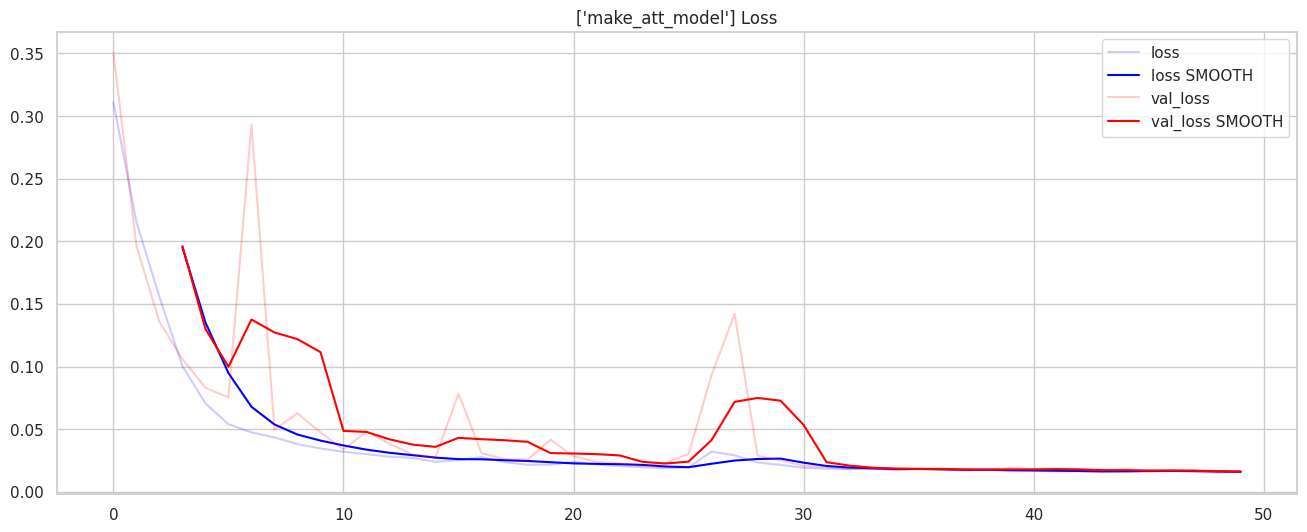

loading training log from /root/artem/analyser/training_reports/make_att_model.1.log.csv


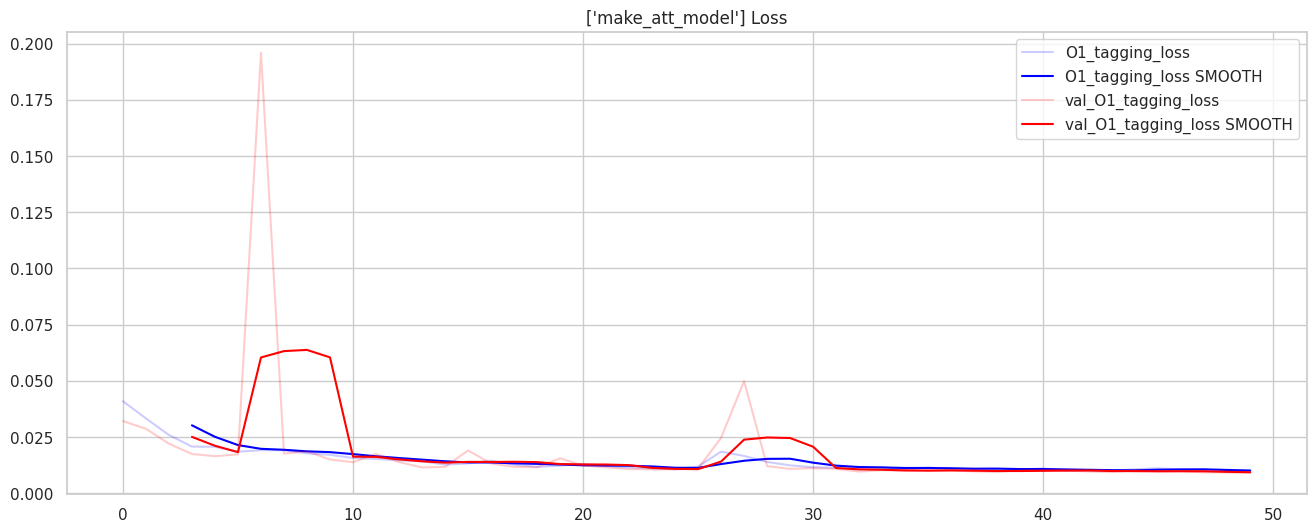

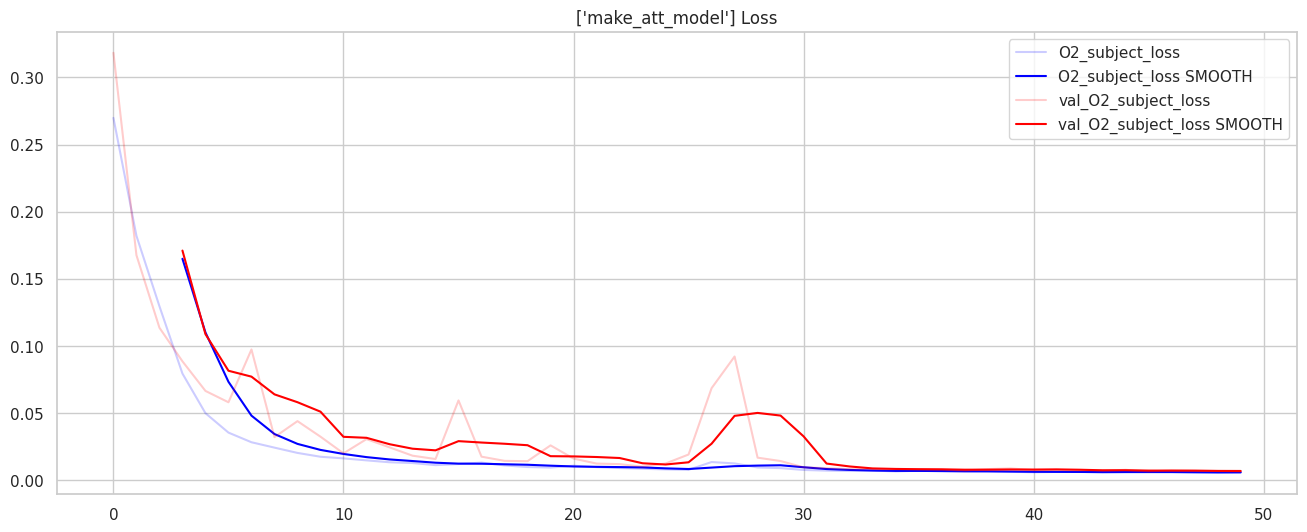

In [51]:
def plot_compare_models(
    models: [str],
    metrics, 
    title="metric/epoch",
    image_save_path = umtm.reports_dir):
    
  _metrics = [m for m in metrics if not m.startswith('val_')]

  for i, m in enumerate(models):

    data: pd.DataFrame = ctx.get_log(m)

    if data is not None:
      data.set_index('epoch')

      for metric in _metrics:
        plt.figure(figsize=(16, 6))
        plt.grid(True)
        plt.title(f'{metric} [{m}]')
        for metric_variant in ['', 'val_']:
          key = metric_variant + metric
          if key in data:

            x = data['epoch'][-100:]
            y = data[key][-100:]


            c = 'red'  # plt.cm.jet_r(i * colorstep)
            if metric_variant == '':
              c = 'blue'
            plt.plot(x, y, label=f'{key}', alpha=0.2, color=c)

            y = y.rolling(4, win_type='gaussian').mean(std=4)
            plt.plot(x, y, label=f'{key} SMOOTH', color=c)

            plt.legend(loc='upper right')

        
        plt.title(f'{[m]} {title}')
        plt.grid(True)
        img_path = os.path.join(image_save_path, f'{m}-{metric}.png')
        
        plt.savefig(img_path, bbox_inches='tight')        
        plt.show()
    else:
      logger.error('cannot plot')
    

models = list(ctx.trained_models.keys())


plot_compare_models(models, ['loss'], 'Loss')

# plot_compare_models(models, ['O1_tagging_kullback_leibler_divergence'], 'TAGS: Kullback Leibler divergence')
# plot_compare_models(models, ['O1_tagging_mse'], 'TAGS: MSE')
# plot_compare_models(models, ['O2_subject_kullback_leibler_divergence'], 'Subj: Kullback Leibler divergence')
# plot_compare_models(models, ['O2_subject_mse'],  'Subjects: MSE')

plot_compare_models(models, ['O1_tagging_loss', 'O2_subject_loss'], 'Loss')



## Contract subj Confusion matrices

In [52]:
# umtm.stats
# semantic_map_keys_contract


5edbc62eda3678279fbcadf3


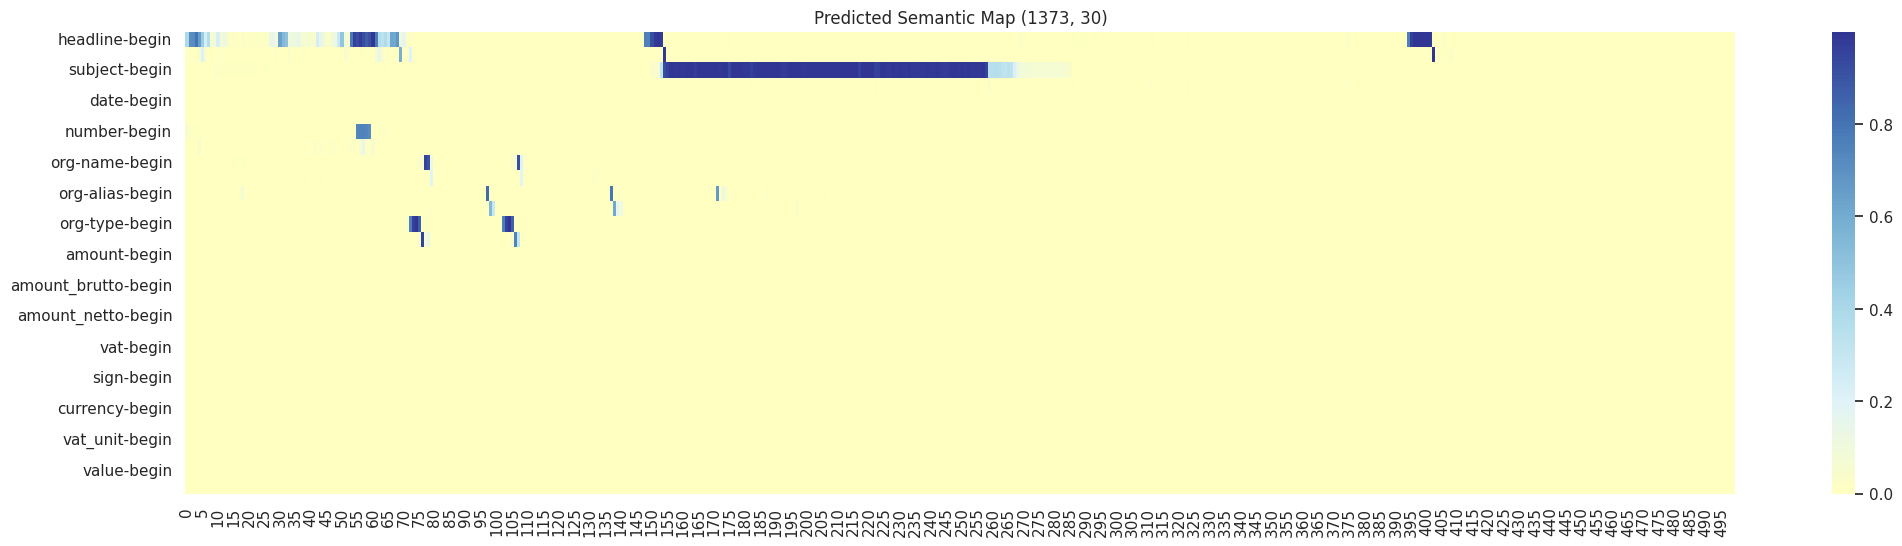

In [53]:
from tf_support.super_contract_model import make_xyw

sample_index = umtm.stats [umtm.stats['value']>0].index[2]
print(sample_index)

x, y, _ = make_xyw(sample_index, umtm.stats)

prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

tagsmap = pd.DataFrame(prediction[0][0], columns=semantic_map_keys_contract)
# .T
plot_embedding(tagsmap[:500], f'Predicted Semantic Map {tagsmap.shape}')

In [54]:
from analyser.contract_parser import nn_get_tag_values

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [55]:

agent_tags = ['org-1-name',
              'org-1-type',
              'org-1-alias',
              'org-2-name',
              'org-2-type',
              'org-2-alias']
solo_tags = [
  'date',
  'number',
  'sign_value_currency/value',
  'sign_value_currency/currency',
  'sign_value_currency/sign'
]

# seq_labels_contract[-3:]

tagnames = solo_tags + agent_tags


from pandas import DataFrame

from analyser.contract_agents import ContractAgent, normalize_contract_agent
from analyser.documents import TextMap
from analyser.ml_tools import SemanticTag
from analyser.persistence import DbJsonDoc
from analyser.text_tools import find_top_spans
# from tf_support.super_contract_model import seq_labels_contract
from tf_support.tf_subject_model import decode_subj_prediction

from analyser.contract_parser import nn_find_org_names, nn_get_tag_value




def fetch_tags_from_predicted_semantic_map(_id: str, tagsmap: DataFrame):
  jdoc = get_doc(_id)
  _map = jdoc.get_tokens_map_unchaged()

  results = {}
  for key in tagnames:
    t = nn_get_tag_value(key, _map, tagsmap )
    results[key] = t
    # print(t)

#   ca = ContractAgent()
#   ca.name =  results['org-1-name'] #TODO: check for NONE
#   ca.type =  results['org-1-type']
#   ca.alias = results['org-1-alias']
   

#   ca2 = ContractAgent()
#   ca2.name =  results['org-2-name'] #TODO: check for NONE
#   ca2.type =  results['org-2-type']
#   ca2.alias = results['org-2-alias']
#   try:
#     normalize_contract_agent(ca)
#     normalize_contract_agent(ca2)
#   except Exception as e:
#         # TODO:
#     logger.error(f'{_id} {e}')

  if results['number'] is not None:
    results['number'].value = results['number'].value.strip().lstrip('№').lstrip('N ').lstrip()

  return results, jdoc


def put_results_into_df(id_, results, df, jdoc: DbJsonDoc):
  org_atribs = ['name', 'alias', 'type']

  def v(x):
    if results[x] is not None:
      return results[x].value

  def swap(a, b):
    ab = [a, b]
    try:
      ab = sorted(ab)
    except:
      pass
    return ab

  def s(a, b):
    ab = swap(v(a), v(b))
    df.at[id_, f'p-{a}'] = ab[0]
    df.at[id_, f'p-{b}'] = ab[1]
    return ab

  for key in org_atribs:
    arr = s(f'org-1-{key}', f'org-2-{key}')

  def p(key):
    df.at[id_, f'p-{key}'] = v(key)

  p('sign_value_currency/value')
  p('sign_value_currency/currency')
  p('sign_value_currency/sign')

  p('date')
  p('number')

  # get_expected values
  for key in solo_tags:
    t = jdoc.get_attribute_value(key)
    df.at[id_, f'{key}'] = t

  for key in org_atribs:
    orgs = swap(jdoc.get_attribute_value(f'org-1-{key}'), jdoc.get_attribute_value(f'org-2-{key}'))
    df.at[id_, f'org-1-{key}'] = orgs[0]
    df.at[id_, f'org-2-{key}'] = orgs[1]



ImportError: cannot import name 'nn_get_tag_value' from 'analyser.contract_parser' (/root/artem/analyser/analyser/contract_parser.py)

In [ ]:
def make_subj_predictions(umodel, indices):
  ev = umtm.stats.copy()
  tags = pd.DataFrame()
  for t in tagnames:
    tags['p-' + t] = ''
    tags[t] = ''

  errors_report = pd.DataFrame()
  errors_report['expected'] = ''
  errors_report['predicted'] = ''

  for i, _id in enumerate(indices):
    logger.debug(f'validating {_id} {i} of {len(indices)}')
    
    x, y, _ = make_xyw(_id, umtm.stats)

    prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

    tagsmap = pd.DataFrame(prediction[0][0], columns=seq_labels_contract)
  
    r, jdoc = fetch_tags_from_predicted_semantic_map(_id, tagsmap)
    put_results_into_df(_id, r, tags, jdoc)
    

    subj_1hot = prediction[1][0]

    expected = decode_subj_prediction(y[1])[0]
    predicted = decode_subj_prediction(subj_1hot)[0]

    ev.at[_id, 'expected_subj'] = expected.name
    ev.at[_id, 'predicted_subj'] = predicted.name

    ev.at[_id, 'wrong'] = False
    if expected != predicted:
      ev.at[_id, 'wrong'] = True

  return ev, tags

ev, tags = make_subj_predictions(umodel, [sample_index])
tags

In [ ]:
%%time




# def fetch_tag_value(tagname: str, textmap: TextMap, tagging: DataFrame, threshold=0.3) -> SemanticTag or None:
#   att = tagging[tagname].values
#   slices = find_top_spans(att, threshold=threshold, limit=1) #TODO: estimate per-tag thresholds
  
#   if len(slices) > 0:
#     span = slices[0].start, slices[0].stop
#     value = textmap.text_range(span)
#     tag = SemanticTag(tagname, value, span)
#     tag.confidence = att[slices[0]].mean()
#     return tag
#   return None










subset = umtm.stats #umtm.stats[~pd.isna(umtm.stats['user_correction_date'])].sort_values('analyze_date')
_indices =  subset.index
ev, tags = make_subj_predictions(umodel, _indices)
tags.to_csv('all_contracts_predicstions.csv')

In [ ]:
# subset = umtm.stats[~pd.isna(umtm.stats['user_correction_date'])]
# pd.isna(umtm.stats['user_correction_date'])
ev 

In [ ]:
# _cols = [  'wrong' ]
# _tmp = ev[cols]
# errors_report = _tmp[ _tmp.wrong == True] #.sort_values('subject')
# print(len(errors_report), 'wrong subjects of', len(tags))
# errors_report 

ev['predicted_subj']
subj_df = ev[['predicted_subj', 'expected_subj']].copy()

In [ ]:
subj_df

In [ ]:
def make_report(umodel, ev):
  plot_cm(ev['expected_subj'], ev['predicted_subj'])
  
  img_path = os.path.join(umtm.work_dir, f'subjects-confusion-matrix-{umodel.name}.png')
  plt.savefig(img_path, bbox_inches='tight')

  report = classification_report(ev['expected_subj'], ev['predicted_subj'], digits=3)
  print(umodel.name)
  print(report)
  
  with open(os.path.join(umtm.work_dir, f'subjects-classification_report-{umodel.name}.txt'), "w") as text_file:
    text_file.write(report)


subj_df = ev[['predicted_subj', 'expected_subj']].copy() #ev[~pd.isna(ev['predicted_subj'])]
make_report(umodel, subj_df)

# Evaluate tags detection

In [ ]:
tags.fillna('-', inplace=True)
tags

In [ ]:
def save_csv(d, f):
    fn = os.path.join(umtm.work_dir, f)
    d.to_csv(fn)

### Contract number validation

In [ ]:
wrong_numbers = tags [ tags['number'] != tags['p-number']].sort_values('number')
print( f'Contract numbers: {len(wrong_numbers)} of {len(tags)}  ({100. * len(wrong_numbers) / len(tags) :0.1f}%) were detected wronggly')

save_csv( wrong_numbers[['p-number', 'number']], 'wrong_numbers.csv')

# wrong_numbers[['p-number', 'number']].tail(10)

In [ ]:
tags ['sign_value_currency/currency'].head(100)

In [ ]:
def conv(x):
    if type(x) is str:
        v = x.replace(',','.').replace(' ','')
    else: 
        v=x
    try:
        v=float(v)
    except:
        v=np.nan
    return v 

tags['n-p-sign_value_currency/value'] = pd.to_numeric( tags['p-sign_value_currency/value'].apply(conv) )
tags['n-sign_value_currency/value']   = pd.to_numeric( tags['sign_value_currency/value'].apply(conv) )

In [ ]:
wrong_values = tags [  tags['n-p-sign_value_currency/value']  != tags['n-sign_value_currency/value']]
cols = ['n-p-sign_value_currency/value', 'n-sign_value_currency/value']
wrong_values = wrong_values[cols]

wrong_values ['val_err'] = \
    np.log1p( np.abs(wrong_values['n-p-sign_value_currency/value'] - wrong_values['n-sign_value_currency/value']))
wrong_values = wrong_values.sort_values('val_err', ascending=False)

print(len(wrong_values))
wrong_values.tail(24)

### Contract Org-1 validation

In [ ]:


wrong_orgs1 = tags [ (tags['org-1-name'] != tags['p-org-1-name']) | (tags['org-2-name'] != tags['p-org-2-name']) ]
print( f'Org-1 name: {len(wrong_orgs1)} of {len(tags)}  ({100. * len(wrong_orgs1) / len(tags):0.1f}%) were detected incorrectly')

cols=['p-org-1-name', 'org-1-name', 'p-org-2-name', 'org-2-name']
save_csv( wrong_orgs1[cols], 'wrong_orgs1.csv')

wrong_orgs1[cols].head(20)

In [ ]:
wrong_aliases = tags [ (tags['org-1-alias'] != tags['p-org-1-alias']) | (tags['org-2-alias'] != tags['p-org-2-alias']) ]
print( f'Aliases: {len(wrong_aliases)} of {len(tags)}  ({100. * len(wrong_aliases) / len(tags) : 0.1f}%) were detected incorrectly')

cols=['p-org-1-alias', 'org-1-alias', 'p-org-2-alias', 'org-2-alias']
save_csv( wrong_aliases[cols], 'wrong_aliases.csv')
# wrong_aliases[cols].head(10)

In [ ]:
wrong_types = tags [ (tags['org-1-type'] != tags['p-org-1-type']) | (tags['org-2-type'] != tags['p-org-2-type'])]
print( f'Types: {len(wrong_types)} of {len(tags)}  ({100. * len(wrong_types) / len(tags) : 0.1f}%) were detected incorrectly')
cols=['p-org-1-type', 'p-org-2-type', 'org-1-type', 'org-2-type']
save_csv( wrong_types[cols], 'wrong_types.csv')
wrong_types[cols].head(10)

In [ ]:
from collections import Counter
arrays = [ wrong_orgs1, wrong_types, wrong_numbers, wrong_aliases]
counter = Counter()
for a in arrays:
  for i in a.index:
   counter[i]+=1
 

print('Самый сложный документ: ', counter.most_common()[0][0])
print("Всего недочетов:", len(counter))

In [ ]:
umtm.stats['errors'] = 0
for c in counter:
  umtm.stats.at[c, 'errors'] = counter[c]


calculate_samples_weights(umtm)
umtm._save_stats()
umtm.stats

## Single doc eval

In [ ]:
if IN_COLAB:
  !wget https://raw.githubusercontent.com/nemoware/analyser/uber-models/tests/contract_db_1.json

  with open('contract_db_1.json', 'rb') as handle:    
    jdata = json.load(handle, object_hook=json_util.object_hook)

  jdoc = DbJsonDoc(jdata)

else:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    logger.debug(f'fetching {objid}')
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata =  documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

  SAMPLE_DOC_ID = counter.most_common()[0][0] #umtm.stats.index[10]
    
    
    
  SAMPLE_DOC_ID = '5eea27adc28b75807f3dae66'
  print('SAMPLE_DOC_ID:', SAMPLE_DOC_ID)
  dp = umtm.make_xyw(SAMPLE_DOC_ID)
  (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

  jdoc = get_doc(SAMPLE_DOC_ID)

In [ ]:
from analyser.legal_docs import embedd_tokens

if IN_COLAB:
  embedder = ElmoEmbedder.get_instance('elmo')  # lazy init
  emb = embedd_tokens(jdoc.get_tokens_for_embedding(),
                             embedder,
                             verbosity=2,
                             log_key='tmp')

  tok_f = get_tokens_features(jdoc.get_tokens_map_unchaged().tokens)

In [ ]:
###############
prediction = umodel.predict(   x=[  np.expand_dims(emb, axis=0), np.expand_dims(tok_f, axis=0)] , batch_size=1)
##############
print(len(prediction), umodel.name)
subj_1hot = prediction[1][0]
print('Subject:', decode_subj_prediction(subj_1hot))


tagging = pd.DataFrame( prediction[0][0], columns=seq_labels_contract)
plot_embedding(tagging, title = f'Predictions of {umodel.name}')

In [ ]:
def render_slices(slices, tokens, attention_v, ht='') -> str:
  ht += '<ol>'
  for _s in slices:
    ht += '<li>'
    t = tokens[_s]
    l = attention_v[_s]
    ht += to_color_text(t, l, _range=(0, 1.2))
    ht += '<br><hr>'
    ht += '</li>'
  ht += '</ol>'

  return ht

for t in seq_labels_contract:
  spans = list( find_top_spans( tagging[t].values, threshold=0.3))  
  display(HTML(render_slices(spans, jdoc.get_tokens_map_unchaged().tokens, tagging[t].values)))


In [ ]:

# mean_ = tagging.values.max(-1)*0.5
# print (mean_.shape)
# display(HTML( to_color_text (jdoc.get_tokens_map_unchaged().tokens[:24000],  mean_[:24000])))

In [ ]:
ids = '5edbadd7da3678279fbcaabf
5edbc660da3678279fbcaeac
5edbc668da3678279fbcaf6e
5edbc65dda3678279fbcae56
5edbc66bda3678279fbcafe6
5edbc615da3678279fbcadc9'